In [249]:
import mne
import pywt
import scaleogram as scg
import pandas as pd
import numpy as np
import scipy
import time
from scipy import signal
import matplotlib.pyplot as plt 
from collections import Counter
from edf_file_processing import create_raw_object, visualize_data, find_all_paths
from tqdm import tqdm
import os
import random
import xgboost

In [196]:
CHANNEL_DIV = {'Frontal left': ['F7', 'F3', 'FP1'], 
               'Frontal Right': ['F4', 'F8', 'FP2'], 
               'Central': ['C3', 'Cz', 'C4'], 
               'Temporal left': ['T3', 'T5'], 
                'Temporal right': ['T4', 'T6'], 
               'Parietal': ['P3', 'Pz', 'P4'], 
               'Ocipital': ['O1', 'Oz', 'O2']}

LABELS_VAL = {0: 'NONE', 1: 'FNSZ', 
              2: 'GNSZ', 3: 'SPSZ',
              4: 'CPSZ', 5: 'ABSZ', 
              6: 'TNSZ', 7: 'CNSZ',
              8: 'TCSZ', 9: 'ATSZ',
             10: 'MYSZ'}

LABELS_KEY = {v: k for k, v in LABELS_VAL.items()}

FREQ = 250
SCALES = np.arange(1, 251)
ALL_EDF_FILES = list(find_all_paths('edf').values())
# ALL_TXT_FILES = list(find_all_paths_txt('edf/train').values())

TRAIN_EDF_FILES = list(find_all_paths('edf/train').values())
TRAIN_TXT_FILES = list(find_all_paths_txt('edf/train').values())

TEST_EDF_FILES = list(find_all_paths('edf/dev').values())
TEST_TXT_FILES = list(find_all_paths_txt('edf/dev').values())

In [197]:
def find_all_paths_txt(path):
    # Goes into all possible directories starting from initial "path"
    # goes into all sub-directories to find filtered_....txt files
    list_of_files = {}
    for (dirpath, dirnames, filenames) in os.walk(path):
        for filename in filenames:
            if filename.endswith(".txt") and filename.startswith("filtered_"):
                list_of_files[filename] = os.sep.join([dirpath, filename])
    return list_of_files

In [198]:
# A function that plots the spectogram of a signal
def plot_wavelet(time, signal, scales, 
                 waveletname = 'cmor', 
                 cmap = plt.cm.seismic, 
                 title = 'Wavelet Transform (Power Spectrum) of signal', 
                 ylabel = 'Period (timesteps)', 
                 xlabel = 'Time'):
    
    dt = 1
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
#     print(coefficients.shape)

    contourlevels = [-42, -40, -36, -34, -32, -30, -28, -26, -24]

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    
    cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
#     print(cbar_ax)
    fig.colorbar(im, cax=cbar_ax, orientation="vertical")
    plt.show()

In [199]:
def split_signal(data, duration=2):
    '''
    function that splits the particular eeg signal into parts
    Returns the numpy array of the size (n, k, m), where n
    is the row size of an input matrix, k is number of elements in each of the row,
    and m is number of elements in each element of the row
    data --> a segment of filtered data
    '''
    result_arr = np.ndarray(shape=(len(data), int(len(data[0])/(duration*FREQ)), duration*FREQ))
    for ch in range(len(data)):
        k = 0
        for i in range(0, len(data[1]), duration*FREQ):
#             print(f'CHANNEL NO: {ch}')
#             print(f'K: {k}')
#             print(f'ROW DATA IND: {i}')
#             print(duration*FREQ)
#             print(len(data[ch][i:i+duration*FREQ]))
            if len(data[ch][i:]) < duration*FREQ:
#                 print("Hello")
                break
            result_arr[ch][k] = data[ch][i:i+duration*FREQ]
            k += 1
    return result_arr    

In [200]:
def get_data_times(raw_edf, start_s, duration=2):
    '''
    The function to extract the signal of a certain duration 
    starting from a concrete time in seconds
    Returns data and times as a tuple if the operation was successful
    Returns None, if the operation was not successful and prints the specific problem occured   
    '''
    try:
        start, stop = raw_edf.time_as_index([start_s, start_s+duration])
        data, times = raw_edf[:, start:stop]
        return data, times
    except:
        print("The index is out of range")
        return None

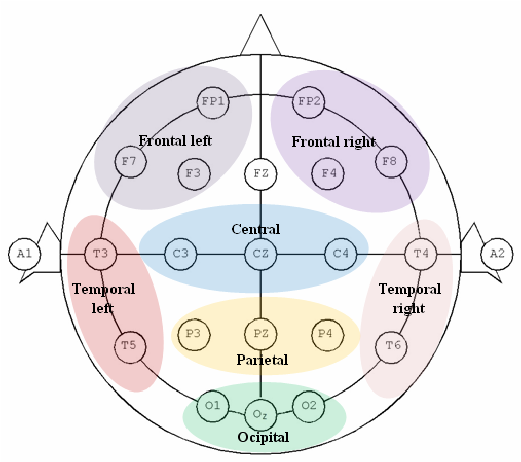

In [201]:
def averaging_channel_information(raw_edf):
    # function that averages the signals of different electrodes positions
    # the division can be seen in the picture above
    # Returns the concatenated averaged data matrix of size (7, timesteps) and the timesteps per Se
    channels = raw_edf.info['ch_names']
    dict_partial_chan = {}
    
    for part in CHANNEL_DIV:
        partial = []
        for ch in CHANNEL_DIV[part]:
            for c in channels:
                if ch in c:
                    partial.append(c)
        dict_partial_chan[part] = partial
    raw_edf.copy().pick_channels(dict_partial_chan['Frontal left'])
        
    data_fr_l, times = get_data_times(raw_edf.copy().pick_channels(dict_partial_chan['Frontal left']),
                                      start_s=0, duration=int(raw_edf.n_times / raw_edf.info['sfreq']))
    
    data_fr_r = get_data_times(raw_edf.copy().pick_channels(dict_partial_chan['Frontal Right']),
                                      start_s=0, duration=int(raw_edf.n_times / raw_edf.info['sfreq']))[0]
    
    data_centr = get_data_times(raw_edf.copy().pick_channels(dict_partial_chan['Central']),
                                      start_s=0, duration=int(raw_edf.n_times / raw_edf.info['sfreq']))[0]
    
    data_temp_l = get_data_times(raw_edf.copy().pick_channels(dict_partial_chan['Temporal left']),
                                      start_s=0, duration=int(raw_edf.n_times / raw_edf.info['sfreq']))[0]
    
    data_temp_r = get_data_times(raw_edf.copy().pick_channels(dict_partial_chan['Temporal right']),
                                      start_s=0, duration=int(raw_edf.n_times / raw_edf.info['sfreq']))[0]
    
    data_par = get_data_times(raw_edf.copy().pick_channels(dict_partial_chan['Parietal']),
                                      start_s=0, duration=int(raw_edf.n_times / raw_edf.info['sfreq']))[0]
    
    data_oc = get_data_times(raw_edf.copy().pick_channels(dict_partial_chan['Ocipital']),
                                      start_s=0, duration=int(raw_edf.n_times / raw_edf.info['sfreq']))[0]
    
    general_data_lst = [data_fr_l, data_fr_r, data_centr, data_temp_l, data_temp_r ,data_par, data_oc]
    
    modified_lst = []
    
    for sep_part in general_data_lst:
        sep_part = sep_part.sum(axis=0) / len(sep_part)
        modified_lst.append(sep_part)
        
    return np.vstack(modified_lst), times

As we consider the n-sec data as a separate sequence and we decided to use this separate n-sec fragment of initial file as additionally labeled "file", we do not need so much data for classification. In the CNN model we are going to represent the spectogram as an image and hence, the input batch_size, which is EVERY .edf file splitted by an n-sec period, would be several million images, which is too much. 

What we are planning to do is before splitting the data into n-sec period fragments, we are

In [240]:
def dropping_unnecessary_data(labels_file, splitted_data):
    '''
    Deletes the fragments of data that is randomly chosen to be taken out 
    65% of data will be dropped because of the lack of its necessity
    Also modifies the .txt file, which stores the labels to store only needed ones
    Is only done to the train data
    '''
    
    NONE_PROB = 90
    SEIZ_PROB = 10
    
    choices = [0, 1]
    
    half = round(len(splitted_data[0]) * 0.65)
    
    for _ in range(half):
        
        ch = random.choices(choices, cum_weights=[NONE_PROB, SEIZ_PROB])[0]
        
        file = open(labels_file, 'r')
        lines = list(file.readlines())
        
        if ch == 0:
            poss = [i for i in range(len(lines)) if lines[i] == 'NONE\n']
        elif ch == 1:
            poss = [i for i in range(len(lines)) if lines[i] != 'NONE\n']
            
        try:
            j = random.choice(poss)
        except:
            j = random.randint(0, len(lines)-1)
            
        file.close()
        
        del lines[j]
        
        new_f = open(labels_file, 'w+')
        for l in lines:
            new_f.write(l)
        new_f.close()
        
        splitted_data = np.delete(splitted_data, j, 1)
    
    return labels_file, splitted_data

In [219]:
def cwt_splitted_data(splitted_data):
    # Performing Continuous Wavelet Transform on  
    # (segmented into channels and divided into subparts) files 
    
    data_cwt = np.ndarray(shape=(
        len(splitted_data[0]),
        len(SCALES),
        len(splitted_data[0][0]),
        len(splitted_data)
    ))
    
    for i in range(0, len(splitted_data[0])):
        for j in range(0, len(splitted_data)):
            sig = splitted_data[j, i, :]
            coefficients, frequency = pywt.cwt(sig, SCALES, 'morl', 1)
            
            data_cwt[i, :, :, j] = coefficients
    
    print(data_cwt.shape)
    return data_cwt

In [204]:
def entropy(arr):
    '''
    Measures the data randomness
    The higher the value, the harder it is to draw any conclusion from it 
    '''
    counter = Counter(arr).most_common()
    probs = [i[1]/len(arr) for i in counter]
    return [scipy.stats.entropy(probs)]

In [205]:
def general_statistics(arr):
    '''
    Calculates the general statistical features that could be useful
    '''
    mean = np.nanmean(arr)
    variance = np.nanvar(arr)
    std = np.nanstd(arr)
    rms = np.nanmean(np.sqrt(arr**2))
    median = np.nanpercentile(arr, 50)
    perc5 = np.nanpercentile(arr, 5)
    perc25 = np.nanpercentile(arr, 25)
    perc75 = np.nanpercentile(arr, 75)
    perc95 = np.nanpercentile(arr, 95)
    return [mean, variance, std, rms, median, perc5, perc25, perc75, perc95]

In [206]:
def crossings(arr):
    '''
    Calculates number of times the signal crosses 0 and mean value
    '''
    crossing_zero = np.nonzero(np.diff(np.array(arr) > 0))[0]
    crossing_mean = np.nonzero(np.diff(np.array(arr) > np.nanmean(arr)))[0]
    return [len(crossing_zero), len(crossing_mean)]

In [207]:
def get_features(arr):
    '''
    Links together all the features 
    '''
    return entropy(arr) + general_statistics(arr) + crossings(arr)

In [217]:
def dwt_splitted_data(splitted_data, labels_file, wavelet='sym9'):
    '''
    Forms a part of a train dataset to fill in the whole training set
    By performing Discrete Wavelet Transform on each of the channel entry 
    '''
    to_return = []
    for i in range(0, len(splitted_data[0])):
        features = []
        for j in range(0, len(splitted_data)):
            sig = splitted_data[j, i, :]
            coefficients_lst = pywt.wavedec(sig, wavelet)
            
            for c in coefficients_lst:
                features += get_features(c)
        to_return.append(features)
    
    with open(labels_file, 'r') as f:
        labels = [LABELS_KEY[l.replace('\n', '')] for l in list(f.readlines())]
    
    Y = np.array(labels)
    X = np.array(to_return)
    
    return X, Y           

In [241]:
def main():
    '''
    The function retrieves the data from edf files, performs splitting data into n-sec parts,
    performs Discrete Wavelet Transform, extracts main features and 
    saves all the data in the input shape for classification model
    '''
    train_data = np.array([])
    train_labels = np.array([])
    
    test_data = np.array([])
    test_labels = np.array([])
    
#     all_files = [list(find_all_paths('edf_test/train').values()), 
#                  list(find_all_paths('edf_test/dev').values())]
    all_files = [TRAIN_EDF_FILES, TEST_EDF_FILES]
    
    train = True
    
    for files in all_files:
        for file in tqdm(files):
            txt_file = file.replace('.edf', '.txt')
            print(txt_file)
            edf = create_raw_object(file)
            d, t = averaging_channel_information(edf)
            splitted = split_signal(d)

            labels_file, splitted_dropped = dropping_unnecessary_data(txt_file, splitted)

            data_dwt, labels = dwt_splitted_data(splitted_dropped, txt_file)  
#             print(data_dwt.shape)
            
            if train:
                if train_data.size == 0:
                    train_data = data_dwt
                    train_labels = labels
                else:
                    train_data = np.vstack([train_data, data_dwt])
                    train_labels = np.concatenate([train_labels, labels])
                print(train_data.shape)

                
            else:
                if test_data.size == 0:
                    test_data = data_dwt
                    test_labels = labels
                else:
                    test_data = np.vstack([test_data, data_dwt])
                    test_labels = np.concatenate([test_labels, labels])
                print(test_data.shape)

        train = False
    
    return train_data, train_labels, test_data, test_labels

In [242]:
start_time = time.time()
train_data, train_labels, test_data, test_labels = main()
duration = time.time() - start_time
print(f"Total time: {duration}")

  0%|          | 0/2269 [00:00<?, ?it/s]

edf/train/02_tcp_le/050/00005096/s006_2008_11_04/filtered_00005096_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/050/00005096/s006_2008_11_04/filtered_00005096_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 1/2269 [00:03<1:53:27,  3.00s/it]

(104, 420)
edf/train/02_tcp_le/050/00005096/s006_2008_11_04/filtered_00005096_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/050/00005096/s006_2008_11_04/filtered_00005096_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 2/2269 [00:08<2:16:50,  3.62s/it]

(280, 420)
edf/train/02_tcp_le/050/00005025/s001_2008_05_23/filtered_00005025_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/050/00005025/s001_2008_05_23/filtered_00005025_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 3/2269 [00:14<2:45:22,  4.38s/it]

(490, 420)
edf/train/02_tcp_le/050/00005095/s001_2008_10_30/filtered_00005095_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/050/00005095/s001_2008_10_30/filtered_00005095_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 4/2269 [00:19<2:59:07,  4.74s/it]

(683, 420)
edf/train/02_tcp_le/050/00005095/s001_2008_10_30/filtered_00005095_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/050/00005095/s001_2008_10_30/filtered_00005095_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 5/2269 [00:20<2:11:16,  3.48s/it]

(702, 420)
edf/train/02_tcp_le/050/00005034/s001_2008_08_06/filtered_00005034_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/050/00005034/s001_2008_08_06/filtered_00005034_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 6/2269 [00:31<3:41:16,  5.87s/it]

(1073, 420)
edf/train/02_tcp_le/024/00002435/s002_2006_01_20/filtered_00002435_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002435/s002_2006_01_20/filtered_00002435_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 7/2269 [00:35<3:15:39,  5.19s/it]

(1203, 420)
edf/train/02_tcp_le/024/00002435/s002_2006_01_20/filtered_00002435_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002435/s002_2006_01_20/filtered_00002435_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 8/2269 [00:38<2:48:01,  4.46s/it]

(1303, 420)
edf/train/02_tcp_le/024/00002484/s002_2006_05_18/filtered_00002484_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002484/s002_2006_05_18/filtered_00002484_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 9/2269 [00:44<3:08:21,  5.00s/it]

(1519, 420)
edf/train/02_tcp_le/024/00002484/s001_2006_05_18/filtered_00002484_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002484/s001_2006_05_18/filtered_00002484_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 10/2269 [00:45<2:29:15,  3.96s/it]

(1575, 420)
edf/train/02_tcp_le/024/00002478/s001_2006_01_31/filtered_00002478_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002478/s001_2006_01_31/filtered_00002478_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 11/2269 [00:48<2:16:26,  3.63s/it]

(1677, 420)
edf/train/02_tcp_le/024/00002478/s001_2006_01_31/filtered_00002478_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002478/s001_2006_01_31/filtered_00002478_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 12/2269 [00:49<1:46:54,  2.84s/it]

(1713, 420)
edf/train/02_tcp_le/024/00002478/s001_2006_01_31/filtered_00002478_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002478/s001_2006_01_31/filtered_00002478_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 13/2269 [00:51<1:36:38,  2.57s/it]

(1783, 420)
edf/train/02_tcp_le/024/00002489/s003_2007_03_29/filtered_00002489_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002489/s003_2007_03_29/filtered_00002489_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 14/2269 [00:58<2:23:48,  3.83s/it]

(2010, 420)
edf/train/02_tcp_le/024/00002427/s003_2006_02_28/filtered_00002427_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002427/s003_2006_02_28/filtered_00002427_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 15/2269 [01:05<2:57:28,  4.72s/it]

(2241, 420)
edf/train/02_tcp_le/024/00002445/s002_2007_10_10/filtered_00002445_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002445/s002_2007_10_10/filtered_00002445_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 16/2269 [01:08<2:41:09,  4.29s/it]

(2358, 420)
edf/train/02_tcp_le/024/00002445/s002_2007_10_10/filtered_00002445_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002445/s002_2007_10_10/filtered_00002445_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 17/2269 [01:11<2:21:55,  3.78s/it]

(2451, 420)
edf/train/02_tcp_le/024/00002448/s001_2006_01_26/filtered_00002448_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002448/s001_2006_01_26/filtered_00002448_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 18/2269 [01:13<2:09:08,  3.44s/it]

(2546, 420)
edf/train/02_tcp_le/024/00002448/s001_2006_01_26/filtered_00002448_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002448/s001_2006_01_26/filtered_00002448_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 19/2269 [01:18<2:22:51,  3.81s/it]

(2710, 420)
edf/train/02_tcp_le/024/00002448/s001_2006_01_26/filtered_00002448_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002448/s001_2006_01_26/filtered_00002448_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 20/2269 [01:20<2:06:55,  3.39s/it]

(2794, 420)
edf/train/02_tcp_le/024/00002448/s001_2006_01_26/filtered_00002448_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/024/00002448/s001_2006_01_26/filtered_00002448_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 21/2269 [01:22<1:43:33,  2.76s/it]

(2839, 420)
edf/train/02_tcp_le/049/00004921/s001_2008_04_02/filtered_00004921_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/049/00004921/s001_2008_04_02/filtered_00004921_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 22/2269 [01:29<2:32:58,  4.08s/it]

(3081, 420)
edf/train/02_tcp_le/039/00003988/s001_2007_05_22/filtered_00003988_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/039/00003988/s001_2007_05_22/filtered_00003988_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 23/2269 [01:35<2:54:03,  4.65s/it]

(3285, 420)
edf/train/02_tcp_le/039/00003960/s001_2007_06_11/filtered_00003960_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/039/00003960/s001_2007_06_11/filtered_00003960_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 24/2269 [01:41<3:10:38,  5.10s/it]

(3496, 420)
edf/train/02_tcp_le/039/00003977/s001_2007_03_26/filtered_00003977_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/039/00003977/s001_2007_03_26/filtered_00003977_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 25/2269 [01:45<2:59:31,  4.80s/it]

(3642, 420)
edf/train/02_tcp_le/039/00003977/s001_2007_03_26/filtered_00003977_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/039/00003977/s001_2007_03_26/filtered_00003977_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 26/2269 [01:48<2:36:09,  4.18s/it]

(3739, 420)
edf/train/02_tcp_le/007/00000762/s001_2003_05_15/filtered_00000762_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/007/00000762/s001_2003_05_15/filtered_00000762_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 27/2269 [01:56<3:23:52,  5.46s/it]

(4013, 420)
edf/train/02_tcp_le/007/00000705/s001_2003_11_26/filtered_00000705_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/007/00000705/s001_2003_11_26/filtered_00000705_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 28/2269 [01:57<2:29:47,  4.01s/it]

(4035, 420)
edf/train/02_tcp_le/007/00000705/s001_2003_11_26/filtered_00000705_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/007/00000705/s001_2003_11_26/filtered_00000705_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|▏         | 29/2269 [02:03<2:52:10,  4.61s/it]

(4244, 420)
edf/train/02_tcp_le/007/00000752/s001_2003_05_16/filtered_00000752_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/007/00000752/s001_2003_05_16/filtered_00000752_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|▏         | 30/2269 [02:09<3:08:02,  5.04s/it]

(4454, 420)
edf/train/02_tcp_le/007/00000775/s001_2003_11_19/filtered_00000775_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/007/00000775/s001_2003_11_19/filtered_00000775_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|▏         | 31/2269 [02:09<2:14:42,  3.61s/it]

(4464, 420)
edf/train/02_tcp_le/007/00000775/s001_2003_11_19/filtered_00000775_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/007/00000775/s001_2003_11_19/filtered_00000775_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|▏         | 32/2269 [02:15<2:43:05,  4.37s/it]

(4681, 420)
edf/train/02_tcp_le/007/00000704/s001_2003_11_21/filtered_00000704_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/007/00000704/s001_2003_11_21/filtered_00000704_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|▏         | 33/2269 [02:25<3:39:36,  5.89s/it]

(4997, 420)
edf/train/02_tcp_le/033/00003318/s001_2006_09_12/filtered_00003318_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/033/00003318/s001_2006_09_12/filtered_00003318_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|▏         | 34/2269 [02:31<3:41:28,  5.95s/it]

(5208, 420)
edf/train/02_tcp_le/033/00003346/s001_2006_10_31/filtered_00003346_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/033/00003346/s001_2006_10_31/filtered_00003346_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 35/2269 [02:37<3:42:18,  5.97s/it]

(5419, 420)
edf/train/02_tcp_le/044/00004434/s003_2008_01_11/filtered_00004434_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/044/00004434/s003_2008_01_11/filtered_00004434_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 36/2269 [02:43<3:48:48,  6.15s/it]

(5647, 420)
edf/train/02_tcp_le/044/00004456/s009_2010_06_08/filtered_00004456_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/044/00004456/s009_2010_06_08/filtered_00004456_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 37/2269 [02:53<4:29:20,  7.24s/it]

(5975, 420)
edf/train/02_tcp_le/044/00004456/s009_2010_06_08/filtered_00004456_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/044/00004456/s009_2010_06_08/filtered_00004456_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 38/2269 [02:54<3:16:52,  5.29s/it]

(6002, 420)
edf/train/02_tcp_le/044/00004473/s001_2008_02_11/filtered_00004473_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/044/00004473/s001_2008_02_11/filtered_00004473_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 39/2269 [03:00<3:25:28,  5.53s/it]

(6214, 420)
edf/train/02_tcp_le/044/00004473/s002_2008_02_12/filtered_00004473_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/044/00004473/s002_2008_02_12/filtered_00004473_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 40/2269 [03:02<2:46:58,  4.49s/it]

(6290, 420)
edf/train/02_tcp_le/044/00004473/s002_2008_02_12/filtered_00004473_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/044/00004473/s002_2008_02_12/filtered_00004473_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 41/2269 [03:08<3:06:33,  5.02s/it]

(6507, 420)
edf/train/02_tcp_le/044/00004473/s004_2008_04_25/filtered_00004473_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/044/00004473/s004_2008_04_25/filtered_00004473_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 42/2269 [03:14<3:16:11,  5.29s/it]

(6712, 420)
edf/train/02_tcp_le/044/00004473/s003_2008_02_14/filtered_00004473_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/044/00004473/s003_2008_02_14/filtered_00004473_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 43/2269 [03:20<3:23:39,  5.49s/it]

(6919, 420)
edf/train/02_tcp_le/012/00001291/s001_2004_05_27/filtered_00001291_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/012/00001291/s001_2004_05_27/filtered_00001291_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 44/2269 [03:27<3:38:35,  5.89s/it]

(7155, 420)
edf/train/02_tcp_le/012/00001267/s003_2004_09_14/filtered_00001267_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/012/00001267/s003_2004_09_14/filtered_00001267_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 45/2269 [03:33<3:42:07,  5.99s/it]

(7370, 420)
edf/train/02_tcp_le/012/00001217/s001_2004_09_28/filtered_00001217_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/012/00001217/s001_2004_09_28/filtered_00001217_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 46/2269 [03:41<4:02:18,  6.54s/it]

(7635, 420)
edf/train/02_tcp_le/054/00005452/s001_2009_11_17/filtered_00005452_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s001_2009_11_17/filtered_00005452_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 47/2269 [03:49<4:12:28,  6.82s/it]

(7888, 420)
edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 48/2269 [03:51<3:25:02,  5.54s/it]

(7981, 420)
edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 49/2269 [03:52<2:30:44,  4.07s/it]

(8004, 420)
edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 50/2269 [03:54<2:12:15,  3.58s/it]

(8092, 420)
edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 51/2269 [03:57<2:01:57,  3.30s/it]

(8187, 420)
edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 52/2269 [03:57<1:30:32,  2.45s/it]

(8203, 420)
edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 53/2269 [04:04<2:15:05,  3.66s/it]

(8426, 420)
edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 54/2269 [04:07<2:05:43,  3.41s/it]

(8528, 420)
edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005452/s002_2009_11_17/filtered_00005452_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 55/2269 [04:08<1:45:54,  2.87s/it]

(8586, 420)
edf/train/02_tcp_le/054/00005476/s002_2008_11_11/filtered_00005476_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005476/s002_2008_11_11/filtered_00005476_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 56/2269 [04:15<2:26:35,  3.97s/it]

(8811, 420)
edf/train/02_tcp_le/054/00005476/s001_2008_11_07/filtered_00005476_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005476/s001_2008_11_07/filtered_00005476_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 57/2269 [04:24<3:26:39,  5.61s/it]

(9124, 420)
edf/train/02_tcp_le/054/00005427/s002_2009_02_22/filtered_00005427_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005427/s002_2009_02_22/filtered_00005427_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 58/2269 [04:30<3:32:01,  5.75s/it]

(9334, 420)
edf/train/02_tcp_le/054/00005411/s002_2009_10_21/filtered_00005411_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005411/s002_2009_10_21/filtered_00005411_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 59/2269 [04:44<4:56:42,  8.06s/it]

(9761, 420)
edf/train/02_tcp_le/054/00005426/s001_2008_11_06/filtered_00005426_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/054/00005426/s001_2008_11_06/filtered_00005426_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 60/2269 [04:50<4:34:41,  7.46s/it]

(9971, 420)
edf/train/02_tcp_le/056/00005672/s001_2009_04_03/filtered_00005672_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/056/00005672/s001_2009_04_03/filtered_00005672_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 61/2269 [04:56<4:25:10,  7.21s/it]

(10192, 420)
edf/train/02_tcp_le/005/00000529/s002_2003_05_07/filtered_00000529_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000529/s002_2003_05_07/filtered_00000529_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 62/2269 [05:03<4:19:37,  7.06s/it]

(10422, 420)
edf/train/02_tcp_le/005/00000529/s003_2003_10_21/filtered_00000529_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000529/s003_2003_10_21/filtered_00000529_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 63/2269 [05:10<4:19:49,  7.07s/it]

(10664, 420)
edf/train/02_tcp_le/005/00000529/s001_2003_04_28/filtered_00000529_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000529/s001_2003_04_28/filtered_00000529_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 64/2269 [05:17<4:10:27,  6.82s/it]

(10878, 420)
edf/train/02_tcp_le/005/00000502/s003_2003_08_12/filtered_00000502_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000502/s003_2003_08_12/filtered_00000502_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 65/2269 [05:23<4:01:58,  6.59s/it]

(11088, 420)
edf/train/02_tcp_le/005/00000576/s001_2003_05_23/filtered_00000576_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000576/s001_2003_05_23/filtered_00000576_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 66/2269 [05:30<4:06:15,  6.71s/it]

(11327, 420)
edf/train/02_tcp_le/005/00000574/s002_2003_11_10/filtered_00000574_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000574/s002_2003_11_10/filtered_00000574_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 67/2269 [05:36<4:08:14,  6.76s/it]

(11564, 420)
edf/train/02_tcp_le/005/00000574/s001_2003_11_07/filtered_00000574_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000574/s001_2003_11_07/filtered_00000574_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 68/2269 [05:43<4:00:52,  6.57s/it]

(11775, 420)
edf/train/02_tcp_le/005/00000526/s001_2003_08_11/filtered_00000526_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s001_2003_08_11/filtered_00000526_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 69/2269 [05:50<4:15:37,  6.97s/it]

(12045, 420)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 70/2269 [05:51<3:07:09,  5.11s/it]

(12072, 420)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 71/2269 [05:53<2:29:24,  4.08s/it]

(12134, 420)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 72/2269 [05:54<1:54:49,  3.14s/it]

(12168, 420)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 73/2269 [05:55<1:30:05,  2.46s/it]

(12200, 420)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 74/2269 [05:56<1:17:26,  2.12s/it]

(12248, 420)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 75/2269 [05:58<1:13:56,  2.02s/it]

(12315, 420)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 76/2269 [05:59<1:02:21,  1.71s/it]

(12350, 420)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 77/2269 [05:59<49:20,  1.35s/it]  

(12368, 420)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 78/2269 [06:00<45:06,  1.24s/it]

(12402, 420)
edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s002_2003_08_11/filtered_00000526_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 79/2269 [06:01<37:18,  1.02s/it]

(12420, 420)
edf/train/02_tcp_le/005/00000526/s003_2003_08_12/filtered_00000526_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s003_2003_08_12/filtered_00000526_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 80/2269 [06:01<32:57,  1.11it/s]

(12442, 420)
edf/train/02_tcp_le/005/00000526/s003_2003_08_12/filtered_00000526_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s003_2003_08_12/filtered_00000526_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 81/2269 [06:03<35:17,  1.03it/s]

(12483, 420)
edf/train/02_tcp_le/005/00000526/s004_2003_08_14/filtered_00000526_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/005/00000526/s004_2003_08_14/filtered_00000526_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 82/2269 [06:09<1:31:02,  2.50s/it]

(12694, 420)
edf/train/02_tcp_le/015/00001587/s003_2004_05_11/filtered_00001587_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/015/00001587/s003_2004_05_11/filtered_00001587_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 83/2269 [06:15<2:10:11,  3.57s/it]

(12907, 420)
edf/train/02_tcp_le/015/00001587/s001_2004_05_06/filtered_00001587_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/015/00001587/s001_2004_05_06/filtered_00001587_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 84/2269 [06:29<4:02:08,  6.65s/it]

(13345, 420)
edf/train/02_tcp_le/015/00001543/s001_2004_07_14/filtered_00001543_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/015/00001543/s001_2004_07_14/filtered_00001543_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 85/2269 [06:35<3:54:51,  6.45s/it]

(13556, 420)
edf/train/02_tcp_le/015/00001545/s002_2006_04_24/filtered_00001545_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/015/00001545/s002_2006_04_24/filtered_00001545_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 86/2269 [06:42<4:02:35,  6.67s/it]

(13802, 420)
edf/train/02_tcp_le/015/00001503/s001_2004_06_09/filtered_00001503_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/015/00001503/s001_2004_06_09/filtered_00001503_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 87/2269 [06:48<3:55:05,  6.46s/it]

(14011, 420)
edf/train/02_tcp_le/015/00001548/s002_2004_04_20/filtered_00001548_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/015/00001548/s002_2004_04_20/filtered_00001548_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 88/2269 [06:56<4:19:48,  7.15s/it]

(14307, 420)
edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 89/2269 [06:58<3:15:45,  5.39s/it]

(14353, 420)
edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 90/2269 [06:59<2:25:52,  4.02s/it]

(14382, 420)
edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 91/2269 [06:59<1:49:14,  3.01s/it]

(14405, 420)
edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 92/2269 [07:00<1:24:25,  2.33s/it]

(14430, 420)
edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 93/2269 [07:01<1:14:57,  2.07s/it]

(14483, 420)
edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 94/2269 [07:02<59:03,  1.63s/it]  

(14504, 420)
edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 95/2269 [07:03<49:36,  1.37s/it]

(14531, 420)
edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s002_2003_04_28/filtered_00001006_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 96/2269 [07:04<43:55,  1.21s/it]

(14561, 420)
edf/train/02_tcp_le/010/00001006/s003_2003_05_01/filtered_00001006_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s003_2003_05_01/filtered_00001006_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 97/2269 [07:04<32:59,  1.10it/s]

(14567, 420)
edf/train/02_tcp_le/010/00001006/s003_2003_05_01/filtered_00001006_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s003_2003_05_01/filtered_00001006_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 98/2269 [07:04<24:27,  1.48it/s]

(14571, 420)
edf/train/02_tcp_le/010/00001006/s003_2003_05_01/filtered_00001006_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s003_2003_05_01/filtered_00001006_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 99/2269 [07:10<1:20:26,  2.22s/it]

(14775, 420)
edf/train/02_tcp_le/010/00001006/s004_2003_05_05/filtered_00001006_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s004_2003_05_05/filtered_00001006_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 100/2269 [07:16<2:00:52,  3.34s/it]

(14983, 420)
edf/train/02_tcp_le/010/00001006/s001_2003_04_28/filtered_00001006_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s001_2003_04_28/filtered_00001006_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 101/2269 [07:25<3:08:29,  5.22s/it]

(15301, 420)
edf/train/02_tcp_le/010/00001006/s001_2003_04_28/filtered_00001006_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001006/s001_2003_04_28/filtered_00001006_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 102/2269 [07:27<2:33:14,  4.24s/it]

(15373, 420)
edf/train/02_tcp_le/010/00001050/s002_2008_03_13/filtered_00001050_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001050/s002_2008_03_13/filtered_00001050_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 103/2269 [07:33<2:51:24,  4.75s/it]

(15579, 420)
edf/train/02_tcp_le/010/00001081/s001_2004_03_16/filtered_00001081_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001081/s001_2004_03_16/filtered_00001081_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 104/2269 [07:55<5:59:32,  9.96s/it]

(16193, 420)
edf/train/02_tcp_le/010/00001046/s001_2004_03_08/filtered_00001046_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001046/s001_2004_03_08/filtered_00001046_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 105/2269 [08:01<5:17:01,  8.79s/it]

(16403, 420)
edf/train/02_tcp_le/010/00001026/s001_2003_05_05/filtered_00001026_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/010/00001026/s001_2003_05_05/filtered_00001026_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 106/2269 [08:08<4:48:17,  8.00s/it]

(16616, 420)
edf/train/02_tcp_le/061/00006134/s001_2009_08_07/filtered_00006134_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/061/00006134/s001_2009_08_07/filtered_00006134_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 107/2269 [08:15<4:37:48,  7.71s/it]

(16858, 420)
edf/train/02_tcp_le/061/00006134/s002_2009_09_02/filtered_00006134_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/061/00006134/s002_2009_09_02/filtered_00006134_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 108/2269 [08:21<4:20:52,  7.24s/it]

(17071, 420)
edf/train/02_tcp_le/061/00006139/s001_2009_09_28/filtered_00006139_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/061/00006139/s001_2009_09_28/filtered_00006139_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 109/2269 [08:27<4:14:49,  7.08s/it]

(17301, 420)
edf/train/02_tcp_le/027/00002760/s001_2006_04_10/filtered_00002760_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/027/00002760/s001_2006_04_10/filtered_00002760_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 110/2269 [08:34<4:03:49,  6.78s/it]

(17512, 420)
edf/train/02_tcp_le/027/00002724/s002_2006_05_09/filtered_00002724_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/027/00002724/s002_2006_05_09/filtered_00002724_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 111/2269 [08:39<3:51:59,  6.45s/it]

(17711, 420)
edf/train/02_tcp_le/027/00002707/s002_2006_04_25/filtered_00002707_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/027/00002707/s002_2006_04_25/filtered_00002707_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 112/2269 [08:46<3:55:32,  6.55s/it]

(17944, 420)
edf/train/02_tcp_le/027/00002796/s001_2004_12_22/filtered_00002796_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/027/00002796/s001_2004_12_22/filtered_00002796_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 113/2269 [08:58<4:59:37,  8.34s/it]

(18345, 420)
edf/train/02_tcp_le/060/00006087/s005_2011_04_11/filtered_00006087_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/060/00006087/s005_2011_04_11/filtered_00006087_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 114/2269 [09:05<4:34:49,  7.65s/it]

(18555, 420)
edf/train/02_tcp_le/060/00006087/s006_2011_04_12/filtered_00006087_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/060/00006087/s006_2011_04_12/filtered_00006087_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 115/2269 [09:11<4:17:42,  7.18s/it]

(18766, 420)
edf/train/02_tcp_le/060/00006083/s003_2010_10_11/filtered_00006083_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/060/00006083/s003_2010_10_11/filtered_00006083_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 116/2269 [09:18<4:23:36,  7.35s/it]

(19027, 420)
edf/train/02_tcp_le/060/00006083/s004_2010_10_12/filtered_00006083_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/060/00006083/s004_2010_10_12/filtered_00006083_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 117/2269 [09:22<3:45:04,  6.28s/it]

(19161, 420)
edf/train/02_tcp_le/060/00006083/s004_2010_10_12/filtered_00006083_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/060/00006083/s004_2010_10_12/filtered_00006083_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 118/2269 [09:25<3:07:54,  5.24s/it]

(19262, 420)
edf/train/02_tcp_le/000/00000021/s001_2006_03_20/filtered_00000021_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000021/s001_2006_03_20/filtered_00000021_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 119/2269 [09:36<4:06:47,  6.89s/it]

(19611, 420)
edf/train/02_tcp_le/000/00000017/s003_2007_02_22/filtered_00000017_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000017/s003_2007_02_22/filtered_00000017_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 120/2269 [09:42<4:00:41,  6.72s/it]

(19828, 420)
edf/train/02_tcp_le/000/00000032/s002_2006_12_28/filtered_00000032_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000032/s002_2006_12_28/filtered_00000032_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 121/2269 [09:48<3:55:54,  6.59s/it]

(20043, 420)
edf/train/02_tcp_le/000/00000077/s001_2003_03_18/filtered_00000077_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000077/s001_2003_03_18/filtered_00000077_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 122/2269 [09:54<3:50:38,  6.45s/it]

(20252, 420)
edf/train/02_tcp_le/000/00000002/s002_2002_12_23/filtered_00000002_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s002_2002_12_23/filtered_00000002_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 123/2269 [09:56<2:55:13,  4.90s/it]

(20298, 420)
edf/train/02_tcp_le/000/00000002/s004_2002_12_26/filtered_00000002_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s004_2002_12_26/filtered_00000002_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 124/2269 [09:59<2:35:22,  4.35s/it]

(20408, 420)
edf/train/02_tcp_le/000/00000002/s004_2002_12_26/filtered_00000002_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s004_2002_12_26/filtered_00000002_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 125/2269 [10:00<2:05:27,  3.51s/it]

(20464, 420)
edf/train/02_tcp_le/000/00000002/s005_2002_12_27/filtered_00000002_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s005_2002_12_27/filtered_00000002_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 126/2269 [10:02<1:42:24,  2.87s/it]

(20512, 420)
edf/train/02_tcp_le/000/00000002/s005_2002_12_27/filtered_00000002_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s005_2002_12_27/filtered_00000002_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 127/2269 [10:03<1:30:28,  2.53s/it]

(20574, 420)
edf/train/02_tcp_le/000/00000002/s005_2002_12_27/filtered_00000002_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s005_2002_12_27/filtered_00000002_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 128/2269 [10:05<1:20:58,  2.27s/it]

(20633, 420)
edf/train/02_tcp_le/000/00000002/s005_2002_12_27/filtered_00000002_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s005_2002_12_27/filtered_00000002_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 129/2269 [10:07<1:12:59,  2.05s/it]

(20687, 420)
edf/train/02_tcp_le/000/00000002/s001_2002_12_23/filtered_00000002_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s001_2002_12_23/filtered_00000002_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 130/2269 [10:08<1:03:11,  1.77s/it]

(20728, 420)
edf/train/02_tcp_le/000/00000002/s001_2002_12_23/filtered_00000002_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000002/s001_2002_12_23/filtered_00000002_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 131/2269 [10:09<59:46,  1.68s/it]  

(20780, 420)
edf/train/02_tcp_le/000/00000054/s004_2004_11_05/filtered_00000054_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/000/00000054/s004_2004_11_05/filtered_00000054_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 132/2269 [10:16<1:52:35,  3.16s/it]

(21006, 420)
edf/train/02_tcp_le/047/00004719/s002_2008_09_09/filtered_00004719_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/047/00004719/s002_2008_09_09/filtered_00004719_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 133/2269 [10:24<2:44:07,  4.61s/it]

(21274, 420)
edf/train/02_tcp_le/047/00004759/s001_2008_08_01/filtered_00004759_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/047/00004759/s001_2008_08_01/filtered_00004759_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 134/2269 [10:30<3:00:39,  5.08s/it]

(21484, 420)
edf/train/02_tcp_le/047/00004774/s001_2008_03_04/filtered_00004774_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/047/00004774/s001_2008_03_04/filtered_00004774_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 135/2269 [10:32<2:25:42,  4.10s/it]

(21549, 420)
edf/train/02_tcp_le/047/00004774/s001_2008_03_04/filtered_00004774_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/047/00004774/s001_2008_03_04/filtered_00004774_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 136/2269 [10:36<2:27:06,  4.14s/it]

(21699, 420)
edf/train/02_tcp_le/047/00004746/s001_2008_03_10/filtered_00004746_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/047/00004746/s001_2008_03_10/filtered_00004746_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 137/2269 [10:44<3:06:54,  5.26s/it]

(21963, 420)
edf/train/02_tcp_le/047/00004799/s002_2009_01_30/filtered_00004799_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/047/00004799/s002_2009_01_30/filtered_00004799_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 138/2269 [10:50<3:19:41,  5.62s/it]

(22184, 420)
edf/train/02_tcp_le/046/00004692/s001_2008_02_12/filtered_00004692_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/046/00004692/s001_2008_02_12/filtered_00004692_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 139/2269 [10:57<3:30:57,  5.94s/it]

(22412, 420)
edf/train/02_tcp_le/046/00004657/s001_2008_04_28/filtered_00004657_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/046/00004657/s001_2008_04_28/filtered_00004657_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 140/2269 [11:04<3:38:10,  6.15s/it]

(22638, 420)
edf/train/02_tcp_le/021/00002126/s001_2004_10_25/filtered_00002126_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/021/00002126/s001_2004_10_25/filtered_00002126_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 141/2269 [11:18<5:05:07,  8.60s/it]

(23082, 420)
edf/train/02_tcp_le/031/00003144/s001_2006_08_04/filtered_00003144_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003144/s001_2006_08_04/filtered_00003144_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▋         | 142/2269 [11:24<4:39:01,  7.87s/it]

(23293, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▋         | 143/2269 [11:25<3:21:47,  5.70s/it]

(23315, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▋         | 144/2269 [11:25<2:24:54,  4.09s/it]

(23326, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▋         | 145/2269 [11:26<1:47:56,  3.05s/it]

(23348, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▋         | 146/2269 [11:27<1:25:10,  2.41s/it]

(23380, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▋         | 147/2269 [11:28<1:12:19,  2.04s/it]

(23423, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 148/2269 [11:29<57:40,  1.63s/it]  

(23445, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 149/2269 [11:30<51:25,  1.46s/it]

(23482, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t018.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t018.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 150/2269 [11:31<52:08,  1.48s/it]

(23537, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 151/2269 [11:32<42:50,  1.21s/it]

(23559, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 152/2269 [11:32<36:39,  1.04s/it]

(23581, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 153/2269 [11:33<33:08,  1.06it/s]

(23606, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t015.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 154/2269 [11:34<29:47,  1.18it/s]

(23628, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 155/2269 [11:34<27:33,  1.28it/s]

(23650, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 156/2269 [11:35<26:00,  1.35it/s]

(23672, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t016.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 157/2269 [11:37<39:31,  1.12s/it]

(23746, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 158/2269 [11:38<37:12,  1.06s/it]

(23778, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 159/2269 [11:39<35:34,  1.01s/it]

(23810, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t017.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t017.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 160/2269 [11:39<31:36,  1.11it/s]

(23832, 420)
edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s003_2006_07_15/filtered_00003101_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 161/2269 [11:40<32:36,  1.08it/s]

(23864, 420)
edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 162/2269 [11:41<32:40,  1.07it/s]

(23897, 420)
edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 163/2269 [11:42<32:51,  1.07it/s]

(23929, 420)
edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 164/2269 [11:43<28:05,  1.25it/s]

(23944, 420)
edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 165/2269 [11:43<24:06,  1.45it/s]

(23957, 420)
edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/031/00003101/s002_2006_07_13/filtered_00003101_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 166/2269 [11:44<26:19,  1.33it/s]

(23989, 420)
edf/train/02_tcp_le/057/00005762/s001_2009_01_12/filtered_00005762_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/057/00005762/s001_2009_01_12/filtered_00005762_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 167/2269 [11:52<1:41:12,  2.89s/it]

(24246, 420)
edf/train/02_tcp_le/057/00005765/s002_2010_01_05/filtered_00005765_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/057/00005765/s002_2010_01_05/filtered_00005765_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 168/2269 [11:58<2:14:49,  3.85s/it]

(24457, 420)
edf/train/02_tcp_le/057/00005765/s001_2009_01_30/filtered_00005765_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/057/00005765/s001_2009_01_30/filtered_00005765_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 169/2269 [12:04<2:39:13,  4.55s/it]

(24669, 420)
edf/train/02_tcp_le/057/00005765/s006_2010_02_24/filtered_00005765_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/057/00005765/s006_2010_02_24/filtered_00005765_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 170/2269 [12:10<2:55:57,  5.03s/it]

(24879, 420)
edf/train/02_tcp_le/052/00005233/s001_2008_05_29/filtered_00005233_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/052/00005233/s001_2008_05_29/filtered_00005233_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 171/2269 [12:17<3:12:50,  5.52s/it]

(25104, 420)
edf/train/02_tcp_le/052/00005275/s002_2009_06_22/filtered_00005275_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/052/00005275/s002_2009_06_22/filtered_00005275_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 172/2269 [12:24<3:29:51,  6.00s/it]

(25344, 420)
edf/train/02_tcp_le/052/00005275/s001_2009_04_21/filtered_00005275_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/052/00005275/s001_2009_04_21/filtered_00005275_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 173/2269 [12:31<3:37:06,  6.21s/it]

(25571, 420)
edf/train/02_tcp_le/052/00005275/s001_2009_04_21/filtered_00005275_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/052/00005275/s001_2009_04_21/filtered_00005275_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 174/2269 [12:31<2:33:51,  4.41s/it]

(25577, 420)
edf/train/02_tcp_le/052/00005275/s001_2009_04_21/filtered_00005275_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/052/00005275/s001_2009_04_21/filtered_00005275_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 175/2269 [12:31<1:51:31,  3.20s/it]

(25590, 420)
edf/train/02_tcp_le/052/00005208/s002_2008_11_18/filtered_00005208_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/052/00005208/s002_2008_11_18/filtered_00005208_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 176/2269 [12:38<2:24:47,  4.15s/it]

(25813, 420)
edf/train/02_tcp_le/052/00005265/s006_2009_07_09/filtered_00005265_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/052/00005265/s006_2009_07_09/filtered_00005265_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 177/2269 [12:44<2:46:22,  4.77s/it]

(26029, 420)
edf/train/02_tcp_le/052/00005265/s012_2009_11_24/filtered_00005265_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/052/00005265/s012_2009_11_24/filtered_00005265_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 178/2269 [12:50<2:59:04,  5.14s/it]

(26239, 420)
edf/train/02_tcp_le/040/00004045/s001_2007_07_11/filtered_00004045_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/040/00004045/s001_2007_07_11/filtered_00004045_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 179/2269 [12:56<3:05:27,  5.32s/it]

(26440, 420)
edf/train/02_tcp_le/040/00004041/s001_2007_06_18/filtered_00004041_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/040/00004041/s001_2007_06_18/filtered_00004041_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 180/2269 [13:02<3:12:29,  5.53s/it]

(26650, 420)
edf/train/02_tcp_le/040/00004025/s001_2007_07_19/filtered_00004025_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/040/00004025/s001_2007_07_19/filtered_00004025_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 181/2269 [13:09<3:24:19,  5.87s/it]

(26881, 420)
edf/train/02_tcp_le/040/00004030/s001_2007_07_10/filtered_00004030_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/040/00004030/s001_2007_07_10/filtered_00004030_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 182/2269 [13:15<3:25:50,  5.92s/it]

(27091, 420)
edf/train/02_tcp_le/040/00004047/s001_2007_06_18/filtered_00004047_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/040/00004047/s001_2007_06_18/filtered_00004047_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 183/2269 [13:20<3:25:54,  5.92s/it]

(27298, 420)
edf/train/02_tcp_le/053/00005347/s001_2008_11_24/filtered_00005347_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005347/s001_2008_11_24/filtered_00005347_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 184/2269 [13:25<3:12:04,  5.53s/it]

(27462, 420)
edf/train/02_tcp_le/053/00005301/s001_2008_12_22/filtered_00005301_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005301/s001_2008_12_22/filtered_00005301_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 185/2269 [13:31<3:17:46,  5.69s/it]

(27673, 420)
edf/train/02_tcp_le/053/00005371/s001_2009_01_26/filtered_00005371_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005371/s001_2009_01_26/filtered_00005371_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 186/2269 [13:40<3:53:11,  6.72s/it]

(27977, 420)
edf/train/02_tcp_le/053/00005371/s007_2009_02_10/filtered_00005371_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005371/s007_2009_02_10/filtered_00005371_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 187/2269 [13:46<3:45:08,  6.49s/it]

(28186, 420)
edf/train/02_tcp_le/053/00005346/s004_2009_03_15/filtered_00005346_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005346/s004_2009_03_15/filtered_00005346_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 188/2269 [13:48<2:53:17,  5.00s/it]

(28241, 420)
edf/train/02_tcp_le/053/00005346/s004_2009_03_15/filtered_00005346_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005346/s004_2009_03_15/filtered_00005346_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 189/2269 [13:49<2:18:22,  3.99s/it]

(28301, 420)
edf/train/02_tcp_le/053/00005346/s004_2009_03_15/filtered_00005346_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005346/s004_2009_03_15/filtered_00005346_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 190/2269 [13:51<1:53:21,  3.27s/it]

(28359, 420)
edf/train/02_tcp_le/053/00005346/s004_2009_03_15/filtered_00005346_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005346/s004_2009_03_15/filtered_00005346_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 191/2269 [13:53<1:35:59,  2.77s/it]

(28417, 420)
edf/train/02_tcp_le/053/00005300/s001_2009_02_03/filtered_00005300_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005300/s001_2009_02_03/filtered_00005300_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 192/2269 [14:00<2:22:27,  4.12s/it]

(28663, 420)
edf/train/02_tcp_le/053/00005323/s003_2009_08_13/filtered_00005323_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/053/00005323/s003_2009_08_13/filtered_00005323_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▊         | 193/2269 [14:06<2:42:57,  4.71s/it]

(28873, 420)
edf/train/02_tcp_le/042/00004294/s001_2007_11_16/filtered_00004294_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/042/00004294/s001_2007_11_16/filtered_00004294_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▊         | 194/2269 [14:13<3:04:51,  5.35s/it]

(29106, 420)
edf/train/02_tcp_le/042/00004208/s001_2007_09_14/filtered_00004208_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/042/00004208/s001_2007_09_14/filtered_00004208_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▊         | 195/2269 [14:19<3:13:55,  5.61s/it]

(29318, 420)
edf/train/02_tcp_le/042/00004220/s002_2007_11_19/filtered_00004220_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/042/00004220/s002_2007_11_19/filtered_00004220_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▊         | 196/2269 [14:26<3:30:27,  6.09s/it]

(29560, 420)
edf/train/02_tcp_le/019/00001945/s001_2004_02_27/filtered_00001945_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/019/00001945/s001_2004_02_27/filtered_00001945_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▊         | 197/2269 [14:32<3:23:32,  5.89s/it]

(29747, 420)
edf/train/02_tcp_le/019/00001986/s002_2006_09_18/filtered_00001986_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/019/00001986/s002_2006_09_18/filtered_00001986_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▊         | 198/2269 [14:32<2:30:44,  4.37s/it]

(29775, 420)
edf/train/02_tcp_le/019/00001986/s002_2006_09_18/filtered_00001986_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/019/00001986/s002_2006_09_18/filtered_00001986_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 199/2269 [14:38<2:40:31,  4.65s/it]

(29958, 420)
edf/train/02_tcp_le/065/00006501/s001_2010_01_03/filtered_00006501_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006501/s001_2010_01_03/filtered_00006501_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 200/2269 [14:44<2:56:12,  5.11s/it]

(30169, 420)
edf/train/02_tcp_le/065/00006514/s024_2010_06_03/filtered_00006514_s024_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s024_2010_06_03/filtered_00006514_s024_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 201/2269 [14:50<3:09:51,  5.51s/it]

(30387, 420)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 202/2269 [14:52<2:27:33,  4.28s/it]

(30438, 420)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 203/2269 [14:52<1:50:32,  3.21s/it]

(30462, 420)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 204/2269 [14:54<1:29:03,  2.59s/it]

(30502, 420)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 205/2269 [14:54<1:09:29,  2.02s/it]

(30525, 420)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 206/2269 [14:55<52:32,  1.53s/it]  

(30537, 420)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 207/2269 [14:56<52:35,  1.53s/it]

(30593, 420)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 208/2269 [14:57<48:57,  1.43s/it]

(30635, 420)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 209/2269 [14:59<46:26,  1.35s/it]

(30677, 420)
edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s020_2010_05_17/filtered_00006514_s020_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 210/2269 [14:59<34:10,  1.00it/s]

(30681, 420)
edf/train/02_tcp_le/065/00006514/s023_2010_05_30/filtered_00006514_s023_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s023_2010_05_30/filtered_00006514_s023_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 211/2269 [15:05<1:26:43,  2.53s/it]

(30891, 420)
edf/train/02_tcp_le/065/00006514/s019_2010_05_17/filtered_00006514_s019_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s019_2010_05_17/filtered_00006514_s019_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 212/2269 [15:11<2:03:41,  3.61s/it]

(31103, 420)
edf/train/02_tcp_le/065/00006514/s008_2010_05_03/filtered_00006514_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s008_2010_05_03/filtered_00006514_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 213/2269 [15:12<1:34:16,  2.75s/it]

(31130, 420)
edf/train/02_tcp_le/065/00006514/s008_2010_05_03/filtered_00006514_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s008_2010_05_03/filtered_00006514_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 214/2269 [15:17<2:01:28,  3.55s/it]

(31318, 420)
edf/train/02_tcp_le/065/00006514/s025_2010_06_07/filtered_00006514_s025_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s025_2010_06_07/filtered_00006514_s025_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 215/2269 [15:23<2:25:52,  4.26s/it]

(31522, 420)
edf/train/02_tcp_le/065/00006514/s025_2010_06_07/filtered_00006514_s025_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s025_2010_06_07/filtered_00006514_s025_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 216/2269 [15:23<1:44:50,  3.06s/it]

(31530, 420)
edf/train/02_tcp_le/065/00006514/s007_2010_05_03/filtered_00006514_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s007_2010_05_03/filtered_00006514_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 217/2269 [15:27<1:51:18,  3.25s/it]

(31662, 420)
edf/train/02_tcp_le/065/00006514/s022_2010_05_26/filtered_00006514_s022_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006514/s022_2010_05_26/filtered_00006514_s022_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 218/2269 [15:33<2:20:28,  4.11s/it]

(31872, 420)
edf/train/02_tcp_le/065/00006544/s001_2010_06_16/filtered_00006544_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006544/s001_2010_06_16/filtered_00006544_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 219/2269 [15:36<2:08:48,  3.77s/it]

(31978, 420)
edf/train/02_tcp_le/065/00006544/s001_2010_06_16/filtered_00006544_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006544/s001_2010_06_16/filtered_00006544_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 220/2269 [15:40<2:04:49,  3.65s/it]

(32100, 420)
edf/train/02_tcp_le/065/00006507/s001_2010_01_06/filtered_00006507_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/065/00006507/s001_2010_01_06/filtered_00006507_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 221/2269 [15:46<2:29:36,  4.38s/it]

(32312, 420)
edf/train/02_tcp_le/071/00007108/s001_2010_11_12/filtered_00007108_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/071/00007108/s001_2010_11_12/filtered_00007108_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 222/2269 [15:49<2:15:38,  3.98s/it]

(32421, 420)
edf/train/02_tcp_le/071/00007108/s001_2010_11_12/filtered_00007108_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/071/00007108/s001_2010_11_12/filtered_00007108_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 223/2269 [15:49<1:43:40,  3.04s/it]

(32451, 420)
edf/train/02_tcp_le/071/00007108/s001_2010_11_12/filtered_00007108_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/071/00007108/s001_2010_11_12/filtered_00007108_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 224/2269 [15:50<1:21:31,  2.39s/it]

(32482, 420)
edf/train/02_tcp_le/071/00007108/s001_2010_11_12/filtered_00007108_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/071/00007108/s001_2010_11_12/filtered_00007108_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 225/2269 [15:52<1:12:52,  2.14s/it]

(32538, 420)
edf/train/02_tcp_le/071/00007128/s001_2010_10_12/filtered_00007128_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/071/00007128/s001_2010_10_12/filtered_00007128_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 226/2269 [15:58<1:52:40,  3.31s/it]

(32748, 420)
edf/train/02_tcp_le/036/00003668/s001_2007_01_31/filtered_00003668_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003668/s001_2007_01_31/filtered_00003668_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 227/2269 [16:04<2:23:44,  4.22s/it]

(32968, 420)
edf/train/02_tcp_le/036/00003623/s002_2007_08_06/filtered_00003623_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003623/s002_2007_08_06/filtered_00003623_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 228/2269 [16:10<2:41:52,  4.76s/it]

(33176, 420)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 229/2269 [16:11<2:03:30,  3.63s/it]

(33211, 420)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 230/2269 [16:12<1:32:11,  2.71s/it]

(33229, 420)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 231/2269 [16:12<1:06:56,  1.97s/it]

(33235, 420)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 232/2269 [16:14<1:10:48,  2.09s/it]

(33319, 420)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 233/2269 [16:16<1:02:23,  1.84s/it]

(33363, 420)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 234/2269 [16:16<49:20,  1.45s/it]  

(33381, 420)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 235/2269 [16:17<42:24,  1.25s/it]

(33407, 420)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 236/2269 [16:18<37:32,  1.11s/it]

(33433, 420)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 237/2269 [16:19<35:26,  1.05s/it]

(33464, 420)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 238/2269 [16:20<39:52,  1.18s/it]

(33516, 420)
edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003636/s002_2007_01_12/filtered_00003636_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 239/2269 [16:21<31:57,  1.06it/s]

(33529, 420)
edf/train/02_tcp_le/036/00003674/s004_2007_10_22/filtered_00003674_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/036/00003674/s004_2007_10_22/filtered_00003674_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 240/2269 [16:27<1:25:14,  2.52s/it]

(33740, 420)
edf/train/02_tcp_le/014/00001479/s001_2004_06_14/filtered_00001479_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/014/00001479/s001_2004_06_14/filtered_00001479_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 241/2269 [16:33<2:02:36,  3.63s/it]

(33950, 420)
edf/train/02_tcp_le/014/00001402/s003_2008_07_21/filtered_00001402_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/014/00001402/s003_2008_07_21/filtered_00001402_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 242/2269 [16:40<2:32:06,  4.50s/it]

(34171, 420)
edf/train/02_tcp_le/014/00001413/s002_2006_09_14/filtered_00001413_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/014/00001413/s002_2006_09_14/filtered_00001413_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 243/2269 [16:46<2:49:56,  5.03s/it]

(34384, 420)
edf/train/02_tcp_le/014/00001413/s001_2004_07_13/filtered_00001413_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/014/00001413/s001_2004_07_13/filtered_00001413_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 244/2269 [16:52<3:01:43,  5.38s/it]

(34595, 420)
edf/train/02_tcp_le/014/00001413/s003_2008_04_09/filtered_00001413_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/014/00001413/s003_2008_04_09/filtered_00001413_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 245/2269 [16:59<3:21:50,  5.98s/it]

(34843, 420)
edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 246/2269 [17:00<2:27:49,  4.38s/it]

(34862, 420)
edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 247/2269 [17:01<1:54:41,  3.40s/it]

(34900, 420)
edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 248/2269 [17:02<1:24:17,  2.50s/it]

(34912, 420)
edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 249/2269 [17:02<1:04:29,  1.92s/it]

(34930, 420)
edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 250/2269 [17:03<52:35,  1.56s/it]  

(34954, 420)
edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 251/2269 [17:03<41:52,  1.24s/it]

(34969, 420)
edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002500/s001_2006_02_06/filtered_00002500_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 252/2269 [17:04<38:35,  1.15s/it]

(35001, 420)
edf/train/02_tcp_le/025/00002543/s002_2008_03_11/filtered_00002543_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002543/s002_2008_03_11/filtered_00002543_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 253/2269 [17:11<1:30:30,  2.69s/it]

(35217, 420)
edf/train/02_tcp_le/025/00002521/s001_2006_03_01/filtered_00002521_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002521/s001_2006_03_01/filtered_00002521_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 254/2269 [17:21<2:44:42,  4.90s/it]

(35548, 420)
edf/train/02_tcp_le/025/00002521/s006_2006_04_12/filtered_00002521_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002521/s006_2006_04_12/filtered_00002521_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 255/2269 [17:27<2:56:46,  5.27s/it]

(35759, 420)
edf/train/02_tcp_le/025/00002521/s007_2007_03_02/filtered_00002521_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002521/s007_2007_03_02/filtered_00002521_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█▏        | 256/2269 [17:33<3:08:38,  5.62s/it]

(35980, 420)
edf/train/02_tcp_le/025/00002521/s005_2006_03_23/filtered_00002521_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002521/s005_2006_03_23/filtered_00002521_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█▏        | 257/2269 [17:39<3:13:35,  5.77s/it]

(36191, 420)
edf/train/02_tcp_le/025/00002568/s001_2006_02_27/filtered_00002568_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002568/s001_2006_02_27/filtered_00002568_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█▏        | 258/2269 [17:40<2:26:20,  4.37s/it]

(36228, 420)
edf/train/02_tcp_le/025/00002568/s001_2006_02_27/filtered_00002568_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/025/00002568/s001_2006_02_27/filtered_00002568_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█▏        | 259/2269 [17:42<1:57:01,  3.49s/it]

(36279, 420)
edf/train/02_tcp_le/017/00001795/s001_2004_08_05/filtered_00001795_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/017/00001795/s001_2004_08_05/filtered_00001795_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█▏        | 260/2269 [17:48<2:25:29,  4.35s/it]

(36496, 420)
edf/train/02_tcp_le/017/00001781/s001_2004_08_04/filtered_00001781_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/017/00001781/s001_2004_08_04/filtered_00001781_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 261/2269 [17:56<3:00:07,  5.38s/it]

(36750, 420)
edf/train/02_tcp_le/017/00001797/s001_2004_07_22/filtered_00001797_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/017/00001797/s001_2004_07_22/filtered_00001797_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 262/2269 [18:03<3:17:56,  5.92s/it]

(36993, 420)
edf/train/02_tcp_le/017/00001753/s003_2006_01_31/filtered_00001753_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/017/00001753/s003_2006_01_31/filtered_00001753_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 263/2269 [18:08<3:04:26,  5.52s/it]

(37156, 420)
edf/train/02_tcp_le/079/00007910/s001_2011_07_26/filtered_00007910_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/079/00007910/s001_2011_07_26/filtered_00007910_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 264/2269 [18:14<3:10:31,  5.70s/it]

(37366, 420)
edf/train/02_tcp_le/079/00007913/s001_2011_08_02/filtered_00007913_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/079/00007913/s001_2011_08_02/filtered_00007913_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 265/2269 [18:20<3:14:43,  5.83s/it]

(37576, 420)
edf/train/02_tcp_le/069/00006904/s001_2010_08_20/filtered_00006904_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/069/00006904/s001_2010_08_20/filtered_00006904_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 266/2269 [18:23<2:43:19,  4.89s/it]

(37673, 420)
edf/train/02_tcp_le/029/00002991/s001_2006_06_16/filtered_00002991_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/029/00002991/s001_2006_06_16/filtered_00002991_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 267/2269 [18:29<2:54:01,  5.22s/it]

(37879, 420)
edf/train/02_tcp_le/029/00002991/s002_2009_12_01/filtered_00002991_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/029/00002991/s002_2009_12_01/filtered_00002991_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 268/2269 [18:35<3:04:04,  5.52s/it]

(38094, 420)
edf/train/02_tcp_le/029/00002921/s001_2006_06_13/filtered_00002921_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/029/00002921/s001_2006_06_13/filtered_00002921_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 269/2269 [18:43<3:29:14,  6.28s/it]

(38365, 420)
edf/train/02_tcp_le/078/00007891/s001_2011_08_01/filtered_00007891_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/078/00007891/s001_2011_08_01/filtered_00007891_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 270/2269 [18:51<3:44:18,  6.73s/it]

(38628, 420)
edf/train/02_tcp_le/078/00007835/s002_2011_06_20/filtered_00007835_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/078/00007835/s002_2011_06_20/filtered_00007835_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 271/2269 [18:59<3:54:50,  7.05s/it]

(38891, 420)
edf/train/02_tcp_le/002/00000289/s001_2003_09_22/filtered_00000289_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000289/s001_2003_09_22/filtered_00000289_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 272/2269 [19:06<3:56:20,  7.10s/it]

(39136, 420)
edf/train/02_tcp_le/002/00000244/s001_2003_04_11/filtered_00000244_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000244/s001_2003_04_11/filtered_00000244_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 273/2269 [19:10<3:29:42,  6.30s/it]

(39291, 420)
edf/train/02_tcp_le/002/00000244/s001_2003_04_11/filtered_00000244_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000244/s001_2003_04_11/filtered_00000244_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 274/2269 [19:12<2:42:09,  4.88s/it]

(39346, 420)
edf/train/02_tcp_le/002/00000244/s003_2004_01_08/filtered_00000244_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000244/s003_2004_01_08/filtered_00000244_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 275/2269 [19:18<2:56:39,  5.32s/it]

(39564, 420)
edf/train/02_tcp_le/002/00000216/s002_2003_11_06/filtered_00000216_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000216/s002_2003_11_06/filtered_00000216_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 276/2269 [19:24<3:06:12,  5.61s/it]

(39781, 420)
edf/train/02_tcp_le/002/00000287/s002_2004_12_02/filtered_00000287_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000287/s002_2004_12_02/filtered_00000287_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 277/2269 [19:31<3:11:20,  5.76s/it]

(39994, 420)
edf/train/02_tcp_le/002/00000254/s003_2006_10_17/filtered_00000254_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000254/s003_2006_10_17/filtered_00000254_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 278/2269 [19:37<3:14:19,  5.86s/it]

(40205, 420)
edf/train/02_tcp_le/002/00000254/s001_2003_07_30/filtered_00000254_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000254/s001_2003_07_30/filtered_00000254_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 279/2269 [19:43<3:16:32,  5.93s/it]

(40415, 420)
edf/train/02_tcp_le/002/00000254/s002_2006_10_12/filtered_00000254_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000254/s002_2006_10_12/filtered_00000254_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 280/2269 [19:48<3:12:54,  5.82s/it]

(40608, 420)
edf/train/02_tcp_le/002/00000281/s001_2003_06_21/filtered_00000281_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000281/s001_2003_06_21/filtered_00000281_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 281/2269 [19:54<3:15:42,  5.91s/it]

(40819, 420)
edf/train/02_tcp_le/002/00000255/s002_2004_07_01/filtered_00000255_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/002/00000255/s002_2004_07_01/filtered_00000255_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 282/2269 [20:02<3:29:09,  6.32s/it]

(41068, 420)
edf/train/02_tcp_le/003/00000327/s003_2003_01_13/filtered_00000327_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000327/s003_2003_01_13/filtered_00000327_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 283/2269 [20:08<3:30:55,  6.37s/it]

(41292, 420)
edf/train/02_tcp_le/003/00000302/s001_2003_09_24/filtered_00000302_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000302/s001_2003_09_24/filtered_00000302_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 284/2269 [20:15<3:36:52,  6.56s/it]

(41530, 420)
edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 285/2269 [20:17<2:54:16,  5.27s/it]

(41611, 420)
edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 286/2269 [20:20<2:26:18,  4.43s/it]

(41697, 420)
edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 287/2269 [20:21<1:50:26,  3.34s/it]

(41725, 420)
edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 288/2269 [20:21<1:24:49,  2.57s/it]

(41751, 420)
edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 289/2269 [20:25<1:31:44,  2.78s/it]

(41867, 420)
edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 290/2269 [20:32<2:20:08,  4.25s/it]

(42123, 420)
edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/003/00000302/s002_2003_09_25/filtered_00000302_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 291/2269 [20:35<2:05:01,  3.79s/it]

(42220, 420)
edf/train/02_tcp_le/048/00004865/s002_2009_02_10/filtered_00004865_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/048/00004865/s002_2009_02_10/filtered_00004865_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 292/2269 [20:41<2:29:01,  4.52s/it]

(42431, 420)
edf/train/02_tcp_le/048/00004803/s001_2007_12_20/filtered_00004803_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/048/00004803/s001_2007_12_20/filtered_00004803_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 293/2269 [20:48<2:48:13,  5.11s/it]

(42650, 420)
edf/train/02_tcp_le/048/00004801/s001_2008_10_22/filtered_00004801_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/048/00004801/s001_2008_10_22/filtered_00004801_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 294/2269 [20:54<2:59:23,  5.45s/it]

(42861, 420)
edf/train/02_tcp_le/048/00004892/s001_2008_09_26/filtered_00004892_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/048/00004892/s001_2008_09_26/filtered_00004892_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 295/2269 [21:02<3:26:40,  6.28s/it]

(43134, 420)
edf/train/02_tcp_le/048/00004841/s001_2008_10_02/filtered_00004841_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/048/00004841/s001_2008_10_02/filtered_00004841_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 296/2269 [21:09<3:26:26,  6.28s/it]

(43346, 420)
edf/train/02_tcp_le/048/00004836/s001_2007_12_12/filtered_00004836_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/048/00004836/s001_2007_12_12/filtered_00004836_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 297/2269 [21:16<3:35:18,  6.55s/it]

(43588, 420)
edf/train/02_tcp_le/048/00004842/s001_2008_05_12/filtered_00004842_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/048/00004842/s001_2008_05_12/filtered_00004842_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 298/2269 [21:18<2:49:41,  5.17s/it]

(43656, 420)
edf/train/02_tcp_le/048/00004842/s001_2008_05_12/filtered_00004842_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/048/00004842/s001_2008_05_12/filtered_00004842_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 299/2269 [21:22<2:38:20,  4.82s/it]

(43797, 420)
edf/train/02_tcp_le/016/00001681/s001_2004_01_26/filtered_00001681_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/016/00001681/s001_2004_01_26/filtered_00001681_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 300/2269 [21:28<2:51:45,  5.23s/it]

(44007, 420)
edf/train/02_tcp_le/016/00001690/s001_2004_08_10/filtered_00001690_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/016/00001690/s001_2004_08_10/filtered_00001690_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 301/2269 [21:52<5:53:05, 10.76s/it]

(44621, 420)
edf/train/02_tcp_le/016/00001698/s001_2004_02_13/filtered_00001698_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/016/00001698/s001_2004_02_13/filtered_00001698_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 302/2269 [21:58<5:07:21,  9.38s/it]

(44829, 420)
edf/train/02_tcp_le/016/00001605/s001_2004_01_09/filtered_00001605_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/016/00001605/s001_2004_01_09/filtered_00001605_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 303/2269 [22:06<4:54:20,  8.98s/it]

(45097, 420)
edf/train/02_tcp_le/016/00001653/s001_2004_01_06/filtered_00001653_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/016/00001653/s001_2004_01_06/filtered_00001653_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 304/2269 [22:12<4:30:57,  8.27s/it]

(45322, 420)
edf/train/02_tcp_le/016/00001620/s001_2003_12_26/filtered_00001620_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/016/00001620/s001_2003_12_26/filtered_00001620_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 305/2269 [22:19<4:11:07,  7.67s/it]

(45534, 420)
edf/train/02_tcp_le/072/00007255/s001_2010_12_16/filtered_00007255_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/072/00007255/s001_2010_12_16/filtered_00007255_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 306/2269 [22:25<3:56:41,  7.23s/it]

(45744, 420)
edf/train/02_tcp_le/072/00007252/s002_2010_11_29/filtered_00007252_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/072/00007252/s002_2010_11_29/filtered_00007252_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▎        | 307/2269 [22:32<3:52:12,  7.10s/it]

(45972, 420)
edf/train/02_tcp_le/072/00007252/s001_2010_11_24/filtered_00007252_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/072/00007252/s001_2010_11_24/filtered_00007252_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▎        | 308/2269 [22:42<4:28:00,  8.20s/it]

(46320, 420)
edf/train/02_tcp_le/072/00007234/s001_2010_11_24/filtered_00007234_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/072/00007234/s001_2010_11_24/filtered_00007234_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▎        | 309/2269 [22:46<3:43:07,  6.83s/it]

(46450, 420)
edf/train/02_tcp_le/072/00007234/s001_2010_11_24/filtered_00007234_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/072/00007234/s001_2010_11_24/filtered_00007234_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▎        | 310/2269 [22:50<3:17:23,  6.05s/it]

(46597, 420)
edf/train/02_tcp_le/073/00007307/s002_2010_11_20/filtered_00007307_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/073/00007307/s002_2010_11_20/filtered_00007307_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▎        | 311/2269 [22:57<3:20:16,  6.14s/it]

(46815, 420)
edf/train/02_tcp_le/073/00007307/s001_2010_11_19/filtered_00007307_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/073/00007307/s001_2010_11_19/filtered_00007307_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 312/2269 [23:06<3:54:52,  7.20s/it]

(47133, 420)
edf/train/02_tcp_le/013/00001331/s001_2004_06_03/filtered_00001331_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/013/00001331/s001_2004_06_03/filtered_00001331_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 313/2269 [23:14<4:04:00,  7.48s/it]

(47406, 420)
edf/train/02_tcp_le/013/00001349/s002_2004_09_21/filtered_00001349_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/013/00001349/s002_2004_09_21/filtered_00001349_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 314/2269 [23:21<3:51:02,  7.09s/it]

(47618, 420)
edf/train/02_tcp_le/013/00001317/s002_2004_05_25/filtered_00001317_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/013/00001317/s002_2004_05_25/filtered_00001317_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 315/2269 [23:28<3:57:46,  7.30s/it]

(47880, 420)
edf/train/02_tcp_le/013/00001369/s001_2004_04_13/filtered_00001369_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/013/00001369/s001_2004_04_13/filtered_00001369_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 316/2269 [23:35<3:46:28,  6.96s/it]

(48092, 420)
edf/train/02_tcp_le/013/00001324/s001_2004_05_24/filtered_00001324_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/013/00001324/s001_2004_05_24/filtered_00001324_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 317/2269 [23:41<3:43:13,  6.86s/it]

(48317, 420)
edf/train/02_tcp_le/013/00001357/s001_2004_06_04/filtered_00001357_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/013/00001357/s001_2004_06_04/filtered_00001357_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 318/2269 [23:47<3:36:15,  6.65s/it]

(48528, 420)
edf/train/02_tcp_le/064/00006413/s004_2010_02_15/filtered_00006413_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/064/00006413/s004_2010_02_15/filtered_00006413_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 319/2269 [23:54<3:34:26,  6.60s/it]

(48749, 420)
edf/train/02_tcp_le/064/00006482/s001_2010_07_20/filtered_00006482_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/064/00006482/s001_2010_07_20/filtered_00006482_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 320/2269 [23:54<2:32:26,  4.69s/it]

(48756, 420)
edf/train/02_tcp_le/064/00006482/s001_2010_07_20/filtered_00006482_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/064/00006482/s001_2010_07_20/filtered_00006482_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 321/2269 [23:56<2:09:39,  3.99s/it]

(48840, 420)
edf/train/02_tcp_le/064/00006482/s001_2010_07_20/filtered_00006482_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/064/00006482/s001_2010_07_20/filtered_00006482_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 322/2269 [23:57<1:35:47,  2.95s/it]

(48856, 420)
edf/train/02_tcp_le/064/00006482/s001_2010_07_20/filtered_00006482_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/064/00006482/s001_2010_07_20/filtered_00006482_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 323/2269 [24:00<1:35:06,  2.93s/it]

(48957, 420)
edf/train/02_tcp_le/064/00006408/s001_2009_08_05/filtered_00006408_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/064/00006408/s001_2009_08_05/filtered_00006408_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 324/2269 [24:06<2:05:50,  3.88s/it]

(49164, 420)
edf/train/02_tcp_le/001/00000148/s001_2003_03_11/filtered_00000148_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/001/00000148/s001_2003_03_11/filtered_00000148_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 325/2269 [24:13<2:38:19,  4.89s/it]

(49406, 420)
edf/train/02_tcp_le/001/00000148/s001_2003_03_11/filtered_00000148_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/001/00000148/s001_2003_03_11/filtered_00000148_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 326/2269 [24:14<1:56:58,  3.61s/it]

(49427, 420)
edf/train/02_tcp_le/001/00000107/s001_2003_04_15/filtered_00000107_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/001/00000107/s001_2003_04_15/filtered_00000107_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 327/2269 [24:15<1:27:59,  2.72s/it]

(49448, 420)
edf/train/02_tcp_le/001/00000107/s001_2003_04_15/filtered_00000107_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/001/00000107/s001_2003_04_15/filtered_00000107_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 328/2269 [24:22<2:12:11,  4.09s/it]

(49692, 420)
edf/train/02_tcp_le/001/00000184/s003_2007_07_26/filtered_00000184_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/001/00000184/s003_2007_07_26/filtered_00000184_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 329/2269 [24:29<2:45:22,  5.11s/it]

(49943, 420)
edf/train/02_tcp_le/001/00000175/s001_2003_03_04/filtered_00000175_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/001/00000175/s001_2003_03_04/filtered_00000175_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 330/2269 [24:38<3:23:51,  6.31s/it]

(50241, 420)
edf/train/02_tcp_le/001/00000175/s001_2003_03_04/filtered_00000175_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/001/00000175/s001_2003_03_04/filtered_00000175_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 331/2269 [24:39<2:28:44,  4.60s/it]

(50262, 420)
edf/train/02_tcp_le/001/00000143/s001_2003_03_10/filtered_00000143_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/001/00000143/s001_2003_03_10/filtered_00000143_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 332/2269 [24:46<2:47:32,  5.19s/it]

(50486, 420)
edf/train/02_tcp_le/028/00002807/s001_2004_12_22/filtered_00002807_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/028/00002807/s001_2004_12_22/filtered_00002807_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 333/2269 [24:52<2:58:17,  5.53s/it]

(50703, 420)
edf/train/02_tcp_le/028/00002868/s001_2006_04_21/filtered_00002868_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/028/00002868/s001_2006_04_21/filtered_00002868_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 334/2269 [24:59<3:16:24,  6.09s/it]

(50953, 420)
edf/train/02_tcp_le/028/00002868/s002_2009_08_14/filtered_00002868_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/028/00002868/s002_2009_08_14/filtered_00002868_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 335/2269 [25:06<3:23:23,  6.31s/it]

(51186, 420)
edf/train/02_tcp_le/028/00002806/s002_2004_12_23/filtered_00002806_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/028/00002806/s002_2004_12_23/filtered_00002806_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 336/2269 [25:14<3:35:41,  6.70s/it]

(51442, 420)
edf/train/02_tcp_le/028/00002827/s001_2006_08_28/filtered_00002827_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/028/00002827/s001_2006_08_28/filtered_00002827_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 337/2269 [25:20<3:30:30,  6.54s/it]

(51654, 420)
edf/train/02_tcp_le/028/00002847/s001_2006_05_08/filtered_00002847_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/028/00002847/s001_2006_05_08/filtered_00002847_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 338/2269 [25:26<3:26:11,  6.41s/it]

(51862, 420)
edf/train/02_tcp_le/011/00001169/s001_2004_04_21/filtered_00001169_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/011/00001169/s001_2004_04_21/filtered_00001169_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 339/2269 [25:32<3:21:40,  6.27s/it]

(52069, 420)
edf/train/02_tcp_le/011/00001188/s001_2004_09_17/filtered_00001188_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/011/00001188/s001_2004_09_17/filtered_00001188_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 340/2269 [25:38<3:19:02,  6.19s/it]

(52279, 420)
edf/train/02_tcp_le/008/00000827/s001_2003_06_05/filtered_00000827_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/008/00000827/s001_2003_06_05/filtered_00000827_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 341/2269 [25:45<3:31:11,  6.57s/it]

(52533, 420)
edf/train/02_tcp_le/008/00000820/s003_2004_08_03/filtered_00000820_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/008/00000820/s003_2004_08_03/filtered_00000820_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 342/2269 [25:52<3:32:47,  6.63s/it]

(52765, 420)
edf/train/02_tcp_le/045/00004526/s002_2009_04_10/filtered_00004526_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/045/00004526/s002_2009_04_10/filtered_00004526_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 343/2269 [25:58<3:28:07,  6.48s/it]

(52977, 420)
edf/train/02_tcp_le/045/00004512/s003_2009_07_22/filtered_00004512_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/045/00004512/s003_2009_07_22/filtered_00004512_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 344/2269 [26:14<4:55:05,  9.20s/it]

(53452, 420)
edf/train/02_tcp_le/045/00004596/s001_2008_04_22/filtered_00004596_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/045/00004596/s001_2008_04_22/filtered_00004596_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 345/2269 [26:17<3:59:33,  7.47s/it]

(53575, 420)
edf/train/02_tcp_le/045/00004596/s001_2008_04_22/filtered_00004596_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/045/00004596/s001_2008_04_22/filtered_00004596_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 346/2269 [26:20<3:13:54,  6.05s/it]

(53673, 420)
edf/train/02_tcp_le/045/00004523/s001_2007_12_20/filtered_00004523_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/045/00004523/s001_2007_12_20/filtered_00004523_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 347/2269 [26:28<3:28:22,  6.50s/it]

(53930, 420)
edf/train/02_tcp_le/009/00000900/s002_2004_01_22/filtered_00000900_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/009/00000900/s002_2004_01_22/filtered_00000900_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 348/2269 [26:35<3:37:58,  6.81s/it]

(54184, 420)
edf/train/02_tcp_le/009/00000922/s001_2003_06_17/filtered_00000922_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/009/00000922/s001_2003_06_17/filtered_00000922_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 349/2269 [26:41<3:32:41,  6.65s/it]

(54400, 420)
edf/train/02_tcp_le/009/00000940/s001_2003_07_08/filtered_00000940_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/009/00000940/s001_2003_07_08/filtered_00000940_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 350/2269 [26:42<2:31:35,  4.74s/it]

(54408, 420)
edf/train/02_tcp_le/009/00000940/s001_2003_07_08/filtered_00000940_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/009/00000940/s001_2003_07_08/filtered_00000940_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 351/2269 [26:46<2:30:19,  4.70s/it]

(54572, 420)
edf/train/02_tcp_le/009/00000940/s001_2003_07_08/filtered_00000940_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/009/00000940/s001_2003_07_08/filtered_00000940_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 352/2269 [26:48<1:57:16,  3.67s/it]

(54616, 420)
edf/train/02_tcp_le/009/00000908/s001_2003_05_30/filtered_00000908_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/009/00000908/s001_2003_05_30/filtered_00000908_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 353/2269 [26:54<2:22:58,  4.48s/it]

(54836, 420)
edf/train/02_tcp_le/037/00003760/s001_2007_03_09/filtered_00003760_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/037/00003760/s001_2007_03_09/filtered_00003760_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 354/2269 [27:00<2:38:00,  4.95s/it]

(55047, 420)
edf/train/02_tcp_le/041/00004141/s001_2007_08_20/filtered_00004141_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/041/00004141/s001_2007_08_20/filtered_00004141_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 355/2269 [27:06<2:47:22,  5.25s/it]

(55252, 420)
edf/train/02_tcp_le/041/00004126/s002_2008_02_01/filtered_00004126_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/041/00004126/s002_2008_02_01/filtered_00004126_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 356/2269 [27:13<3:00:36,  5.66s/it]

(55480, 420)
edf/train/02_tcp_le/041/00004126/s001_2007_06_28/filtered_00004126_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/041/00004126/s001_2007_06_28/filtered_00004126_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 357/2269 [27:19<3:04:24,  5.79s/it]

(55690, 420)
edf/train/02_tcp_le/041/00004185/s001_2007_09_14/filtered_00004185_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/041/00004185/s001_2007_09_14/filtered_00004185_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 358/2269 [27:21<2:33:04,  4.81s/it]

(55780, 420)
edf/train/02_tcp_le/041/00004185/s001_2007_09_14/filtered_00004185_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/041/00004185/s001_2007_09_14/filtered_00004185_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 359/2269 [27:23<2:01:45,  3.82s/it]

(55834, 420)
edf/train/02_tcp_le/041/00004185/s001_2007_09_14/filtered_00004185_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/041/00004185/s001_2007_09_14/filtered_00004185_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 360/2269 [27:24<1:42:19,  3.22s/it]

(55898, 420)
edf/train/02_tcp_le/067/00006771/s003_2010_11_29/filtered_00006771_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/067/00006771/s003_2010_11_29/filtered_00006771_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 361/2269 [27:31<2:13:23,  4.19s/it]

(56121, 420)
edf/train/02_tcp_le/076/00007623/s001_2011_02_24/filtered_00007623_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/076/00007623/s001_2011_02_24/filtered_00007623_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 362/2269 [27:38<2:40:36,  5.05s/it]

(56362, 420)
edf/train/02_tcp_le/038/00003885/s001_2007_04_26/filtered_00003885_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/038/00003885/s001_2007_04_26/filtered_00003885_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 363/2269 [27:44<2:50:33,  5.37s/it]

(56572, 420)
edf/train/02_tcp_le/038/00003843/s002_2007_10_25/filtered_00003843_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/038/00003843/s002_2007_10_25/filtered_00003843_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 364/2269 [27:50<2:57:20,  5.59s/it]

(56783, 420)
edf/train/02_tcp_le/038/00003843/s002_2007_10_25/filtered_00003843_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/038/00003843/s002_2007_10_25/filtered_00003843_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 365/2269 [27:50<2:07:06,  4.01s/it]

(56792, 420)
edf/train/02_tcp_le/038/00003849/s001_2007_04_19/filtered_00003849_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/038/00003849/s001_2007_04_19/filtered_00003849_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 366/2269 [27:57<2:26:53,  4.63s/it]

(57003, 420)
edf/train/02_tcp_le/038/00003884/s002_2007_06_19/filtered_00003884_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/038/00003884/s002_2007_06_19/filtered_00003884_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 367/2269 [28:02<2:38:37,  5.00s/it]

(57206, 420)
edf/train/02_tcp_le/038/00003884/s002_2007_06_19/filtered_00003884_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/038/00003884/s002_2007_06_19/filtered_00003884_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 368/2269 [28:04<2:04:37,  3.93s/it]

(57255, 420)
edf/train/02_tcp_le/006/00000609/s002_2008_04_25/filtered_00000609_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/006/00000609/s002_2008_04_25/filtered_00000609_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▋        | 369/2269 [28:10<2:23:58,  4.55s/it]

(57463, 420)
edf/train/02_tcp_le/006/00000609/s001_2003_10_22/filtered_00000609_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/006/00000609/s001_2003_10_22/filtered_00000609_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▋        | 370/2269 [28:12<2:04:58,  3.95s/it]

(57553, 420)
edf/train/02_tcp_le/006/00000604/s001_2003_10_22/filtered_00000604_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/006/00000604/s001_2003_10_22/filtered_00000604_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▋        | 371/2269 [28:19<2:25:47,  4.61s/it]

(57764, 420)
edf/train/02_tcp_le/026/00002614/s002_2007_12_26/filtered_00002614_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/026/00002614/s002_2007_12_26/filtered_00002614_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▋        | 372/2269 [28:25<2:40:03,  5.06s/it]

(57975, 420)
edf/train/02_tcp_le/026/00002657/s001_2006_03_23/filtered_00002657_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/026/00002657/s001_2006_03_23/filtered_00002657_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▋        | 373/2269 [28:36<3:34:29,  6.79s/it]

(58326, 420)
edf/train/02_tcp_le/026/00002657/s001_2006_03_23/filtered_00002657_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/026/00002657/s001_2006_03_23/filtered_00002657_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▋        | 374/2269 [28:39<3:01:08,  5.74s/it]

(58443, 420)
edf/train/02_tcp_le/032/00003208/s001_2006_09_08/filtered_00003208_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/032/00003208/s001_2006_09_08/filtered_00003208_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 375/2269 [28:45<3:06:41,  5.91s/it]

(58659, 420)
edf/train/02_tcp_le/032/00003208/s001_2006_09_08/filtered_00003208_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/032/00003208/s001_2006_09_08/filtered_00003208_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 376/2269 [28:47<2:25:10,  4.60s/it]

(58713, 420)
edf/train/02_tcp_le/032/00003284/s001_2006_10_10/filtered_00003284_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/032/00003284/s001_2006_10_10/filtered_00003284_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 377/2269 [28:53<2:42:16,  5.15s/it]

(58931, 420)
edf/train/02_tcp_le/018/00001864/s001_2004_01_22/filtered_00001864_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/018/00001864/s001_2004_01_22/filtered_00001864_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 378/2269 [28:59<2:51:09,  5.43s/it]

(59141, 420)
edf/train/02_tcp_le/018/00001891/s001_2004_09_08/filtered_00001891_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/018/00001891/s001_2004_09_08/filtered_00001891_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 379/2269 [29:25<6:05:33, 11.61s/it]

(59740, 420)
edf/train/02_tcp_le/018/00001843/s001_2004_07_29/filtered_00001843_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/018/00001843/s001_2004_07_29/filtered_00001843_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 380/2269 [29:32<5:21:36, 10.22s/it]

(59976, 420)
edf/train/02_tcp_le/018/00001878/s001_2004_09_03/filtered_00001878_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/018/00001878/s001_2004_09_03/filtered_00001878_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 381/2269 [29:39<4:47:25,  9.13s/it]

(60200, 420)
edf/train/02_tcp_le/004/00000418/s005_2005_12_24/filtered_00000418_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000418/s005_2005_12_24/filtered_00000418_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 382/2269 [29:45<4:20:13,  8.27s/it]

(60413, 420)
edf/train/02_tcp_le/004/00000418/s004_2003_07_14/filtered_00000418_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000418/s004_2003_07_14/filtered_00000418_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 383/2269 [29:51<4:01:41,  7.69s/it]

(60628, 420)
edf/train/02_tcp_le/004/00000499/s002_2003_10_03/filtered_00000499_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000499/s002_2003_10_03/filtered_00000499_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 384/2269 [29:57<3:46:50,  7.22s/it]

(60837, 420)
edf/train/02_tcp_le/004/00000499/s002_2003_10_03/filtered_00000499_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000499/s002_2003_10_03/filtered_00000499_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 385/2269 [30:11<4:41:50,  8.98s/it]

(61248, 420)
edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 386/2269 [30:11<3:23:53,  6.50s/it]

(61271, 420)
edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 387/2269 [30:12<2:24:57,  4.62s/it]

(61275, 420)
edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 388/2269 [30:14<2:06:21,  4.03s/it]

(61369, 420)
edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 389/2269 [30:15<1:37:14,  3.10s/it]

(61399, 420)
edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 390/2269 [30:22<2:13:00,  4.25s/it]

(61632, 420)
edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000499/s001_2003_09_30/filtered_00000499_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 391/2269 [30:23<1:39:51,  3.19s/it]

(61654, 420)
edf/train/02_tcp_le/004/00000404/s002_2003_09_11/filtered_00000404_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000404/s002_2003_09_11/filtered_00000404_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 392/2269 [30:29<2:09:11,  4.13s/it]

(61868, 420)
edf/train/02_tcp_le/004/00000492/s004_2003_07_19/filtered_00000492_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s004_2003_07_19/filtered_00000492_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 393/2269 [30:31<1:45:07,  3.36s/it]

(61921, 420)
edf/train/02_tcp_le/004/00000492/s004_2003_07_19/filtered_00000492_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s004_2003_07_19/filtered_00000492_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 394/2269 [30:33<1:35:44,  3.06s/it]

(62005, 420)
edf/train/02_tcp_le/004/00000492/s004_2003_07_19/filtered_00000492_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s004_2003_07_19/filtered_00000492_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 395/2269 [30:35<1:21:51,  2.62s/it]

(62059, 420)
edf/train/02_tcp_le/004/00000492/s004_2003_07_19/filtered_00000492_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s004_2003_07_19/filtered_00000492_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 396/2269 [30:36<1:14:31,  2.39s/it]

(62123, 420)
edf/train/02_tcp_le/004/00000492/s001_2003_07_15/filtered_00000492_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s001_2003_07_15/filtered_00000492_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 397/2269 [30:44<1:58:22,  3.79s/it]

(62361, 420)
edf/train/02_tcp_le/004/00000492/s002_2003_07_18/filtered_00000492_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s002_2003_07_18/filtered_00000492_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 398/2269 [30:50<2:20:22,  4.50s/it]

(62571, 420)
edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 399/2269 [30:50<1:42:16,  3.28s/it]

(62582, 420)
edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 400/2269 [30:52<1:26:27,  2.78s/it]

(62637, 420)
edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 401/2269 [30:53<1:12:34,  2.33s/it]

(62680, 420)
edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 402/2269 [30:55<1:05:49,  2.12s/it]

(62735, 420)
edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 403/2269 [30:56<1:00:36,  1.95s/it]

(62788, 420)
edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000492/s005_2003_07_20/filtered_00000492_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 404/2269 [30:57<46:15,  1.49s/it]  

(62799, 420)
edf/train/02_tcp_le/004/00000473/s001_2003_10_12/filtered_00000473_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000473/s001_2003_10_12/filtered_00000473_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 405/2269 [31:03<1:34:15,  3.03s/it]

(63024, 420)
edf/train/02_tcp_le/004/00000473/s002_2003_10_13/filtered_00000473_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000473/s002_2003_10_13/filtered_00000473_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 406/2269 [31:10<2:04:36,  4.01s/it]

(63238, 420)
edf/train/02_tcp_le/004/00000427/s001_2003_09_15/filtered_00000427_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/004/00000427/s001_2003_09_15/filtered_00000427_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 407/2269 [31:17<2:40:32,  5.17s/it]

(63501, 420)
edf/train/02_tcp_le/034/00003489/s001_2006_11_13/filtered_00003489_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/034/00003489/s001_2006_11_13/filtered_00003489_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 408/2269 [31:24<2:55:01,  5.64s/it]

(63729, 420)
edf/train/02_tcp_le/034/00003401/s001_2006_11_06/filtered_00003401_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/034/00003401/s001_2006_11_06/filtered_00003401_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 409/2269 [31:25<2:12:39,  4.28s/it]

(63765, 420)
edf/train/02_tcp_le/034/00003401/s001_2006_11_06/filtered_00003401_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/034/00003401/s001_2006_11_06/filtered_00003401_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 410/2269 [31:29<2:12:18,  4.27s/it]

(63913, 420)
edf/train/02_tcp_le/034/00003401/s001_2006_11_06/filtered_00003401_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/034/00003401/s001_2006_11_06/filtered_00003401_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 411/2269 [31:34<2:13:54,  4.32s/it]

(64068, 420)
edf/train/02_tcp_le/034/00003419/s001_2006_09_03/filtered_00003419_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/034/00003419/s001_2006_09_03/filtered_00003419_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 412/2269 [31:40<2:31:08,  4.88s/it]

(64279, 420)
edf/train/02_tcp_le/030/00003011/s001_2006_08_11/filtered_00003011_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/030/00003011/s001_2006_08_11/filtered_00003011_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 413/2269 [31:44<2:21:19,  4.57s/it]

(64413, 420)
edf/train/02_tcp_le/030/00003011/s001_2006_08_11/filtered_00003011_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/030/00003011/s001_2006_08_11/filtered_00003011_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 414/2269 [31:46<1:59:13,  3.86s/it]

(64489, 420)
edf/train/02_tcp_le/030/00003053/s001_2006_08_01/filtered_00003053_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/030/00003053/s001_2006_08_01/filtered_00003053_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 415/2269 [31:54<2:34:24,  5.00s/it]

(64746, 420)
edf/train/02_tcp_le/030/00003005/s003_2010_01_19/filtered_00003005_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/030/00003005/s003_2010_01_19/filtered_00003005_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 416/2269 [32:00<2:45:16,  5.35s/it]

(64956, 420)
edf/train/02_tcp_le/030/00003038/s001_2006_05_23/filtered_00003038_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/030/00003038/s001_2006_05_23/filtered_00003038_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 417/2269 [32:08<3:08:43,  6.11s/it]

(65219, 420)
edf/train/02_tcp_le/030/00003036/s002_2006_10_13/filtered_00003036_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/030/00003036/s002_2006_10_13/filtered_00003036_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 418/2269 [32:15<3:21:38,  6.54s/it]

(65471, 420)
edf/train/02_tcp_le/030/00003061/s001_2006_07_20/filtered_00003061_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/030/00003061/s001_2006_07_20/filtered_00003061_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 419/2269 [32:27<4:07:50,  8.04s/it]

(65840, 420)
edf/train/02_tcp_le/030/00003061/s001_2006_07_20/filtered_00003061_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/030/00003061/s001_2006_07_20/filtered_00003061_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▊        | 420/2269 [32:32<3:40:56,  7.17s/it]

(66016, 420)
edf/train/02_tcp_le/063/00006352/s001_2009_05_26/filtered_00006352_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/063/00006352/s001_2009_05_26/filtered_00006352_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▊        | 421/2269 [32:40<3:52:00,  7.53s/it]

(66293, 420)
edf/train/02_tcp_le/063/00006351/s001_2009_04_22/filtered_00006351_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/063/00006351/s001_2009_04_22/filtered_00006351_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▊        | 422/2269 [32:49<4:05:08,  7.96s/it]

(66589, 420)
edf/train/02_tcp_le/020/00002044/s001_2004_10_27/filtered_00002044_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/020/00002044/s001_2004_10_27/filtered_00002044_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▊        | 423/2269 [32:56<3:51:03,  7.51s/it]

(66806, 420)
edf/train/02_tcp_le/020/00002000/s001_2004_03_12/filtered_00002000_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/020/00002000/s001_2004_03_12/filtered_00002000_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▊        | 424/2269 [32:59<3:14:20,  6.32s/it]

(66929, 420)
edf/train/02_tcp_le/020/00002000/s001_2004_03_12/filtered_00002000_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/020/00002000/s001_2004_03_12/filtered_00002000_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▊        | 425/2269 [33:02<2:40:21,  5.22s/it]

(67021, 420)
edf/train/02_tcp_le/020/00002056/s002_2006_05_04/filtered_00002056_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/020/00002056/s002_2006_05_04/filtered_00002056_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 426/2269 [33:08<2:48:22,  5.48s/it]

(67229, 420)
edf/train/02_tcp_le/020/00002021/s001_2004_10_06/filtered_00002021_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/020/00002021/s001_2004_10_06/filtered_00002021_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 427/2269 [33:14<2:55:36,  5.72s/it]

(67445, 420)
edf/train/02_tcp_le/074/00007446/s001_2010_10_07/filtered_00007446_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/074/00007446/s001_2010_10_07/filtered_00007446_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 428/2269 [33:21<2:59:59,  5.87s/it]

(67659, 420)
edf/train/02_tcp_le/051/00005103/s002_2009_06_04/filtered_00005103_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005103/s002_2009_06_04/filtered_00005103_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 429/2269 [33:24<2:37:14,  5.13s/it]

(67779, 420)
edf/train/02_tcp_le/051/00005103/s002_2009_06_04/filtered_00005103_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005103/s002_2009_06_04/filtered_00005103_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 430/2269 [33:27<2:15:33,  4.42s/it]

(67877, 420)
edf/train/02_tcp_le/051/00005180/s001_2008_06_27/filtered_00005180_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005180/s001_2008_06_27/filtered_00005180_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 431/2269 [33:33<2:30:50,  4.92s/it]

(68087, 420)
edf/train/02_tcp_le/051/00005183/s001_2008_08_04/filtered_00005183_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005183/s001_2008_08_04/filtered_00005183_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 432/2269 [33:39<2:41:34,  5.28s/it]

(68297, 420)
edf/train/02_tcp_le/051/00005101/s002_2008_10_22/filtered_00005101_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005101/s002_2008_10_22/filtered_00005101_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 433/2269 [33:40<2:03:27,  4.03s/it]

(68334, 420)
edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 434/2269 [33:42<1:46:28,  3.48s/it]

(68410, 420)
edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 435/2269 [33:43<1:18:35,  2.57s/it]

(68421, 420)
edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 436/2269 [33:43<58:54,  1.93s/it]  

(68432, 420)
edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 437/2269 [33:44<44:19,  1.45s/it]

(68440, 420)
edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 438/2269 [33:44<37:39,  1.23s/it]

(68463, 420)
edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 439/2269 [33:46<42:29,  1.39s/it]

(68525, 420)
edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 440/2269 [33:46<32:53,  1.08s/it]

(68532, 420)
edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/051/00005130/s002_2008_09_23/filtered_00005130_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 441/2269 [33:48<40:28,  1.33s/it]

(68599, 420)
edf/train/02_tcp_le/022/00002260/s004_2006_03_01/filtered_00002260_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002260/s004_2006_03_01/filtered_00002260_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 442/2269 [33:54<1:24:14,  2.77s/it]

(68809, 420)
edf/train/02_tcp_le/022/00002271/s001_2005_01_30/filtered_00002271_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002271/s001_2005_01_30/filtered_00002271_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 443/2269 [34:01<2:00:19,  3.95s/it]

(69038, 420)
edf/train/02_tcp_le/022/00002235/s001_2004_12_02/filtered_00002235_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002235/s001_2004_12_02/filtered_00002235_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 444/2269 [34:04<1:45:59,  3.48s/it]

(69122, 420)
edf/train/02_tcp_le/022/00002235/s001_2004_12_02/filtered_00002235_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002235/s001_2004_12_02/filtered_00002235_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 445/2269 [34:05<1:27:49,  2.89s/it]

(69173, 420)
edf/train/02_tcp_le/022/00002235/s001_2004_12_02/filtered_00002235_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002235/s001_2004_12_02/filtered_00002235_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 446/2269 [34:07<1:21:19,  2.68s/it]

(69249, 420)
edf/train/02_tcp_le/022/00002214/s001_2004_12_12/filtered_00002214_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002214/s001_2004_12_12/filtered_00002214_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 447/2269 [34:29<4:19:08,  8.53s/it]

(69787, 420)
edf/train/02_tcp_le/022/00002225/s002_2006_10_04/filtered_00002225_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002225/s002_2006_10_04/filtered_00002225_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 448/2269 [34:39<4:31:57,  8.96s/it]

(70111, 420)
edf/train/02_tcp_le/022/00002232/s001_2004_12_02/filtered_00002232_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002232/s001_2004_12_02/filtered_00002232_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 449/2269 [34:40<3:19:33,  6.58s/it]

(70144, 420)
edf/train/02_tcp_le/022/00002232/s001_2004_12_02/filtered_00002232_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002232/s001_2004_12_02/filtered_00002232_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 450/2269 [34:44<2:48:24,  5.56s/it]

(70254, 420)
edf/train/02_tcp_le/022/00002232/s001_2004_12_02/filtered_00002232_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/022/00002232/s001_2004_12_02/filtered_00002232_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 451/2269 [34:47<2:30:42,  4.97s/it]

(70380, 420)
edf/train/02_tcp_le/055/00005554/s003_2009_05_22/filtered_00005554_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/055/00005554/s003_2009_05_22/filtered_00005554_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 452/2269 [34:54<2:46:47,  5.51s/it]

(70606, 420)
edf/train/02_tcp_le/055/00005554/s001_2009_05_07/filtered_00005554_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/055/00005554/s001_2009_05_07/filtered_00005554_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 453/2269 [35:00<2:52:47,  5.71s/it]

(70817, 420)
edf/train/02_tcp_le/055/00005554/s004_2009_05_24/filtered_00005554_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/055/00005554/s004_2009_05_24/filtered_00005554_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 454/2269 [35:06<2:55:57,  5.82s/it]

(71024, 420)
edf/train/02_tcp_le/055/00005554/s002_2009_05_21/filtered_00005554_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/055/00005554/s002_2009_05_21/filtered_00005554_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 455/2269 [35:12<2:59:04,  5.92s/it]

(71234, 420)
edf/train/02_tcp_le/055/00005526/s001_2009_02_16/filtered_00005526_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/055/00005526/s001_2009_02_16/filtered_00005526_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 456/2269 [35:20<3:15:26,  6.47s/it]

(71493, 420)
edf/train/02_tcp_le/055/00005575/s001_2009_05_06/filtered_00005575_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/055/00005575/s001_2009_05_06/filtered_00005575_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 457/2269 [35:26<3:14:41,  6.45s/it]

(71710, 420)
edf/train/02_tcp_le/035/00003546/s002_2006_08_09/filtered_00003546_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/035/00003546/s002_2006_08_09/filtered_00003546_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 458/2269 [35:33<3:12:44,  6.39s/it]

(71922, 420)
edf/train/02_tcp_le/070/00007067/s001_2010_02_15/filtered_00007067_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/070/00007067/s001_2010_02_15/filtered_00007067_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 459/2269 [35:39<3:10:40,  6.32s/it]

(72131, 420)
edf/train/02_tcp_le/043/00004374/s001_2007_11_13/filtered_00004374_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/043/00004374/s001_2007_11_13/filtered_00004374_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 460/2269 [35:46<3:15:56,  6.50s/it]

(72364, 420)
edf/train/02_tcp_le/043/00004338/s001_2007_08_22/filtered_00004338_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/043/00004338/s001_2007_08_22/filtered_00004338_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 461/2269 [35:53<3:18:16,  6.58s/it]

(72593, 420)
edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 462/2269 [35:54<2:28:22,  4.93s/it]

(72628, 420)
edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 463/2269 [35:56<2:01:24,  4.03s/it]

(72695, 420)
edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 464/2269 [35:57<1:33:12,  3.10s/it]

(72724, 420)
edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 465/2269 [35:57<1:07:36,  2.25s/it]

(72728, 420)
edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 466/2269 [35:59<1:05:09,  2.17s/it]

(72797, 420)
edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 467/2269 [36:00<53:59,  1.80s/it]  

(72827, 420)
edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/058/00005804/s002_2008_11_05/filtered_00005804_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 468/2269 [36:01<48:55,  1.63s/it]

(72867, 420)
edf/train/02_tcp_le/058/00005804/s001_2008_11_05/filtered_00005804_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/02_tcp_le/058/00005804/s001_2008_11_05/filtered_00005804_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 469/2269 [36:08<1:34:17,  3.14s/it]

(73090, 420)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 470/2269 [36:09<1:20:31,  2.69s/it]

(73144, 420)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 471/2269 [36:12<1:24:25,  2.82s/it]

(73251, 420)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 472/2269 [36:15<1:26:57,  2.90s/it]

(73358, 420)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 473/2269 [36:19<1:28:38,  2.96s/it]

(73465, 420)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 474/2269 [36:22<1:29:48,  3.00s/it]

(73572, 420)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 475/2269 [36:23<1:17:12,  2.58s/it]

(73626, 420)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 476/2269 [36:26<1:19:47,  2.67s/it]

(73724, 420)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 477/2269 [36:28<1:10:13,  2.35s/it]

(73778, 420)
edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s003_2014_02_19/filtered_00011272_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 478/2269 [36:29<1:03:31,  2.13s/it]

(73832, 420)
edf/train/01_tcp_ar/112/00011272/s002_2014_02_19/filtered_00011272_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s002_2014_02_19/filtered_00011272_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 479/2269 [36:30<51:13,  1.72s/it]  

(73855, 420)
edf/train/01_tcp_ar/112/00011272/s002_2014_02_19/filtered_00011272_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011272/s002_2014_02_19/filtered_00011272_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 480/2269 [36:31<44:41,  1.50s/it]

(73886, 420)
edf/train/01_tcp_ar/112/00011248/s001_2014_02_18/filtered_00011248_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/112/00011248/s001_2014_02_18/filtered_00011248_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 481/2269 [36:38<1:36:10,  3.23s/it]

(74128, 420)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 482/2269 [36:41<1:34:56,  3.19s/it]

(74235, 420)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██▏       | 483/2269 [36:43<1:20:47,  2.71s/it]

(74289, 420)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██▏       | 484/2269 [36:45<1:10:15,  2.36s/it]

(74343, 420)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██▏       | 485/2269 [36:46<1:03:03,  2.12s/it]

(74397, 420)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██▏       | 486/2269 [36:49<1:11:00,  2.39s/it]

(74504, 420)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██▏       | 487/2269 [36:52<1:16:42,  2.58s/it]

(74611, 420)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 488/2269 [36:54<1:07:48,  2.28s/it]

(74665, 420)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 489/2269 [37:00<1:38:51,  3.33s/it]

(74864, 420)
edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s015_2014_06_19/filtered_00004456_s015_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 490/2269 [37:01<1:23:04,  2.80s/it]

(74918, 420)
edf/train/01_tcp_ar/044/00004456/s012_2014_06_18/filtered_00004456_s012_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s012_2014_06_18/filtered_00004456_s012_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 491/2269 [37:08<1:57:27,  3.96s/it]

(75146, 420)
edf/train/01_tcp_ar/044/00004456/s012_2014_06_18/filtered_00004456_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s012_2014_06_18/filtered_00004456_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 492/2269 [37:08<1:27:41,  2.96s/it]

(75164, 420)
edf/train/01_tcp_ar/044/00004456/s013_2014_06_18/filtered_00004456_s013_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/044/00004456/s013_2014_06_18/filtered_00004456_s013_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 493/2269 [37:09<1:03:33,  2.15s/it]

(75168, 420)
edf/train/01_tcp_ar/012/00001204/s002_2004_09_29/filtered_00001204_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/012/00001204/s002_2004_09_29/filtered_00001204_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 494/2269 [37:15<1:40:06,  3.38s/it]

(75384, 420)
edf/train/01_tcp_ar/012/00001204/s002_2004_09_29/filtered_00001204_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/012/00001204/s002_2004_09_29/filtered_00001204_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 495/2269 [37:18<1:36:11,  3.25s/it]

(75488, 420)
edf/train/01_tcp_ar/012/00001204/s002_2004_09_29/filtered_00001204_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/012/00001204/s002_2004_09_29/filtered_00001204_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 496/2269 [37:20<1:23:37,  2.83s/it]

(75552, 420)
edf/train/01_tcp_ar/054/00005469/s004_2014_07_09/filtered_00005469_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005469/s004_2014_07_09/filtered_00005469_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 497/2269 [37:29<2:20:02,  4.74s/it]

(75858, 420)
edf/train/01_tcp_ar/054/00005427/s009_2012_09_11/filtered_00005427_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s009_2012_09_11/filtered_00005427_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 498/2269 [37:32<2:04:40,  4.22s/it]

(75965, 420)
edf/train/01_tcp_ar/054/00005427/s009_2012_09_11/filtered_00005427_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s009_2012_09_11/filtered_00005427_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 499/2269 [37:35<1:54:31,  3.88s/it]

(76072, 420)
edf/train/01_tcp_ar/054/00005427/s009_2012_09_11/filtered_00005427_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s009_2012_09_11/filtered_00005427_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 500/2269 [37:38<1:47:01,  3.63s/it]

(76179, 420)
edf/train/01_tcp_ar/054/00005427/s009_2012_09_11/filtered_00005427_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s009_2012_09_11/filtered_00005427_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 501/2269 [37:41<1:41:56,  3.46s/it]

(76286, 420)
edf/train/01_tcp_ar/054/00005427/s003_2012_01_05/filtered_00005427_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s003_2012_01_05/filtered_00005427_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 502/2269 [37:48<2:07:47,  4.34s/it]

(76504, 420)
edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 503/2269 [37:51<1:56:48,  3.97s/it]

(76611, 420)
edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 504/2269 [37:54<1:48:44,  3.70s/it]

(76718, 420)
edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 505/2269 [37:57<1:43:12,  3.51s/it]

(76825, 420)
edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 506/2269 [38:00<1:39:21,  3.38s/it]

(76932, 420)
edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s006_2012_09_10/filtered_00005427_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 507/2269 [38:05<1:54:45,  3.91s/it]

(77108, 420)
edf/train/01_tcp_ar/054/00005427/s007_2012_09_11/filtered_00005427_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s007_2012_09_11/filtered_00005427_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 508/2269 [38:08<1:43:16,  3.52s/it]

(77199, 420)
edf/train/01_tcp_ar/054/00005427/s007_2012_09_11/filtered_00005427_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s007_2012_09_11/filtered_00005427_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 509/2269 [38:11<1:39:16,  3.38s/it]

(77306, 420)
edf/train/01_tcp_ar/054/00005427/s007_2012_09_11/filtered_00005427_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s007_2012_09_11/filtered_00005427_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 510/2269 [38:14<1:36:17,  3.28s/it]

(77413, 420)
edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 511/2269 [38:17<1:34:18,  3.22s/it]

(77520, 420)
edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 512/2269 [38:25<2:16:42,  4.67s/it]

(77786, 420)
edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 513/2269 [38:28<2:02:37,  4.19s/it]

(77893, 420)
edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 514/2269 [38:31<1:55:48,  3.96s/it]

(78012, 420)
edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 515/2269 [38:37<2:07:53,  4.37s/it]

(78196, 420)
edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 516/2269 [38:40<1:56:19,  3.98s/it]

(78303, 420)
edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s011_2012_10_25/filtered_00005427_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 517/2269 [38:43<1:48:18,  3.71s/it]

(78410, 420)
edf/train/01_tcp_ar/054/00005427/s005_2012_08_28/filtered_00005427_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s005_2012_08_28/filtered_00005427_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 518/2269 [38:49<2:12:36,  4.54s/it]

(78629, 420)
edf/train/01_tcp_ar/054/00005427/s005_2012_08_28/filtered_00005427_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s005_2012_08_28/filtered_00005427_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 519/2269 [38:50<1:36:42,  3.32s/it]

(78640, 420)
edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 520/2269 [38:53<1:34:43,  3.25s/it]

(78747, 420)
edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 521/2269 [38:56<1:33:02,  3.19s/it]

(78854, 420)
edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 522/2269 [38:59<1:31:56,  3.16s/it]

(78961, 420)
edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 523/2269 [39:02<1:31:23,  3.14s/it]

(79068, 420)
edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 524/2269 [39:05<1:30:44,  3.12s/it]

(79175, 420)
edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s012_2012_10_26/filtered_00005427_s012_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 525/2269 [39:08<1:30:06,  3.10s/it]

(79282, 420)
edf/train/01_tcp_ar/054/00005427/s004_2012_06_21/filtered_00005427_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s004_2012_06_21/filtered_00005427_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 526/2269 [39:15<2:02:07,  4.20s/it]

(79514, 420)
edf/train/01_tcp_ar/054/00005427/s010_2012_10_25/filtered_00005427_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s010_2012_10_25/filtered_00005427_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 527/2269 [39:21<2:21:15,  4.87s/it]

(79731, 420)
edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 528/2269 [39:24<2:05:31,  4.33s/it]

(79838, 420)
edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 529/2269 [39:28<1:54:30,  3.95s/it]

(79945, 420)
edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 530/2269 [39:29<1:31:19,  3.15s/it]

(79988, 420)
edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 531/2269 [39:32<1:30:34,  3.13s/it]

(80095, 420)
edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/054/00005427/s008_2012_09_11/filtered_00005427_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 532/2269 [39:35<1:30:04,  3.11s/it]

(80202, 420)
edf/train/01_tcp_ar/105/00010551/s001_2013_07_24/filtered_00010551_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s001_2013_07_24/filtered_00010551_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 533/2269 [39:38<1:32:48,  3.21s/it]

(80321, 420)
edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▎       | 534/2269 [39:40<1:18:44,  2.72s/it]

(80375, 420)
edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▎       | 535/2269 [39:43<1:21:39,  2.83s/it]

(80482, 420)
edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▎       | 536/2269 [39:50<1:54:33,  3.97s/it]

(80705, 420)
edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▎       | 537/2269 [39:53<1:46:32,  3.69s/it]

(80812, 420)
edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▎       | 538/2269 [39:54<1:28:26,  3.07s/it]

(80866, 420)
edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 539/2269 [39:57<1:28:37,  3.07s/it]

(80973, 420)
edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 540/2269 [39:59<1:15:52,  2.63s/it]

(81027, 420)
edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010551/s002_2013_07_24/filtered_00010551_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 541/2269 [40:01<1:06:42,  2.32s/it]

(81081, 420)
edf/train/01_tcp_ar/105/00010549/s004_2013_08_13/filtered_00010549_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s004_2013_08_13/filtered_00010549_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 542/2269 [40:15<2:52:27,  5.99s/it]

(81518, 420)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 543/2269 [40:18<2:27:03,  5.11s/it]

(81625, 420)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 544/2269 [40:21<2:09:27,  4.50s/it]

(81732, 420)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 545/2269 [40:24<1:57:05,  4.07s/it]

(81839, 420)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 546/2269 [40:27<1:42:42,  3.58s/it]

(81921, 420)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 547/2269 [40:28<1:25:41,  2.99s/it]

(81975, 420)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 548/2269 [40:32<1:26:46,  3.03s/it]

(82082, 420)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 549/2269 [40:33<1:14:30,  2.60s/it]

(82136, 420)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 550/2269 [40:35<1:06:03,  2.31s/it]

(82190, 420)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 551/2269 [40:36<1:00:03,  2.10s/it]

(82244, 420)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 552/2269 [40:38<55:52,  1.95s/it]  

(82298, 420)
edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s005_2013_08_13/filtered_00010549_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 553/2269 [40:41<1:05:34,  2.29s/it]

(82405, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 554/2269 [40:43<59:40,  2.09s/it]  

(82459, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 555/2269 [40:46<1:08:13,  2.39s/it]

(82566, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 556/2269 [40:49<1:18:07,  2.74s/it]

(82690, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 557/2269 [40:50<59:43,  2.09s/it]  

(82706, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 558/2269 [40:52<55:27,  1.94s/it]

(82760, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 559/2269 [40:53<52:31,  1.84s/it]

(82814, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 560/2269 [40:56<1:03:01,  2.21s/it]

(82921, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 561/2269 [40:57<53:52,  1.89s/it]  

(82958, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 562/2269 [41:00<1:04:01,  2.25s/it]

(83065, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 563/2269 [41:04<1:11:03,  2.50s/it]

(83172, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 564/2269 [41:07<1:16:09,  2.68s/it]

(83279, 420)
edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010549/s006_2013_08_14/filtered_00010549_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 565/2269 [41:08<1:06:59,  2.36s/it]

(83333, 420)
edf/train/01_tcp_ar/105/00010563/s001_2013_07_17/filtered_00010563_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s001_2013_07_17/filtered_00010563_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 566/2269 [41:15<1:44:58,  3.70s/it]

(83561, 420)
edf/train/01_tcp_ar/105/00010563/s004_2013_07_18/filtered_00010563_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s004_2013_07_18/filtered_00010563_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 567/2269 [41:17<1:34:00,  3.31s/it]

(83643, 420)
edf/train/01_tcp_ar/105/00010563/s004_2013_07_18/filtered_00010563_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s004_2013_07_18/filtered_00010563_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 568/2269 [41:21<1:32:12,  3.25s/it]

(83750, 420)
edf/train/01_tcp_ar/105/00010563/s004_2013_07_18/filtered_00010563_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s004_2013_07_18/filtered_00010563_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 569/2269 [41:22<1:18:09,  2.76s/it]

(83804, 420)
edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 570/2269 [41:24<1:08:18,  2.41s/it]

(83858, 420)
edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 571/2269 [41:27<1:12:34,  2.56s/it]

(83958, 420)
edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 572/2269 [41:30<1:17:08,  2.73s/it]

(84065, 420)
edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 573/2269 [41:33<1:20:19,  2.84s/it]

(84172, 420)
edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 574/2269 [41:35<1:09:51,  2.47s/it]

(84226, 420)
edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 575/2269 [41:35<51:22,  1.82s/it]  

(84231, 420)
edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 576/2269 [41:39<1:10:02,  2.48s/it]

(84370, 420)
edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s003_2013_07_17/filtered_00010563_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 577/2269 [41:42<1:15:31,  2.68s/it]

(84477, 420)
edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 578/2269 [41:44<1:06:30,  2.36s/it]

(84531, 420)
edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 579/2269 [41:45<1:00:15,  2.14s/it]

(84585, 420)
edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 580/2269 [41:48<1:08:24,  2.43s/it]

(84692, 420)
edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 581/2269 [41:50<1:01:37,  2.19s/it]

(84746, 420)
edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010563/s002_2013_07_17/filtered_00010563_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 582/2269 [41:53<1:09:24,  2.47s/it]

(84853, 420)
edf/train/01_tcp_ar/105/00010591/s001_2013_08_08/filtered_00010591_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s001_2013_08_08/filtered_00010591_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 583/2269 [42:00<1:43:44,  3.69s/it]

(85070, 420)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 584/2269 [42:01<1:25:54,  3.06s/it]

(85124, 420)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 585/2269 [42:01<1:02:18,  2.22s/it]

(85127, 420)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 586/2269 [42:03<56:57,  2.03s/it]  

(85181, 420)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 587/2269 [42:06<1:05:45,  2.35s/it]

(85288, 420)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 588/2269 [42:08<59:35,  2.13s/it]  

(85342, 420)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 589/2269 [42:11<1:07:44,  2.42s/it]

(85449, 420)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 590/2269 [42:14<1:13:15,  2.62s/it]

(85556, 420)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 591/2269 [42:17<1:14:07,  2.65s/it]

(85650, 420)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 592/2269 [42:19<1:10:16,  2.51s/it]

(85726, 420)
edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s002_2013_08_08/filtered_00010591_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 593/2269 [42:22<1:15:05,  2.69s/it]

(85833, 420)
edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 594/2269 [42:25<1:18:08,  2.80s/it]

(85940, 420)
edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 595/2269 [42:27<1:08:19,  2.45s/it]

(85994, 420)
edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 596/2269 [42:30<1:13:30,  2.64s/it]

(86101, 420)
edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 597/2269 [42:31<1:04:39,  2.32s/it]

(86155, 420)
edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 598/2269 [42:34<1:10:48,  2.54s/it]

(86262, 420)
edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 599/2269 [42:36<1:02:44,  2.25s/it]

(86316, 420)
edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s005_2013_08_11/filtered_00010591_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 600/2269 [42:39<1:09:31,  2.50s/it]

(86423, 420)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 601/2269 [42:41<1:01:14,  2.20s/it]

(86473, 420)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 602/2269 [42:42<56:13,  2.02s/it]  

(86527, 420)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 603/2269 [42:45<1:05:08,  2.35s/it]

(86634, 420)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 604/2269 [42:48<1:11:09,  2.56s/it]

(86741, 420)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 605/2269 [42:50<1:03:08,  2.28s/it]

(86795, 420)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 606/2269 [42:53<1:09:44,  2.52s/it]

(86902, 420)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 607/2269 [42:56<1:14:42,  2.70s/it]

(87009, 420)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 608/2269 [42:58<1:05:44,  2.37s/it]

(87063, 420)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 609/2269 [42:59<59:38,  2.16s/it]  

(87117, 420)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 610/2269 [43:00<43:42,  1.58s/it]

(87120, 420)
edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s003_2013_08_09/filtered_00010591_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 611/2269 [43:03<56:12,  2.03s/it]

(87227, 420)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 612/2269 [43:04<52:43,  1.91s/it]

(87281, 420)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 613/2269 [43:06<50:18,  1.82s/it]

(87335, 420)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 614/2269 [43:09<1:00:52,  2.21s/it]

(87442, 420)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 615/2269 [43:11<56:05,  2.03s/it]  

(87496, 420)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 616/2269 [43:12<52:40,  1.91s/it]

(87550, 420)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 617/2269 [43:15<1:02:38,  2.28s/it]

(87657, 420)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 618/2269 [43:17<57:17,  2.08s/it]  

(87711, 420)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 619/2269 [43:20<1:05:49,  2.39s/it]

(87818, 420)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 620/2269 [43:23<1:11:45,  2.61s/it]

(87925, 420)
edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010591/s004_2013_08_10/filtered_00010591_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 621/2269 [43:26<1:15:49,  2.76s/it]

(88032, 420)
edf/train/01_tcp_ar/105/00010587/s001_2013_08_07/filtered_00010587_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s001_2013_08_07/filtered_00010587_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 622/2269 [43:33<1:48:08,  3.94s/it]

(88255, 420)
edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 623/2269 [43:36<1:41:30,  3.70s/it]

(88362, 420)
edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 624/2269 [43:38<1:24:28,  3.08s/it]

(88416, 420)
edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 625/2269 [43:41<1:24:52,  3.10s/it]

(88523, 420)
edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 626/2269 [43:47<1:45:19,  3.85s/it]

(88712, 420)
edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 627/2269 [43:50<1:39:33,  3.64s/it]

(88819, 420)
edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 628/2269 [43:51<1:23:21,  3.05s/it]

(88873, 420)
edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 629/2269 [43:55<1:23:52,  3.07s/it]

(88980, 420)
edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010587/s002_2013_08_07/filtered_00010587_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 630/2269 [43:56<1:13:04,  2.68s/it]

(89034, 420)
edf/train/01_tcp_ar/105/00010517/s001_2013_07_10/filtered_00010517_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010517/s001_2013_07_10/filtered_00010517_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 631/2269 [43:57<55:56,  2.05s/it]  

(89050, 420)
edf/train/01_tcp_ar/105/00010517/s001_2013_07_10/filtered_00010517_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010517/s001_2013_07_10/filtered_00010517_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 632/2269 [44:03<1:27:17,  3.20s/it]

(89249, 420)
edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 633/2269 [44:06<1:25:36,  3.14s/it]

(89354, 420)
edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 634/2269 [44:06<1:04:10,  2.35s/it]

(89370, 420)
edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 635/2269 [44:09<1:09:28,  2.55s/it]

(89475, 420)
edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 636/2269 [44:13<1:20:34,  2.96s/it]

(89611, 420)
edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 637/2269 [44:16<1:20:45,  2.97s/it]

(89716, 420)
edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 638/2269 [44:18<1:08:48,  2.53s/it]

(89768, 420)
edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010555/s002_2013_07_25/filtered_00010555_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 639/2269 [44:19<1:00:18,  2.22s/it]

(89820, 420)
edf/train/01_tcp_ar/105/00010555/s001_2013_07_25/filtered_00010555_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010555/s001_2013_07_25/filtered_00010555_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 640/2269 [44:26<1:35:46,  3.53s/it]

(90042, 420)
edf/train/01_tcp_ar/105/00010584/s003_2013_07_26/filtered_00010584_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010584/s003_2013_07_26/filtered_00010584_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 641/2269 [44:49<4:17:17,  9.48s/it]

(90674, 420)
edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 642/2269 [44:51<3:12:35,  7.10s/it]

(90728, 420)
edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 643/2269 [44:52<2:27:07,  5.43s/it]

(90782, 420)
edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 644/2269 [44:54<1:55:26,  4.26s/it]

(90836, 420)
edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 645/2269 [44:58<1:55:15,  4.26s/it]

(90984, 420)
edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 646/2269 [45:00<1:33:12,  3.45s/it]

(91038, 420)
edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▊       | 647/2269 [45:01<1:17:46,  2.88s/it]

(91092, 420)
edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/105/00010584/s004_2013_07_26/filtered_00010584_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▊       | 648/2269 [45:04<1:16:12,  2.82s/it]

(91187, 420)
edf/train/01_tcp_ar/056/00005649/s004_2014_09_07/filtered_00005649_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s004_2014_09_07/filtered_00005649_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▊       | 649/2269 [45:05<1:04:05,  2.37s/it]

(91234, 420)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▊       | 650/2269 [45:07<1:01:53,  2.29s/it]

(91308, 420)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▊       | 651/2269 [45:09<57:51,  2.15s/it]  

(91371, 420)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▊       | 652/2269 [45:10<44:01,  1.63s/it]

(91385, 420)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 653/2269 [45:10<34:34,  1.28s/it]

(91399, 420)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 654/2269 [45:12<40:28,  1.50s/it]

(91470, 420)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 655/2269 [45:14<46:40,  1.73s/it]

(91551, 420)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 656/2269 [45:17<51:49,  1.93s/it]

(91636, 420)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 657/2269 [45:18<45:39,  1.70s/it]

(91676, 420)
edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/056/00005649/s003_2014_09_07/filtered_00005649_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 658/2269 [45:18<36:33,  1.36s/it]

(91694, 420)
edf/train/01_tcp_ar/075/00007584/s004_2011_03_06/filtered_00007584_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007584/s004_2011_03_06/filtered_00007584_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 659/2269 [45:26<1:26:37,  3.23s/it]

(91947, 420)
edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 660/2269 [45:32<1:51:44,  4.17s/it]

(92162, 420)
edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 661/2269 [45:39<2:09:18,  4.82s/it]

(92377, 420)
edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 662/2269 [45:45<2:21:48,  5.29s/it]

(92592, 420)
edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 663/2269 [45:51<2:30:13,  5.61s/it]

(92807, 420)
edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 664/2269 [45:52<1:47:21,  4.01s/it]

(92814, 420)
edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 665/2269 [45:58<2:05:57,  4.71s/it]

(93029, 420)
edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007555/s008_2012_04_26/filtered_00007555_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 666/2269 [46:04<2:19:05,  5.21s/it]

(93244, 420)
edf/train/01_tcp_ar/075/00007504/s001_2011_02_07/filtered_00007504_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/075/00007504/s001_2011_02_07/filtered_00007504_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 667/2269 [46:12<2:38:11,  5.92s/it]

(93497, 420)
edf/train/01_tcp_ar/103/00010364/s001_2013_05_30/filtered_00010364_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/103/00010364/s001_2013_05_30/filtered_00010364_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 668/2269 [46:19<2:46:39,  6.25s/it]

(93732, 420)
edf/train/01_tcp_ar/103/00010321/s001_2013_05_17/filtered_00010321_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/103/00010321/s001_2013_05_17/filtered_00010321_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 669/2269 [46:26<2:53:53,  6.52s/it]

(93970, 420)
edf/train/01_tcp_ar/103/00010301/s001_2013_05_20/filtered_00010301_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/103/00010301/s001_2013_05_20/filtered_00010301_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 670/2269 [46:36<3:21:12,  7.55s/it]

(94292, 420)
edf/train/01_tcp_ar/061/00006175/s002_2011_04_28/filtered_00006175_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/061/00006175/s002_2011_04_28/filtered_00006175_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 671/2269 [46:42<3:10:40,  7.16s/it]

(94503, 420)
edf/train/01_tcp_ar/061/00006103/s005_2010_10_31/filtered_00006103_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/061/00006103/s005_2010_10_31/filtered_00006103_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 672/2269 [46:49<3:04:38,  6.94s/it]

(94720, 420)
edf/train/01_tcp_ar/124/00012484/s001_2015_02_10/filtered_00012484_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/124/00012484/s001_2015_02_10/filtered_00012484_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 673/2269 [47:12<5:16:10, 11.89s/it]

(95363, 420)
edf/train/01_tcp_ar/124/00012409/s001_2015_02_11/filtered_00012409_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/124/00012409/s001_2015_02_11/filtered_00012409_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 674/2269 [47:13<3:49:09,  8.62s/it]

(95398, 420)
edf/train/01_tcp_ar/133/00013336/s001_2015_12_07/filtered_00013336_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/133/00013336/s001_2015_12_07/filtered_00013336_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 675/2269 [48:08<9:57:04, 22.47s/it]

(96575, 420)
edf/train/01_tcp_ar/133/00013345/s001_2015_09_08/filtered_00013345_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/133/00013345/s001_2015_09_08/filtered_00013345_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 676/2269 [48:45<11:55:15, 26.94s/it]

(97477, 420)
edf/train/01_tcp_ar/113/00011321/s011_2014_04_19/filtered_00011321_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s011_2014_04_19/filtered_00011321_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 677/2269 [48:46<8:21:31, 18.90s/it] 

(97479, 420)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 678/2269 [48:47<6:02:50, 13.68s/it]

(97533, 420)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 679/2269 [48:50<4:37:55, 10.49s/it]

(97640, 420)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 680/2269 [48:52<3:26:44,  7.81s/it]

(97694, 420)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 681/2269 [48:55<2:48:33,  6.37s/it]

(97801, 420)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 682/2269 [48:58<2:21:52,  5.36s/it]

(97908, 420)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 683/2269 [48:59<1:51:28,  4.22s/it]

(97962, 420)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 684/2269 [49:02<1:41:57,  3.86s/it]

(98069, 420)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 685/2269 [49:05<1:35:12,  3.61s/it]

(98176, 420)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 686/2269 [49:07<1:18:55,  2.99s/it]

(98230, 420)
edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s006_2014_04_17/filtered_00011321_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 687/2269 [49:10<1:18:59,  3.00s/it]

(98337, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 688/2269 [49:15<1:34:06,  3.57s/it]

(98508, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 689/2269 [49:16<1:18:01,  2.96s/it]

(98562, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 690/2269 [49:19<1:18:33,  2.99s/it]

(98669, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 691/2269 [49:21<1:07:04,  2.55s/it]

(98723, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 692/2269 [49:22<55:15,  2.10s/it]  

(98759, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 693/2269 [49:28<1:22:47,  3.15s/it]

(98952, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 694/2269 [49:33<1:38:08,  3.74s/it]

(99129, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 695/2269 [49:38<1:49:19,  4.17s/it]

(99310, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 696/2269 [49:41<1:40:08,  3.82s/it]

(99417, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 697/2269 [49:44<1:33:59,  3.59s/it]

(99524, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 698/2269 [49:44<1:10:04,  2.68s/it]

(99542, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 699/2269 [49:46<1:01:14,  2.34s/it]

(99596, 420)
edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s007_2014_04_18/filtered_00011321_s007_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 700/2269 [49:51<1:19:09,  3.03s/it]

(99756, 420)
edf/train/01_tcp_ar/113/00011321/s012_2014_04_19/filtered_00011321_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011321/s012_2014_04_19/filtered_00011321_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 701/2269 [49:57<1:49:11,  4.18s/it]

(99987, 420)
edf/train/01_tcp_ar/113/00011333/s033_2014_04_02/filtered_00011333_s033_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s033_2014_04_02/filtered_00011333_s033_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 702/2269 [49:58<1:19:39,  3.05s/it]

(99999, 420)
edf/train/01_tcp_ar/113/00011333/s033_2014_04_02/filtered_00011333_s033_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s033_2014_04_02/filtered_00011333_s033_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 703/2269 [49:58<58:47,  2.25s/it]  

(100011, 420)
edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 704/2269 [50:00<53:05,  2.04s/it]

(100065, 420)
edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 705/2269 [50:03<1:01:03,  2.34s/it]

(100172, 420)
edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 706/2269 [50:06<1:06:21,  2.55s/it]

(100279, 420)
edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 707/2269 [50:09<1:10:15,  2.70s/it]

(100386, 420)
edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 708/2269 [50:12<1:12:42,  2.79s/it]

(100493, 420)
edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 709/2269 [50:13<1:02:57,  2.42s/it]

(100547, 420)
edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s009_2014_03_03/filtered_00011333_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███▏      | 710/2269 [50:17<1:07:50,  2.61s/it]

(100654, 420)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███▏      | 711/2269 [50:18<59:20,  2.29s/it]  

(100708, 420)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███▏      | 712/2269 [50:21<1:05:29,  2.52s/it]

(100819, 420)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███▏      | 713/2269 [50:24<1:09:02,  2.66s/it]

(100926, 420)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███▏      | 714/2269 [50:26<1:00:11,  2.32s/it]

(100980, 420)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 715/2269 [50:29<1:05:23,  2.52s/it]

(101087, 420)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 716/2269 [50:32<1:09:04,  2.67s/it]

(101194, 420)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 717/2269 [50:33<1:00:17,  2.33s/it]

(101248, 420)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 718/2269 [50:36<1:05:29,  2.53s/it]

(101355, 420)
edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s026_2014_03_27/filtered_00011333_s026_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 719/2269 [50:38<57:41,  2.23s/it]  

(101409, 420)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 720/2269 [50:39<52:09,  2.02s/it]

(101463, 420)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 721/2269 [50:41<48:19,  1.87s/it]

(101517, 420)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 722/2269 [50:44<56:58,  2.21s/it]

(101624, 420)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 723/2269 [50:47<1:03:01,  2.45s/it]

(101731, 420)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 724/2269 [50:50<1:07:18,  2.61s/it]

(101838, 420)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 725/2269 [50:53<1:09:57,  2.72s/it]

(101945, 420)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 726/2269 [50:54<1:00:59,  2.37s/it]

(101999, 420)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 727/2269 [50:57<1:06:13,  2.58s/it]

(102106, 420)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 728/2269 [50:59<58:22,  2.27s/it]  

(102160, 420)
edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s012_2014_03_05/filtered_00011333_s012_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 729/2269 [51:00<52:53,  2.06s/it]

(102214, 420)
edf/train/01_tcp_ar/113/00011333/s021_2014_03_24/filtered_00011333_s021_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s021_2014_03_24/filtered_00011333_s021_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 730/2269 [51:07<1:29:40,  3.50s/it]

(102443, 420)
edf/train/01_tcp_ar/113/00011333/s021_2014_03_24/filtered_00011333_s021_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s021_2014_03_24/filtered_00011333_s021_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 731/2269 [51:08<1:04:17,  2.51s/it]

(102447, 420)
edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 732/2269 [51:11<1:08:13,  2.66s/it]

(102554, 420)
edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 733/2269 [51:14<1:16:30,  2.99s/it]

(102685, 420)
edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 734/2269 [51:19<1:32:47,  3.63s/it]

(102860, 420)
edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 735/2269 [51:21<1:16:38,  3.00s/it]

(102914, 420)
edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 736/2269 [51:24<1:17:02,  3.02s/it]

(103021, 420)
edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s031_2014_04_01/filtered_00011333_s031_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 737/2269 [51:26<1:05:49,  2.58s/it]

(103075, 420)
edf/train/01_tcp_ar/113/00011333/s035_2014_05_27/filtered_00011333_s035_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011333/s035_2014_05_27/filtered_00011333_s035_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 738/2269 [51:32<1:39:01,  3.88s/it]

(103308, 420)
edf/train/01_tcp_ar/113/00011379/s001_2014_01_21/filtered_00011379_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s001_2014_01_21/filtered_00011379_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 739/2269 [51:39<2:00:28,  4.72s/it]

(103534, 420)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 740/2269 [51:42<1:47:43,  4.23s/it]

(103641, 420)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 741/2269 [51:45<1:38:47,  3.88s/it]

(103748, 420)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 742/2269 [51:47<1:21:01,  3.18s/it]

(103802, 420)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 743/2269 [51:48<1:08:35,  2.70s/it]

(103856, 420)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 744/2269 [51:50<59:39,  2.35s/it]  

(103910, 420)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 745/2269 [51:53<1:05:01,  2.56s/it]

(104017, 420)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 746/2269 [51:55<57:20,  2.26s/it]  

(104071, 420)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 747/2269 [51:58<1:03:21,  2.50s/it]

(104178, 420)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 748/2269 [52:01<1:07:36,  2.67s/it]

(104285, 420)
edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s003_2014_01_22/filtered_00011379_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 749/2269 [52:02<59:05,  2.33s/it]  

(104339, 420)
edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 750/2269 [52:05<1:04:17,  2.54s/it]

(104446, 420)
edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 751/2269 [52:07<56:37,  2.24s/it]  

(104500, 420)
edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 752/2269 [52:10<1:02:12,  2.46s/it]

(104607, 420)
edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 753/2269 [52:11<55:07,  2.18s/it]  

(104661, 420)
edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 754/2269 [52:14<1:01:20,  2.43s/it]

(104768, 420)
edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 755/2269 [52:17<1:05:38,  2.60s/it]

(104875, 420)
edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 756/2269 [52:19<57:27,  2.28s/it]  

(104929, 420)
edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s002_2014_01_21/filtered_00011379_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 757/2269 [52:22<1:02:39,  2.49s/it]

(105036, 420)
edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 758/2269 [52:25<1:06:33,  2.64s/it]

(105143, 420)
edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 759/2269 [52:28<1:09:23,  2.76s/it]

(105250, 420)
edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 760/2269 [52:31<1:11:28,  2.84s/it]

(105357, 420)
edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▎      | 761/2269 [52:32<1:01:29,  2.45s/it]

(105411, 420)
edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011379/s004_2014_01_23/filtered_00011379_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▎      | 762/2269 [52:35<1:05:43,  2.62s/it]

(105518, 420)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▎      | 763/2269 [52:37<57:35,  2.29s/it]  

(105572, 420)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▎      | 764/2269 [52:38<51:35,  2.06s/it]

(105626, 420)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▎      | 765/2269 [52:40<47:31,  1.90s/it]

(105680, 420)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 766/2269 [52:42<44:41,  1.78s/it]

(105734, 420)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 767/2269 [52:43<40:33,  1.62s/it]

(105777, 420)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 768/2269 [52:46<50:52,  2.03s/it]

(105884, 420)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 769/2269 [52:50<1:03:46,  2.55s/it]

(106016, 420)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 770/2269 [52:51<56:09,  2.25s/it]  

(106070, 420)
edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s003_2014_01_31/filtered_00011330_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 771/2269 [52:54<1:01:58,  2.48s/it]

(106177, 420)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 772/2269 [52:56<54:44,  2.19s/it]  

(106231, 420)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 773/2269 [52:57<49:49,  2.00s/it]

(106285, 420)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 774/2269 [52:59<46:25,  1.86s/it]

(106339, 420)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 775/2269 [53:02<55:15,  2.22s/it]

(106446, 420)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 776/2269 [53:05<1:01:17,  2.46s/it]

(106553, 420)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 777/2269 [53:08<1:05:30,  2.63s/it]

(106660, 420)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 778/2269 [53:11<1:08:20,  2.75s/it]

(106767, 420)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 779/2269 [53:14<1:10:38,  2.84s/it]

(106874, 420)
edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/113/00011330/s011_2014_04_26/filtered_00011330_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 780/2269 [53:15<1:01:04,  2.46s/it]

(106928, 420)
edf/train/01_tcp_ar/000/00000077/s003_2010_01_21/filtered_00000077_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/000/00000077/s003_2010_01_21/filtered_00000077_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 781/2269 [53:22<1:29:05,  3.59s/it]

(107139, 420)
edf/train/01_tcp_ar/082/00008204/s001_2011_10_19/filtered_00008204_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008204/s001_2011_10_19/filtered_00008204_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 782/2269 [53:29<1:56:41,  4.71s/it]

(107384, 420)
edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 783/2269 [53:31<1:33:23,  3.77s/it]

(107438, 420)
edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 784/2269 [53:35<1:39:46,  4.03s/it]

(107597, 420)
edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 785/2269 [53:37<1:21:15,  3.29s/it]

(107651, 420)
edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 786/2269 [53:40<1:19:37,  3.22s/it]

(107758, 420)
edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 787/2269 [53:43<1:18:28,  3.18s/it]

(107865, 420)
edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008292/s002_2011_11_09/filtered_00008292_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 788/2269 [53:46<1:17:39,  3.15s/it]

(107972, 420)
edf/train/01_tcp_ar/082/00008295/s013_2013_02_23/filtered_00008295_s013_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s013_2013_02_23/filtered_00008295_s013_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 789/2269 [53:47<58:11,  2.36s/it]  

(107987, 420)
edf/train/01_tcp_ar/082/00008295/s013_2013_02_23/filtered_00008295_s013_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s013_2013_02_23/filtered_00008295_s013_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 790/2269 [53:53<1:25:59,  3.49s/it]

(108194, 420)
edf/train/01_tcp_ar/082/00008295/s001_2011_11_07/filtered_00008295_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s001_2011_11_07/filtered_00008295_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 791/2269 [54:03<2:17:33,  5.58s/it]

(108528, 420)
edf/train/01_tcp_ar/082/00008295/s001_2011_11_07/filtered_00008295_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s001_2011_11_07/filtered_00008295_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 792/2269 [54:12<2:42:28,  6.60s/it]

(108820, 420)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 793/2269 [54:14<2:05:19,  5.09s/it]

(108874, 420)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 794/2269 [54:17<1:50:26,  4.49s/it]

(108981, 420)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 795/2269 [54:20<1:40:11,  4.08s/it]

(109088, 420)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 796/2269 [54:23<1:32:57,  3.79s/it]

(109195, 420)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 797/2269 [54:25<1:16:27,  3.12s/it]

(109249, 420)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 798/2269 [54:26<1:05:27,  2.67s/it]

(109303, 420)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 799/2269 [54:28<57:19,  2.34s/it]  

(109357, 420)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 800/2269 [54:31<1:03:03,  2.58s/it]

(109464, 420)
edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s010_2012_07_25/filtered_00008295_s010_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 801/2269 [54:34<1:06:03,  2.70s/it]

(109571, 420)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 802/2269 [54:35<57:52,  2.37s/it]  

(109625, 420)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 803/2269 [54:38<1:02:30,  2.56s/it]

(109732, 420)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 804/2269 [54:42<1:06:14,  2.71s/it]

(109839, 420)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 805/2269 [54:45<1:08:27,  2.81s/it]

(109946, 420)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 806/2269 [54:46<59:19,  2.43s/it]  

(110000, 420)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 807/2269 [54:49<1:03:28,  2.61s/it]

(110107, 420)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 808/2269 [54:51<55:42,  2.29s/it]  

(110161, 420)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 809/2269 [54:54<1:00:58,  2.51s/it]

(110268, 420)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 810/2269 [54:55<53:56,  2.22s/it]  

(110322, 420)
edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s009_2012_07_24/filtered_00008295_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 811/2269 [54:57<49:06,  2.02s/it]

(110376, 420)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 812/2269 [54:58<45:36,  1.88s/it]

(110430, 420)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 813/2269 [55:01<53:59,  2.23s/it]

(110537, 420)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 814/2269 [55:04<59:47,  2.47s/it]

(110644, 420)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 815/2269 [55:06<53:02,  2.19s/it]

(110698, 420)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 816/2269 [55:09<59:10,  2.44s/it]

(110805, 420)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 817/2269 [55:12<1:03:30,  2.62s/it]

(110912, 420)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 818/2269 [55:14<55:29,  2.29s/it]  

(110966, 420)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 819/2269 [55:15<50:02,  2.07s/it]

(111020, 420)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 820/2269 [55:18<56:46,  2.35s/it]

(111127, 420)
edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s004_2012_02_23/filtered_00008295_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 821/2269 [55:20<50:52,  2.11s/it]

(111181, 420)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 822/2269 [55:23<57:34,  2.39s/it]

(111288, 420)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▋      | 823/2269 [55:26<1:02:10,  2.58s/it]

(111395, 420)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▋      | 824/2269 [55:29<1:05:25,  2.72s/it]

(111502, 420)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▋      | 825/2269 [55:30<56:47,  2.36s/it]  

(111556, 420)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▋      | 826/2269 [55:33<1:01:57,  2.58s/it]

(111663, 420)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▋      | 827/2269 [55:35<54:35,  2.27s/it]  

(111717, 420)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▋      | 828/2269 [55:36<49:30,  2.06s/it]

(111771, 420)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 829/2269 [55:40<56:38,  2.36s/it]

(111878, 420)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 830/2269 [55:41<50:56,  2.12s/it]

(111932, 420)
edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s008_2012_07_23/filtered_00008295_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 831/2269 [55:43<46:41,  1.95s/it]

(111986, 420)
edf/train/01_tcp_ar/082/00008295/s005_2012_05_09/filtered_00008295_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s005_2012_05_09/filtered_00008295_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 832/2269 [55:49<1:17:21,  3.23s/it]

(112196, 420)
edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 833/2269 [56:02<2:26:17,  6.11s/it]

(112597, 420)
edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 834/2269 [56:08<2:28:07,  6.19s/it]

(112812, 420)
edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 835/2269 [56:19<3:00:56,  7.57s/it]

(113156, 420)
edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 836/2269 [56:25<2:52:21,  7.22s/it]

(113371, 420)
edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 837/2269 [56:32<2:46:14,  6.97s/it]

(113586, 420)
edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s006_2012_05_09/filtered_00008295_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 838/2269 [56:36<2:24:32,  6.06s/it]

(113724, 420)
edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 839/2269 [56:39<2:02:29,  5.14s/it]

(113831, 420)
edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 840/2269 [56:43<1:56:14,  4.88s/it]

(113981, 420)
edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 841/2269 [56:44<1:32:25,  3.88s/it]

(114035, 420)
edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 842/2269 [56:47<1:26:01,  3.62s/it]

(114142, 420)
edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 843/2269 [56:50<1:21:50,  3.44s/it]

(114249, 420)
edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s011_2012_07_27/filtered_00008295_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 844/2269 [56:53<1:18:48,  3.32s/it]

(114356, 420)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 845/2269 [56:57<1:16:45,  3.23s/it]

(114463, 420)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 846/2269 [57:03<1:38:20,  4.15s/it]

(114678, 420)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 847/2269 [57:09<1:53:35,  4.79s/it]

(114893, 420)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 848/2269 [57:17<2:13:33,  5.64s/it]

(115149, 420)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 849/2269 [57:20<1:54:58,  4.86s/it]

(115256, 420)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 850/2269 [57:23<1:42:02,  4.31s/it]

(115363, 420)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 851/2269 [57:29<1:55:59,  4.91s/it]

(115578, 420)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 852/2269 [57:32<1:42:46,  4.35s/it]

(115685, 420)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 853/2269 [57:39<1:59:30,  5.06s/it]

(115913, 420)
edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s007_2012_05_10/filtered_00008295_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 854/2269 [57:45<2:07:45,  5.42s/it]

(116128, 420)
edf/train/01_tcp_ar/082/00008295/s003_2012_02_23/filtered_00008295_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s003_2012_02_23/filtered_00008295_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 855/2269 [57:52<2:15:56,  5.77s/it]

(116352, 420)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 856/2269 [57:55<1:56:25,  4.94s/it]

(116459, 420)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 857/2269 [57:58<1:42:37,  4.36s/it]

(116566, 420)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 858/2269 [58:04<1:56:21,  4.95s/it]

(116781, 420)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 859/2269 [58:07<1:42:36,  4.37s/it]

(116888, 420)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 860/2269 [58:13<1:56:08,  4.95s/it]

(117103, 420)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 861/2269 [58:16<1:42:25,  4.36s/it]

(117210, 420)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 862/2269 [58:19<1:32:51,  3.96s/it]

(117317, 420)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 863/2269 [58:26<1:48:54,  4.65s/it]

(117532, 420)
edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s012_2012_07_27/filtered_00008295_s012_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 864/2269 [58:32<2:00:31,  5.15s/it]

(117747, 420)
edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 865/2269 [58:34<1:38:17,  4.20s/it]

(117817, 420)
edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 866/2269 [58:35<1:19:52,  3.42s/it]

(117871, 420)
edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 867/2269 [58:38<1:15:44,  3.24s/it]

(117971, 420)
edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 868/2269 [58:42<1:19:24,  3.40s/it]

(118100, 420)
edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 869/2269 [58:45<1:12:40,  3.11s/it]

(118185, 420)
edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 870/2269 [58:49<1:24:28,  3.62s/it]

(118348, 420)
edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/082/00008295/s002_2011_11_08/filtered_00008295_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 871/2269 [58:51<1:10:10,  3.01s/it]

(118402, 420)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 872/2269 [58:54<1:13:44,  3.17s/it]

(118524, 420)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 873/2269 [58:56<1:02:38,  2.69s/it]

(118578, 420)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 874/2269 [58:59<1:05:15,  2.81s/it]

(118685, 420)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 875/2269 [59:02<1:07:09,  2.89s/it]

(118792, 420)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 876/2269 [59:04<57:59,  2.50s/it]  

(118846, 420)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 877/2269 [59:07<1:01:59,  2.67s/it]

(118953, 420)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 878/2269 [59:08<54:33,  2.35s/it]  

(119007, 420)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 879/2269 [59:12<59:38,  2.57s/it]

(119114, 420)
edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/046/00004671/s021_2015_04_29/filtered_00004671_s021_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 880/2269 [59:20<1:39:03,  4.28s/it]

(119385, 420)
edf/train/01_tcp_ar/089/00008980/s001_2012_08_09/filtered_00008980_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/089/00008980/s001_2012_08_09/filtered_00008980_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 881/2269 [59:26<1:52:30,  4.86s/it]

(119595, 420)
edf/train/01_tcp_ar/089/00008941/s001_2012_06_28/filtered_00008941_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/089/00008941/s001_2012_06_28/filtered_00008941_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 882/2269 [59:32<2:02:50,  5.31s/it]

(119807, 420)
edf/train/01_tcp_ar/089/00008953/s001_2012_07_26/filtered_00008953_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/089/00008953/s001_2012_07_26/filtered_00008953_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 883/2269 [59:33<1:27:09,  3.77s/it]

(119810, 420)
edf/train/01_tcp_ar/089/00008953/s001_2012_07_26/filtered_00008953_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/089/00008953/s001_2012_07_26/filtered_00008953_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 884/2269 [59:39<1:47:17,  4.65s/it]

(120034, 420)
edf/train/01_tcp_ar/089/00008971/s004_2013_03_04/filtered_00008971_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/089/00008971/s004_2013_03_04/filtered_00008971_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 885/2269 [59:41<1:24:26,  3.66s/it]

(120079, 420)
edf/train/01_tcp_ar/089/00008971/s005_2013_03_04/filtered_00008971_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/089/00008971/s005_2013_03_04/filtered_00008971_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 886/2269 [59:47<1:44:20,  4.53s/it]

(120296, 420)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 887/2269 [59:49<1:23:56,  3.64s/it]

(120350, 420)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 888/2269 [59:51<1:13:27,  3.19s/it]

(120421, 420)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 889/2269 [59:53<1:02:21,  2.71s/it]

(120475, 420)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 890/2269 [59:54<54:52,  2.39s/it]  

(120529, 420)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 891/2269 [59:58<1:02:13,  2.71s/it]

(120649, 420)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 892/2269 [1:00:01<1:05:04,  2.84s/it]

(120755, 420)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 893/2269 [1:00:02<56:26,  2.46s/it]  

(120809, 420)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 894/2269 [1:00:04<50:50,  2.22s/it]

(120863, 420)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 895/2269 [1:00:06<50:29,  2.21s/it]

(120939, 420)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 896/2269 [1:00:08<48:54,  2.14s/it]

(121005, 420)
edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s008_2014_10_28/filtered_00005740_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 897/2269 [1:00:10<47:12,  2.06s/it]

(121069, 420)
edf/train/01_tcp_ar/057/00005740/s003_2014_10_27/filtered_00005740_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s003_2014_10_27/filtered_00005740_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 898/2269 [1:00:58<6:01:07, 15.80s/it]

(121969, 420)
edf/train/01_tcp_ar/057/00005740/s005_2014_10_27/filtered_00005740_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005740/s005_2014_10_27/filtered_00005740_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 899/2269 [1:00:59<4:17:38, 11.28s/it]

(121993, 420)
edf/train/01_tcp_ar/057/00005765/s005_2010_02_10/filtered_00005765_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005765/s005_2010_02_10/filtered_00005765_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 900/2269 [1:01:05<3:44:06,  9.82s/it]

(122208, 420)
edf/train/01_tcp_ar/057/00005765/s003_2010_01_19/filtered_00005765_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/057/00005765/s003_2010_01_19/filtered_00005765_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 901/2269 [1:01:11<3:17:51,  8.68s/it]

(122411, 420)
edf/train/01_tcp_ar/040/00004049/s003_2013_05_21/filtered_00004049_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/040/00004049/s003_2013_05_21/filtered_00004049_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 902/2269 [1:01:18<3:06:14,  8.17s/it]

(122645, 420)
edf/train/01_tcp_ar/097/00009734/s001_2012_02_08/filtered_00009734_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/097/00009734/s001_2012_02_08/filtered_00009734_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 903/2269 [1:01:24<2:53:10,  7.61s/it]

(122857, 420)
edf/train/01_tcp_ar/097/00009762/s001_2012_09_18/filtered_00009762_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/097/00009762/s001_2012_09_18/filtered_00009762_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 904/2269 [1:01:35<3:11:44,  8.43s/it]

(123189, 420)
edf/train/01_tcp_ar/122/00012218/s001_2014_11_20/filtered_00012218_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012218/s001_2014_11_20/filtered_00012218_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 905/2269 [1:01:42<3:05:30,  8.16s/it]

(123438, 420)
edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 906/2269 [1:01:45<2:31:12,  6.66s/it]

(123545, 420)
edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 907/2269 [1:01:48<2:06:56,  5.59s/it]

(123652, 420)
edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 908/2269 [1:01:50<1:42:08,  4.50s/it]

(123718, 420)
edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 909/2269 [1:01:54<1:32:35,  4.08s/it]

(123825, 420)
edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s008_2014_11_21/filtered_00012229_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 910/2269 [1:01:55<1:15:44,  3.34s/it]

(123879, 420)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 911/2269 [1:01:57<1:03:51,  2.82s/it]

(123933, 420)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 912/2269 [1:02:00<1:05:58,  2.92s/it]

(124040, 420)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 913/2269 [1:02:03<1:06:57,  2.96s/it]

(124147, 420)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 914/2269 [1:02:06<1:08:05,  3.02s/it]

(124254, 420)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 915/2269 [1:02:09<1:08:14,  3.02s/it]

(124361, 420)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 916/2269 [1:02:12<1:08:31,  3.04s/it]

(124468, 420)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 917/2269 [1:02:14<58:24,  2.59s/it]  

(124522, 420)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 918/2269 [1:02:15<46:06,  2.05s/it]

(124546, 420)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 919/2269 [1:02:16<42:56,  1.91s/it]

(124600, 420)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 920/2269 [1:02:18<40:58,  1.82s/it]

(124654, 420)
edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s006_2014_11_19/filtered_00012229_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 921/2269 [1:02:19<34:33,  1.54s/it]

(124683, 420)
edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 922/2269 [1:02:20<34:52,  1.55s/it]

(124737, 420)
edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 923/2269 [1:02:23<44:13,  1.97s/it]

(124839, 420)
edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 924/2269 [1:02:25<41:37,  1.86s/it]

(124893, 420)
edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 925/2269 [1:02:26<39:53,  1.78s/it]

(124947, 420)
edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 926/2269 [1:02:28<38:28,  1.72s/it]

(125001, 420)
edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 927/2269 [1:02:30<37:34,  1.68s/it]

(125055, 420)
edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s004_2014_11_18/filtered_00012229_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 928/2269 [1:02:32<42:43,  1.91s/it]

(125139, 420)
edf/train/01_tcp_ar/122/00012229/s002_2014_11_17/filtered_00012229_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s002_2014_11_17/filtered_00012229_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 929/2269 [1:02:49<2:24:02,  6.45s/it]

(125643, 420)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 930/2269 [1:02:51<1:51:18,  4.99s/it]

(125697, 420)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 931/2269 [1:02:54<1:39:01,  4.44s/it]

(125804, 420)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 932/2269 [1:02:55<1:20:01,  3.59s/it]

(125858, 420)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 933/2269 [1:02:57<1:06:54,  3.00s/it]

(125912, 420)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 934/2269 [1:02:59<57:33,  2.59s/it]  

(125966, 420)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 935/2269 [1:03:02<1:00:46,  2.73s/it]

(126073, 420)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████▏     | 936/2269 [1:03:05<1:03:10,  2.84s/it]

(126180, 420)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████▏     | 937/2269 [1:03:06<55:01,  2.48s/it]  

(126234, 420)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████▏     | 938/2269 [1:03:09<59:05,  2.66s/it]

(126341, 420)
edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/122/00012229/s007_2014_11_20/filtered_00012229_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████▏     | 939/2269 [1:03:13<1:02:01,  2.80s/it]

(126448, 420)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████▏     | 940/2269 [1:03:13<45:57,  2.07s/it]  

(126457, 420)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t016.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████▏     | 941/2269 [1:03:16<52:38,  2.38s/it]

(126564, 420)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 942/2269 [1:03:17<45:09,  2.04s/it]

(126604, 420)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 943/2269 [1:03:20<52:26,  2.37s/it]

(126711, 420)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 944/2269 [1:03:24<57:27,  2.60s/it]

(126818, 420)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 945/2269 [1:03:27<1:01:03,  2.77s/it]

(126925, 420)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 946/2269 [1:03:28<53:32,  2.43s/it]  

(126979, 420)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 947/2269 [1:03:30<48:29,  2.20s/it]

(127033, 420)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t015.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 948/2269 [1:03:32<44:42,  2.03s/it]

(127087, 420)
edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s007_2015_03_30/filtered_00001981_s007_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 949/2269 [1:03:35<52:10,  2.37s/it]

(127194, 420)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 950/2269 [1:03:38<57:15,  2.60s/it]

(127301, 420)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 951/2269 [1:03:40<50:58,  2.32s/it]

(127355, 420)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t016.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 952/2269 [1:03:43<56:28,  2.57s/it]

(127462, 420)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 953/2269 [1:03:45<50:26,  2.30s/it]

(127516, 420)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 954/2269 [1:03:48<55:57,  2.55s/it]

(127623, 420)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 955/2269 [1:03:49<50:09,  2.29s/it]

(127677, 420)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 956/2269 [1:03:51<45:52,  2.10s/it]

(127731, 420)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 957/2269 [1:03:54<52:46,  2.41s/it]

(127838, 420)
edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s008_2015_03_31/filtered_00001981_s008_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 958/2269 [1:03:56<47:40,  2.18s/it]

(127892, 420)
edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 959/2269 [1:03:56<37:17,  1.71s/it]

(127907, 420)
edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 960/2269 [1:03:58<36:59,  1.70s/it]

(127961, 420)
edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 961/2269 [1:04:00<36:41,  1.68s/it]

(128015, 420)
edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 962/2269 [1:04:00<29:21,  1.35s/it]

(128030, 420)
edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 963/2269 [1:04:02<31:24,  1.44s/it]

(128084, 420)
edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 964/2269 [1:04:04<32:40,  1.50s/it]

(128138, 420)
edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/019/00001981/s009_2015_04_01/filtered_00001981_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 965/2269 [1:04:08<52:07,  2.40s/it]

(128290, 420)
edf/train/01_tcp_ar/125/00012526/s002_2015_01_09/filtered_00012526_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/125/00012526/s002_2015_01_09/filtered_00012526_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 966/2269 [1:05:11<7:28:59, 20.67s/it]

(129390, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t017.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t017.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 967/2269 [1:05:15<5:35:02, 15.44s/it]

(129497, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 968/2269 [1:05:17<4:07:36, 11.42s/it]

(129563, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 969/2269 [1:05:18<3:03:52,  8.49s/it]

(129617, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 970/2269 [1:05:20<2:21:48,  6.55s/it]

(129683, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 971/2269 [1:05:22<1:50:57,  5.13s/it]

(129743, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 972/2269 [1:05:25<1:35:20,  4.41s/it]

(129835, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 973/2269 [1:05:27<1:19:22,  3.67s/it]

(129901, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 974/2269 [1:05:32<1:27:26,  4.05s/it]

(130065, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 975/2269 [1:05:33<1:11:45,  3.33s/it]

(130119, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 976/2269 [1:05:35<1:03:37,  2.95s/it]

(130187, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 977/2269 [1:05:38<57:41,  2.68s/it]  

(130256, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 978/2269 [1:05:41<1:00:59,  2.83s/it]

(130363, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 979/2269 [1:05:43<55:42,  2.59s/it]  

(130431, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t016.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 980/2269 [1:05:44<49:54,  2.32s/it]

(130485, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t015.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 981/2269 [1:05:46<45:22,  2.11s/it]

(130539, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 982/2269 [1:05:48<44:35,  2.08s/it]

(130605, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 983/2269 [1:05:50<42:31,  1.98s/it]

(130664, 420)
edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s007_2014_06_17/filtered_00010736_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 984/2269 [1:05:52<43:03,  2.01s/it]

(130731, 420)
edf/train/01_tcp_ar/107/00010736/s004_2014_06_16/filtered_00010736_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010736/s004_2014_06_16/filtered_00010736_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 985/2269 [1:05:59<1:18:30,  3.67s/it]

(130982, 420)
edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 986/2269 [1:06:01<1:05:44,  3.07s/it]

(131036, 420)
edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 987/2269 [1:06:03<56:03,  2.62s/it]  

(131088, 420)
edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▎     | 988/2269 [1:06:06<59:40,  2.79s/it]

(131195, 420)
edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▎     | 989/2269 [1:06:09<1:01:48,  2.90s/it]

(131302, 420)
edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▎     | 990/2269 [1:06:12<1:03:39,  2.99s/it]

(131409, 420)
edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s004_2013_09_20/filtered_00010760_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▎     | 991/2269 [1:06:16<1:11:03,  3.34s/it]

(131550, 420)
edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▎     | 992/2269 [1:06:20<1:10:13,  3.30s/it]

(131657, 420)
edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 993/2269 [1:06:21<55:46,  2.62s/it]  

(131690, 420)
edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 994/2269 [1:06:26<1:14:45,  3.52s/it]

(131876, 420)
edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 995/2269 [1:06:29<1:12:31,  3.42s/it]

(131983, 420)
edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 996/2269 [1:06:33<1:11:06,  3.35s/it]

(132090, 420)
edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 997/2269 [1:06:36<1:10:11,  3.31s/it]

(132200, 420)
edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s002_2013_09_18/filtered_00010760_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 998/2269 [1:06:38<59:52,  2.83s/it]  

(132254, 420)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 999/2269 [1:06:39<52:19,  2.47s/it]

(132308, 420)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1000/2269 [1:06:42<56:47,  2.69s/it]

(132415, 420)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1001/2269 [1:06:51<1:32:14,  4.36s/it]

(132687, 420)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1002/2269 [1:06:54<1:24:38,  4.01s/it]

(132794, 420)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1003/2269 [1:06:57<1:19:05,  3.75s/it]

(132901, 420)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1004/2269 [1:06:59<1:05:52,  3.12s/it]

(132955, 420)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1005/2269 [1:07:02<1:05:48,  3.12s/it]

(133062, 420)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1006/2269 [1:07:03<56:35,  2.69s/it]  

(133116, 420)
edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010760/s003_2013_09_19/filtered_00010760_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1007/2269 [1:07:05<49:57,  2.38s/it]

(133170, 420)
edf/train/01_tcp_ar/107/00010798/s001_2013_10_01/filtered_00010798_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010798/s001_2013_10_01/filtered_00010798_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1008/2269 [1:07:07<49:50,  2.37s/it]

(133249, 420)
edf/train/01_tcp_ar/107/00010798/s001_2013_10_01/filtered_00010798_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/107/00010798/s001_2013_10_01/filtered_00010798_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 1009/2269 [1:07:11<1:00:32,  2.88s/it]

(133391, 420)
edf/train/01_tcp_ar/071/00007122/s006_2013_03_06/filtered_00007122_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/071/00007122/s006_2013_03_06/filtered_00007122_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1010/2269 [1:07:15<1:02:08,  2.96s/it]

(133498, 420)
edf/train/01_tcp_ar/071/00007122/s006_2013_03_06/filtered_00007122_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/071/00007122/s006_2013_03_06/filtered_00007122_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1011/2269 [1:07:15<46:32,  2.22s/it]  

(133509, 420)
edf/train/01_tcp_ar/071/00007170/s001_2010_02_09/filtered_00007170_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/071/00007170/s001_2010_02_09/filtered_00007170_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1012/2269 [1:07:27<1:50:15,  5.26s/it]

(133902, 420)
edf/train/01_tcp_ar/071/00007130/s001_2010_10_12/filtered_00007130_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/071/00007130/s001_2010_10_12/filtered_00007130_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1013/2269 [1:07:34<1:56:09,  5.55s/it]

(134113, 420)
edf/train/01_tcp_ar/071/00007130/s002_2012_03_13/filtered_00007130_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/071/00007130/s002_2012_03_13/filtered_00007130_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1014/2269 [1:07:40<2:00:50,  5.78s/it]

(134325, 420)
edf/train/01_tcp_ar/094/00009455/s003_2012_10_16/filtered_00009455_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/094/00009455/s003_2012_10_16/filtered_00009455_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1015/2269 [1:07:42<1:35:10,  4.55s/it]

(134381, 420)
edf/train/01_tcp_ar/083/00008303/s007_2011_11_28/filtered_00008303_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s007_2011_11_28/filtered_00008303_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1016/2269 [1:07:48<1:46:43,  5.11s/it]

(134597, 420)
edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1017/2269 [1:07:50<1:24:35,  4.05s/it]

(134649, 420)
edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1018/2269 [1:07:53<1:18:29,  3.76s/it]

(134754, 420)
edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1019/2269 [1:07:54<1:04:47,  3.11s/it]

(134806, 420)
edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1020/2269 [1:07:56<53:33,  2.57s/it]  

(134846, 420)
edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 1021/2269 [1:07:57<47:22,  2.28s/it]

(134898, 420)
edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1022/2269 [1:08:00<52:22,  2.52s/it]

(135003, 420)
edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1023/2269 [1:08:03<55:42,  2.68s/it]

(135108, 420)
edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s003_2011_11_24/filtered_00008303_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1024/2269 [1:08:07<58:11,  2.80s/it]

(135213, 420)
edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1025/2269 [1:08:10<59:44,  2.88s/it]

(135318, 420)
edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1026/2269 [1:08:11<51:53,  2.50s/it]

(135370, 420)
edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1027/2269 [1:08:13<46:18,  2.24s/it]

(135422, 420)
edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1028/2269 [1:08:16<51:26,  2.49s/it]

(135527, 420)
edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1029/2269 [1:08:19<55:01,  2.66s/it]

(135632, 420)
edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1030/2269 [1:08:21<48:36,  2.35s/it]

(135684, 420)
edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1031/2269 [1:08:24<52:53,  2.56s/it]

(135789, 420)
edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s004_2011_11_24/filtered_00008303_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 1032/2269 [1:08:27<56:24,  2.74s/it]

(135894, 420)
edf/train/01_tcp_ar/083/00008303/s001_2011_11_23/filtered_00008303_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s001_2011_11_23/filtered_00008303_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1033/2269 [1:08:36<1:34:36,  4.59s/it]

(136184, 420)
edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1034/2269 [1:08:37<1:14:25,  3.62s/it]

(136226, 420)
edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1035/2269 [1:08:40<1:11:07,  3.46s/it]

(136331, 420)
edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1036/2269 [1:08:43<1:09:00,  3.36s/it]

(136436, 420)
edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1037/2269 [1:08:45<58:14,  2.84s/it]  

(136488, 420)
edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1038/2269 [1:08:46<45:57,  2.24s/it]

(136511, 420)
edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1039/2269 [1:08:49<52:00,  2.54s/it]

(136621, 420)
edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s002_2011_11_23/filtered_00008303_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1040/2269 [1:08:50<42:25,  2.07s/it]

(136650, 420)
edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1041/2269 [1:08:53<48:45,  2.38s/it]

(136755, 420)
edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1042/2269 [1:08:56<52:56,  2.59s/it]

(136860, 420)
edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1043/2269 [1:08:59<55:56,  2.74s/it]

(136965, 420)
edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1044/2269 [1:09:02<58:17,  2.85s/it]

(137071, 420)
edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008303/s005_2011_11_25/filtered_00008303_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1045/2269 [1:09:04<50:40,  2.48s/it]

(137123, 420)
edf/train/01_tcp_ar/083/00008345/s001_2011_07_15/filtered_00008345_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/083/00008345/s001_2011_07_15/filtered_00008345_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1046/2269 [1:09:12<1:22:22,  4.04s/it]

(137376, 420)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1047/2269 [1:09:13<1:07:39,  3.32s/it]

(137430, 420)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1048/2269 [1:09:16<1:06:40,  3.28s/it]

(137537, 420)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 1049/2269 [1:09:18<56:55,  2.80s/it]  

(137591, 420)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 1050/2269 [1:09:21<59:02,  2.91s/it]

(137698, 420)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 1051/2269 [1:09:24<1:00:19,  2.97s/it]

(137805, 420)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 1052/2269 [1:09:28<1:01:23,  3.03s/it]

(137912, 420)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 1053/2269 [1:09:29<53:05,  2.62s/it]  

(137966, 420)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 1054/2269 [1:09:32<56:27,  2.79s/it]

(138073, 420)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 1055/2269 [1:09:36<58:34,  2.89s/it]

(138180, 420)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1056/2269 [1:09:37<51:12,  2.53s/it]

(138234, 420)
edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s010_2015_08_27/filtered_00008156_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1057/2269 [1:09:39<45:57,  2.28s/it]

(138288, 420)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1058/2269 [1:09:41<42:21,  2.10s/it]

(138342, 420)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1059/2269 [1:09:42<39:31,  1.96s/it]

(138396, 420)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1060/2269 [1:09:45<46:46,  2.32s/it]

(138503, 420)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1061/2269 [1:09:49<51:41,  2.57s/it]

(138610, 420)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1062/2269 [1:09:50<46:27,  2.31s/it]

(138664, 420)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1063/2269 [1:09:53<51:34,  2.57s/it]

(138771, 420)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1064/2269 [1:09:57<55:05,  2.74s/it]

(138878, 420)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1065/2269 [1:10:00<57:27,  2.86s/it]

(138985, 420)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1066/2269 [1:10:03<59:10,  2.95s/it]

(139092, 420)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1067/2269 [1:10:05<51:24,  2.57s/it]

(139146, 420)
edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s011_2015_08_28/filtered_00008156_s011_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1068/2269 [1:10:06<46:09,  2.31s/it]

(139200, 420)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1069/2269 [1:10:09<51:08,  2.56s/it]

(139307, 420)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1070/2269 [1:10:11<45:55,  2.30s/it]

(139361, 420)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1071/2269 [1:10:15<56:39,  2.84s/it]

(139500, 420)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1072/2269 [1:10:18<58:37,  2.94s/it]

(139607, 420)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1073/2269 [1:10:20<51:01,  2.56s/it]

(139661, 420)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1074/2269 [1:10:23<54:42,  2.75s/it]

(139768, 420)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1075/2269 [1:10:27<58:22,  2.93s/it]

(139882, 420)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1076/2269 [1:10:28<50:51,  2.56s/it]

(139936, 420)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 1077/2269 [1:10:31<54:28,  2.74s/it]

(140043, 420)
edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s013_2015_08_30/filtered_00008156_s013_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1078/2269 [1:10:33<48:04,  2.42s/it]

(140097, 420)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1079/2269 [1:10:35<43:31,  2.19s/it]

(140151, 420)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1080/2269 [1:10:38<49:12,  2.48s/it]

(140258, 420)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1081/2269 [1:10:41<53:12,  2.69s/it]

(140365, 420)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1082/2269 [1:10:43<47:08,  2.38s/it]

(140419, 420)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1083/2269 [1:10:46<51:41,  2.62s/it]

(140526, 420)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1084/2269 [1:10:49<56:02,  2.84s/it]

(140639, 420)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1085/2269 [1:10:51<49:01,  2.48s/it]

(140693, 420)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1086/2269 [1:10:54<52:53,  2.68s/it]

(140800, 420)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1087/2269 [1:10:57<55:31,  2.82s/it]

(140907, 420)
edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s012_2015_08_29/filtered_00008156_s012_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1088/2269 [1:10:59<48:40,  2.47s/it]

(140961, 420)
edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1089/2269 [1:11:01<43:53,  2.23s/it]

(141015, 420)
edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1090/2269 [1:11:04<49:22,  2.51s/it]

(141122, 420)
edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1091/2269 [1:11:07<53:01,  2.70s/it]

(141229, 420)
edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1092/2269 [1:11:10<55:33,  2.83s/it]

(141336, 420)
edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1093/2269 [1:11:13<57:18,  2.92s/it]

(141443, 420)
edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s014_2015_08_31/filtered_00008156_s014_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1094/2269 [1:11:16<58:28,  2.99s/it]

(141550, 420)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1095/2269 [1:11:18<50:46,  2.59s/it]

(141604, 420)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1096/2269 [1:11:21<53:48,  2.75s/it]

(141711, 420)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1097/2269 [1:11:24<56:12,  2.88s/it]

(141818, 420)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1098/2269 [1:11:26<48:55,  2.51s/it]

(141872, 420)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1099/2269 [1:11:29<52:25,  2.69s/it]

(141979, 420)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 1100/2269 [1:11:31<46:23,  2.38s/it]

(142033, 420)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▊     | 1101/2269 [1:11:32<42:17,  2.17s/it]

(142087, 420)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▊     | 1102/2269 [1:11:34<39:33,  2.03s/it]

(142141, 420)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▊     | 1103/2269 [1:11:37<46:09,  2.38s/it]

(142248, 420)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▊     | 1104/2269 [1:11:40<50:46,  2.61s/it]

(142355, 420)
edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008156/s009_2015_08_26/filtered_00008156_s009_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▊     | 1105/2269 [1:11:44<54:07,  2.79s/it]

(142462, 420)
edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▊     | 1106/2269 [1:11:45<47:48,  2.47s/it]

(142516, 420)
edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1107/2269 [1:11:47<43:26,  2.24s/it]

(142570, 420)
edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1108/2269 [1:11:51<52:58,  2.74s/it]

(142700, 420)
edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1109/2269 [1:11:53<46:50,  2.42s/it]

(142754, 420)
edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1110/2269 [1:11:54<41:31,  2.15s/it]

(142801, 420)
edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1111/2269 [1:11:56<38:54,  2.02s/it]

(142855, 420)
edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008143/s009_2011_11_16/filtered_00008143_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1112/2269 [1:11:58<37:01,  1.92s/it]

(142909, 420)
edf/train/01_tcp_ar/081/00008143/s005_2011_11_14/filtered_00008143_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/081/00008143/s005_2011_11_14/filtered_00008143_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1113/2269 [1:12:04<1:02:43,  3.26s/it]

(143119, 420)
edf/train/01_tcp_ar/068/00006864/s002_2010_08_11/filtered_00006864_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/068/00006864/s002_2010_08_11/filtered_00006864_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1114/2269 [1:12:06<56:57,  2.96s/it]  

(143193, 420)
edf/train/01_tcp_ar/068/00006864/s001_2010_08_11/filtered_00006864_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/068/00006864/s001_2010_08_11/filtered_00006864_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1115/2269 [1:12:12<1:15:42,  3.94s/it]

(143400, 420)
edf/train/01_tcp_ar/068/00006811/s005_2011_10_18/filtered_00006811_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/068/00006811/s005_2011_10_18/filtered_00006811_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1116/2269 [1:12:19<1:29:16,  4.65s/it]

(143612, 420)
edf/train/01_tcp_ar/068/00006811/s006_2012_07_11/filtered_00006811_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/068/00006811/s006_2012_07_11/filtered_00006811_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1117/2269 [1:12:25<1:38:49,  5.15s/it]

(143823, 420)
edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1118/2269 [1:12:27<1:21:22,  4.24s/it]

(143893, 420)
edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1119/2269 [1:12:28<1:00:49,  3.17s/it]

(143910, 420)
edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1120/2269 [1:12:30<52:35,  2.75s/it]  

(143966, 420)
edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1121/2269 [1:12:31<44:33,  2.33s/it]

(144008, 420)
edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1122/2269 [1:12:33<41:47,  2.19s/it]

(144070, 420)
edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/025/00002521/s002_2006_03_01/filtered_00002521_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 1123/2269 [1:12:34<37:35,  1.97s/it]

(144116, 420)
edf/train/01_tcp_ar/102/00010268/s001_2012_12_27/filtered_00010268_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010268/s001_2012_12_27/filtered_00010268_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1124/2269 [1:12:42<1:12:01,  3.77s/it]

(144380, 420)
edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1125/2269 [1:12:44<59:44,  3.13s/it]  

(144434, 420)
edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1126/2269 [1:12:45<47:08,  2.47s/it]

(144460, 420)
edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1127/2269 [1:12:46<38:27,  2.02s/it]

(144487, 420)
edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1128/2269 [1:12:49<44:56,  2.36s/it]

(144594, 420)
edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1129/2269 [1:12:51<41:05,  2.16s/it]

(144648, 420)
edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1130/2269 [1:12:55<51:08,  2.69s/it]

(144782, 420)
edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s009_2013_08_14/filtered_00010209_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1131/2269 [1:12:58<53:33,  2.82s/it]

(144889, 420)
edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1132/2269 [1:12:59<42:53,  2.26s/it]

(144916, 420)
edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1133/2269 [1:13:00<39:22,  2.08s/it]

(144970, 420)
edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 1134/2269 [1:13:03<45:20,  2.40s/it]

(145077, 420)
edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1135/2269 [1:13:05<41:09,  2.18s/it]

(145131, 420)
edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1136/2269 [1:13:08<46:34,  2.47s/it]

(145238, 420)
edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1137/2269 [1:13:11<50:22,  2.67s/it]

(145345, 420)
edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s007_2013_08_14/filtered_00010209_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1138/2269 [1:13:14<52:51,  2.80s/it]

(145452, 420)
edf/train/01_tcp_ar/102/00010209/s008_2013_08_14/filtered_00010209_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s008_2013_08_14/filtered_00010209_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1139/2269 [1:13:34<2:24:25,  7.67s/it]

(145995, 420)
edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1140/2269 [1:13:35<1:50:18,  5.86s/it]

(146049, 420)
edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1141/2269 [1:13:37<1:26:42,  4.61s/it]

(146103, 420)
edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1142/2269 [1:13:40<1:18:23,  4.17s/it]

(146210, 420)
edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1143/2269 [1:13:42<1:04:23,  3.43s/it]

(146264, 420)
edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1144/2269 [1:13:45<1:02:57,  3.36s/it]

(146371, 420)
edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 1145/2269 [1:13:48<1:02:08,  3.32s/it]

(146478, 420)
edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1146/2269 [1:13:51<1:01:25,  3.28s/it]

(146585, 420)
edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s005_2013_08_12/filtered_00010209_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1147/2269 [1:13:55<1:00:58,  3.26s/it]

(146692, 420)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1148/2269 [1:13:56<52:09,  2.79s/it]  

(146746, 420)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1149/2269 [1:13:59<54:29,  2.92s/it]

(146853, 420)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1150/2269 [1:14:01<47:36,  2.55s/it]

(146907, 420)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1151/2269 [1:14:04<51:13,  2.75s/it]

(147014, 420)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1152/2269 [1:14:06<45:16,  2.43s/it]

(147068, 420)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1153/2269 [1:14:09<49:24,  2.66s/it]

(147175, 420)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1154/2269 [1:14:12<52:03,  2.80s/it]

(147282, 420)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1155/2269 [1:14:16<53:58,  2.91s/it]

(147389, 420)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1156/2269 [1:14:19<55:12,  2.98s/it]

(147496, 420)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1157/2269 [1:14:20<48:03,  2.59s/it]

(147550, 420)
edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010209/s006_2013_08_13/filtered_00010209_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1158/2269 [1:14:22<43:00,  2.32s/it]

(147604, 420)
edf/train/01_tcp_ar/102/00010291/s001_2013_05_15/filtered_00010291_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010291/s001_2013_05_15/filtered_00010291_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1159/2269 [1:14:29<1:06:17,  3.58s/it]

(147820, 420)
edf/train/01_tcp_ar/102/00010234/s001_2013_01_22/filtered_00010234_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010234/s001_2013_01_22/filtered_00010234_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1160/2269 [1:14:29<50:24,  2.73s/it]  

(147838, 420)
edf/train/01_tcp_ar/102/00010201/s001_2013_01_25/filtered_00010201_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010201/s001_2013_01_25/filtered_00010201_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1161/2269 [1:14:36<1:12:15,  3.91s/it]

(148060, 420)
edf/train/01_tcp_ar/102/00010247/s001_2013_01_08/filtered_00010247_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010247/s001_2013_01_08/filtered_00010247_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 1162/2269 [1:14:43<1:29:39,  4.86s/it]

(148295, 420)
edf/train/01_tcp_ar/102/00010275/s001_2012_11_06/filtered_00010275_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/102/00010275/s001_2012_11_06/filtered_00010275_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████▏    | 1163/2269 [1:14:50<1:41:36,  5.51s/it]

(148528, 420)
edf/train/01_tcp_ar/069/00006904/s007_2010_08_21/filtered_00006904_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/069/00006904/s007_2010_08_21/filtered_00006904_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████▏    | 1164/2269 [1:14:52<1:24:01,  4.56s/it]

(148607, 420)
edf/train/01_tcp_ar/069/00006904/s007_2010_08_21/filtered_00006904_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/069/00006904/s007_2010_08_21/filtered_00006904_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████▏    | 1165/2269 [1:14:54<1:07:49,  3.69s/it]

(148659, 420)
edf/train/01_tcp_ar/069/00006904/s007_2010_08_21/filtered_00006904_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/069/00006904/s007_2010_08_21/filtered_00006904_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████▏    | 1166/2269 [1:14:55<52:57,  2.88s/it]  

(148688, 420)
edf/train/01_tcp_ar/069/00006904/s008_2010_08_22/filtered_00006904_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/069/00006904/s008_2010_08_22/filtered_00006904_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████▏    | 1167/2269 [1:14:57<45:56,  2.50s/it]

(148740, 420)
edf/train/01_tcp_ar/069/00006904/s008_2010_08_22/filtered_00006904_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/069/00006904/s008_2010_08_22/filtered_00006904_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████▏    | 1168/2269 [1:15:00<49:13,  2.68s/it]

(148845, 420)
edf/train/01_tcp_ar/069/00006904/s008_2010_08_22/filtered_00006904_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/069/00006904/s008_2010_08_22/filtered_00006904_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1169/2269 [1:15:04<58:11,  3.17s/it]

(148990, 420)
edf/train/01_tcp_ar/090/00009044/s001_2012_09_07/filtered_00009044_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009044/s001_2012_09_07/filtered_00009044_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1170/2269 [1:15:10<1:12:39,  3.97s/it]

(149185, 420)
edf/train/01_tcp_ar/090/00009030/s001_2012_07_02/filtered_00009030_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009030/s001_2012_07_02/filtered_00009030_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1171/2269 [1:15:16<1:26:03,  4.70s/it]

(149399, 420)
edf/train/01_tcp_ar/090/00009097/s002_2013_04_29/filtered_00009097_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009097/s002_2013_04_29/filtered_00009097_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1172/2269 [1:15:21<1:27:02,  4.76s/it]

(149565, 420)
edf/train/01_tcp_ar/090/00009097/s002_2013_04_29/filtered_00009097_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009097/s002_2013_04_29/filtered_00009097_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1173/2269 [1:15:22<1:04:45,  3.55s/it]

(149582, 420)
edf/train/01_tcp_ar/090/00009097/s002_2013_04_29/filtered_00009097_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009097/s002_2013_04_29/filtered_00009097_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1174/2269 [1:15:23<51:47,  2.84s/it]  

(149617, 420)
edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1175/2269 [1:15:32<1:23:57,  4.61s/it]

(149902, 420)
edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1176/2269 [1:15:39<1:36:05,  5.27s/it]

(150130, 420)
edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1177/2269 [1:15:42<1:24:33,  4.65s/it]

(150237, 420)
edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1178/2269 [1:15:50<1:43:20,  5.68s/it]

(150503, 420)
edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1179/2269 [1:15:53<1:29:21,  4.92s/it]

(150610, 420)
edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/090/00009050/s004_2012_09_23/filtered_00009050_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1180/2269 [1:15:56<1:19:55,  4.40s/it]

(150717, 420)
edf/train/01_tcp_ar/118/00011870/s005_2014_08_14/filtered_00011870_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s005_2014_08_14/filtered_00011870_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1181/2269 [1:15:58<1:05:05,  3.59s/it]

(150771, 420)
edf/train/01_tcp_ar/118/00011870/s005_2014_08_14/filtered_00011870_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s005_2014_08_14/filtered_00011870_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1182/2269 [1:16:11<1:58:35,  6.55s/it]

(151190, 420)
edf/train/01_tcp_ar/118/00011870/s005_2014_08_14/filtered_00011870_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s005_2014_08_14/filtered_00011870_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1183/2269 [1:16:20<2:11:33,  7.27s/it]

(151484, 420)
edf/train/01_tcp_ar/118/00011870/s003_2014_08_13/filtered_00011870_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s003_2014_08_13/filtered_00011870_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1184/2269 [1:16:31<2:28:24,  8.21s/it]

(151816, 420)
edf/train/01_tcp_ar/118/00011870/s003_2014_08_13/filtered_00011870_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s003_2014_08_13/filtered_00011870_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1185/2269 [1:16:36<2:09:55,  7.19s/it]

(151980, 420)
edf/train/01_tcp_ar/118/00011870/s003_2014_08_13/filtered_00011870_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s003_2014_08_13/filtered_00011870_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1186/2269 [1:16:37<1:40:37,  5.57s/it]

(152036, 420)
edf/train/01_tcp_ar/118/00011870/s003_2014_08_13/filtered_00011870_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s003_2014_08_13/filtered_00011870_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1187/2269 [1:16:44<1:44:20,  5.79s/it]

(152246, 420)
edf/train/01_tcp_ar/118/00011870/s002_2014_08_13/filtered_00011870_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s002_2014_08_13/filtered_00011870_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1188/2269 [1:16:46<1:23:36,  4.64s/it]

(152308, 420)
edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1189/2269 [1:16:46<1:01:38,  3.42s/it]

(152322, 420)
edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1190/2269 [1:16:49<55:20,  3.08s/it]  

(152396, 420)
edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 1191/2269 [1:16:54<1:07:38,  3.76s/it]

(152578, 420)
edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1192/2269 [1:16:58<1:08:59,  3.84s/it]

(152714, 420)
edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s001_2014_08_13/filtered_00011870_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1193/2269 [1:17:06<1:34:02,  5.24s/it]

(152993, 420)
edf/train/01_tcp_ar/118/00011870/s006_2014_08_15/filtered_00011870_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s006_2014_08_15/filtered_00011870_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1194/2269 [1:17:32<3:24:21, 11.41s/it]

(153624, 420)
edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1195/2269 [1:17:35<2:39:44,  8.92s/it]

(153731, 420)
edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1196/2269 [1:17:37<2:00:57,  6.76s/it]

(153785, 420)
edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1197/2269 [1:17:39<1:33:28,  5.23s/it]

(153839, 420)
edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1198/2269 [1:17:40<1:14:38,  4.18s/it]

(153893, 420)
edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1199/2269 [1:17:42<1:01:05,  3.43s/it]

(153947, 420)
edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1200/2269 [1:17:45<59:51,  3.36s/it]  

(154054, 420)
edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1201/2269 [1:17:47<50:45,  2.85s/it]

(154108, 420)
edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s007_2014_08_16/filtered_00011870_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1202/2269 [1:17:50<52:38,  2.96s/it]

(154215, 420)
edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1203/2269 [1:17:53<53:24,  3.01s/it]

(154322, 420)
edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1204/2269 [1:18:06<1:46:12,  5.98s/it]

(154728, 420)
edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1205/2269 [1:18:08<1:22:48,  4.67s/it]

(154782, 420)
edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1206/2269 [1:18:11<1:14:49,  4.22s/it]

(154889, 420)
edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011870/s004_2014_08_13/filtered_00011870_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1207/2269 [1:18:14<1:08:59,  3.90s/it]

(154996, 420)
edf/train/01_tcp_ar/118/00011873/s003_2014_10_08/filtered_00011873_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011873/s003_2014_10_08/filtered_00011873_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1208/2269 [1:18:21<1:24:43,  4.79s/it]

(155225, 420)
edf/train/01_tcp_ar/118/00011834/s001_2014_08_12/filtered_00011834_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011834/s001_2014_08_12/filtered_00011834_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1209/2269 [1:19:45<8:23:58, 28.53s/it]

(156521, 420)
edf/train/01_tcp_ar/118/00011834/s001_2014_08_12/filtered_00011834_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011834/s001_2014_08_12/filtered_00011834_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1210/2269 [1:19:59<7:06:39, 24.17s/it]

(156948, 420)
edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1211/2269 [1:20:06<5:34:31, 18.97s/it]

(157173, 420)
edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1212/2269 [1:20:11<4:20:11, 14.77s/it]

(157337, 420)
edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 1213/2269 [1:20:16<3:26:58, 11.76s/it]

(157496, 420)
edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 1214/2269 [1:20:17<2:33:40,  8.74s/it]

(157550, 420)
edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 1215/2269 [1:20:19<1:56:21,  6.62s/it]

(157604, 420)
edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 1216/2269 [1:20:22<1:38:47,  5.63s/it]

(157716, 420)
edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011815/s006_2015_06_23/filtered_00011815_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 1217/2269 [1:20:24<1:17:55,  4.44s/it]

(157770, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 1218/2269 [1:20:29<1:20:48,  4.61s/it]

(157937, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 1219/2269 [1:20:33<1:17:40,  4.44s/it]

(158071, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1220/2269 [1:20:39<1:24:16,  4.82s/it]

(158262, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1221/2269 [1:20:40<1:07:54,  3.89s/it]

(158316, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1222/2269 [1:20:42<56:34,  3.24s/it]  

(158370, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1223/2269 [1:20:47<1:07:08,  3.85s/it]

(158547, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1224/2269 [1:20:51<1:03:55,  3.67s/it]

(158657, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1225/2269 [1:20:52<53:39,  3.08s/it]  

(158711, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1226/2269 [1:20:58<1:04:39,  3.72s/it]

(158886, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1227/2269 [1:21:01<1:02:06,  3.58s/it]

(158995, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1228/2269 [1:21:06<1:10:56,  4.09s/it]

(159173, 420)
edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s005_2014_08_13/filtered_00011869_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1229/2269 [1:21:08<58:28,  3.37s/it]  

(159227, 420)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1230/2269 [1:21:11<57:25,  3.32s/it]

(159334, 420)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1231/2269 [1:21:13<49:03,  2.84s/it]

(159388, 420)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1232/2269 [1:21:16<50:45,  2.94s/it]

(159495, 420)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1233/2269 [1:21:19<51:57,  3.01s/it]

(159602, 420)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1234/2269 [1:21:22<52:52,  3.07s/it]

(159709, 420)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1235/2269 [1:21:24<45:38,  2.65s/it]

(159763, 420)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 1236/2269 [1:21:26<40:45,  2.37s/it]

(159817, 420)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1237/2269 [1:21:27<37:16,  2.17s/it]

(159871, 420)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1238/2269 [1:21:30<42:12,  2.46s/it]

(159978, 420)
edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s007_2014_08_14/filtered_00011869_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1239/2269 [1:21:32<38:16,  2.23s/it]

(160032, 420)
edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1240/2269 [1:21:44<1:27:54,  5.13s/it]

(160409, 420)
edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1241/2269 [1:21:45<1:06:17,  3.87s/it]

(160435, 420)
edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1242/2269 [1:21:46<50:23,  2.94s/it]  

(160455, 420)
edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1243/2269 [1:21:46<39:04,  2.28s/it]

(160473, 420)
edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s001_2014_08_12/filtered_00011869_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1244/2269 [1:21:47<29:09,  1.71s/it]

(160477, 420)
edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1245/2269 [1:21:48<26:19,  1.54s/it]

(160512, 420)
edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1246/2269 [1:21:50<27:16,  1.60s/it]

(160566, 420)
edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 1247/2269 [1:21:53<35:16,  2.07s/it]

(160673, 420)
edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1248/2269 [1:21:56<41:01,  2.41s/it]

(160780, 420)
edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1249/2269 [1:21:57<32:11,  1.89s/it]

(160797, 420)
edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/118/00011869/s004_2014_08_12/filtered_00011869_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1250/2269 [1:22:00<38:55,  2.29s/it]

(160904, 420)
edf/train/01_tcp_ar/130/00013011/s001_2015_07_16/filtered_00013011_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/130/00013011/s001_2015_07_16/filtered_00013011_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1251/2269 [1:22:42<4:03:19, 14.34s/it]

(161801, 420)
edf/train/01_tcp_ar/130/00013095/s001_2015_10_09/filtered_00013095_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/130/00013095/s001_2015_10_09/filtered_00013095_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1252/2269 [1:22:49<3:25:45, 12.14s/it]

(162034, 420)
edf/train/01_tcp_ar/130/00013010/s001_2015_08_28/filtered_00013010_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/130/00013010/s001_2015_08_28/filtered_00013010_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1253/2269 [1:22:57<3:04:24, 10.89s/it]

(162296, 420)
edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1254/2269 [1:23:01<2:25:59,  8.63s/it]

(162409, 420)
edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1255/2269 [1:23:03<1:50:46,  6.55s/it]

(162463, 420)
edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1256/2269 [1:23:06<1:34:17,  5.59s/it]

(162578, 420)
edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1257/2269 [1:23:07<1:14:01,  4.39s/it]

(162627, 420)
edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1258/2269 [1:23:09<1:00:19,  3.58s/it]

(162681, 420)
edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 1259/2269 [1:23:11<50:55,  3.03s/it]  

(162735, 420)
edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1260/2269 [1:23:18<1:09:56,  4.16s/it]

(162962, 420)
edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/078/00007839/s002_2014_10_11/filtered_00007839_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1261/2269 [1:23:21<1:05:29,  3.90s/it]

(163072, 420)
edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1262/2269 [1:23:23<56:19,  3.36s/it]  

(163141, 420)
edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1263/2269 [1:23:25<47:41,  2.84s/it]

(163192, 420)
edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1264/2269 [1:23:26<41:22,  2.47s/it]

(163243, 420)
edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1265/2269 [1:23:29<41:47,  2.50s/it]

(163328, 420)
edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1266/2269 [1:23:31<40:00,  2.39s/it]

(163399, 420)
edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s008_2003_07_03/filtered_00000272_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1267/2269 [1:23:33<36:05,  2.16s/it]

(163449, 420)
edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1268/2269 [1:23:34<33:25,  2.00s/it]

(163501, 420)
edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1269/2269 [1:23:37<36:13,  2.17s/it]

(163585, 420)
edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1270/2269 [1:23:39<35:22,  2.12s/it]

(163651, 420)
edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1271/2269 [1:23:41<33:13,  2.00s/it]

(163705, 420)
edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1272/2269 [1:23:42<28:09,  1.69s/it]

(163733, 420)
edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000272/s007_2003_07_03/filtered_00000272_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1273/2269 [1:23:43<29:05,  1.75s/it]

(163793, 420)
edf/train/01_tcp_ar/002/00000254/s006_2011_07_01/filtered_00000254_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000254/s006_2011_07_01/filtered_00000254_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1274/2269 [1:23:50<51:22,  3.10s/it]

(164002, 420)
edf/train/01_tcp_ar/002/00000254/s007_2013_03_25/filtered_00000254_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000254/s007_2013_03_25/filtered_00000254_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1275/2269 [1:23:56<1:08:47,  4.15s/it]

(164220, 420)
edf/train/01_tcp_ar/002/00000254/s005_2010_11_15/filtered_00000254_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/002/00000254/s005_2010_11_15/filtered_00000254_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 1276/2269 [1:24:04<1:26:24,  5.22s/it]

(164472, 420)
edf/train/01_tcp_ar/098/00009880/s001_2013_04_08/filtered_00009880_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s001_2013_04_08/filtered_00009880_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▋    | 1277/2269 [1:24:11<1:36:53,  5.86s/it]

(164712, 420)
edf/train/01_tcp_ar/098/00009880/s001_2013_04_08/filtered_00009880_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s001_2013_04_08/filtered_00009880_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▋    | 1278/2269 [1:24:12<1:09:53,  4.23s/it]

(164718, 420)
edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▋    | 1279/2269 [1:24:15<1:04:41,  3.92s/it]

(164825, 420)
edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▋    | 1280/2269 [1:24:18<1:02:45,  3.81s/it]

(164943, 420)
edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▋    | 1281/2269 [1:24:22<59:34,  3.62s/it]  

(165050, 420)
edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1282/2269 [1:24:25<57:33,  3.50s/it]

(165157, 420)
edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s003_2013_04_10/filtered_00009880_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1283/2269 [1:24:28<56:04,  3.41s/it]

(165264, 420)
edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1284/2269 [1:24:31<54:50,  3.34s/it]

(165371, 420)
edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1285/2269 [1:24:34<53:33,  3.27s/it]

(165478, 420)
edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1286/2269 [1:24:38<53:00,  3.24s/it]

(165585, 420)
edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1287/2269 [1:24:41<52:31,  3.21s/it]

(165692, 420)
edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1288/2269 [1:24:44<52:20,  3.20s/it]

(165799, 420)
edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009880/s002_2013_04_09/filtered_00009880_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1289/2269 [1:24:47<52:06,  3.19s/it]

(165906, 420)
edf/train/01_tcp_ar/098/00009852/s002_2013_09_25/filtered_00009852_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009852/s002_2013_09_25/filtered_00009852_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1290/2269 [1:24:48<42:45,  2.62s/it]

(165945, 420)
edf/train/01_tcp_ar/098/00009852/s002_2013_09_25/filtered_00009852_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009852/s002_2013_09_25/filtered_00009852_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1291/2269 [1:24:50<36:55,  2.27s/it]

(165991, 420)
edf/train/01_tcp_ar/098/00009852/s002_2013_09_25/filtered_00009852_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/098/00009852/s002_2013_09_25/filtered_00009852_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1292/2269 [1:24:54<47:06,  2.89s/it]

(166139, 420)
edf/train/01_tcp_ar/121/00012185/s002_2015_05_20/filtered_00012185_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/121/00012185/s002_2015_05_20/filtered_00012185_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1293/2269 [1:25:32<3:37:53, 13.40s/it]

(167042, 420)
edf/train/01_tcp_ar/062/00006236/s002_2012_12_26/filtered_00006236_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/062/00006236/s002_2012_12_26/filtered_00006236_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1294/2269 [1:25:38<3:03:15, 11.28s/it]

(167254, 420)
edf/train/01_tcp_ar/062/00006230/s009_2011_08_01/filtered_00006230_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/062/00006230/s009_2011_08_01/filtered_00006230_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1295/2269 [1:25:46<2:45:03, 10.17s/it]

(167505, 420)
edf/train/01_tcp_ar/062/00006230/s003_2010_09_13/filtered_00006230_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/062/00006230/s003_2010_09_13/filtered_00006230_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1296/2269 [1:25:52<2:25:55,  9.00s/it]

(167716, 420)
edf/train/01_tcp_ar/062/00006230/s015_2011_09_06/filtered_00006230_s015_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/062/00006230/s015_2011_09_06/filtered_00006230_s015_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1297/2269 [1:25:58<2:12:28,  8.18s/it]

(167925, 420)
edf/train/01_tcp_ar/062/00006230/s002_2010_07_26/filtered_00006230_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/062/00006230/s002_2010_07_26/filtered_00006230_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1298/2269 [1:26:05<2:02:34,  7.57s/it]

(168132, 420)
edf/train/01_tcp_ar/126/00012695/s001_2015_05_08/filtered_00012695_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012695/s001_2015_05_08/filtered_00012695_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1299/2269 [1:26:12<1:59:06,  7.37s/it]

(168361, 420)
edf/train/01_tcp_ar/126/00012642/s001_2015_08_19/filtered_00012642_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012642/s001_2015_08_19/filtered_00012642_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1300/2269 [1:26:54<4:49:49, 17.95s/it]

(169280, 420)
edf/train/01_tcp_ar/126/00012679/s002_2015_06_25/filtered_00012679_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s002_2015_06_25/filtered_00012679_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1301/2269 [1:27:10<4:37:23, 17.19s/it]

(169748, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1302/2269 [1:27:10<3:16:22, 12.18s/it]

(169757, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1303/2269 [1:27:20<3:04:16, 11.45s/it]

(170072, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 1304/2269 [1:27:25<2:31:51,  9.44s/it]

(170233, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1305/2269 [1:27:26<1:54:19,  7.12s/it]

(170287, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1306/2269 [1:27:31<1:43:43,  6.46s/it]

(170455, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1307/2269 [1:27:35<1:28:28,  5.52s/it]

(170568, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1308/2269 [1:27:38<1:18:14,  4.88s/it]

(170684, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1309/2269 [1:27:39<57:48,  3.61s/it]  

(170698, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1310/2269 [1:27:42<58:06,  3.64s/it]

(170822, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1311/2269 [1:27:47<1:03:48,  4.00s/it]

(170983, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1312/2269 [1:27:55<1:24:04,  5.27s/it]

(171243, 420)
edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s003_2015_06_25/filtered_00012679_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1313/2269 [1:27:57<1:05:09,  4.09s/it]

(171283, 420)
edf/train/01_tcp_ar/126/00012679/s001_2015_06_25/filtered_00012679_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012679/s001_2015_06_25/filtered_00012679_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1314/2269 [1:29:12<6:46:40, 25.55s/it]

(172471, 420)
edf/train/01_tcp_ar/126/00012615/s001_2015_03_13/filtered_00012615_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012615/s001_2015_03_13/filtered_00012615_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1315/2269 [1:29:13<4:46:38, 18.03s/it]

(172479, 420)
edf/train/01_tcp_ar/126/00012615/s001_2015_03_13/filtered_00012615_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/126/00012615/s001_2015_03_13/filtered_00012615_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1316/2269 [1:29:20<3:52:34, 14.64s/it]

(172701, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1317/2269 [1:29:21<2:50:23, 10.74s/it]

(172755, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1318/2269 [1:29:23<2:07:32,  8.05s/it]

(172809, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1319/2269 [1:29:26<1:44:04,  6.57s/it]

(172916, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1320/2269 [1:29:28<1:23:45,  5.30s/it]

(172991, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1321/2269 [1:29:31<1:13:25,  4.65s/it]

(173098, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1322/2269 [1:29:35<1:06:30,  4.21s/it]

(173205, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1323/2269 [1:29:36<54:22,  3.45s/it]  

(173259, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1324/2269 [1:29:37<40:05,  2.55s/it]

(173264, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1325/2269 [1:29:37<30:47,  1.96s/it]

(173279, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1326/2269 [1:29:41<36:46,  2.34s/it]

(173386, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 1327/2269 [1:29:45<45:01,  2.87s/it]

(173526, 420)
edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s003_2012_10_22/filtered_00008476_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▊    | 1328/2269 [1:29:46<39:45,  2.54s/it]

(173580, 420)
edf/train/01_tcp_ar/084/00008476/s008_2012_10_29/filtered_00008476_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s008_2012_10_29/filtered_00008476_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▊    | 1329/2269 [1:29:54<1:03:34,  4.06s/it]

(173832, 420)
edf/train/01_tcp_ar/084/00008476/s002_2012_10_22/filtered_00008476_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s002_2012_10_22/filtered_00008476_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▊    | 1330/2269 [1:29:56<54:15,  3.47s/it]  

(173897, 420)
edf/train/01_tcp_ar/084/00008476/s002_2012_10_22/filtered_00008476_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s002_2012_10_22/filtered_00008476_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▊    | 1331/2269 [1:30:02<1:04:37,  4.13s/it]

(174086, 420)
edf/train/01_tcp_ar/084/00008476/s002_2012_10_22/filtered_00008476_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s002_2012_10_22/filtered_00008476_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▊    | 1332/2269 [1:30:04<54:46,  3.51s/it]  

(174150, 420)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▊    | 1333/2269 [1:30:05<45:42,  2.93s/it]

(174201, 420)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1334/2269 [1:30:06<36:12,  2.32s/it]

(174223, 420)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1335/2269 [1:30:10<40:13,  2.58s/it]

(174330, 420)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1336/2269 [1:30:13<43:23,  2.79s/it]

(174437, 420)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1337/2269 [1:30:17<51:41,  3.33s/it]

(174590, 420)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1338/2269 [1:30:21<51:23,  3.31s/it]

(174697, 420)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1339/2269 [1:30:24<49:33,  3.20s/it]

(174795, 420)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1340/2269 [1:30:28<54:03,  3.49s/it]

(174932, 420)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1341/2269 [1:30:34<1:06:37,  4.31s/it]

(175138, 420)
edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s006_2012_10_24/filtered_00008476_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1342/2269 [1:30:37<1:01:44,  4.00s/it]

(175245, 420)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1343/2269 [1:30:39<50:59,  3.30s/it]  

(175299, 420)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1344/2269 [1:30:42<50:38,  3.28s/it]

(175406, 420)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1345/2269 [1:30:45<49:59,  3.25s/it]

(175513, 420)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1346/2269 [1:30:49<49:53,  3.24s/it]

(175620, 420)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1347/2269 [1:30:52<49:31,  3.22s/it]

(175727, 420)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1348/2269 [1:30:55<49:34,  3.23s/it]

(175834, 420)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1349/2269 [1:30:57<42:34,  2.78s/it]

(175888, 420)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 1350/2269 [1:30:59<37:49,  2.47s/it]

(175942, 420)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1351/2269 [1:31:00<34:17,  2.24s/it]

(175996, 420)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1352/2269 [1:31:03<38:29,  2.52s/it]

(176103, 420)
edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s004_2012_10_23/filtered_00008476_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1353/2269 [1:31:05<34:31,  2.26s/it]

(176157, 420)
edf/train/01_tcp_ar/084/00008476/s001_2012_10_21/filtered_00008476_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008476/s001_2012_10_21/filtered_00008476_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1354/2269 [1:31:12<54:24,  3.57s/it]

(176378, 420)
edf/train/01_tcp_ar/084/00008444/s001_2011_09_28/filtered_00008444_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s001_2011_09_28/filtered_00008444_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1355/2269 [1:31:18<1:06:20,  4.35s/it]

(176587, 420)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1356/2269 [1:31:21<1:01:27,  4.04s/it]

(176694, 420)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1357/2269 [1:31:23<50:53,  3.35s/it]  

(176748, 420)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1358/2269 [1:31:26<50:21,  3.32s/it]

(176855, 420)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1359/2269 [1:31:28<43:04,  2.84s/it]

(176909, 420)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1360/2269 [1:31:31<44:59,  2.97s/it]

(177016, 420)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 1361/2269 [1:31:33<39:17,  2.60s/it]

(177070, 420)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1362/2269 [1:31:36<42:18,  2.80s/it]

(177177, 420)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1363/2269 [1:31:38<37:27,  2.48s/it]

(177231, 420)
edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s004_2012_03_19/filtered_00008444_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1364/2269 [1:31:40<34:10,  2.27s/it]

(177285, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1365/2269 [1:31:42<33:03,  2.19s/it]

(177350, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1366/2269 [1:31:45<40:02,  2.66s/it]

(177475, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1367/2269 [1:31:47<35:40,  2.37s/it]

(177529, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1368/2269 [1:31:57<1:08:28,  4.56s/it]

(177841, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1369/2269 [1:31:58<55:28,  3.70s/it]  

(177895, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1370/2269 [1:32:00<46:36,  3.11s/it]

(177949, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1371/2269 [1:32:03<46:50,  3.13s/it]

(178056, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 1372/2269 [1:32:08<54:02,  3.61s/it]

(178214, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1373/2269 [1:32:13<1:00:39,  4.06s/it]

(178386, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1374/2269 [1:32:15<50:12,  3.37s/it]  

(178440, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1375/2269 [1:32:18<49:16,  3.31s/it]

(178547, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1376/2269 [1:32:22<53:46,  3.61s/it]

(178692, 420)
edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s003_2012_03_18/filtered_00008444_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1377/2269 [1:32:24<45:06,  3.03s/it]

(178746, 420)
edf/train/01_tcp_ar/084/00008444/s002_2012_03_18/filtered_00008444_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s002_2012_03_18/filtered_00008444_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1378/2269 [1:32:25<34:10,  2.30s/it]

(178758, 420)
edf/train/01_tcp_ar/084/00008444/s002_2012_03_18/filtered_00008444_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008444/s002_2012_03_18/filtered_00008444_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1379/2269 [1:32:31<52:18,  3.53s/it]

(178968, 420)
edf/train/01_tcp_ar/084/00008480/s009_2012_11_23/filtered_00008480_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s009_2012_11_23/filtered_00008480_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1380/2269 [1:32:34<50:57,  3.44s/it]

(179075, 420)
edf/train/01_tcp_ar/084/00008480/s009_2012_11_23/filtered_00008480_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s009_2012_11_23/filtered_00008480_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1381/2269 [1:32:38<50:06,  3.39s/it]

(179182, 420)
edf/train/01_tcp_ar/084/00008480/s009_2012_11_23/filtered_00008480_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s009_2012_11_23/filtered_00008480_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1382/2269 [1:32:43<57:25,  3.88s/it]

(179348, 420)
edf/train/01_tcp_ar/084/00008480/s005_2012_11_10/filtered_00008480_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s005_2012_11_10/filtered_00008480_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1383/2269 [1:32:46<54:20,  3.68s/it]

(179455, 420)
edf/train/01_tcp_ar/084/00008480/s005_2012_11_10/filtered_00008480_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s005_2012_11_10/filtered_00008480_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1384/2269 [1:32:49<52:23,  3.55s/it]

(179562, 420)
edf/train/01_tcp_ar/084/00008480/s005_2012_11_10/filtered_00008480_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s005_2012_11_10/filtered_00008480_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1385/2269 [1:33:02<1:35:26,  6.48s/it]

(179975, 420)
edf/train/01_tcp_ar/084/00008480/s007_2012_11_11/filtered_00008480_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s007_2012_11_11/filtered_00008480_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1386/2269 [1:33:06<1:20:51,  5.49s/it]

(180082, 420)
edf/train/01_tcp_ar/084/00008480/s007_2012_11_11/filtered_00008480_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s007_2012_11_11/filtered_00008480_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1387/2269 [1:33:09<1:10:54,  4.82s/it]

(180189, 420)
edf/train/01_tcp_ar/084/00008480/s007_2012_11_11/filtered_00008480_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s007_2012_11_11/filtered_00008480_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1388/2269 [1:33:12<1:03:42,  4.34s/it]

(180296, 420)
edf/train/01_tcp_ar/084/00008480/s007_2012_11_11/filtered_00008480_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s007_2012_11_11/filtered_00008480_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 1389/2269 [1:33:15<58:46,  4.01s/it]  

(180403, 420)
edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 1390/2269 [1:33:19<55:10,  3.77s/it]

(180510, 420)
edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 1391/2269 [1:33:37<1:59:43,  8.18s/it]

(181013, 420)
edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 1392/2269 [1:33:41<1:40:44,  6.89s/it]

(181144, 420)
edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 1393/2269 [1:33:44<1:24:40,  5.80s/it]

(181251, 420)
edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s002_2012_11_08/filtered_00008480_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 1394/2269 [1:33:47<1:12:58,  5.00s/it]

(181358, 420)
edf/train/01_tcp_ar/084/00008480/s001_2012_11_08/filtered_00008480_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s001_2012_11_08/filtered_00008480_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 1395/2269 [1:33:56<1:27:45,  6.02s/it]

(181633, 420)
edf/train/01_tcp_ar/084/00008480/s004_2012_11_09/filtered_00008480_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s004_2012_11_09/filtered_00008480_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1396/2269 [1:34:11<2:09:47,  8.92s/it]

(182112, 420)
edf/train/01_tcp_ar/084/00008480/s004_2012_11_09/filtered_00008480_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s004_2012_11_09/filtered_00008480_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1397/2269 [1:34:33<3:03:09, 12.60s/it]

(182681, 420)
edf/train/01_tcp_ar/084/00008480/s003_2012_11_09/filtered_00008480_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s003_2012_11_09/filtered_00008480_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1398/2269 [1:34:36<2:21:44,  9.76s/it]

(182788, 420)
edf/train/01_tcp_ar/084/00008480/s003_2012_11_09/filtered_00008480_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s003_2012_11_09/filtered_00008480_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1399/2269 [1:34:39<1:53:03,  7.80s/it]

(182895, 420)
edf/train/01_tcp_ar/084/00008480/s003_2012_11_09/filtered_00008480_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008480/s003_2012_11_09/filtered_00008480_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1400/2269 [1:34:42<1:32:38,  6.40s/it]

(183002, 420)
edf/train/01_tcp_ar/084/00008481/s001_2012_09_13/filtered_00008481_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s001_2012_09_13/filtered_00008481_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1401/2269 [1:34:46<1:22:26,  5.70s/it]

(183140, 420)
edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1402/2269 [1:34:49<1:11:20,  4.94s/it]

(183247, 420)
edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1403/2269 [1:34:52<1:03:42,  4.41s/it]

(183354, 420)
edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1404/2269 [1:34:56<58:08,  4.03s/it]  

(183461, 420)
edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1405/2269 [1:34:59<54:26,  3.78s/it]

(183568, 420)
edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s003_2012_09_13/filtered_00008481_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1406/2269 [1:35:02<51:40,  3.59s/it]

(183675, 420)
edf/train/01_tcp_ar/084/00008481/s002_2012_09_13/filtered_00008481_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s002_2012_09_13/filtered_00008481_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1407/2269 [1:35:03<39:08,  2.72s/it]

(183690, 420)
edf/train/01_tcp_ar/084/00008481/s002_2012_09_13/filtered_00008481_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s002_2012_09_13/filtered_00008481_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1408/2269 [1:35:03<29:36,  2.06s/it]

(183700, 420)
edf/train/01_tcp_ar/084/00008481/s002_2012_09_13/filtered_00008481_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s002_2012_09_13/filtered_00008481_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1409/2269 [1:35:09<47:14,  3.30s/it]

(183904, 420)
edf/train/01_tcp_ar/084/00008481/s002_2012_09_13/filtered_00008481_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008481/s002_2012_09_13/filtered_00008481_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1410/2269 [1:35:11<38:29,  2.69s/it]

(183943, 420)
edf/train/01_tcp_ar/084/00008461/s001_2011_12_30/filtered_00008461_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008461/s001_2011_12_30/filtered_00008461_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1411/2269 [1:35:18<59:57,  4.19s/it]

(184194, 420)
edf/train/01_tcp_ar/084/00008461/s001_2011_12_30/filtered_00008461_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008461/s001_2011_12_30/filtered_00008461_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1412/2269 [1:35:19<43:53,  3.07s/it]

(184203, 420)
edf/train/01_tcp_ar/084/00008440/s014_2015_05_27/filtered_00008440_s014_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008440/s014_2015_05_27/filtered_00008440_s014_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1413/2269 [1:36:15<4:32:31, 19.10s/it]

(185100, 420)
edf/train/01_tcp_ar/084/00008487/s002_2013_02_25/filtered_00008487_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008487/s002_2013_02_25/filtered_00008487_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1414/2269 [1:36:24<3:46:59, 15.93s/it]

(185375, 420)
edf/train/01_tcp_ar/084/00008471/s001_2011_12_28/filtered_00008471_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008471/s001_2011_12_28/filtered_00008471_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1415/2269 [1:36:31<3:07:45, 13.19s/it]

(185595, 420)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1416/2269 [1:36:34<2:24:44, 10.18s/it]

(185702, 420)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1417/2269 [1:36:40<2:09:09,  9.10s/it]

(185917, 420)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 1418/2269 [1:36:44<1:43:46,  7.32s/it]

(186024, 420)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1419/2269 [1:36:47<1:26:09,  6.08s/it]

(186131, 420)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1420/2269 [1:36:50<1:13:28,  5.19s/it]

(186238, 420)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1421/2269 [1:36:56<1:18:29,  5.55s/it]

(186453, 420)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1422/2269 [1:37:03<1:22:17,  5.83s/it]

(186668, 420)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1423/2269 [1:37:09<1:24:38,  6.00s/it]

(186883, 420)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1424/2269 [1:37:16<1:26:15,  6.13s/it]

(187098, 420)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1425/2269 [1:37:22<1:27:33,  6.22s/it]

(187313, 420)
edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/084/00008492/s005_2012_06_12/filtered_00008492_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1426/2269 [1:37:25<1:14:29,  5.30s/it]

(187420, 420)
edf/train/01_tcp_ar/064/00006444/s003_2010_04_13/filtered_00006444_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006444/s003_2010_04_13/filtered_00006444_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1427/2269 [1:37:28<1:05:15,  4.65s/it]

(187525, 420)
edf/train/01_tcp_ar/064/00006444/s003_2010_04_13/filtered_00006444_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006444/s003_2010_04_13/filtered_00006444_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1428/2269 [1:37:31<58:32,  4.18s/it]  

(187630, 420)
edf/train/01_tcp_ar/064/00006444/s003_2010_04_13/filtered_00006444_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006444/s003_2010_04_13/filtered_00006444_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1429/2269 [1:37:33<46:49,  3.34s/it]

(187672, 420)
edf/train/01_tcp_ar/064/00006444/s003_2010_04_13/filtered_00006444_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006444/s003_2010_04_13/filtered_00006444_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1430/2269 [1:37:36<45:42,  3.27s/it]

(187777, 420)
edf/train/01_tcp_ar/064/00006444/s002_2010_04_13/filtered_00006444_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006444/s002_2010_04_13/filtered_00006444_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1431/2269 [1:37:37<37:55,  2.72s/it]

(187819, 420)
edf/train/01_tcp_ar/064/00006444/s002_2010_04_13/filtered_00006444_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006444/s002_2010_04_13/filtered_00006444_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1432/2269 [1:37:39<32:08,  2.30s/it]

(187861, 420)
edf/train/01_tcp_ar/064/00006444/s001_2010_04_13/filtered_00006444_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006444/s001_2010_04_13/filtered_00006444_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1433/2269 [1:37:42<35:42,  2.56s/it]

(187965, 420)
edf/train/01_tcp_ar/064/00006452/s001_2010_05_21/filtered_00006452_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006452/s001_2010_05_21/filtered_00006452_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1434/2269 [1:37:48<50:34,  3.63s/it]

(188169, 420)
edf/train/01_tcp_ar/064/00006455/s004_2012_01_09/filtered_00006455_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s004_2012_01_09/filtered_00006455_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1435/2269 [1:37:56<1:07:54,  4.89s/it]

(188422, 420)
edf/train/01_tcp_ar/064/00006455/s005_2014_09_15/filtered_00006455_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s005_2014_09_15/filtered_00006455_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1436/2269 [1:38:21<2:33:39, 11.07s/it]

(189097, 420)
edf/train/01_tcp_ar/064/00006455/s005_2014_09_15/filtered_00006455_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s005_2014_09_15/filtered_00006455_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1437/2269 [1:38:36<2:50:28, 12.29s/it]

(189563, 420)
edf/train/01_tcp_ar/064/00006455/s005_2014_09_15/filtered_00006455_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s005_2014_09_15/filtered_00006455_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1438/2269 [1:38:43<2:28:26, 10.72s/it]

(189800, 420)
edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1439/2269 [1:38:45<1:50:01,  7.95s/it]

(189846, 420)
edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 1440/2269 [1:38:46<1:22:55,  6.00s/it]

(189892, 420)
edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▎   | 1441/2269 [1:38:48<1:05:46,  4.77s/it]

(189953, 420)
edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▎   | 1442/2269 [1:38:49<51:12,  3.72s/it]  

(189993, 420)
edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▎   | 1443/2269 [1:38:51<40:54,  2.97s/it]

(190030, 420)
edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▎   | 1444/2269 [1:38:52<34:10,  2.49s/it]

(190073, 420)
edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▎   | 1445/2269 [1:38:53<28:49,  2.10s/it]

(190108, 420)
edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s007_2014_09_15/filtered_00006455_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▎   | 1446/2269 [1:38:55<25:28,  1.86s/it]

(190149, 420)
edf/train/01_tcp_ar/064/00006455/s006_2014_09_15/filtered_00006455_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s006_2014_09_15/filtered_00006455_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1447/2269 [1:38:55<19:12,  1.40s/it]

(190152, 420)
edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1448/2269 [1:38:56<18:26,  1.35s/it]

(190190, 420)
edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1449/2269 [1:38:57<18:16,  1.34s/it]

(190229, 420)
edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1450/2269 [1:38:59<18:01,  1.32s/it]

(190269, 420)
edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1451/2269 [1:39:00<17:59,  1.32s/it]

(190308, 420)
edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1452/2269 [1:39:01<17:22,  1.28s/it]

(190344, 420)
edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1453/2269 [1:39:03<17:33,  1.29s/it]

(190383, 420)
edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006455/s008_2014_09_15/filtered_00006455_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1454/2269 [1:39:04<17:45,  1.31s/it]

(190426, 420)
edf/train/01_tcp_ar/064/00006440/s007_2010_04_19/filtered_00006440_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s007_2010_04_19/filtered_00006440_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1455/2269 [1:39:07<25:00,  1.84s/it]

(190531, 420)
edf/train/01_tcp_ar/064/00006440/s007_2010_04_19/filtered_00006440_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s007_2010_04_19/filtered_00006440_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1456/2269 [1:39:10<29:55,  2.21s/it]

(190636, 420)
edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/filtered_00006440_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/filtered_00006440_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1457/2269 [1:39:11<25:27,  1.88s/it]

(190668, 420)
edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/filtered_00006440_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/filtered_00006440_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1458/2269 [1:39:14<30:07,  2.23s/it]

(190773, 420)
edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/filtered_00006440_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/filtered_00006440_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1459/2269 [1:39:17<33:41,  2.50s/it]

(190878, 420)
edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/filtered_00006440_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s002_2010_04_17/filtered_00006440_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1460/2269 [1:39:20<35:53,  2.66s/it]

(190983, 420)
edf/train/01_tcp_ar/064/00006440/s005_2010_04_19/filtered_00006440_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s005_2010_04_19/filtered_00006440_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1461/2269 [1:39:24<37:53,  2.81s/it]

(191088, 420)
edf/train/01_tcp_ar/064/00006440/s005_2010_04_19/filtered_00006440_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s005_2010_04_19/filtered_00006440_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1462/2269 [1:39:27<38:59,  2.90s/it]

(191193, 420)
edf/train/01_tcp_ar/064/00006440/s004_2010_04_18/filtered_00006440_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s004_2010_04_18/filtered_00006440_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 1463/2269 [1:39:30<40:00,  2.98s/it]

(191298, 420)
edf/train/01_tcp_ar/064/00006440/s004_2010_04_18/filtered_00006440_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s004_2010_04_18/filtered_00006440_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1464/2269 [1:39:31<33:25,  2.49s/it]

(191340, 420)
edf/train/01_tcp_ar/064/00006440/s006_2010_04_19/filtered_00006440_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s006_2010_04_19/filtered_00006440_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1465/2269 [1:39:37<47:52,  3.57s/it]

(191542, 420)
edf/train/01_tcp_ar/064/00006440/s001_2010_04_17/filtered_00006440_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s001_2010_04_17/filtered_00006440_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1466/2269 [1:39:47<1:11:05,  5.31s/it]

(191843, 420)
edf/train/01_tcp_ar/064/00006440/s003_2010_04_18/filtered_00006440_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s003_2010_04_18/filtered_00006440_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1467/2269 [1:39:50<1:02:20,  4.66s/it]

(191948, 420)
edf/train/01_tcp_ar/064/00006440/s003_2010_04_18/filtered_00006440_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/064/00006440/s003_2010_04_18/filtered_00006440_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1468/2269 [1:39:53<56:04,  4.20s/it]  

(192053, 420)
edf/train/01_tcp_ar/085/00008552/s002_2013_04_19/filtered_00008552_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s002_2013_04_19/filtered_00008552_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1469/2269 [1:40:00<1:08:51,  5.16s/it]

(192296, 420)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1470/2269 [1:40:02<54:58,  4.13s/it]  

(192350, 420)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1471/2269 [1:40:04<45:16,  3.40s/it]

(192404, 420)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1472/2269 [1:40:05<38:28,  2.90s/it]

(192458, 420)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1473/2269 [1:40:09<41:47,  3.15s/it]

(192583, 420)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 1474/2269 [1:40:12<42:00,  3.17s/it]

(192690, 420)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1475/2269 [1:40:16<42:08,  3.18s/it]

(192797, 420)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1476/2269 [1:40:19<42:01,  3.18s/it]

(192904, 420)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1477/2269 [1:40:20<36:08,  2.74s/it]

(192958, 420)
edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s008_2013_08_19/filtered_00008552_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1478/2269 [1:40:24<37:45,  2.86s/it]

(193065, 420)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1479/2269 [1:40:27<39:08,  2.97s/it]

(193172, 420)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1480/2269 [1:40:29<34:06,  2.59s/it]

(193226, 420)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1481/2269 [1:40:30<30:34,  2.33s/it]

(193280, 420)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1482/2269 [1:40:32<28:03,  2.14s/it]

(193334, 420)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1483/2269 [1:40:34<26:21,  2.01s/it]

(193388, 420)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1484/2269 [1:40:37<32:55,  2.52s/it]

(193513, 420)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1485/2269 [1:40:41<35:34,  2.72s/it]

(193620, 420)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 1486/2269 [1:40:42<31:37,  2.42s/it]

(193674, 420)
edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s010_2013_08_21/filtered_00008552_s010_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1487/2269 [1:40:46<34:36,  2.66s/it]

(193781, 420)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1488/2269 [1:40:49<36:48,  2.83s/it]

(193888, 420)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1489/2269 [1:40:50<32:32,  2.50s/it]

(193942, 420)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1490/2269 [1:40:54<35:11,  2.71s/it]

(194049, 420)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1491/2269 [1:40:58<43:04,  3.32s/it]

(194207, 420)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1492/2269 [1:41:01<39:57,  3.09s/it]

(194290, 420)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1493/2269 [1:41:03<34:43,  2.69s/it]

(194344, 420)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1494/2269 [1:41:04<30:57,  2.40s/it]

(194398, 420)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1495/2269 [1:41:06<28:25,  2.20s/it]

(194452, 420)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1496/2269 [1:41:08<26:26,  2.05s/it]

(194506, 420)
edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s009_2013_08_20/filtered_00008552_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1497/2269 [1:41:11<30:48,  2.39s/it]

(194613, 420)
edf/train/01_tcp_ar/085/00008552/s007_2013_08_18/filtered_00008552_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s007_2013_08_18/filtered_00008552_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1498/2269 [1:41:26<1:20:36,  6.27s/it]

(195077, 420)
edf/train/01_tcp_ar/085/00008552/s007_2013_08_18/filtered_00008552_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s007_2013_08_18/filtered_00008552_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1499/2269 [1:41:28<1:03:29,  4.95s/it]

(195135, 420)
edf/train/01_tcp_ar/085/00008552/s007_2013_08_18/filtered_00008552_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008552/s007_2013_08_18/filtered_00008552_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1500/2269 [1:41:32<56:54,  4.44s/it]  

(195244, 420)
edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1501/2269 [1:41:35<51:26,  4.02s/it]

(195351, 420)
edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1502/2269 [1:41:38<48:03,  3.76s/it]

(195458, 420)
edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 1503/2269 [1:41:41<45:18,  3.55s/it]

(195565, 420)
edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▋   | 1504/2269 [1:41:42<38:09,  2.99s/it]

(195619, 420)
edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▋   | 1505/2269 [1:41:44<32:46,  2.57s/it]

(195673, 420)
edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▋   | 1506/2269 [1:41:46<29:21,  2.31s/it]

(195727, 420)
edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008561/s002_2011_12_08/filtered_00008561_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▋   | 1507/2269 [1:41:49<32:09,  2.53s/it]

(195834, 420)
edf/train/01_tcp_ar/085/00008579/s001_2012_01_16/filtered_00008579_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/085/00008579/s001_2012_01_16/filtered_00008579_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▋   | 1508/2269 [1:41:55<45:57,  3.62s/it]

(196044, 420)
edf/train/01_tcp_ar/104/00010421/s001_2013_06_14/filtered_00010421_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010421/s001_2013_06_14/filtered_00010421_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1509/2269 [1:42:05<1:10:22,  5.56s/it]

(196373, 420)
edf/train/01_tcp_ar/104/00010427/s001_2013_06_14/filtered_00010427_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s001_2013_06_14/filtered_00010427_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1510/2269 [1:42:20<1:45:30,  8.34s/it]

(196831, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t018.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t018.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1511/2269 [1:42:26<1:35:38,  7.57s/it]

(197028, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1512/2269 [1:42:30<1:22:14,  6.52s/it]

(197165, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1513/2269 [1:42:33<1:09:39,  5.53s/it]

(197278, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1514/2269 [1:42:36<1:00:32,  4.81s/it]

(197386, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t026.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t026.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1515/2269 [1:42:39<52:08,  4.15s/it]  

(197477, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t023.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t023.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1516/2269 [1:42:42<48:49,  3.89s/it]

(197590, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t016.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1517/2269 [1:42:44<40:07,  3.20s/it]

(197644, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t021.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t021.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1518/2269 [1:42:47<41:17,  3.30s/it]

(197764, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1519/2269 [1:42:51<44:00,  3.52s/it]

(197905, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t015.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1520/2269 [1:42:56<48:31,  3.89s/it]

(198067, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t019.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t019.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1521/2269 [1:42:57<39:54,  3.20s/it]

(198121, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t017.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t017.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1522/2269 [1:43:01<40:08,  3.22s/it]

(198233, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t020.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t020.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1523/2269 [1:43:04<40:17,  3.24s/it]

(198348, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1524/2269 [1:43:05<30:11,  2.43s/it]

(198360, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t024.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t024.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1525/2269 [1:43:10<41:31,  3.35s/it]

(198549, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t025.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t025.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1526/2269 [1:43:14<45:04,  3.64s/it]

(198698, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t022.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t022.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1527/2269 [1:43:18<43:40,  3.53s/it]

(198812, 420)
edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s002_2013_12_14/filtered_00010427_s002_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1528/2269 [1:43:21<42:06,  3.41s/it]

(198919, 420)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1529/2269 [1:43:26<49:58,  4.05s/it]

(199109, 420)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1530/2269 [1:43:29<46:32,  3.78s/it]

(199216, 420)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 1531/2269 [1:43:33<44:00,  3.58s/it]

(199324, 420)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1532/2269 [1:43:36<42:43,  3.48s/it]

(199433, 420)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1533/2269 [1:43:37<35:57,  2.93s/it]

(199487, 420)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1534/2269 [1:43:41<38:12,  3.12s/it]

(199606, 420)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1535/2269 [1:43:44<39:12,  3.21s/it]

(199722, 420)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1536/2269 [1:43:53<59:19,  4.86s/it]

(200005, 420)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1537/2269 [1:43:56<53:28,  4.38s/it]

(200117, 420)
edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010427/s003_2013_12_15/filtered_00010427_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1538/2269 [1:44:00<49:08,  4.03s/it]

(200224, 420)
edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/filtered_00010480_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/filtered_00010480_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1539/2269 [1:44:04<51:28,  4.23s/it]

(200383, 420)
edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/filtered_00010480_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/filtered_00010480_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1540/2269 [1:44:08<47:38,  3.92s/it]

(200490, 420)
edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/filtered_00010480_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/filtered_00010480_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1541/2269 [1:44:11<44:39,  3.68s/it]

(200597, 420)
edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/filtered_00010480_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s003_2013_07_16/filtered_00010480_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1542/2269 [1:44:13<39:24,  3.25s/it]

(200671, 420)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1543/2269 [1:44:16<38:52,  3.21s/it]

(200778, 420)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1544/2269 [1:44:19<38:38,  3.20s/it]

(200885, 420)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1545/2269 [1:44:21<32:52,  2.72s/it]

(200939, 420)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1546/2269 [1:44:22<25:32,  2.12s/it]

(200956, 420)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1547/2269 [1:44:25<29:06,  2.42s/it]

(201063, 420)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1548/2269 [1:44:28<32:01,  2.66s/it]

(201170, 420)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1549/2269 [1:44:31<34:13,  2.85s/it]

(201277, 420)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1550/2269 [1:44:33<30:13,  2.52s/it]

(201331, 420)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1551/2269 [1:44:35<27:14,  2.28s/it]

(201385, 420)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1552/2269 [1:44:36<25:08,  2.10s/it]

(201439, 420)
edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s013_2013_07_22/filtered_00010480_s013_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1553/2269 [1:44:37<18:55,  1.59s/it]

(201446, 420)
edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 1554/2269 [1:44:38<19:13,  1.61s/it]

(201500, 420)
edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▊   | 1555/2269 [1:44:40<19:15,  1.62s/it]

(201554, 420)
edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▊   | 1556/2269 [1:44:43<24:39,  2.07s/it]

(201661, 420)
edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▊   | 1557/2269 [1:44:45<22:59,  1.94s/it]

(201715, 420)
edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▊   | 1558/2269 [1:44:48<27:13,  2.30s/it]

(201822, 420)
edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▊   | 1559/2269 [1:44:51<29:59,  2.54s/it]

(201929, 420)
edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s004_2013_07_16/filtered_00010480_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1560/2269 [1:44:53<26:57,  2.28s/it]

(201983, 420)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1561/2269 [1:44:56<29:51,  2.53s/it]

(202090, 420)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1562/2269 [1:44:59<32:02,  2.72s/it]

(202197, 420)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1563/2269 [1:45:01<28:07,  2.39s/it]

(202249, 420)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1564/2269 [1:45:02<25:43,  2.19s/it]

(202303, 420)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1565/2269 [1:45:05<29:03,  2.48s/it]

(202410, 420)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1566/2269 [1:45:07<26:18,  2.25s/it]

(202464, 420)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1567/2269 [1:45:10<29:29,  2.52s/it]

(202571, 420)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1568/2269 [1:45:12<26:35,  2.28s/it]

(202625, 420)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1569/2269 [1:45:15<29:38,  2.54s/it]

(202732, 420)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1570/2269 [1:45:17<26:40,  2.29s/it]

(202786, 420)
edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s023_2013_07_27/filtered_00010480_s023_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1571/2269 [1:45:20<29:42,  2.55s/it]

(202893, 420)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1572/2269 [1:45:23<31:52,  2.74s/it]

(203000, 420)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1573/2269 [1:45:25<28:06,  2.42s/it]

(203054, 420)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1574/2269 [1:45:27<25:34,  2.21s/it]

(203108, 420)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1575/2269 [1:45:30<28:54,  2.50s/it]

(203215, 420)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 1576/2269 [1:45:32<26:06,  2.26s/it]

(203269, 420)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1577/2269 [1:45:35<29:13,  2.53s/it]

(203376, 420)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1578/2269 [1:45:36<26:13,  2.28s/it]

(203430, 420)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1579/2269 [1:45:38<24:08,  2.10s/it]

(203484, 420)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1580/2269 [1:45:41<27:53,  2.43s/it]

(203591, 420)
edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010480/s024_2013_07_28/filtered_00010480_s024_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1581/2269 [1:45:44<30:30,  2.66s/it]

(203698, 420)
edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1582/2269 [1:45:45<23:21,  2.04s/it]

(203711, 420)
edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1583/2269 [1:45:53<44:26,  3.89s/it]

(203979, 420)
edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1584/2269 [1:45:55<36:52,  3.23s/it]

(204033, 420)
edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1585/2269 [1:45:57<31:31,  2.77s/it]

(204087, 420)
edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s003_2013_06_19/filtered_00010455_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1586/2269 [1:45:58<27:42,  2.43s/it]

(204141, 420)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1587/2269 [1:46:00<24:59,  2.20s/it]

(204195, 420)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 1588/2269 [1:46:03<28:14,  2.49s/it]

(204302, 420)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1589/2269 [1:46:05<25:26,  2.25s/it]

(204356, 420)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1590/2269 [1:46:08<28:30,  2.52s/it]

(204463, 420)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1591/2269 [1:46:10<25:38,  2.27s/it]

(204517, 420)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1592/2269 [1:46:11<23:34,  2.09s/it]

(204571, 420)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1593/2269 [1:46:14<27:06,  2.41s/it]

(204678, 420)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1594/2269 [1:46:18<29:37,  2.63s/it]

(204785, 420)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1595/2269 [1:46:21<31:24,  2.80s/it]

(204892, 420)
edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s006_2013_06_20/filtered_00010455_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1596/2269 [1:46:22<27:37,  2.46s/it]

(204946, 420)
edf/train/01_tcp_ar/104/00010455/s001_2013_06_19/filtered_00010455_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s001_2013_06_19/filtered_00010455_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1597/2269 [1:46:45<1:34:12,  8.41s/it]

(205561, 420)
edf/train/01_tcp_ar/104/00010455/s004_2013_06_19/filtered_00010455_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s004_2013_06_19/filtered_00010455_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1598/2269 [1:46:48<1:16:25,  6.83s/it]

(205668, 420)
edf/train/01_tcp_ar/104/00010455/s004_2013_06_19/filtered_00010455_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s004_2013_06_19/filtered_00010455_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 1599/2269 [1:46:51<1:04:25,  5.77s/it]

(205775, 420)
edf/train/01_tcp_ar/104/00010455/s004_2013_06_19/filtered_00010455_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s004_2013_06_19/filtered_00010455_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1600/2269 [1:46:54<55:37,  4.99s/it]  

(205882, 420)
edf/train/01_tcp_ar/104/00010455/s004_2013_06_19/filtered_00010455_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010455/s004_2013_06_19/filtered_00010455_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1601/2269 [1:46:58<49:46,  4.47s/it]

(205989, 420)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1602/2269 [1:47:01<45:18,  4.08s/it]

(206096, 420)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1603/2269 [1:47:02<37:24,  3.37s/it]

(206150, 420)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1604/2269 [1:47:04<31:39,  2.86s/it]

(206204, 420)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1605/2269 [1:47:07<32:48,  2.96s/it]

(206311, 420)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1606/2269 [1:47:09<28:25,  2.57s/it]

(206365, 420)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1607/2269 [1:47:13<33:24,  3.03s/it]

(206502, 420)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1608/2269 [1:47:16<33:44,  3.06s/it]

(206609, 420)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1609/2269 [1:47:18<29:19,  2.67s/it]

(206663, 420)
edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s004_2013_07_09/filtered_00010489_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1610/2269 [1:47:21<30:51,  2.81s/it]

(206770, 420)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1611/2269 [1:47:23<27:16,  2.49s/it]

(206824, 420)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1612/2269 [1:47:26<29:29,  2.69s/it]

(206931, 420)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1613/2269 [1:47:29<31:12,  2.86s/it]

(207038, 420)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1614/2269 [1:47:32<32:07,  2.94s/it]

(207145, 420)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1615/2269 [1:47:34<28:08,  2.58s/it]

(207199, 420)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 1616/2269 [1:47:36<24:41,  2.27s/it]

(207248, 420)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████▏  | 1617/2269 [1:47:39<27:42,  2.55s/it]

(207355, 420)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████▏  | 1618/2269 [1:47:39<20:33,  1.89s/it]

(207359, 420)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████▏  | 1619/2269 [1:47:42<24:47,  2.29s/it]

(207466, 420)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████▏  | 1620/2269 [1:47:47<32:21,  2.99s/it]

(207623, 420)
edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s005_2013_07_10/filtered_00010489_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████▏  | 1621/2269 [1:47:49<28:12,  2.61s/it]

(207677, 420)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████▏  | 1622/2269 [1:47:50<25:06,  2.33s/it]

(207731, 420)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1623/2269 [1:47:54<27:52,  2.59s/it]

(207838, 420)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1624/2269 [1:47:55<24:54,  2.32s/it]

(207892, 420)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1625/2269 [1:47:57<23:00,  2.14s/it]

(207946, 420)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1626/2269 [1:48:00<26:12,  2.45s/it]

(208053, 420)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1627/2269 [1:48:03<28:41,  2.68s/it]

(208160, 420)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1628/2269 [1:48:05<25:25,  2.38s/it]

(208214, 420)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1629/2269 [1:48:08<28:07,  2.64s/it]

(208321, 420)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1630/2269 [1:48:12<29:43,  2.79s/it]

(208428, 420)
edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s007_2013_07_12/filtered_00010489_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1631/2269 [1:48:15<32:31,  3.06s/it]

(208548, 420)
edf/train/01_tcp_ar/104/00010489/s003_2013_07_09/filtered_00010489_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s003_2013_07_09/filtered_00010489_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1632/2269 [1:48:23<47:28,  4.47s/it]

(208802, 420)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1633/2269 [1:48:25<38:51,  3.67s/it]

(208856, 420)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1634/2269 [1:48:25<28:46,  2.72s/it]

(208865, 420)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1635/2269 [1:48:29<30:41,  2.90s/it]

(208972, 420)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1636/2269 [1:48:32<31:27,  2.98s/it]

(209079, 420)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1637/2269 [1:48:33<25:47,  2.45s/it]

(209112, 420)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1638/2269 [1:48:36<27:48,  2.64s/it]

(209219, 420)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1639/2269 [1:48:39<29:15,  2.79s/it]

(209326, 420)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1640/2269 [1:48:41<25:26,  2.43s/it]

(209380, 420)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1641/2269 [1:48:44<27:43,  2.65s/it]

(209487, 420)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1642/2269 [1:48:46<24:30,  2.34s/it]

(209541, 420)
edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s006_2013_07_11/filtered_00010489_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1643/2269 [1:48:46<18:38,  1.79s/it]

(209553, 420)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1644/2269 [1:48:49<22:43,  2.18s/it]

(209660, 420)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 1645/2269 [1:48:52<25:29,  2.45s/it]

(209767, 420)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1646/2269 [1:48:55<27:31,  2.65s/it]

(209874, 420)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1647/2269 [1:48:59<28:57,  2.79s/it]

(209981, 420)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1648/2269 [1:49:00<25:15,  2.44s/it]

(210035, 420)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1649/2269 [1:49:03<27:18,  2.64s/it]

(210142, 420)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1650/2269 [1:49:05<24:03,  2.33s/it]

(210196, 420)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1651/2269 [1:49:06<21:49,  2.12s/it]

(210250, 420)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1652/2269 [1:49:08<20:13,  1.97s/it]

(210304, 420)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1653/2269 [1:49:10<19:08,  1.86s/it]

(210358, 420)
edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s008_2013_07_13/filtered_00010489_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1654/2269 [1:49:13<22:54,  2.24s/it]

(210465, 420)
edf/train/01_tcp_ar/104/00010489/s001_2013_07_04/filtered_00010489_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s001_2013_07_04/filtered_00010489_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1655/2269 [1:49:19<35:59,  3.52s/it]

(210683, 420)
edf/train/01_tcp_ar/104/00010489/s002_2013_07_09/filtered_00010489_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s002_2013_07_09/filtered_00010489_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1656/2269 [1:49:32<1:04:50,  6.35s/it]

(211088, 420)
edf/train/01_tcp_ar/104/00010489/s002_2013_07_09/filtered_00010489_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010489/s002_2013_07_09/filtered_00010489_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1657/2269 [1:49:33<46:52,  4.60s/it]  

(211102, 420)
edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1658/2269 [1:49:35<38:57,  3.83s/it]

(211171, 420)
edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1659/2269 [1:49:38<36:33,  3.60s/it]

(211278, 420)
edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1660/2269 [1:49:41<34:55,  3.44s/it]

(211385, 420)
edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1661/2269 [1:49:43<29:19,  2.89s/it]

(211439, 420)
edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010412/s007_2013_08_08/filtered_00010412_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1662/2269 [1:49:46<29:56,  2.96s/it]

(211546, 420)
edf/train/01_tcp_ar/104/00010450/s001_2013_06_19/filtered_00010450_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010450/s001_2013_06_19/filtered_00010450_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1663/2269 [1:49:51<36:49,  3.65s/it]

(211726, 420)
edf/train/01_tcp_ar/104/00010450/s001_2013_06_19/filtered_00010450_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010450/s001_2013_06_19/filtered_00010450_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1664/2269 [1:49:52<29:35,  2.94s/it]

(211768, 420)
edf/train/01_tcp_ar/104/00010418/s005_2013_06_10/filtered_00010418_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s005_2013_06_10/filtered_00010418_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1665/2269 [1:50:14<1:25:01,  8.45s/it]

(212361, 420)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1666/2269 [1:50:17<1:08:58,  6.86s/it]

(212468, 420)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 1667/2269 [1:50:20<57:34,  5.74s/it]  

(212575, 420)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 1668/2269 [1:50:23<49:39,  4.96s/it]

(212682, 420)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 1669/2269 [1:50:26<44:01,  4.40s/it]

(212789, 420)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 1670/2269 [1:50:28<35:33,  3.56s/it]

(212843, 420)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 1671/2269 [1:50:29<29:41,  2.98s/it]

(212897, 420)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 1672/2269 [1:50:31<25:35,  2.57s/it]

(212951, 420)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 1673/2269 [1:50:33<22:45,  2.29s/it]

(213005, 420)
edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s004_2013_06_09/filtered_00010418_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1674/2269 [1:50:36<25:12,  2.54s/it]

(213112, 420)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1675/2269 [1:50:39<26:49,  2.71s/it]

(213219, 420)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1676/2269 [1:50:42<27:58,  2.83s/it]

(213326, 420)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1677/2269 [1:50:43<24:16,  2.46s/it]

(213380, 420)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1678/2269 [1:50:47<26:08,  2.65s/it]

(213487, 420)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1679/2269 [1:50:48<23:02,  2.34s/it]

(213541, 420)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1680/2269 [1:50:51<25:13,  2.57s/it]

(213648, 420)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1681/2269 [1:50:53<22:21,  2.28s/it]

(213702, 420)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1682/2269 [1:50:56<24:46,  2.53s/it]

(213809, 420)
edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s007_2013_06_11/filtered_00010418_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1683/2269 [1:50:58<22:00,  2.25s/it]

(213863, 420)
edf/train/01_tcp_ar/104/00010418/s009_2013_06_17/filtered_00010418_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s009_2013_06_17/filtered_00010418_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1684/2269 [1:51:06<40:00,  4.10s/it]

(214138, 420)
edf/train/01_tcp_ar/104/00010418/s012_2014_05_30/filtered_00010418_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s012_2014_05_30/filtered_00010418_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1685/2269 [1:51:19<1:06:16,  6.81s/it]

(214549, 420)
edf/train/01_tcp_ar/104/00010418/s012_2014_05_30/filtered_00010418_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s012_2014_05_30/filtered_00010418_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1686/2269 [1:51:21<51:35,  5.31s/it]  

(214610, 420)
edf/train/01_tcp_ar/104/00010418/s012_2014_05_30/filtered_00010418_s012_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s012_2014_05_30/filtered_00010418_s012_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1687/2269 [1:51:30<1:00:53,  6.28s/it]

(214890, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1688/2269 [1:51:31<46:47,  4.83s/it]  

(214938, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1689/2269 [1:51:34<41:39,  4.31s/it]

(215045, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 1690/2269 [1:51:37<38:07,  3.95s/it]

(215152, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1691/2269 [1:51:37<27:33,  2.86s/it]

(215158, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1692/2269 [1:51:41<28:09,  2.93s/it]

(215265, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1693/2269 [1:51:44<28:38,  2.98s/it]

(215372, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1694/2269 [1:51:45<24:39,  2.57s/it]

(215426, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1695/2269 [1:51:47<21:52,  2.29s/it]

(215480, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1696/2269 [1:51:50<24:10,  2.53s/it]

(215587, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1697/2269 [1:51:53<25:44,  2.70s/it]

(215694, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1698/2269 [1:51:55<22:33,  2.37s/it]

(215748, 420)
edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s002_2013_06_07/filtered_00010418_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1699/2269 [1:51:56<20:17,  2.14s/it]

(215802, 420)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1700/2269 [1:51:59<22:51,  2.41s/it]

(215909, 420)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 1701/2269 [1:52:01<20:34,  2.17s/it]

(215963, 420)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1702/2269 [1:52:04<23:07,  2.45s/it]

(216070, 420)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1703/2269 [1:52:06<20:40,  2.19s/it]

(216124, 420)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1704/2269 [1:52:07<18:58,  2.01s/it]

(216178, 420)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1705/2269 [1:52:10<21:59,  2.34s/it]

(216285, 420)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1706/2269 [1:52:12<19:49,  2.11s/it]

(216339, 420)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1707/2269 [1:52:15<22:32,  2.41s/it]

(216446, 420)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1708/2269 [1:52:18<24:22,  2.61s/it]

(216553, 420)
edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s006_2013_06_10/filtered_00010418_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1709/2269 [1:52:20<21:31,  2.31s/it]

(216607, 420)
edf/train/01_tcp_ar/104/00010418/s001_2013_06_07/filtered_00010418_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s001_2013_06_07/filtered_00010418_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1710/2269 [1:52:27<36:20,  3.90s/it]

(216860, 420)
edf/train/01_tcp_ar/104/00010418/s008_2013_06_14/filtered_00010418_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s008_2013_06_14/filtered_00010418_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1711/2269 [1:52:34<43:26,  4.67s/it]

(217077, 420)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1712/2269 [1:52:37<38:56,  4.20s/it]

(217184, 420)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 1713/2269 [1:52:39<31:44,  3.43s/it]

(217238, 420)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1714/2269 [1:52:40<26:39,  2.88s/it]

(217292, 420)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1715/2269 [1:52:43<27:05,  2.93s/it]

(217399, 420)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1716/2269 [1:52:46<27:26,  2.98s/it]

(217506, 420)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1717/2269 [1:52:48<23:37,  2.57s/it]

(217560, 420)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1718/2269 [1:52:49<20:58,  2.28s/it]

(217614, 420)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1719/2269 [1:52:53<23:11,  2.53s/it]

(217721, 420)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1720/2269 [1:52:54<20:39,  2.26s/it]

(217775, 420)
edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010418/s003_2013_06_08/filtered_00010418_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1721/2269 [1:52:57<22:55,  2.51s/it]

(217882, 420)
edf/train/01_tcp_ar/104/00010461/s001_2013_06_21/filtered_00010461_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010461/s001_2013_06_21/filtered_00010461_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1722/2269 [1:53:04<34:07,  3.74s/it]

(218104, 420)
edf/train/01_tcp_ar/104/00010435/s001_2013_06_19/filtered_00010435_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/104/00010435/s001_2013_06_19/filtered_00010435_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1723/2269 [1:53:11<42:45,  4.70s/it]

(218336, 420)
edf/train/01_tcp_ar/077/00007772/s002_2011_08_01/filtered_00007772_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007772/s002_2011_08_01/filtered_00007772_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1724/2269 [1:53:17<46:50,  5.16s/it]

(218546, 420)
edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1725/2269 [1:53:19<37:10,  4.10s/it]

(218600, 420)
edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1726/2269 [1:53:20<30:23,  3.36s/it]

(218654, 420)
edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1727/2269 [1:53:22<25:39,  2.84s/it]

(218708, 420)
edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1728/2269 [1:53:24<22:21,  2.48s/it]

(218762, 420)
edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1729/2269 [1:53:25<20:00,  2.22s/it]

(218816, 420)
edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007795/s009_2015_12_19/filtered_00007795_s009_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 1730/2269 [1:53:27<18:23,  2.05s/it]

(218870, 420)
edf/train/01_tcp_ar/077/00007795/s007_2015_12_17/filtered_00007795_s007_t018.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007795/s007_2015_12_17/filtered_00007795_s007_t018.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▋  | 1731/2269 [1:53:28<14:48,  1.65s/it]

(218891, 420)
edf/train/01_tcp_ar/077/00007793/s001_2011_05_27/filtered_00007793_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007793/s001_2011_05_27/filtered_00007793_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▋  | 1732/2269 [1:53:33<25:21,  2.83s/it]

(219080, 420)
edf/train/01_tcp_ar/077/00007793/s001_2011_05_27/filtered_00007793_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007793/s001_2011_05_27/filtered_00007793_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▋  | 1733/2269 [1:53:40<37:00,  4.14s/it]

(219320, 420)
edf/train/01_tcp_ar/077/00007773/s007_2011_12_16/filtered_00007773_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s007_2011_12_16/filtered_00007773_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▋  | 1734/2269 [1:53:44<34:12,  3.84s/it]

(219427, 420)
edf/train/01_tcp_ar/077/00007773/s007_2011_12_16/filtered_00007773_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s007_2011_12_16/filtered_00007773_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▋  | 1735/2269 [1:53:49<37:10,  4.18s/it]

(219596, 420)
edf/train/01_tcp_ar/077/00007773/s007_2011_12_16/filtered_00007773_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s007_2011_12_16/filtered_00007773_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1736/2269 [1:53:52<34:13,  3.85s/it]

(219703, 420)
edf/train/01_tcp_ar/077/00007773/s007_2011_12_16/filtered_00007773_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s007_2011_12_16/filtered_00007773_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1737/2269 [1:53:55<32:13,  3.64s/it]

(219810, 420)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1738/2269 [1:53:55<23:30,  2.66s/it]

(219817, 420)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1739/2269 [1:53:57<20:48,  2.36s/it]

(219871, 420)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1740/2269 [1:54:00<22:46,  2.58s/it]

(219978, 420)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1741/2269 [1:54:02<20:17,  2.31s/it]

(220032, 420)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1742/2269 [1:54:05<22:24,  2.55s/it]

(220139, 420)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1743/2269 [1:54:06<20:00,  2.28s/it]

(220193, 420)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1744/2269 [1:54:09<22:15,  2.54s/it]

(220300, 420)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1745/2269 [1:54:13<23:52,  2.73s/it]

(220407, 420)
edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s003_2011_11_25/filtered_00007773_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1746/2269 [1:54:16<24:55,  2.86s/it]

(220514, 420)
edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1747/2269 [1:54:19<25:41,  2.95s/it]

(220621, 420)
edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1748/2269 [1:54:22<26:11,  3.02s/it]

(220728, 420)
edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1749/2269 [1:54:28<33:32,  3.87s/it]

(220923, 420)
edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1750/2269 [1:54:31<31:43,  3.67s/it]

(221030, 420)
edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1751/2269 [1:54:34<30:25,  3.52s/it]

(221137, 420)
edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1752/2269 [1:54:36<25:35,  2.97s/it]

(221191, 420)
edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s008_2011_12_16/filtered_00007773_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1753/2269 [1:54:38<22:14,  2.59s/it]

(221245, 420)
edf/train/01_tcp_ar/077/00007773/s005_2011_12_15/filtered_00007773_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/077/00007773/s005_2011_12_15/filtered_00007773_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1754/2269 [1:54:38<16:23,  1.91s/it]

(221250, 420)
edf/train/01_tcp_ar/131/00013182/s001_2015_10_07/filtered_00013182_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013182/s001_2015_10_07/filtered_00013182_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1755/2269 [1:55:17<1:50:50, 12.94s/it]

(222164, 420)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1756/2269 [1:55:20<1:25:28, 10.00s/it]

(222271, 420)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1757/2269 [1:55:22<1:04:04,  7.51s/it]

(222325, 420)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 1758/2269 [1:55:23<48:53,  5.74s/it]  

(222379, 420)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1759/2269 [1:55:26<42:14,  4.97s/it]

(222486, 420)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1760/2269 [1:55:29<37:17,  4.40s/it]

(222593, 420)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1761/2269 [1:55:31<30:23,  3.59s/it]

(222647, 420)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1762/2269 [1:55:33<25:17,  2.99s/it]

(222701, 420)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1763/2269 [1:55:36<25:39,  3.04s/it]

(222808, 420)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1764/2269 [1:55:37<21:58,  2.61s/it]

(222862, 420)
edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s005_2015_09_02/filtered_00013145_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1765/2269 [1:55:41<23:27,  2.79s/it]

(222969, 420)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1766/2269 [1:55:42<20:30,  2.45s/it]

(223023, 420)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1767/2269 [1:55:46<22:25,  2.68s/it]

(223130, 420)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1768/2269 [1:55:47<19:48,  2.37s/it]

(223184, 420)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1769/2269 [1:55:50<21:55,  2.63s/it]

(223291, 420)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1770/2269 [1:55:52<19:24,  2.33s/it]

(223345, 420)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1771/2269 [1:55:55<21:38,  2.61s/it]

(223452, 420)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1772/2269 [1:55:58<22:56,  2.77s/it]

(223559, 420)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1773/2269 [1:56:00<20:22,  2.46s/it]

(223613, 420)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1774/2269 [1:56:03<21:59,  2.67s/it]

(223720, 420)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1775/2269 [1:56:05<19:45,  2.40s/it]

(223774, 420)
edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/filtered_00013145_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1776/2269 [1:56:08<21:32,  2.62s/it]

(223881, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1777/2269 [1:56:10<19:21,  2.36s/it]

(223935, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1778/2269 [1:56:12<17:34,  2.15s/it]

(223989, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1779/2269 [1:56:15<20:59,  2.57s/it]

(224107, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1780/2269 [1:56:17<18:38,  2.29s/it]

(224161, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 1781/2269 [1:56:20<20:47,  2.56s/it]

(224268, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▊  | 1782/2269 [1:56:23<22:03,  2.72s/it]

(224375, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▊  | 1783/2269 [1:56:25<19:38,  2.43s/it]

(224429, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▊  | 1784/2269 [1:56:28<21:21,  2.64s/it]

(224536, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▊  | 1785/2269 [1:56:31<22:41,  2.81s/it]

(224643, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▊  | 1786/2269 [1:56:34<23:22,  2.90s/it]

(224750, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1787/2269 [1:56:38<24:37,  3.06s/it]

(224864, 420)
edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s006_2015_09_03/filtered_00013145_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1788/2269 [1:56:39<21:09,  2.64s/it]

(224918, 420)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1789/2269 [1:56:40<15:45,  1.97s/it]

(224922, 420)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1790/2269 [1:56:44<20:16,  2.54s/it]

(225055, 420)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1791/2269 [1:56:47<21:51,  2.74s/it]

(225162, 420)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1792/2269 [1:56:49<19:12,  2.42s/it]

(225216, 420)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1793/2269 [1:56:52<21:05,  2.66s/it]

(225323, 420)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1794/2269 [1:56:55<22:09,  2.80s/it]

(225430, 420)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1795/2269 [1:56:57<19:37,  2.48s/it]

(225484, 420)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1796/2269 [1:57:01<24:18,  3.08s/it]

(225636, 420)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1797/2269 [1:57:02<18:45,  2.38s/it]

(225652, 420)
edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/131/00013145/s004_2015_09_01/filtered_00013145_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1798/2269 [1:57:03<15:41,  2.00s/it]

(225685, 420)
edf/train/01_tcp_ar/009/00000906/s002_2003_04_24/filtered_00000906_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s002_2003_04_24/filtered_00000906_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1799/2269 [1:57:06<17:54,  2.29s/it]

(225781, 420)
edf/train/01_tcp_ar/009/00000906/s002_2003_04_24/filtered_00000906_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s002_2003_04_24/filtered_00000906_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1800/2269 [1:57:08<16:14,  2.08s/it]

(225832, 420)
edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1801/2269 [1:57:11<20:24,  2.62s/it]

(225961, 420)
edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1802/2269 [1:57:13<18:06,  2.33s/it]

(226015, 420)
edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 1803/2269 [1:57:15<16:44,  2.16s/it]

(226069, 420)
edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1804/2269 [1:57:17<15:33,  2.01s/it]

(226123, 420)
edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s016_2012_03_01/filtered_00000906_s016_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1805/2269 [1:57:18<14:56,  1.93s/it]

(226177, 420)
edf/train/01_tcp_ar/009/00000906/s017_2012_03_02/filtered_00000906_s017_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s017_2012_03_02/filtered_00000906_s017_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1806/2269 [1:57:20<13:31,  1.75s/it]

(226219, 420)
edf/train/01_tcp_ar/009/00000906/s005_2003_04_27/filtered_00000906_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s005_2003_04_27/filtered_00000906_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1807/2269 [1:57:23<17:08,  2.23s/it]

(226328, 420)
edf/train/01_tcp_ar/009/00000906/s005_2003_04_27/filtered_00000906_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s005_2003_04_27/filtered_00000906_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1808/2269 [1:57:24<13:51,  1.80s/it]

(226350, 420)
edf/train/01_tcp_ar/009/00000906/s005_2003_04_27/filtered_00000906_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s005_2003_04_27/filtered_00000906_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1809/2269 [1:57:27<16:03,  2.10s/it]

(226440, 420)
edf/train/01_tcp_ar/009/00000906/s005_2003_04_27/filtered_00000906_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s005_2003_04_27/filtered_00000906_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1810/2269 [1:57:32<22:44,  2.97s/it]

(226608, 420)
edf/train/01_tcp_ar/009/00000906/s007_2003_04_28/filtered_00000906_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s007_2003_04_28/filtered_00000906_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1811/2269 [1:57:35<23:04,  3.02s/it]

(226712, 420)
edf/train/01_tcp_ar/009/00000906/s007_2003_04_28/filtered_00000906_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s007_2003_04_28/filtered_00000906_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1812/2269 [1:57:37<22:12,  2.92s/it]

(226802, 420)
edf/train/01_tcp_ar/009/00000906/s007_2003_04_28/filtered_00000906_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s007_2003_04_28/filtered_00000906_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1813/2269 [1:57:41<24:47,  3.26s/it]

(226939, 420)
edf/train/01_tcp_ar/009/00000906/s015_2012_03_01/filtered_00000906_s015_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s015_2012_03_01/filtered_00000906_s015_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1814/2269 [1:57:48<31:26,  4.15s/it]

(227149, 420)
edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 1815/2269 [1:57:50<27:53,  3.69s/it]

(227235, 420)
edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1816/2269 [1:57:53<25:30,  3.38s/it]

(227325, 420)
edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1817/2269 [1:57:54<20:32,  2.73s/it]

(227359, 420)
edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1818/2269 [1:57:57<20:26,  2.72s/it]

(227450, 420)
edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s001_2003_04_23/filtered_00000906_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1819/2269 [1:58:00<20:38,  2.75s/it]

(227542, 420)
edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1820/2269 [1:58:02<20:19,  2.72s/it]

(227630, 420)
edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1821/2269 [1:58:05<21:16,  2.85s/it]

(227734, 420)
edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1822/2269 [1:58:08<19:54,  2.67s/it]

(227809, 420)
edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1823/2269 [1:58:11<22:07,  2.98s/it]

(227932, 420)
edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1824/2269 [1:58:14<21:49,  2.94s/it]

(228027, 420)
edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000906/s004_2003_04_26/filtered_00000906_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1825/2269 [1:58:16<19:14,  2.60s/it]

(228082, 420)
edf/train/01_tcp_ar/009/00000924/s002_2003_07_15/filtered_00000924_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000924/s002_2003_07_15/filtered_00000924_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 1826/2269 [1:58:19<19:49,  2.69s/it]

(228177, 420)
edf/train/01_tcp_ar/009/00000924/s002_2003_07_15/filtered_00000924_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/009/00000924/s002_2003_07_15/filtered_00000924_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1827/2269 [1:58:22<20:37,  2.80s/it]

(228276, 420)
edf/train/01_tcp_ar/116/00011618/s001_2014_06_20/filtered_00011618_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/116/00011618/s001_2014_06_20/filtered_00011618_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1828/2269 [1:58:31<33:21,  4.54s/it]

(228552, 420)
edf/train/01_tcp_ar/116/00011684/s001_2014_08_14/filtered_00011684_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/116/00011684/s001_2014_08_14/filtered_00011684_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1829/2269 [1:59:12<1:54:32, 15.62s/it]

(229520, 420)
edf/train/01_tcp_ar/116/00011622/s001_2014_06_26/filtered_00011622_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/116/00011622/s001_2014_06_26/filtered_00011622_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1830/2269 [1:59:20<1:37:45, 13.36s/it]

(229787, 420)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1831/2269 [1:59:23<1:15:11, 10.30s/it]

(229894, 420)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1832/2269 [1:59:26<59:23,  8.15s/it]  

(230001, 420)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1833/2269 [1:59:28<45:04,  6.20s/it]

(230055, 420)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1834/2269 [1:59:30<35:08,  4.85s/it]

(230109, 420)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1835/2269 [1:59:33<31:18,  4.33s/it]

(230216, 420)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1836/2269 [1:59:33<23:00,  3.19s/it]

(230227, 420)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1837/2269 [1:59:38<25:29,  3.54s/it]

(230376, 420)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1838/2269 [1:59:39<20:43,  2.89s/it]

(230418, 420)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1839/2269 [1:59:41<18:01,  2.51s/it]

(230472, 420)
edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s003_2014_02_10/filtered_00011454_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1840/2269 [1:59:44<19:22,  2.71s/it]

(230579, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1841/2269 [1:59:57<42:13,  5.92s/it]

(230999, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1842/2269 [2:00:01<36:11,  5.09s/it]

(231106, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 1843/2269 [2:00:01<25:52,  3.64s/it]

(231108, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████▏ | 1844/2269 [2:00:04<24:43,  3.49s/it]

(231215, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████▏ | 1845/2269 [2:00:06<20:51,  2.95s/it]

(231269, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████▏ | 1846/2269 [2:00:20<45:41,  6.48s/it]

(231723, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████▏ | 1847/2269 [2:00:25<42:14,  6.01s/it]

(231891, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████▏ | 1848/2269 [2:00:27<33:09,  4.72s/it]

(231945, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████▏ | 1849/2269 [2:00:27<23:42,  3.39s/it]

(231947, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1850/2269 [2:00:30<22:18,  3.19s/it]

(232039, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1851/2269 [2:00:32<19:02,  2.73s/it]

(232093, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1852/2269 [2:00:36<21:43,  3.13s/it]

(232231, 420)
edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011454/s004_2014_02_11/filtered_00011454_s004_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1853/2269 [2:00:39<21:39,  3.12s/it]

(232338, 420)
edf/train/01_tcp_ar/114/00011455/s001_2014_05_09/filtered_00011455_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011455/s001_2014_05_09/filtered_00011455_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1854/2269 [2:00:40<17:32,  2.54s/it]

(232372, 420)
edf/train/01_tcp_ar/114/00011455/s001_2014_05_09/filtered_00011455_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011455/s001_2014_05_09/filtered_00011455_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1855/2269 [2:00:46<23:54,  3.47s/it]

(232564, 420)
edf/train/01_tcp_ar/114/00011468/s001_2014_05_08/filtered_00011468_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/114/00011468/s001_2014_05_08/filtered_00011468_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1856/2269 [2:00:53<31:33,  4.58s/it]

(232803, 420)
edf/train/01_tcp_ar/006/00000659/s003_2013_06_07/filtered_00000659_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/006/00000659/s003_2013_06_07/filtered_00000659_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1857/2269 [2:00:53<22:57,  3.34s/it]

(232811, 420)
edf/train/01_tcp_ar/006/00000659/s003_2013_06_07/filtered_00000659_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/006/00000659/s003_2013_06_07/filtered_00000659_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1858/2269 [2:00:59<28:41,  4.19s/it]

(233018, 420)
edf/train/01_tcp_ar/006/00000630/s002_2003_05_28/filtered_00000630_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/006/00000630/s002_2003_05_28/filtered_00000630_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1859/2269 [2:01:03<27:43,  4.06s/it]

(233147, 420)
edf/train/01_tcp_ar/006/00000630/s002_2003_05_28/filtered_00000630_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/006/00000630/s002_2003_05_28/filtered_00000630_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1860/2269 [2:01:08<28:38,  4.20s/it]

(233301, 420)
edf/train/01_tcp_ar/006/00000630/s002_2003_05_28/filtered_00000630_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/006/00000630/s002_2003_05_28/filtered_00000630_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1861/2269 [2:01:08<20:45,  3.05s/it]

(233307, 420)
edf/train/01_tcp_ar/006/00000630/s002_2003_05_28/filtered_00000630_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/006/00000630/s002_2003_05_28/filtered_00000630_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1862/2269 [2:01:12<21:26,  3.16s/it]

(233423, 420)
edf/train/01_tcp_ar/018/00001851/s004_2010_03_01/filtered_00001851_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/018/00001851/s004_2010_03_01/filtered_00001851_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1863/2269 [2:01:18<27:37,  4.08s/it]

(233635, 420)
edf/train/01_tcp_ar/018/00001820/s003_2010_04_05/filtered_00001820_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/018/00001820/s003_2010_04_05/filtered_00001820_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1864/2269 [2:01:25<33:00,  4.89s/it]

(233860, 420)
edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1865/2269 [2:01:26<26:28,  3.93s/it]

(233915, 420)
edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1866/2269 [2:01:29<24:54,  3.71s/it]

(234022, 420)
edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1867/2269 [2:01:33<23:41,  3.54s/it]

(234129, 420)
edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1868/2269 [2:01:34<20:03,  3.00s/it]

(234183, 420)
edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1869/2269 [2:01:37<20:18,  3.05s/it]

(234290, 420)
edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1870/2269 [2:01:41<20:30,  3.08s/it]

(234397, 420)
edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 1871/2269 [2:01:42<17:39,  2.66s/it]

(234451, 420)
edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s006_2013_06_01/filtered_00008092_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1872/2269 [2:01:45<18:37,  2.81s/it]

(234558, 420)
edf/train/01_tcp_ar/080/00008092/s005_2013_06_01/filtered_00008092_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008092/s005_2013_06_01/filtered_00008092_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1873/2269 [2:01:52<25:46,  3.90s/it]

(234775, 420)
edf/train/01_tcp_ar/080/00008053/s001_2011_03_25/filtered_00008053_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008053/s001_2011_03_25/filtered_00008053_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1874/2269 [2:01:58<30:14,  4.59s/it]

(234983, 420)
edf/train/01_tcp_ar/080/00008056/s002_2013_05_30/filtered_00008056_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/080/00008056/s002_2013_05_30/filtered_00008056_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1875/2269 [2:02:05<34:08,  5.20s/it]

(235206, 420)
edf/train/01_tcp_ar/127/00012759/s001_2015_04_08/filtered_00012759_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012759/s001_2015_04_08/filtered_00012759_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1876/2269 [2:02:09<33:04,  5.05s/it]

(235364, 420)
edf/train/01_tcp_ar/127/00012759/s001_2015_04_08/filtered_00012759_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012759/s001_2015_04_08/filtered_00012759_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1877/2269 [2:02:14<32:27,  4.97s/it]

(235528, 420)
edf/train/01_tcp_ar/127/00012759/s001_2015_04_08/filtered_00012759_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012759/s001_2015_04_08/filtered_00012759_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1878/2269 [2:02:20<33:29,  5.14s/it]

(235712, 420)
edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1879/2269 [2:02:23<29:37,  4.56s/it]

(235819, 420)
edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1880/2269 [2:02:25<24:06,  3.72s/it]

(235873, 420)
edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1881/2269 [2:02:26<20:15,  3.13s/it]

(235927, 420)
edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1882/2269 [2:02:30<20:30,  3.18s/it]

(236034, 420)
edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s006_2015_04_06/filtered_00012742_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1883/2269 [2:02:33<20:28,  3.18s/it]

(236141, 420)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1884/2269 [2:02:36<20:31,  3.20s/it]

(236248, 420)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1885/2269 [2:02:38<17:37,  2.75s/it]

(236302, 420)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1886/2269 [2:02:40<15:40,  2.46s/it]

(236356, 420)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1887/2269 [2:02:41<14:15,  2.24s/it]

(236410, 420)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1888/2269 [2:02:45<16:08,  2.54s/it]

(236517, 420)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1889/2269 [2:02:46<14:31,  2.29s/it]

(236571, 420)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1890/2269 [2:02:50<16:22,  2.59s/it]

(236678, 420)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1891/2269 [2:02:53<17:29,  2.78s/it]

(236785, 420)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1892/2269 [2:02:55<15:35,  2.48s/it]

(236839, 420)
edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s007_2015_04_07/filtered_00012742_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1893/2269 [2:02:58<16:57,  2.71s/it]

(236946, 420)
edf/train/01_tcp_ar/127/00012742/s010_2015_06_17/filtered_00012742_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s010_2015_06_17/filtered_00012742_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 1894/2269 [2:03:35<1:21:30, 13.04s/it]

(237817, 420)
edf/train/01_tcp_ar/127/00012742/s010_2015_06_17/filtered_00012742_s010_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s010_2015_06_17/filtered_00012742_s010_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▎ | 1895/2269 [2:03:37<1:00:22,  9.69s/it]

(237877, 420)
edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▎ | 1896/2269 [2:03:39<45:34,  7.33s/it]  

(237931, 420)
edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▎ | 1897/2269 [2:03:42<37:43,  6.08s/it]

(238038, 420)
edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▎ | 1898/2269 [2:03:45<32:30,  5.26s/it]

(238145, 420)
edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▎ | 1899/2269 [2:03:46<24:21,  3.95s/it]

(238171, 420)
edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▎ | 1900/2269 [2:03:48<20:21,  3.31s/it]

(238225, 420)
edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1901/2269 [2:03:52<21:33,  3.51s/it]

(238360, 420)
edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1902/2269 [2:03:55<21:07,  3.45s/it]

(238467, 420)
edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s005_2015_04_05/filtered_00012742_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1903/2269 [2:03:56<16:19,  2.68s/it]

(238491, 420)
edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1904/2269 [2:03:59<17:28,  2.87s/it]

(238598, 420)
edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1905/2269 [2:04:01<15:15,  2.52s/it]

(238652, 420)
edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1906/2269 [2:04:05<18:23,  3.04s/it]

(238791, 420)
edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1907/2269 [2:04:09<18:34,  3.08s/it]

(238898, 420)
edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1908/2269 [2:04:12<18:56,  3.15s/it]

(239005, 420)
edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012742/s008_2015_04_08/filtered_00012742_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1909/2269 [2:04:15<18:56,  3.16s/it]

(239112, 420)
edf/train/01_tcp_ar/127/00012786/s001_2015_04_15/filtered_00012786_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012786/s001_2015_04_15/filtered_00012786_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1910/2269 [2:04:22<25:58,  4.34s/it]

(239341, 420)
edf/train/01_tcp_ar/127/00012707/s001_2015_01_29/filtered_00012707_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s001_2015_01_29/filtered_00012707_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1911/2269 [2:04:44<56:23,  9.45s/it]

(239931, 420)
edf/train/01_tcp_ar/127/00012707/s001_2015_01_29/filtered_00012707_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s001_2015_01_29/filtered_00012707_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1912/2269 [2:05:04<1:15:51, 12.75s/it]

(240501, 420)
edf/train/01_tcp_ar/127/00012707/s002_2015_01_29/filtered_00012707_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s002_2015_01_29/filtered_00012707_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1913/2269 [2:05:14<1:10:24, 11.87s/it]

(240815, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1914/2269 [2:05:16<52:40,  8.90s/it]  

(240876, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1915/2269 [2:05:17<39:41,  6.73s/it]

(240930, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1916/2269 [2:05:22<35:11,  5.98s/it]

(241070, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 1917/2269 [2:05:24<28:22,  4.84s/it]

(241143, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1918/2269 [2:05:27<25:31,  4.36s/it]

(241250, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1919/2269 [2:05:30<23:16,  3.99s/it]

(241357, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1920/2269 [2:05:34<22:16,  3.83s/it]

(241470, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1921/2269 [2:05:37<20:56,  3.61s/it]

(241577, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1922/2269 [2:05:39<17:40,  3.06s/it]

(241631, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1923/2269 [2:05:41<16:38,  2.89s/it]

(241716, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1924/2269 [2:05:43<14:54,  2.59s/it]

(241775, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1925/2269 [2:05:45<13:12,  2.30s/it]

(241829, 420)
edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012707/s003_2015_01_29/filtered_00012707_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1926/2269 [2:05:46<12:15,  2.14s/it]

(241883, 420)
edf/train/01_tcp_ar/127/00012751/s001_2015_04_08/filtered_00012751_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012751/s001_2015_04_08/filtered_00012751_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1927/2269 [2:06:43<1:44:55, 18.41s/it]

(243073, 420)
edf/train/01_tcp_ar/127/00012700/s001_2015_01_22/filtered_00012700_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/127/00012700/s001_2015_01_22/filtered_00012700_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 1928/2269 [2:07:38<2:47:52, 29.54s/it]

(244253, 420)
edf/train/01_tcp_ar/115/00011596/s002_2014_07_15/filtered_00011596_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011596/s002_2014_07_15/filtered_00011596_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1929/2269 [2:08:01<2:35:35, 27.46s/it]

(244892, 420)
edf/train/01_tcp_ar/115/00011575/s002_2014_05_20/filtered_00011575_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011575/s002_2014_05_20/filtered_00011575_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1930/2269 [2:08:01<1:49:43, 19.42s/it]

(244906, 420)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1931/2269 [2:08:05<1:22:40, 14.68s/it]

(245029, 420)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1932/2269 [2:08:09<1:04:03, 11.40s/it]

(245155, 420)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1933/2269 [2:08:12<50:02,  8.94s/it]  

(245262, 420)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1934/2269 [2:08:16<41:20,  7.40s/it]

(245389, 420)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1935/2269 [2:08:20<35:47,  6.43s/it]

(245529, 420)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1936/2269 [2:08:24<31:21,  5.65s/it]

(245656, 420)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1937/2269 [2:08:30<31:37,  5.71s/it]

(245850, 420)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1938/2269 [2:08:33<27:24,  4.97s/it]

(245957, 420)
edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s003_2014_05_31/filtered_00011562_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 1939/2269 [2:08:37<25:35,  4.65s/it]

(246087, 420)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1940/2269 [2:08:39<20:49,  3.80s/it]

(246141, 420)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1941/2269 [2:08:40<17:21,  3.18s/it]

(246195, 420)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1942/2269 [2:08:44<17:23,  3.19s/it]

(246302, 420)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1943/2269 [2:08:45<15:00,  2.76s/it]

(246356, 420)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1944/2269 [2:08:49<15:46,  2.91s/it]

(246463, 420)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1945/2269 [2:08:52<16:16,  3.01s/it]

(246570, 420)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1946/2269 [2:08:54<14:12,  2.64s/it]

(246624, 420)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1947/2269 [2:08:57<15:07,  2.82s/it]

(246731, 420)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1948/2269 [2:09:00<15:45,  2.95s/it]

(246838, 420)
edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s004_2014_06_01/filtered_00011562_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1949/2269 [2:09:02<13:45,  2.58s/it]

(246892, 420)
edf/train/01_tcp_ar/115/00011562/s001_2014_05_31/filtered_00011562_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s001_2014_05_31/filtered_00011562_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1950/2269 [2:09:09<20:56,  3.94s/it]

(247128, 420)
edf/train/01_tcp_ar/115/00011562/s005_2014_06_10/filtered_00011562_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/115/00011562/s005_2014_06_10/filtered_00011562_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1951/2269 [2:09:16<25:29,  4.81s/it]

(247353, 420)
edf/train/01_tcp_ar/034/00003437/s006_2014_10_20/filtered_00003437_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/034/00003437/s006_2014_10_20/filtered_00003437_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1952/2269 [2:09:16<18:32,  3.51s/it]

(247359, 420)
edf/train/01_tcp_ar/034/00003437/s006_2014_10_20/filtered_00003437_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/034/00003437/s006_2014_10_20/filtered_00003437_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1953/2269 [2:09:20<18:06,  3.44s/it]

(247466, 420)
edf/train/01_tcp_ar/066/00006699/s001_2010_05_27/filtered_00006699_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/066/00006699/s001_2010_05_27/filtered_00006699_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1954/2269 [2:09:26<22:43,  4.33s/it]

(247675, 420)
edf/train/01_tcp_ar/066/00006698/s001_2010_06_11/filtered_00006698_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/066/00006698/s001_2010_06_11/filtered_00006698_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1955/2269 [2:09:32<25:40,  4.91s/it]

(247882, 420)
edf/train/01_tcp_ar/066/00006607/s001_2010_01_28/filtered_00006607_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/066/00006607/s001_2010_01_28/filtered_00006607_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1956/2269 [2:09:44<36:42,  7.04s/it]

(248255, 420)
edf/train/01_tcp_ar/030/00003005/s004_2010_06_18/filtered_00003005_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/030/00003005/s004_2010_06_18/filtered_00003005_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 1957/2269 [2:09:51<35:31,  6.83s/it]

(248462, 420)
edf/train/01_tcp_ar/074/00007431/s009_2015_06_15/filtered_00007431_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007431/s009_2015_06_15/filtered_00007431_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▋ | 1958/2269 [2:09:58<35:49,  6.91s/it]

(248691, 420)
edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▋ | 1959/2269 [2:10:03<32:43,  6.33s/it]

(248856, 420)
edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▋ | 1960/2269 [2:10:09<33:03,  6.42s/it]

(249071, 420)
edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▋ | 1961/2269 [2:10:17<34:34,  6.73s/it]

(249313, 420)
edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▋ | 1962/2269 [2:10:23<34:10,  6.68s/it]

(249528, 420)
edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1963/2269 [2:10:29<31:56,  6.26s/it]

(249704, 420)
edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007431/s008_2012_12_12/filtered_00007431_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1964/2269 [2:10:35<32:18,  6.35s/it]

(249919, 420)
edf/train/01_tcp_ar/074/00007446/s002_2015_04_24/filtered_00007446_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s002_2015_04_24/filtered_00007446_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1965/2269 [2:10:43<34:37,  6.83s/it]

(250179, 420)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1966/2269 [2:10:45<26:52,  5.32s/it]

(250233, 420)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1967/2269 [2:10:47<21:20,  4.24s/it]

(250287, 420)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1968/2269 [2:10:50<19:50,  3.96s/it]

(250394, 420)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1969/2269 [2:10:52<16:26,  3.29s/it]

(250448, 420)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1970/2269 [2:10:53<14:07,  2.84s/it]

(250502, 420)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1971/2269 [2:10:57<14:36,  2.94s/it]

(250609, 420)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1972/2269 [2:11:00<15:00,  3.03s/it]

(250716, 420)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1973/2269 [2:11:03<15:10,  3.08s/it]

(250823, 420)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1974/2269 [2:11:05<13:11,  2.68s/it]

(250877, 420)
edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s007_2015_04_26/filtered_00007446_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1975/2269 [2:11:08<13:52,  2.83s/it]

(250984, 420)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1976/2269 [2:11:10<12:16,  2.51s/it]

(251038, 420)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1977/2269 [2:11:10<09:36,  1.97s/it]

(251055, 420)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1978/2269 [2:11:14<11:26,  2.36s/it]

(251162, 420)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1979/2269 [2:11:17<12:35,  2.61s/it]

(251269, 420)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1980/2269 [2:11:19<11:20,  2.36s/it]

(251323, 420)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1981/2269 [2:11:20<09:42,  2.02s/it]

(251360, 420)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1982/2269 [2:11:23<11:26,  2.39s/it]

(251467, 420)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1983/2269 [2:11:26<12:31,  2.63s/it]

(251574, 420)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1984/2269 [2:11:30<13:22,  2.82s/it]

(251681, 420)
edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007446/s003_2015_04_24/filtered_00007446_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 1985/2269 [2:11:31<11:46,  2.49s/it]

(251735, 420)
edf/train/01_tcp_ar/074/00007458/s003_2013_03_12/filtered_00007458_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/074/00007458/s003_2013_03_12/filtered_00007458_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1986/2269 [2:11:40<20:05,  4.26s/it]

(252008, 420)
edf/train/01_tcp_ar/101/00010164/s002_2013_01_28/filtered_00010164_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s002_2013_01_28/filtered_00010164_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1987/2269 [2:11:51<29:27,  6.27s/it]

(252358, 420)
edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1988/2269 [2:11:52<23:05,  4.93s/it]

(252412, 420)
edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1989/2269 [2:11:56<20:36,  4.42s/it]

(252519, 420)
edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1990/2269 [2:11:57<16:41,  3.59s/it]

(252573, 420)
edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1991/2269 [2:12:01<16:04,  3.47s/it]

(252680, 420)
edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1992/2269 [2:12:05<17:26,  3.78s/it]

(252834, 420)
edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1993/2269 [2:12:10<18:32,  4.03s/it]

(252989, 420)
edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1994/2269 [2:12:13<17:12,  3.75s/it]

(253096, 420)
edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010164/s003_2013_01_28/filtered_00010164_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1995/2269 [2:12:14<14:21,  3.14s/it]

(253150, 420)
edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1996/2269 [2:12:18<14:15,  3.13s/it]

(253257, 420)
edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1997/2269 [2:12:21<14:16,  3.15s/it]

(253364, 420)
edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1998/2269 [2:12:24<14:07,  3.13s/it]

(253471, 420)
edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 1999/2269 [2:12:27<14:14,  3.17s/it]

(253578, 420)
edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s004_2013_01_15/filtered_00010158_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2000/2269 [2:12:30<14:08,  3.15s/it]

(253685, 420)
edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2001/2269 [2:12:36<17:16,  3.87s/it]

(253870, 420)
edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2002/2269 [2:12:41<18:32,  4.17s/it]

(254036, 420)
edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2003/2269 [2:12:44<17:10,  3.87s/it]

(254143, 420)
edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2004/2269 [2:12:47<16:06,  3.65s/it]

(254250, 420)
edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s003_2013_01_14/filtered_00010158_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2005/2269 [2:12:50<15:24,  3.50s/it]

(254357, 420)
edf/train/01_tcp_ar/101/00010158/s001_2013_01_14/filtered_00010158_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s001_2013_01_14/filtered_00010158_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2006/2269 [2:12:58<21:19,  4.86s/it]

(254623, 420)
edf/train/01_tcp_ar/101/00010158/s001_2013_01_14/filtered_00010158_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s001_2013_01_14/filtered_00010158_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2007/2269 [2:12:59<15:25,  3.53s/it]

(254629, 420)
edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 2008/2269 [2:13:02<14:52,  3.42s/it]

(254736, 420)
edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▊ | 2009/2269 [2:13:05<14:31,  3.35s/it]

(254843, 420)
edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▊ | 2010/2269 [2:13:08<14:12,  3.29s/it]

(254950, 420)
edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▊ | 2011/2269 [2:13:11<14:01,  3.26s/it]

(255057, 420)
edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010158/s005_2013_01_16/filtered_00010158_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▊ | 2012/2269 [2:13:14<13:49,  3.23s/it]

(255164, 420)
edf/train/01_tcp_ar/101/00010104/s001_2013_02_08/filtered_00010104_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010104/s001_2013_02_08/filtered_00010104_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▊ | 2013/2269 [2:13:21<18:33,  4.35s/it]

(255395, 420)
edf/train/01_tcp_ar/101/00010148/s001_2013_02_25/filtered_00010148_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010148/s001_2013_02_25/filtered_00010148_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2014/2269 [2:13:30<23:37,  5.56s/it]

(255670, 420)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2015/2269 [2:13:33<20:28,  4.84s/it]

(255777, 420)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2016/2269 [2:13:36<18:15,  4.33s/it]

(255884, 420)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2017/2269 [2:13:39<16:42,  3.98s/it]

(255991, 420)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2018/2269 [2:13:41<13:46,  3.29s/it]

(256045, 420)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2019/2269 [2:13:44<13:31,  3.24s/it]

(256152, 420)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2020/2269 [2:13:49<15:11,  3.66s/it]

(256310, 420)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2021/2269 [2:13:52<14:29,  3.51s/it]

(256417, 420)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2022/2269 [2:13:53<12:09,  2.95s/it]

(256471, 420)
edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s002_2013_02_19/filtered_00010135_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2023/2269 [2:13:55<10:30,  2.56s/it]

(256525, 420)
edf/train/01_tcp_ar/101/00010135/s001_2013_02_19/filtered_00010135_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s001_2013_02_19/filtered_00010135_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2024/2269 [2:14:01<14:54,  3.65s/it]

(256733, 420)
edf/train/01_tcp_ar/101/00010135/s001_2013_02_19/filtered_00010135_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/101/00010135/s001_2013_02_19/filtered_00010135_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2025/2269 [2:14:03<12:13,  3.01s/it]

(256781, 420)
edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2026/2269 [2:14:09<16:20,  4.03s/it]

(256996, 420)
edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2027/2269 [2:14:16<19:13,  4.76s/it]

(257211, 420)
edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2028/2269 [2:14:22<21:13,  5.28s/it]

(257426, 420)
edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2029/2269 [2:14:29<22:33,  5.64s/it]

(257641, 420)
edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 2030/2269 [2:14:35<23:23,  5.87s/it]

(257856, 420)
edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008706/s005_2012_04_11/filtered_00008706_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2031/2269 [2:14:41<23:53,  6.02s/it]

(258071, 420)
edf/train/01_tcp_ar/087/00008738/s001_2012_05_15/filtered_00008738_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s001_2012_05_15/filtered_00008738_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2032/2269 [2:14:48<24:24,  6.18s/it]

(258290, 420)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2033/2269 [2:14:51<20:45,  5.28s/it]

(258397, 420)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2034/2269 [2:14:54<18:15,  4.66s/it]

(258504, 420)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2035/2269 [2:14:56<14:42,  3.77s/it]

(258558, 420)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2036/2269 [2:14:59<14:00,  3.61s/it]

(258665, 420)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2037/2269 [2:15:03<13:26,  3.48s/it]

(258772, 420)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2038/2269 [2:15:04<11:22,  2.96s/it]

(258826, 420)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2039/2269 [2:15:06<09:53,  2.58s/it]

(258880, 420)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2040/2269 [2:15:08<08:53,  2.33s/it]

(258934, 420)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2041/2269 [2:15:10<08:48,  2.32s/it]

(259009, 420)
edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s005_2013_06_05/filtered_00008738_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 2042/2269 [2:15:12<08:06,  2.14s/it]

(259063, 420)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2043/2269 [2:15:18<13:06,  3.48s/it]

(259281, 420)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2044/2269 [2:15:20<11:05,  2.96s/it]

(259335, 420)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2045/2269 [2:15:23<11:15,  3.02s/it]

(259442, 420)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2046/2269 [2:15:30<15:34,  4.19s/it]

(259671, 420)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2047/2269 [2:15:33<14:22,  3.89s/it]

(259778, 420)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2048/2269 [2:15:37<13:33,  3.68s/it]

(259885, 420)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2049/2269 [2:15:38<11:19,  3.09s/it]

(259939, 420)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2050/2269 [2:15:40<09:46,  2.68s/it]

(259993, 420)
edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s004_2013_06_04/filtered_00008738_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2051/2269 [2:15:42<08:38,  2.38s/it]

(260047, 420)
edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2052/2269 [2:15:45<09:31,  2.63s/it]

(260154, 420)
edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 2053/2269 [2:15:48<10:03,  2.79s/it]

(260261, 420)
edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2054/2269 [2:15:51<10:26,  2.92s/it]

(260368, 420)
edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2055/2269 [2:15:54<10:42,  3.00s/it]

(260477, 420)
edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2056/2269 [2:15:56<09:16,  2.61s/it]

(260531, 420)
edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2057/2269 [2:15:58<08:13,  2.33s/it]

(260585, 420)
edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s006_2013_06_06/filtered_00008738_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2058/2269 [2:16:01<09:05,  2.58s/it]

(260692, 420)
edf/train/01_tcp_ar/087/00008738/s002_2013_06_03/filtered_00008738_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s002_2013_06_03/filtered_00008738_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2059/2269 [2:16:08<13:38,  3.90s/it]

(260924, 420)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2060/2269 [2:16:10<11:14,  3.23s/it]

(260975, 420)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2061/2269 [2:16:14<12:38,  3.64s/it]

(261132, 420)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2062/2269 [2:16:16<10:36,  3.07s/it]

(261186, 420)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2063/2269 [2:16:19<10:37,  3.10s/it]

(261293, 420)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2064/2269 [2:16:22<10:42,  3.13s/it]

(261400, 420)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2065/2269 [2:16:24<09:09,  2.70s/it]

(261454, 420)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2066/2269 [2:16:27<09:41,  2.86s/it]

(261561, 420)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2067/2269 [2:16:30<09:56,  2.95s/it]

(261668, 420)
edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008738/s003_2013_06_03/filtered_00008738_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2068/2269 [2:16:34<10:07,  3.02s/it]

(261775, 420)
edf/train/01_tcp_ar/087/00008730/s001_2012_05_14/filtered_00008730_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008730/s001_2012_05_14/filtered_00008730_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2069/2269 [2:16:40<13:18,  3.99s/it]

(261986, 420)
edf/train/01_tcp_ar/087/00008760/s001_2012_04_23/filtered_00008760_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008760/s001_2012_04_23/filtered_00008760_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 2070/2269 [2:16:40<09:52,  2.98s/it]

(261998, 420)
edf/train/01_tcp_ar/087/00008760/s001_2012_04_23/filtered_00008760_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/087/00008760/s001_2012_04_23/filtered_00008760_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████▏| 2071/2269 [2:16:47<13:21,  4.05s/it]

(262218, 420)
edf/train/01_tcp_ar/051/00005169/s006_2015_05_26/filtered_00005169_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s006_2015_05_26/filtered_00005169_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████▏| 2072/2269 [2:17:27<49:01, 14.93s/it]

(263169, 420)
edf/train/01_tcp_ar/051/00005169/s006_2015_05_26/filtered_00005169_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s006_2015_05_26/filtered_00005169_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████▏| 2073/2269 [2:17:31<37:18, 11.42s/it]

(263280, 420)
edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████▏| 2074/2269 [2:17:34<29:13,  8.99s/it]

(263387, 420)
edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████▏| 2075/2269 [2:17:37<23:24,  7.24s/it]

(263494, 420)
edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████▏| 2076/2269 [2:17:41<20:36,  6.41s/it]

(263641, 420)
edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t017.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t017.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2077/2269 [2:17:43<16:10,  5.06s/it]

(263704, 420)
edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t018.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t018.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2078/2269 [2:17:47<14:26,  4.54s/it]

(263811, 420)
edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2079/2269 [2:17:48<11:40,  3.68s/it]

(263865, 420)
edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2080/2269 [2:17:51<10:23,  3.30s/it]

(263939, 420)
edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/051/00005169/s007_2015_05_26/filtered_00005169_s007_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2081/2269 [2:17:53<08:48,  2.81s/it]

(263993, 420)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2082/2269 [2:17:56<09:15,  2.97s/it]

(264100, 420)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2083/2269 [2:17:59<09:26,  3.04s/it]

(264207, 420)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2084/2269 [2:18:01<08:35,  2.79s/it]

(264273, 420)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2085/2269 [2:18:03<07:33,  2.47s/it]

(264327, 420)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2086/2269 [2:18:06<08:19,  2.73s/it]

(264434, 420)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2087/2269 [2:18:08<07:21,  2.43s/it]

(264488, 420)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2088/2269 [2:18:10<06:48,  2.25s/it]

(264542, 420)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2089/2269 [2:18:12<06:15,  2.09s/it]

(264596, 420)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2090/2269 [2:18:13<06:00,  2.01s/it]

(264650, 420)
edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s006_2015_03_19/filtered_00010088_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2091/2269 [2:18:17<07:01,  2.37s/it]

(264757, 420)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2092/2269 [2:18:20<07:51,  2.66s/it]

(264864, 420)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2093/2269 [2:18:23<08:16,  2.82s/it]

(264971, 420)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2094/2269 [2:18:25<07:22,  2.53s/it]

(265025, 420)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2095/2269 [2:18:27<06:41,  2.30s/it]

(265079, 420)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2096/2269 [2:18:30<07:34,  2.63s/it]

(265186, 420)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2097/2269 [2:18:32<06:44,  2.35s/it]

(265240, 420)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 2098/2269 [2:18:35<07:34,  2.66s/it]

(265347, 420)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2099/2269 [2:18:37<06:43,  2.37s/it]

(265401, 420)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2100/2269 [2:18:40<07:30,  2.67s/it]

(265508, 420)
edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s012_2015_03_25/filtered_00010088_s012_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2101/2269 [2:18:42<06:39,  2.38s/it]

(265562, 420)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2102/2269 [2:18:45<07:25,  2.67s/it]

(265669, 420)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2103/2269 [2:18:47<06:35,  2.38s/it]

(265723, 420)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2104/2269 [2:18:50<07:21,  2.67s/it]

(265830, 420)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2105/2269 [2:18:54<07:44,  2.83s/it]

(265937, 420)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2106/2269 [2:18:55<06:53,  2.54s/it]

(265991, 420)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2107/2269 [2:18:57<06:10,  2.29s/it]

(266045, 420)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2108/2269 [2:18:59<05:45,  2.15s/it]

(266099, 420)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2109/2269 [2:19:01<05:20,  2.00s/it]

(266153, 420)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2110/2269 [2:19:04<06:21,  2.40s/it]

(266260, 420)
edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s008_2015_03_21/filtered_00010088_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2111/2269 [2:19:07<06:54,  2.62s/it]

(266367, 420)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2112/2269 [2:19:09<06:14,  2.38s/it]

(266421, 420)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2113/2269 [2:19:12<07:02,  2.71s/it]

(266539, 420)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2114/2269 [2:19:16<07:26,  2.88s/it]

(266646, 420)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2115/2269 [2:19:19<07:35,  2.96s/it]

(266753, 420)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2116/2269 [2:19:21<06:40,  2.62s/it]

(266807, 420)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2117/2269 [2:19:24<07:02,  2.78s/it]

(266914, 420)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2118/2269 [2:19:27<07:38,  3.04s/it]

(267034, 420)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2119/2269 [2:19:29<06:34,  2.63s/it]

(267088, 420)
edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s007_2015_03_20/filtered_00010088_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2120/2269 [2:19:31<05:56,  2.39s/it]

(267142, 420)
edf/train/01_tcp_ar/100/00010088/s013_2015_03_26/filtered_00010088_s013_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s013_2015_03_26/filtered_00010088_s013_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 2121/2269 [2:19:33<05:22,  2.18s/it]

(267196, 420)
edf/train/01_tcp_ar/100/00010088/s013_2015_03_26/filtered_00010088_s013_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s013_2015_03_26/filtered_00010088_s013_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▎| 2122/2269 [2:19:36<06:08,  2.51s/it]

(267303, 420)
edf/train/01_tcp_ar/100/00010088/s009_2015_03_22/filtered_00010088_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s009_2015_03_22/filtered_00010088_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▎| 2123/2269 [2:19:39<06:35,  2.71s/it]

(267410, 420)
edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▎| 2124/2269 [2:19:41<05:56,  2.46s/it]

(267464, 420)
edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▎| 2125/2269 [2:19:43<05:21,  2.23s/it]

(267518, 420)
edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▎| 2126/2269 [2:19:46<06:05,  2.56s/it]

(267625, 420)
edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▎| 2127/2269 [2:19:49<06:29,  2.74s/it]

(267732, 420)
edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2128/2269 [2:19:52<06:50,  2.91s/it]

(267839, 420)
edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2129/2269 [2:19:56<06:58,  2.99s/it]

(267946, 420)
edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2130/2269 [2:19:57<06:06,  2.64s/it]

(268000, 420)
edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s014_2015_03_26/filtered_00010088_s014_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2131/2269 [2:19:59<05:25,  2.36s/it]

(268054, 420)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2132/2269 [2:20:01<05:01,  2.20s/it]

(268108, 420)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2133/2269 [2:20:08<08:34,  3.78s/it]

(268357, 420)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2134/2269 [2:20:12<08:11,  3.64s/it]

(268464, 420)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2135/2269 [2:20:15<07:48,  3.50s/it]

(268571, 420)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2136/2269 [2:20:17<06:38,  3.00s/it]

(268625, 420)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2137/2269 [2:20:20<06:42,  3.05s/it]

(268732, 420)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2138/2269 [2:20:22<05:51,  2.69s/it]

(268786, 420)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2139/2269 [2:20:25<06:09,  2.84s/it]

(268893, 420)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2140/2269 [2:20:27<05:28,  2.55s/it]

(268947, 420)
edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s010_2015_03_23/filtered_00010088_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2141/2269 [2:20:29<04:54,  2.30s/it]

(269001, 420)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2142/2269 [2:20:32<05:32,  2.62s/it]

(269108, 420)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2143/2269 [2:20:34<04:55,  2.35s/it]

(269162, 420)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 2144/2269 [2:20:36<04:34,  2.20s/it]

(269216, 420)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2145/2269 [2:20:39<05:09,  2.50s/it]

(269323, 420)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2146/2269 [2:20:42<05:38,  2.75s/it]

(269430, 420)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2147/2269 [2:20:44<04:58,  2.44s/it]

(269484, 420)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2148/2269 [2:20:47<05:28,  2.71s/it]

(269591, 420)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2149/2269 [2:20:49<04:50,  2.42s/it]

(269645, 420)
edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s011_2015_03_24/filtered_00010088_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2150/2269 [2:20:51<04:27,  2.25s/it]

(269699, 420)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2151/2269 [2:20:52<04:07,  2.10s/it]

(269753, 420)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2152/2269 [2:20:54<03:58,  2.04s/it]

(269807, 420)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2153/2269 [2:20:56<03:47,  1.96s/it]

(269861, 420)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2154/2269 [2:21:00<04:34,  2.39s/it]

(269968, 420)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 2155/2269 [2:21:01<04:10,  2.20s/it]

(270022, 420)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2156/2269 [2:21:05<04:46,  2.54s/it]

(270129, 420)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2157/2269 [2:21:06<04:17,  2.30s/it]

(270183, 420)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2158/2269 [2:21:10<04:49,  2.60s/it]

(270290, 420)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2159/2269 [2:21:13<05:06,  2.79s/it]

(270397, 420)
edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/100/00010088/s005_2015_03_18/filtered_00010088_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2160/2269 [2:21:16<05:22,  2.95s/it]

(270504, 420)
edf/train/01_tcp_ar/055/00005533/s003_2012_03_14/filtered_00005533_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s003_2012_03_14/filtered_00005533_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2161/2269 [2:21:23<07:18,  4.06s/it]

(270723, 420)
edf/train/01_tcp_ar/055/00005533/s005_2012_04_13/filtered_00005533_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s005_2012_04_13/filtered_00005533_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2162/2269 [2:21:27<07:10,  4.02s/it]

(270850, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t020.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t020.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2163/2269 [2:21:29<05:54,  3.35s/it]

(270904, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t029.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t029.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2164/2269 [2:21:32<05:52,  3.36s/it]

(271011, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t026.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t026.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2165/2269 [2:21:32<04:18,  2.48s/it]

(271015, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 2166/2269 [2:21:34<03:58,  2.31s/it]

(271069, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2167/2269 [2:21:37<04:23,  2.58s/it]

(271176, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2168/2269 [2:21:41<04:44,  2.82s/it]

(271283, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2169/2269 [2:21:43<04:09,  2.50s/it]

(271337, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2170/2269 [2:21:46<04:31,  2.75s/it]

(271444, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t025.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t025.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2171/2269 [2:21:46<03:18,  2.02s/it]

(271446, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t028.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t028.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2172/2269 [2:21:48<03:11,  1.98s/it]

(271500, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t027.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t027.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2173/2269 [2:21:51<03:46,  2.35s/it]

(271607, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t024.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t024.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2174/2269 [2:21:52<02:51,  1.81s/it]

(271610, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t016.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2175/2269 [2:21:52<02:11,  1.40s/it]

(271614, 420)
edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t022.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/055/00005533/s006_2012_04_13/filtered_00005533_s006_t022.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2176/2269 [2:21:56<03:06,  2.00s/it]

(271722, 420)
edf/train/01_tcp_ar/070/00007038/s001_2010_10_03/filtered_00007038_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007038/s001_2010_10_03/filtered_00007038_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2177/2269 [2:22:16<11:13,  7.32s/it]

(272281, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2178/2269 [2:22:16<08:04,  5.33s/it]

(272291, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2179/2269 [2:22:17<05:51,  3.90s/it]

(272301, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2180/2269 [2:22:17<04:20,  2.92s/it]

(272311, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2181/2269 [2:22:18<03:14,  2.21s/it]

(272321, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2182/2269 [2:22:19<02:30,  1.73s/it]

(272331, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 2183/2269 [2:22:19<01:58,  1.38s/it]

(272341, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 2184/2269 [2:22:20<01:37,  1.14s/it]

(272351, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 2185/2269 [2:22:20<01:21,  1.03it/s]

(272361, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 2186/2269 [2:22:21<01:11,  1.17it/s]

(272371, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 2187/2269 [2:22:21<01:02,  1.31it/s]

(272381, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 2188/2269 [2:22:22<00:57,  1.41it/s]

(272391, 420)
edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007094/s003_2010_11_02/filtered_00007094_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 2189/2269 [2:22:22<00:50,  1.58it/s]

(272397, 420)
edf/train/01_tcp_ar/070/00007032/s008_2011_02_22/filtered_00007032_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007032/s008_2011_02_22/filtered_00007032_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2190/2269 [2:22:36<06:02,  4.59s/it]

(272826, 420)
edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/filtered_00007032_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/filtered_00007032_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2191/2269 [2:22:38<04:40,  3.59s/it]

(272863, 420)
edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/filtered_00007032_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/filtered_00007032_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2192/2269 [2:22:38<03:28,  2.71s/it]

(272875, 420)
edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/filtered_00007032_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/filtered_00007032_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2193/2269 [2:22:43<04:10,  3.30s/it]

(273032, 420)
edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/filtered_00007032_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007032/s005_2011_02_09/filtered_00007032_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2194/2269 [2:22:43<03:03,  2.45s/it]

(273037, 420)
edf/train/01_tcp_ar/070/00007032/s009_2011_02_24/filtered_00007032_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007032/s009_2011_02_24/filtered_00007032_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2195/2269 [2:22:50<04:41,  3.80s/it]

(273267, 420)
edf/train/01_tcp_ar/070/00007095/s003_2011_01_19/filtered_00007095_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007095/s003_2011_01_19/filtered_00007095_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2196/2269 [2:22:51<03:23,  2.79s/it]

(273271, 420)
edf/train/01_tcp_ar/070/00007095/s003_2011_01_19/filtered_00007095_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/070/00007095/s003_2011_01_19/filtered_00007095_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2197/2269 [2:22:57<04:44,  3.96s/it]

(273493, 420)
edf/train/01_tcp_ar/096/00009630/s002_2012_11_19/filtered_00009630_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009630/s002_2012_11_19/filtered_00009630_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2198/2269 [2:22:58<03:26,  2.91s/it]

(273498, 420)
edf/train/01_tcp_ar/096/00009630/s003_2012_11_21/filtered_00009630_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009630/s003_2012_11_21/filtered_00009630_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2199/2269 [2:22:59<02:37,  2.24s/it]

(273513, 420)
edf/train/01_tcp_ar/096/00009630/s001_2012_11_19/filtered_00009630_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009630/s001_2012_11_19/filtered_00009630_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2200/2269 [2:22:59<01:58,  1.71s/it]

(273518, 420)
edf/train/01_tcp_ar/096/00009630/s001_2012_11_19/filtered_00009630_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009630/s001_2012_11_19/filtered_00009630_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2201/2269 [2:23:03<02:34,  2.28s/it]

(273638, 420)
edf/train/01_tcp_ar/096/00009630/s001_2012_11_19/filtered_00009630_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009630/s001_2012_11_19/filtered_00009630_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2202/2269 [2:23:14<05:26,  4.87s/it]

(273988, 420)
edf/train/01_tcp_ar/096/00009694/s001_2011_12_15/filtered_00009694_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009694/s001_2011_12_15/filtered_00009694_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2203/2269 [2:23:20<05:50,  5.32s/it]

(274200, 420)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2204/2269 [2:23:23<05:04,  4.69s/it]

(274307, 420)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2205/2269 [2:23:26<04:31,  4.24s/it]

(274414, 420)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2206/2269 [2:23:28<03:40,  3.49s/it]

(274468, 420)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2207/2269 [2:23:30<03:03,  2.96s/it]

(274522, 420)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2208/2269 [2:23:33<03:05,  3.04s/it]

(274629, 420)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2209/2269 [2:23:35<02:38,  2.64s/it]

(274683, 420)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2210/2269 [2:23:36<02:19,  2.37s/it]

(274737, 420)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2211/2269 [2:23:40<02:31,  2.61s/it]

(274844, 420)
edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s004_2012_10_19/filtered_00009623_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 2212/2269 [2:23:41<02:14,  2.37s/it]

(274898, 420)
edf/train/01_tcp_ar/096/00009623/s001_2012_10_18/filtered_00009623_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s001_2012_10_18/filtered_00009623_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2213/2269 [2:23:48<03:28,  3.72s/it]

(275123, 420)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2214/2269 [2:23:50<02:52,  3.14s/it]

(275177, 420)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2215/2269 [2:23:53<02:51,  3.17s/it]

(275284, 420)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2216/2269 [2:23:57<02:50,  3.21s/it]

(275391, 420)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2217/2269 [2:24:00<02:47,  3.22s/it]

(275498, 420)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2218/2269 [2:24:02<02:22,  2.80s/it]

(275552, 420)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2219/2269 [2:24:05<02:27,  2.94s/it]

(275659, 420)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2220/2269 [2:24:08<02:29,  3.05s/it]

(275769, 420)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2221/2269 [2:24:11<02:28,  3.09s/it]

(275876, 420)
edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s006_2012_10_21/filtered_00009623_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2222/2269 [2:24:13<02:06,  2.70s/it]

(275930, 420)
edf/train/01_tcp_ar/096/00009623/s010_2012_10_30/filtered_00009623_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s010_2012_10_30/filtered_00009623_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2223/2269 [2:24:20<02:59,  3.90s/it]

(276151, 420)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2224/2269 [2:24:22<02:27,  3.28s/it]

(276205, 420)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2225/2269 [2:24:24<02:04,  2.83s/it]

(276259, 420)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2226/2269 [2:24:27<02:08,  2.99s/it]

(276366, 420)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2227/2269 [2:24:31<02:13,  3.18s/it]

(276486, 420)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2228/2269 [2:24:34<02:11,  3.21s/it]

(276593, 420)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2229/2269 [2:24:37<02:09,  3.23s/it]

(276700, 420)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2230/2269 [2:24:40<02:06,  3.26s/it]

(276807, 420)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2231/2269 [2:24:42<01:47,  2.82s/it]

(276861, 420)
edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s008_2012_10_22/filtered_00009623_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2232/2269 [2:24:44<01:33,  2.53s/it]

(276915, 420)
edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2233/2269 [2:24:47<01:38,  2.74s/it]

(277022, 420)
edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 2234/2269 [2:24:49<01:25,  2.46s/it]

(277076, 420)
edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▊| 2235/2269 [2:24:51<01:16,  2.24s/it]

(277130, 420)
edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▊| 2236/2269 [2:24:54<01:24,  2.55s/it]

(277237, 420)
edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s003_2012_10_19/filtered_00009623_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▊| 2237/2269 [2:24:57<01:28,  2.77s/it]

(277344, 420)
edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▊| 2238/2269 [2:25:01<01:30,  2.93s/it]

(277451, 420)
edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▊| 2239/2269 [2:25:04<01:30,  3.03s/it]

(277558, 420)
edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▊| 2240/2269 [2:25:07<01:30,  3.12s/it]

(277665, 420)
edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2241/2269 [2:25:09<01:16,  2.72s/it]

(277719, 420)
edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2242/2269 [2:25:12<01:18,  2.90s/it]

(277826, 420)
edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2243/2269 [2:25:16<01:18,  3.01s/it]

(277933, 420)
edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2244/2269 [2:25:17<01:06,  2.65s/it]

(277987, 420)
edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s002_2012_10_18/filtered_00009623_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2245/2269 [2:25:21<01:08,  2.84s/it]

(278094, 420)
edf/train/01_tcp_ar/096/00009623/s011_2012_11_09/filtered_00009623_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s011_2012_11_09/filtered_00009623_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2246/2269 [2:25:21<00:49,  2.14s/it]

(278100, 420)
edf/train/01_tcp_ar/096/00009623/s011_2012_11_09/filtered_00009623_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s011_2012_11_09/filtered_00009623_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2247/2269 [2:25:24<00:51,  2.32s/it]

(278187, 420)
edf/train/01_tcp_ar/096/00009623/s011_2012_11_09/filtered_00009623_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s011_2012_11_09/filtered_00009623_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2248/2269 [2:25:29<01:05,  3.10s/it]

(278348, 420)
edf/train/01_tcp_ar/096/00009623/s012_2012_11_10/filtered_00009623_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s012_2012_11_10/filtered_00009623_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2249/2269 [2:25:33<01:07,  3.38s/it]

(278481, 420)
edf/train/01_tcp_ar/096/00009623/s012_2012_11_10/filtered_00009623_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s012_2012_11_10/filtered_00009623_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2250/2269 [2:25:34<00:48,  2.55s/it]

(278490, 420)
edf/train/01_tcp_ar/096/00009623/s012_2012_11_10/filtered_00009623_s012_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s012_2012_11_10/filtered_00009623_s012_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2251/2269 [2:25:38<00:56,  3.11s/it]

(278637, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2252/2269 [2:25:40<00:46,  2.72s/it]

(278691, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2253/2269 [2:25:42<00:38,  2.43s/it]

(278745, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2254/2269 [2:25:43<00:33,  2.25s/it]

(278799, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2255/2269 [2:25:44<00:24,  1.73s/it]

(278807, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2256/2269 [2:25:48<00:32,  2.50s/it]

(278948, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 2257/2269 [2:25:54<00:40,  3.40s/it]

(279125, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2258/2269 [2:25:58<00:41,  3.80s/it]

(279277, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2259/2269 [2:26:00<00:32,  3.21s/it]

(279331, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2260/2269 [2:26:04<00:29,  3.24s/it]

(279438, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2261/2269 [2:26:07<00:26,  3.25s/it]

(279545, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2262/2269 [2:26:10<00:22,  3.27s/it]

(279652, 420)
edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009623/s005_2012_10_20/filtered_00009623_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2263/2269 [2:26:12<00:16,  2.82s/it]

(279706, 420)
edf/train/01_tcp_ar/096/00009632/s001_2012_12_07/filtered_00009632_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009632/s001_2012_12_07/filtered_00009632_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2264/2269 [2:26:15<00:14,  2.97s/it]

(279813, 420)
edf/train/01_tcp_ar/096/00009632/s001_2012_12_07/filtered_00009632_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009632/s001_2012_12_07/filtered_00009632_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2265/2269 [2:26:19<00:12,  3.12s/it]

(279927, 420)
edf/train/01_tcp_ar/096/00009669/s002_2012_12_17/filtered_00009669_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009669/s002_2012_12_17/filtered_00009669_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2266/2269 [2:26:22<00:09,  3.17s/it]

(280034, 420)
edf/train/01_tcp_ar/096/00009669/s002_2012_12_17/filtered_00009669_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009669/s002_2012_12_17/filtered_00009669_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2267/2269 [2:26:25<00:06,  3.05s/it]

(280123, 420)
edf/train/01_tcp_ar/096/00009669/s002_2012_12_17/filtered_00009669_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009669/s002_2012_12_17/filtered_00009669_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 2268/2269 [2:26:28<00:03,  3.15s/it]

(280230, 420)
edf/train/01_tcp_ar/096/00009669/s001_2012_12_17/filtered_00009669_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/train/01_tcp_ar/096/00009669/s001_2012_12_17/filtered_00009669_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 0/914 [00:00<?, ?it/s]

(280451, 420)
edf/dev/02_tcp_le/050/00005031/s001_2008_07_22/filtered_00005031_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/050/00005031/s001_2008_07_22/filtered_00005031_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 1/914 [00:06<1:38:16,  6.46s/it]

(223, 420)
edf/dev/02_tcp_le/007/00000795/s001_2003_12_02/filtered_00000795_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/007/00000795/s001_2003_12_02/filtered_00000795_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 2/914 [00:06<1:10:45,  4.66s/it]

(238, 420)
edf/dev/02_tcp_le/007/00000795/s001_2003_12_02/filtered_00000795_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/007/00000795/s001_2003_12_02/filtered_00000795_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 3/914 [00:12<1:16:51,  5.06s/it]

(446, 420)
edf/dev/02_tcp_le/054/00005479/s002_2008_11_14/filtered_00005479_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/054/00005479/s002_2008_11_14/filtered_00005479_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  0%|          | 4/914 [00:14<1:00:54,  4.02s/it]

(503, 420)
edf/dev/02_tcp_le/054/00005479/s001_2008_11_14/filtered_00005479_s001_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/054/00005479/s001_2008_11_14/filtered_00005479_s001_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 5/914 [00:19<1:03:27,  4.19s/it]

(665, 420)
edf/dev/02_tcp_le/054/00005479/s001_2008_11_14/filtered_00005479_s001_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/054/00005479/s001_2008_11_14/filtered_00005479_s001_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 6/914 [00:19<46:00,  3.04s/it]  

(678, 420)
edf/dev/02_tcp_le/054/00005479/s001_2008_11_14/filtered_00005479_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/054/00005479/s001_2008_11_14/filtered_00005479_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 7/914 [00:19<33:05,  2.19s/it]

(685, 420)
edf/dev/02_tcp_le/054/00005479/s001_2008_11_14/filtered_00005479_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/054/00005479/s001_2008_11_14/filtered_00005479_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 8/914 [00:19<24:03,  1.59s/it]

(692, 420)
edf/dev/02_tcp_le/056/00005625/s002_2010_03_29/filtered_00005625_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/056/00005625/s002_2010_03_29/filtered_00005625_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 9/914 [00:25<44:19,  2.94s/it]

(902, 420)
edf/dev/02_tcp_le/056/00005625/s001_2009_03_31/filtered_00005625_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/056/00005625/s001_2009_03_31/filtered_00005625_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 10/914 [00:32<1:00:25,  4.01s/it]

(1126, 420)
edf/dev/02_tcp_le/010/00001027/s001_2004_01_27/filtered_00001027_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/010/00001027/s001_2004_01_27/filtered_00001027_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|          | 11/914 [00:38<1:08:53,  4.58s/it]

(1331, 420)
edf/dev/02_tcp_le/059/00005943/s001_2009_06_28/filtered_00005943_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/059/00005943/s001_2009_06_28/filtered_00005943_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|▏         | 12/914 [00:55<2:05:25,  8.34s/it]

(1821, 420)
edf/dev/02_tcp_le/046/00004671/s001_2008_04_03/filtered_00004671_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/046/00004671/s001_2008_04_03/filtered_00004671_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  1%|▏         | 13/914 [01:01<1:55:39,  7.70s/it]

(2035, 420)
edf/dev/02_tcp_le/046/00004671/s002_2009_07_07/filtered_00004671_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/046/00004671/s002_2009_07_07/filtered_00004671_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 14/914 [01:07<1:48:16,  7.22s/it]

(2245, 420)
edf/dev/02_tcp_le/046/00004671/s005_2010_09_20/filtered_00004671_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/046/00004671/s005_2010_09_20/filtered_00004671_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 15/914 [01:13<1:43:30,  6.91s/it]

(2459, 420)
edf/dev/02_tcp_le/052/00005213/s001_2007_12_06/filtered_00005213_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/052/00005213/s001_2007_12_06/filtered_00005213_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 16/914 [01:20<1:39:47,  6.67s/it]

(2670, 420)
edf/dev/02_tcp_le/040/00004087/s002_2007_07_23/filtered_00004087_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/040/00004087/s002_2007_07_23/filtered_00004087_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 17/914 [01:28<1:45:56,  7.09s/it]

(2941, 420)
edf/dev/02_tcp_le/040/00004087/s001_2007_06_26/filtered_00004087_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/040/00004087/s001_2007_06_26/filtered_00004087_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 18/914 [01:35<1:45:03,  7.04s/it]

(3179, 420)
edf/dev/02_tcp_le/019/00001981/s003_2006_05_18/filtered_00001981_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/019/00001981/s003_2006_05_18/filtered_00001981_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 19/914 [01:41<1:40:35,  6.74s/it]

(3390, 420)
edf/dev/02_tcp_le/019/00001981/s004_2008_02_21/filtered_00001981_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/019/00001981/s004_2008_02_21/filtered_00001981_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 20/914 [01:47<1:37:13,  6.53s/it]

(3600, 420)
edf/dev/02_tcp_le/019/00001981/s002_2005_04_28/filtered_00001981_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/019/00001981/s002_2005_04_28/filtered_00001981_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 21/914 [01:53<1:36:23,  6.48s/it]

(3820, 420)
edf/dev/02_tcp_le/019/00001981/s002_2005_04_28/filtered_00001981_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/019/00001981/s002_2005_04_28/filtered_00001981_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  2%|▏         | 22/914 [01:53<1:08:04,  4.58s/it]

(3824, 420)
edf/dev/02_tcp_le/036/00003635/s001_2006_07_20/filtered_00003635_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/036/00003635/s001_2006_07_20/filtered_00003635_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 23/914 [02:02<1:24:53,  5.72s/it]

(4107, 420)
edf/dev/02_tcp_le/017/00001770/s001_2004_01_22/filtered_00001770_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/017/00001770/s001_2004_01_22/filtered_00001770_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 24/914 [02:04<1:12:10,  4.87s/it]

(4211, 420)
edf/dev/02_tcp_le/017/00001770/s001_2004_01_22/filtered_00001770_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/017/00001770/s001_2004_01_22/filtered_00001770_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 25/914 [02:08<1:07:54,  4.58s/it]

(4352, 420)
edf/dev/02_tcp_le/002/00000258/s004_2003_07_24/filtered_00000258_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/002/00000258/s004_2003_07_24/filtered_00000258_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 26/914 [02:15<1:16:36,  5.18s/it]

(4579, 420)
edf/dev/02_tcp_le/002/00000258/s001_2003_07_16/filtered_00000258_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/002/00000258/s001_2003_07_16/filtered_00000258_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 27/914 [02:24<1:34:04,  6.36s/it]

(4885, 420)
edf/dev/02_tcp_le/045/00004594/s002_2008_04_25/filtered_00004594_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/045/00004594/s002_2008_04_25/filtered_00004594_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 28/914 [02:31<1:35:04,  6.44s/it]

(5114, 420)
edf/dev/02_tcp_le/045/00004594/s001_2008_03_31/filtered_00004594_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/045/00004594/s001_2008_03_31/filtered_00004594_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 29/914 [02:33<1:16:48,  5.21s/it]

(5199, 420)
edf/dev/02_tcp_le/041/00004151/s002_2007_09_28/filtered_00004151_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/041/00004151/s002_2007_09_28/filtered_00004151_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 30/914 [02:34<59:08,  4.01s/it]  

(5244, 420)
edf/dev/02_tcp_le/041/00004151/s002_2007_09_28/filtered_00004151_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/041/00004151/s002_2007_09_28/filtered_00004151_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  3%|▎         | 31/914 [02:36<50:38,  3.44s/it]

(5321, 420)
edf/dev/02_tcp_le/041/00004151/s002_2007_09_28/filtered_00004151_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/041/00004151/s002_2007_09_28/filtered_00004151_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 32/914 [02:39<45:45,  3.11s/it]

(5407, 420)
edf/dev/02_tcp_le/041/00004151/s001_2007_09_25/filtered_00004151_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/041/00004151/s001_2007_09_25/filtered_00004151_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 33/914 [02:46<1:04:00,  4.36s/it]

(5656, 420)
edf/dev/02_tcp_le/006/00000629/s001_2003_07_22/filtered_00000629_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/006/00000629/s001_2003_07_22/filtered_00000629_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▎         | 34/914 [02:53<1:15:06,  5.12s/it]

(5893, 420)
edf/dev/02_tcp_le/006/00000629/s001_2003_07_22/filtered_00000629_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/006/00000629/s001_2003_07_22/filtered_00000629_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 35/914 [02:54<55:37,  3.80s/it]  

(5918, 420)
edf/dev/02_tcp_le/032/00003281/s001_2006_10_09/filtered_00003281_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/032/00003281/s001_2006_10_09/filtered_00003281_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 36/914 [03:00<1:08:14,  4.66s/it]

(6148, 420)
edf/dev/02_tcp_le/022/00002289/s001_2005_03_02/filtered_00002289_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/022/00002289/s001_2005_03_02/filtered_00002289_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 37/914 [03:07<1:18:46,  5.39s/it]

(6392, 420)
edf/dev/02_tcp_le/022/00002297/s001_2005_04_14/filtered_00002297_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/022/00002297/s001_2005_04_14/filtered_00002297_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 38/914 [03:13<1:21:49,  5.60s/it]

(6604, 420)
edf/dev/02_tcp_le/022/00002297/s002_2007_10_22/filtered_00002297_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/02_tcp_le/022/00002297/s002_2007_10_22/filtered_00002297_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 39/914 [03:20<1:24:30,  5.79s/it]

(6820, 420)
edf/dev/01_tcp_ar/050/00005031/s003_2011_05_19/filtered_00005031_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/050/00005031/s003_2011_05_19/filtered_00005031_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 40/914 [03:26<1:25:09,  5.85s/it]

(7026, 420)
edf/dev/01_tcp_ar/012/00001278/s002_2003_11_17/filtered_00001278_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/012/00001278/s002_2003_11_17/filtered_00001278_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  4%|▍         | 41/914 [03:30<1:16:45,  5.28s/it]

(7166, 420)
edf/dev/01_tcp_ar/012/00001278/s002_2003_11_17/filtered_00001278_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/012/00001278/s002_2003_11_17/filtered_00001278_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 42/914 [03:34<1:12:13,  4.97s/it]

(7317, 420)
edf/dev/01_tcp_ar/106/00010639/s006_2013_09_10/filtered_00010639_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s006_2013_09_10/filtered_00010639_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 43/914 [03:36<1:00:38,  4.18s/it]

(7401, 420)
edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 44/914 [03:39<55:18,  3.81s/it]  

(7508, 420)
edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▍         | 45/914 [03:42<53:04,  3.66s/it]

(7627, 420)
edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 46/914 [03:44<43:34,  3.01s/it]

(7681, 420)
edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 47/914 [03:47<43:22,  3.00s/it]

(7788, 420)
edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s008_2013_09_10/filtered_00010639_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 48/914 [03:50<43:13,  2.99s/it]

(7895, 420)
edf/dev/01_tcp_ar/106/00010639/s003_2013_09_10/filtered_00010639_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s003_2013_09_10/filtered_00010639_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 49/914 [03:59<1:09:13,  4.80s/it]

(8193, 420)
edf/dev/01_tcp_ar/106/00010639/s004_2013_09_10/filtered_00010639_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s004_2013_09_10/filtered_00010639_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  5%|▌         | 50/914 [04:00<54:53,  3.81s/it]  

(8247, 420)
edf/dev/01_tcp_ar/106/00010639/s001_2013_08_22/filtered_00010639_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/106/00010639/s001_2013_08_22/filtered_00010639_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 51/914 [04:08<1:12:38,  5.05s/it]

(8513, 420)
edf/dev/01_tcp_ar/054/00005479/s007_2012_08_14/filtered_00005479_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/054/00005479/s007_2012_08_14/filtered_00005479_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 52/914 [04:14<1:17:03,  5.36s/it]

(8724, 420)
edf/dev/01_tcp_ar/054/00005479/s003_2011_01_05/filtered_00005479_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/054/00005479/s003_2011_01_05/filtered_00005479_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 53/914 [04:21<1:20:47,  5.63s/it]

(8939, 420)
edf/dev/01_tcp_ar/054/00005479/s004_2011_01_05/filtered_00005479_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/054/00005479/s004_2011_01_05/filtered_00005479_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 54/914 [04:44<2:36:28, 10.92s/it]

(9507, 420)
edf/dev/01_tcp_ar/105/00010547/s001_2013_07_29/filtered_00010547_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/105/00010547/s001_2013_07_29/filtered_00010547_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 55/914 [04:53<2:30:17, 10.50s/it]

(9821, 420)
edf/dev/01_tcp_ar/010/00001027/s004_2004_01_30/filtered_00001027_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/010/00001027/s004_2004_01_30/filtered_00001027_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 56/914 [04:56<1:56:48,  8.17s/it]

(9920, 420)
edf/dev/01_tcp_ar/010/00001027/s004_2004_01_30/filtered_00001027_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/010/00001027/s004_2004_01_30/filtered_00001027_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▌         | 57/914 [04:59<1:33:14,  6.53s/it]

(10018, 420)
edf/dev/01_tcp_ar/010/00001027/s004_2004_01_30/filtered_00001027_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/010/00001027/s004_2004_01_30/filtered_00001027_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▋         | 58/914 [05:00<1:12:10,  5.06s/it]

(10077, 420)
edf/dev/01_tcp_ar/010/00001027/s003_2004_01_29/filtered_00001027_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/010/00001027/s003_2004_01_29/filtered_00001027_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  6%|▋         | 59/914 [05:04<1:05:21,  4.59s/it]

(10201, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 60/914 [05:07<58:24,  4.10s/it]  

(10308, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 61/914 [05:09<49:43,  3.50s/it]

(10383, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 62/914 [05:10<39:48,  2.80s/it]

(10426, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 63/914 [05:13<40:58,  2.89s/it]

(10537, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 64/914 [05:15<34:59,  2.47s/it]

(10591, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 65/914 [05:16<30:45,  2.17s/it]

(10645, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 66/914 [05:18<27:51,  1.97s/it]

(10699, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 67/914 [05:19<25:57,  1.84s/it]

(10753, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  7%|▋         | 68/914 [05:21<27:22,  1.94s/it]

(10832, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 69/914 [05:23<25:30,  1.81s/it]

(10886, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 70/914 [05:26<30:17,  2.15s/it]

(10993, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 71/914 [05:29<33:41,  2.40s/it]

(11100, 420)
edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s005_2012_03_22/filtered_00008889_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 72/914 [05:31<32:45,  2.33s/it]

(11179, 420)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 73/914 [05:33<29:13,  2.08s/it]

(11233, 420)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 74/914 [05:35<30:47,  2.20s/it]

(11322, 420)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 75/914 [05:38<33:13,  2.38s/it]

(11422, 420)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 76/914 [05:41<36:33,  2.62s/it]

(11533, 420)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  8%|▊         | 77/914 [05:43<34:48,  2.50s/it]

(11611, 420)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▊         | 78/914 [05:45<30:36,  2.20s/it]

(11665, 420)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▊         | 79/914 [05:48<34:39,  2.49s/it]

(11775, 420)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 80/914 [05:49<30:35,  2.20s/it]

(11829, 420)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 81/914 [05:51<27:49,  2.00s/it]

(11883, 420)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 82/914 [05:54<31:46,  2.29s/it]

(11989, 420)
edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s002_2012_03_19/filtered_00008889_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 83/914 [05:55<28:31,  2.06s/it]

(12043, 420)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 84/914 [05:57<26:11,  1.89s/it]

(12097, 420)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 85/914 [05:59<28:27,  2.06s/it]

(12184, 420)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


  9%|▉         | 86/914 [06:01<26:09,  1.90s/it]

(12238, 420)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 87/914 [06:04<30:38,  2.22s/it]

(12345, 420)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 88/914 [06:05<27:37,  2.01s/it]

(12399, 420)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 89/914 [06:07<25:32,  1.86s/it]

(12453, 420)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 90/914 [06:12<38:25,  2.80s/it]

(12629, 420)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|▉         | 91/914 [06:15<39:12,  2.86s/it]

(12736, 420)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 92/914 [06:18<38:20,  2.80s/it]

(12832, 420)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 93/914 [06:21<39:00,  2.85s/it]

(12939, 420)
edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s003_2012_03_20/filtered_00008889_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 94/914 [06:24<39:41,  2.90s/it]

(13046, 420)
edf/dev/01_tcp_ar/088/00008889/s001_2012_03_19/filtered_00008889_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s001_2012_03_19/filtered_00008889_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 10%|█         | 95/914 [06:30<55:36,  4.07s/it]

(13279, 420)
edf/dev/01_tcp_ar/088/00008889/s001_2012_03_19/filtered_00008889_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s001_2012_03_19/filtered_00008889_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 96/914 [06:31<40:06,  2.94s/it]

(13289, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 97/914 [06:34<42:09,  3.10s/it]

(13413, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 98/914 [06:36<35:34,  2.62s/it]

(13467, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 99/914 [06:37<32:10,  2.37s/it]

(13532, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 100/914 [06:40<32:54,  2.43s/it]

(13624, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 101/914 [06:42<29:49,  2.20s/it]

(13684, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█         | 102/914 [06:44<31:59,  2.36s/it]

(13783, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█▏        | 103/914 [06:46<28:28,  2.11s/it]

(13837, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█▏        | 104/914 [06:47<25:59,  1.92s/it]

(13891, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 11%|█▏        | 105/914 [06:49<25:43,  1.91s/it]

(13958, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 106/914 [06:51<26:40,  1.98s/it]

(14036, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 107/914 [06:53<24:42,  1.84s/it]

(14090, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 108/914 [06:54<23:17,  1.73s/it]

(14144, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 109/914 [06:58<29:29,  2.20s/it]

(14261, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 110/914 [07:01<31:59,  2.39s/it]

(14363, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t015.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 111/914 [07:04<34:19,  2.56s/it]

(14470, 420)
edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/088/00008889/s004_2012_03_21/filtered_00008889_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 112/914 [07:06<33:26,  2.50s/it]

(14555, 420)
edf/dev/01_tcp_ar/060/00006059/s003_2012_05_25/filtered_00006059_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s003_2012_05_25/filtered_00006059_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 113/914 [07:12<47:57,  3.59s/it]

(14766, 420)
edf/dev/01_tcp_ar/060/00006059/s006_2013_01_16/filtered_00006059_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s006_2013_01_16/filtered_00006059_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 12%|█▏        | 114/914 [07:12<34:38,  2.60s/it]

(14775, 420)
edf/dev/01_tcp_ar/060/00006059/s006_2013_01_16/filtered_00006059_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s006_2013_01_16/filtered_00006059_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 115/914 [07:13<28:04,  2.11s/it]

(14810, 420)
edf/dev/01_tcp_ar/060/00006059/s006_2013_01_16/filtered_00006059_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s006_2013_01_16/filtered_00006059_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 116/914 [07:19<43:05,  3.24s/it]

(15013, 420)
edf/dev/01_tcp_ar/060/00006059/s005_2012_09_07/filtered_00006059_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s005_2012_09_07/filtered_00006059_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 117/914 [07:20<32:53,  2.48s/it]

(15036, 420)
edf/dev/01_tcp_ar/060/00006059/s005_2012_09_07/filtered_00006059_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s005_2012_09_07/filtered_00006059_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 118/914 [07:26<47:02,  3.55s/it]

(15246, 420)
edf/dev/01_tcp_ar/060/00006059/s005_2012_09_07/filtered_00006059_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s005_2012_09_07/filtered_00006059_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 119/914 [07:26<34:16,  2.59s/it]

(15257, 420)
edf/dev/01_tcp_ar/060/00006059/s004_2012_06_25/filtered_00006059_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s004_2012_06_25/filtered_00006059_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 120/914 [07:33<49:57,  3.78s/it]

(15484, 420)
edf/dev/01_tcp_ar/060/00006059/s008_2013_08_05/filtered_00006059_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/060/00006059/s008_2013_08_05/filtered_00006059_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 121/914 [07:39<59:42,  4.52s/it]

(15701, 420)
edf/dev/01_tcp_ar/046/00004671/s009_2012_09_17/filtered_00004671_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s009_2012_09_17/filtered_00004671_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 122/914 [07:40<45:54,  3.48s/it]

(15739, 420)
edf/dev/01_tcp_ar/046/00004671/s009_2012_09_17/filtered_00004671_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s009_2012_09_17/filtered_00004671_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 13%|█▎        | 123/914 [07:46<56:07,  4.26s/it]

(15951, 420)
edf/dev/01_tcp_ar/046/00004671/s006_2010_10_06/filtered_00004671_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s006_2010_10_06/filtered_00004671_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▎        | 124/914 [07:52<1:03:53,  4.85s/it]

(16163, 420)
edf/dev/01_tcp_ar/046/00004671/s007_2012_08_04/filtered_00004671_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s007_2012_08_04/filtered_00004671_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▎        | 125/914 [08:03<1:27:07,  6.63s/it]

(16509, 420)
edf/dev/01_tcp_ar/046/00004671/s010_2013_07_08/filtered_00004671_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s010_2013_07_08/filtered_00004671_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 126/914 [08:10<1:28:56,  6.77s/it]

(16748, 420)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 127/914 [08:13<1:14:06,  5.65s/it]

(16855, 420)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 128/914 [08:14<53:39,  4.10s/it]  

(16870, 420)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 129/914 [08:14<40:16,  3.08s/it]

(16894, 420)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 130/914 [08:16<34:06,  2.61s/it]

(16948, 420)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 131/914 [08:19<35:34,  2.73s/it]

(17055, 420)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 14%|█▍        | 132/914 [08:22<36:38,  2.81s/it]

(17162, 420)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 133/914 [08:25<37:24,  2.87s/it]

(17269, 420)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 134/914 [08:27<32:04,  2.47s/it]

(17323, 420)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 135/914 [08:28<26:31,  2.04s/it]

(17361, 420)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 136/914 [08:29<24:15,  1.87s/it]

(17415, 420)
edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s011_2013_07_08/filtered_00004671_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▍        | 137/914 [08:32<28:24,  2.19s/it]

(17522, 420)
edf/dev/01_tcp_ar/046/00004671/s008_2012_08_24/filtered_00004671_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/046/00004671/s008_2012_08_24/filtered_00004671_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 138/914 [08:39<47:30,  3.67s/it]

(17762, 420)
edf/dev/01_tcp_ar/108/00010861/s001_2013_11_16/filtered_00010861_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/108/00010861/s001_2013_11_16/filtered_00010861_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 139/914 [08:45<57:09,  4.42s/it]

(17972, 420)
edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 140/914 [08:49<53:45,  4.17s/it]

(18098, 420)
edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 15%|█▌        | 141/914 [08:52<50:42,  3.94s/it]

(18218, 420)
edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 142/914 [08:54<41:18,  3.21s/it]

(18272, 420)
edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 143/914 [08:57<40:30,  3.15s/it]

(18379, 420)
edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 144/914 [08:58<34:08,  2.66s/it]

(18433, 420)
edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 145/914 [09:00<29:42,  2.32s/it]

(18487, 420)
edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 146/914 [09:01<26:36,  2.08s/it]

(18541, 420)
edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s022_2012_02_23/filtered_00006546_s022_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 147/914 [09:03<24:25,  1.91s/it]

(18595, 420)
edf/dev/01_tcp_ar/065/00006546/s026_2013_09_05/filtered_00006546_s026_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s026_2013_09_05/filtered_00006546_s026_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▌        | 148/914 [09:11<47:29,  3.72s/it]

(18860, 420)
edf/dev/01_tcp_ar/065/00006546/s024_2012_02_25/filtered_00006546_s024_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s024_2012_02_25/filtered_00006546_s024_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▋        | 149/914 [09:14<44:50,  3.52s/it]

(18968, 420)
edf/dev/01_tcp_ar/065/00006546/s024_2012_02_25/filtered_00006546_s024_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s024_2012_02_25/filtered_00006546_s024_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 16%|█▋        | 150/914 [09:17<43:19,  3.40s/it]

(19079, 420)
edf/dev/01_tcp_ar/065/00006546/s018_2012_01_30/filtered_00006546_s018_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s018_2012_01_30/filtered_00006546_s018_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 151/914 [09:23<53:49,  4.23s/it]

(19290, 420)
edf/dev/01_tcp_ar/065/00006546/s001_2010_06_17/filtered_00006546_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s001_2010_06_17/filtered_00006546_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 152/914 [09:29<1:01:12,  4.82s/it]

(19501, 420)
edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 153/914 [09:31<48:34,  3.83s/it]  

(19555, 420)
edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 154/914 [09:32<39:43,  3.14s/it]

(19609, 420)
edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 155/914 [09:34<33:31,  2.65s/it]

(19663, 420)
edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 156/914 [09:37<34:49,  2.76s/it]

(19770, 420)
edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 157/914 [09:38<30:04,  2.38s/it]

(19824, 420)
edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 158/914 [09:41<32:23,  2.57s/it]

(19931, 420)
edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 17%|█▋        | 159/914 [09:43<28:20,  2.25s/it]

(19985, 420)
edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s020_2012_01_30/filtered_00006546_s020_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 160/914 [09:46<31:01,  2.47s/it]

(20092, 420)
edf/dev/01_tcp_ar/065/00006546/s005_2010_09_28/filtered_00006546_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s005_2010_09_28/filtered_00006546_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 161/914 [09:52<44:50,  3.57s/it]

(20301, 420)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 162/914 [09:53<35:27,  2.83s/it]

(20340, 420)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 163/914 [10:05<1:08:00,  5.43s/it]

(20711, 420)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 164/914 [10:06<53:12,  4.26s/it]  

(20765, 420)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 165/914 [10:09<48:25,  3.88s/it]

(20872, 420)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 166/914 [10:11<39:28,  3.17s/it]

(20926, 420)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 167/914 [10:12<33:06,  2.66s/it]

(20980, 420)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 168/914 [10:13<24:43,  1.99s/it]

(20994, 420)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 18%|█▊        | 169/914 [10:14<22:48,  1.84s/it]

(21048, 420)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▊        | 170/914 [10:17<26:59,  2.18s/it]

(21155, 420)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▊        | 171/914 [10:20<30:36,  2.47s/it]

(21268, 420)
edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s021_2012_02_22/filtered_00006546_s021_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 172/914 [10:23<32:24,  2.62s/it]

(21375, 420)
edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 173/914 [10:25<28:10,  2.28s/it]

(21429, 420)
edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 174/914 [10:26<25:13,  2.05s/it]

(21483, 420)
edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 175/914 [10:28<23:08,  1.88s/it]

(21537, 420)
edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 176/914 [10:31<28:50,  2.34s/it]

(21661, 420)
edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 177/914 [10:33<25:38,  2.09s/it]

(21715, 420)
edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 19%|█▉        | 178/914 [10:34<23:23,  1.91s/it]

(21769, 420)
edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s023_2012_02_24/filtered_00006546_s023_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 179/914 [10:37<27:12,  2.22s/it]

(21876, 420)
edf/dev/01_tcp_ar/065/00006546/s014_2011_03_15/filtered_00006546_s014_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s014_2011_03_15/filtered_00006546_s014_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 180/914 [10:45<48:27,  3.96s/it]

(22148, 420)
edf/dev/01_tcp_ar/065/00006546/s009_2011_02_15/filtered_00006546_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s009_2011_02_15/filtered_00006546_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 181/914 [10:51<57:19,  4.69s/it]

(22370, 420)
edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|█▉        | 182/914 [10:57<1:01:05,  5.01s/it]

(22569, 420)
edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 183/914 [10:59<48:11,  3.96s/it]  

(22623, 420)
edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 184/914 [11:00<39:13,  3.22s/it]

(22677, 420)
edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 185/914 [11:02<32:55,  2.71s/it]

(22731, 420)
edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 186/914 [11:03<28:26,  2.34s/it]

(22785, 420)
edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/065/00006546/s025_2012_02_26/filtered_00006546_s025_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 20%|██        | 187/914 [11:05<25:17,  2.09s/it]

(22839, 420)
edf/dev/01_tcp_ar/095/00009570/s001_2012_11_05/filtered_00009570_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s001_2012_11_05/filtered_00009570_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 188/914 [11:13<48:16,  3.99s/it]

(23123, 420)
edf/dev/01_tcp_ar/095/00009570/s001_2012_11_05/filtered_00009570_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s001_2012_11_05/filtered_00009570_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 189/914 [11:13<34:59,  2.90s/it]

(23134, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 190/914 [11:18<41:36,  3.45s/it]

(23302, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 191/914 [11:21<39:54,  3.31s/it]

(23409, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 192/914 [11:24<38:47,  3.22s/it]

(23516, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 193/914 [11:27<37:59,  3.16s/it]

(23623, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██        | 194/914 [11:29<32:03,  2.67s/it]

(23677, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██▏       | 195/914 [11:30<27:12,  2.27s/it]

(23724, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 21%|██▏       | 196/914 [11:32<24:25,  2.04s/it]

(23778, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 197/914 [11:35<27:54,  2.33s/it]

(23885, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 198/914 [11:38<30:13,  2.53s/it]

(23992, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 199/914 [11:39<26:30,  2.23s/it]

(24046, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 200/914 [11:39<19:18,  1.62s/it]

(24052, 420)
edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s002_2012_11_05/filtered_00009570_s002_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 201/914 [11:41<18:42,  1.57s/it]

(24106, 420)
edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 202/914 [11:44<23:34,  1.99s/it]

(24213, 420)
edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 203/914 [11:47<26:56,  2.27s/it]

(24320, 420)
edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 204/914 [11:50<29:18,  2.48s/it]

(24427, 420)
edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 22%|██▏       | 205/914 [11:51<26:16,  2.22s/it]

(24485, 420)
edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 206/914 [11:54<28:52,  2.45s/it]

(24592, 420)
edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 207/914 [11:56<25:29,  2.16s/it]

(24646, 420)
edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 208/914 [11:57<23:08,  1.97s/it]

(24700, 420)
edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009570/s003_2012_11_07/filtered_00009570_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 209/914 [11:57<16:44,  1.42s/it]

(24704, 420)
edf/dev/01_tcp_ar/095/00009578/s003_2013_03_01/filtered_00009578_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s003_2013_03_01/filtered_00009578_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 210/914 [11:58<15:15,  1.30s/it]

(24741, 420)
edf/dev/01_tcp_ar/095/00009578/s003_2013_03_01/filtered_00009578_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s003_2013_03_01/filtered_00009578_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 211/914 [12:06<36:06,  3.08s/it]

(24989, 420)
edf/dev/01_tcp_ar/095/00009578/s003_2013_03_01/filtered_00009578_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s003_2013_03_01/filtered_00009578_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 212/914 [12:06<26:24,  2.26s/it]

(24999, 420)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 213/914 [12:07<23:35,  2.02s/it]

(25053, 420)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 23%|██▎       | 214/914 [12:09<21:42,  1.86s/it]

(25107, 420)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▎       | 215/914 [12:12<25:29,  2.19s/it]

(25214, 420)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▎       | 216/914 [12:15<28:06,  2.42s/it]

(25321, 420)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▎       | 217/914 [12:18<29:56,  2.58s/it]

(25428, 420)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 218/914 [12:19<26:02,  2.24s/it]

(25482, 420)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 219/914 [12:21<23:22,  2.02s/it]

(25536, 420)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 220/914 [12:24<26:34,  2.30s/it]

(25643, 420)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 221/914 [12:25<23:42,  2.05s/it]

(25697, 420)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 222/914 [12:28<26:46,  2.32s/it]

(25804, 420)
edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s012_2013_08_14/filtered_00009578_s012_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 24%|██▍       | 223/914 [12:31<28:56,  2.51s/it]

(25911, 420)
edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 224/914 [12:33<25:21,  2.21s/it]

(25965, 420)
edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 225/914 [12:36<27:52,  2.43s/it]

(26072, 420)
edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 226/914 [12:37<24:36,  2.15s/it]

(26126, 420)
edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 227/914 [12:40<27:13,  2.38s/it]

(26233, 420)
edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▍       | 228/914 [12:41<24:08,  2.11s/it]

(26287, 420)
edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 229/914 [12:44<26:58,  2.36s/it]

(26394, 420)
edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 230/914 [12:47<28:58,  2.54s/it]

(26501, 420)
edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s020_2013_08_18/filtered_00009578_s020_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 231/914 [12:49<25:23,  2.23s/it]

(26555, 420)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 232/914 [12:50<22:47,  2.01s/it]

(26609, 420)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 25%|██▌       | 233/914 [12:53<26:06,  2.30s/it]

(26716, 420)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 234/914 [12:56<28:23,  2.51s/it]

(26823, 420)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 235/914 [12:58<24:56,  2.20s/it]

(26877, 420)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 236/914 [12:59<22:32,  1.99s/it]

(26931, 420)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 237/914 [13:02<25:53,  2.29s/it]

(27038, 420)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 238/914 [13:05<28:13,  2.50s/it]

(27145, 420)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▌       | 239/914 [13:07<24:47,  2.20s/it]

(27199, 420)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 240/914 [13:10<27:22,  2.44s/it]

(27306, 420)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 241/914 [13:13<29:08,  2.60s/it]

(27413, 420)
edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s032_2013_08_25/filtered_00009578_s032_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 26%|██▋       | 242/914 [13:14<25:26,  2.27s/it]

(27467, 420)
edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 243/914 [13:17<27:49,  2.49s/it]

(27574, 420)
edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 244/914 [13:19<24:30,  2.19s/it]

(27628, 420)
edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 245/914 [13:22<27:07,  2.43s/it]

(27735, 420)
edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 246/914 [13:23<22:44,  2.04s/it]

(27775, 420)
edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 247/914 [13:26<25:43,  2.31s/it]

(27882, 420)
edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s037_2013_08_30/filtered_00009578_s037_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 248/914 [13:29<27:55,  2.52s/it]

(27989, 420)
edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 249/914 [13:30<24:28,  2.21s/it]

(28043, 420)
edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 250/914 [13:32<22:09,  2.00s/it]

(28097, 420)
edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 27%|██▋       | 251/914 [13:33<20:31,  1.86s/it]

(28151, 420)
edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 252/914 [13:35<19:22,  1.76s/it]

(28205, 420)
edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 253/914 [13:38<23:24,  2.12s/it]

(28312, 420)
edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 254/914 [13:41<26:20,  2.39s/it]

(28419, 420)
edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s017_2013_08_16/filtered_00009578_s017_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 255/914 [13:52<56:28,  5.14s/it]

(28787, 420)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 256/914 [13:55<49:30,  4.51s/it]

(28894, 420)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 257/914 [13:57<39:36,  3.62s/it]

(28948, 420)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 258/914 [13:58<32:35,  2.98s/it]

(29002, 420)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 259/914 [13:59<23:13,  2.13s/it]

(29005, 420)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 28%|██▊       | 260/914 [14:02<26:04,  2.39s/it]

(29112, 420)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▊       | 261/914 [14:03<23:10,  2.13s/it]

(29166, 420)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▊       | 262/914 [14:05<21:07,  1.94s/it]

(29220, 420)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 263/914 [14:08<24:33,  2.26s/it]

(29327, 420)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 264/914 [14:11<26:55,  2.49s/it]

(29434, 420)
edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s034_2013_08_27/filtered_00009578_s034_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 265/914 [14:14<28:34,  2.64s/it]

(29541, 420)
edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 266/914 [14:17<29:42,  2.75s/it]

(29648, 420)
edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 267/914 [14:18<25:36,  2.37s/it]

(29702, 420)
edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 268/914 [14:20<22:51,  2.12s/it]

(29756, 420)
edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 29%|██▉       | 269/914 [14:21<20:53,  1.94s/it]

(29810, 420)
edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 270/914 [14:24<24:20,  2.27s/it]

(29917, 420)
edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s015_2013_08_15/filtered_00009578_s015_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 271/914 [14:34<49:55,  4.66s/it]

(30248, 420)
edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 272/914 [14:36<39:42,  3.71s/it]

(30302, 420)
edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 273/914 [14:37<32:30,  3.04s/it]

(30356, 420)
edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|██▉       | 274/914 [14:39<27:35,  2.59s/it]

(30410, 420)
edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 275/914 [14:42<28:42,  2.70s/it]

(30517, 420)
edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 276/914 [14:48<40:33,  3.81s/it]

(30739, 420)
edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 277/914 [14:51<37:47,  3.56s/it]

(30846, 420)
edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s018_2013_08_17/filtered_00009578_s018_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 30%|███       | 278/914 [14:53<31:09,  2.94s/it]

(30900, 420)
edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 279/914 [15:01<46:22,  4.38s/it]

(31164, 420)
edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 280/914 [15:06<49:25,  4.68s/it]

(31353, 420)
edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 281/914 [15:14<1:00:23,  5.72s/it]

(31629, 420)
edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 282/914 [15:20<59:31,  5.65s/it]  

(31821, 420)
edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 283/914 [15:23<53:10,  5.06s/it]

(31953, 420)
edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 284/914 [15:27<49:15,  4.69s/it]

(32091, 420)
edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███       | 285/914 [15:31<46:05,  4.40s/it]

(32223, 420)
edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s029_2013_08_23/filtered_00009578_s029_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███▏      | 286/914 [15:32<36:53,  3.52s/it]

(32277, 420)
edf/dev/01_tcp_ar/095/00009578/s024_2013_08_19/filtered_00009578_s024_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s024_2013_08_19/filtered_00009578_s024_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 31%|███▏      | 287/914 [15:33<26:57,  2.58s/it]

(32289, 420)
edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 288/914 [15:34<22:20,  2.14s/it]

(32330, 420)
edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 289/914 [15:35<20:13,  1.94s/it]

(32382, 420)
edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 290/914 [15:37<18:42,  1.80s/it]

(32434, 420)
edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 291/914 [15:37<13:46,  1.33s/it]

(32441, 420)
edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 292/914 [15:40<18:45,  1.81s/it]

(32546, 420)
edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 293/914 [15:43<22:18,  2.15s/it]

(32651, 420)
edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s025_2013_08_19/filtered_00009578_s025_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 294/914 [15:43<16:01,  1.55s/it]

(32655, 420)
edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 295/914 [15:48<27:20,  2.65s/it]

(32835, 420)
edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 296/914 [15:50<23:44,  2.31s/it]

(32889, 420)
edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 32%|███▏      | 297/914 [15:53<26:07,  2.54s/it]

(32996, 420)
edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 298/914 [15:58<33:32,  3.27s/it]

(33168, 420)
edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 299/914 [16:01<32:46,  3.20s/it]

(33275, 420)
edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 300/914 [16:02<27:35,  2.70s/it]

(33329, 420)
edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s004_2013_03_01/filtered_00009578_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 301/914 [16:08<36:29,  3.57s/it]

(33521, 420)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 302/914 [16:11<34:41,  3.40s/it]

(33628, 420)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 303/914 [16:14<33:29,  3.29s/it]

(33735, 420)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 304/914 [16:17<32:35,  3.20s/it]

(33842, 420)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 305/914 [16:20<32:01,  3.16s/it]

(33949, 420)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 33%|███▎      | 306/914 [16:23<31:33,  3.11s/it]

(34056, 420)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▎      | 307/914 [16:25<26:42,  2.64s/it]

(34110, 420)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▎      | 308/914 [16:26<23:18,  2.31s/it]

(34164, 420)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 309/914 [16:28<20:53,  2.07s/it]

(34218, 420)
edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s028_2013_08_22/filtered_00009578_s028_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 310/914 [16:29<19:11,  1.91s/it]

(34272, 420)
edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 311/914 [16:32<22:34,  2.25s/it]

(34379, 420)
edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 312/914 [16:35<24:54,  2.48s/it]

(34486, 420)
edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 313/914 [16:37<22:00,  2.20s/it]

(34540, 420)
edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 314/914 [16:38<19:59,  2.00s/it]

(34594, 420)
edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 34%|███▍      | 315/914 [16:43<26:55,  2.70s/it]

(34745, 420)
edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s030_2013_08_23/filtered_00009578_s030_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 316/914 [16:44<23:19,  2.34s/it]

(34799, 420)
edf/dev/01_tcp_ar/095/00009578/s002_2013_02_28/filtered_00009578_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s002_2013_02_28/filtered_00009578_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 317/914 [16:44<16:44,  1.68s/it]

(34802, 420)
edf/dev/01_tcp_ar/095/00009578/s002_2013_02_28/filtered_00009578_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s002_2013_02_28/filtered_00009578_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 318/914 [16:45<13:08,  1.32s/it]

(34818, 420)
edf/dev/01_tcp_ar/095/00009578/s002_2013_02_28/filtered_00009578_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s002_2013_02_28/filtered_00009578_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▍      | 319/914 [16:52<29:16,  2.95s/it]

(35048, 420)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 320/914 [16:53<24:52,  2.51s/it]

(35102, 420)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 321/914 [16:53<17:52,  1.81s/it]

(35106, 420)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 322/914 [16:54<14:28,  1.47s/it]

(35130, 420)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 323/914 [16:55<14:31,  1.48s/it]

(35184, 420)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 35%|███▌      | 324/914 [16:58<18:53,  1.92s/it]

(35291, 420)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 325/914 [17:00<17:35,  1.79s/it]

(35345, 420)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 326/914 [17:03<21:00,  2.14s/it]

(35452, 420)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 327/914 [17:06<23:21,  2.39s/it]

(35559, 420)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 328/914 [17:07<20:41,  2.12s/it]

(35613, 420)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 329/914 [17:10<23:08,  2.37s/it]

(35720, 420)
edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s006_2013_03_02/filtered_00009578_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 330/914 [17:18<39:05,  4.02s/it]

(35987, 420)
edf/dev/01_tcp_ar/095/00009578/s001_2012_12_13/filtered_00009578_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s001_2012_12_13/filtered_00009578_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▌      | 331/914 [17:27<52:59,  5.45s/it]

(36282, 420)
edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▋      | 332/914 [17:30<45:40,  4.71s/it]

(36389, 420)
edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 36%|███▋      | 333/914 [17:31<36:16,  3.75s/it]

(36443, 420)
edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 334/914 [17:33<29:42,  3.07s/it]

(36497, 420)
edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 335/914 [17:36<29:25,  3.05s/it]

(36604, 420)
edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s019_2013_08_18/filtered_00009578_s019_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 336/914 [17:39<29:07,  3.02s/it]

(36711, 420)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 337/914 [17:40<24:53,  2.59s/it]

(36765, 420)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 338/914 [17:41<18:21,  1.91s/it]

(36774, 420)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 339/914 [17:44<21:36,  2.26s/it]

(36881, 420)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 340/914 [17:45<19:22,  2.03s/it]

(36935, 420)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 341/914 [17:47<17:52,  1.87s/it]

(36989, 420)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 37%|███▋      | 342/914 [17:50<20:59,  2.20s/it]

(37096, 420)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 343/914 [17:53<23:16,  2.45s/it]

(37203, 420)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 344/914 [17:56<24:47,  2.61s/it]

(37310, 420)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 345/914 [17:57<21:37,  2.28s/it]

(37364, 420)
edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s033_2013_08_26/filtered_00009578_s033_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 346/914 [18:00<23:37,  2.50s/it]

(37471, 420)
edf/dev/01_tcp_ar/095/00009578/s010_2013_08_13/filtered_00009578_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s010_2013_08_13/filtered_00009578_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 347/914 [18:07<34:45,  3.68s/it]

(37692, 420)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 348/914 [18:10<32:41,  3.47s/it]

(37799, 420)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 349/914 [18:10<23:45,  2.52s/it]

(37809, 420)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 350/914 [18:13<24:55,  2.65s/it]

(37916, 420)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 38%|███▊      | 351/914 [18:14<21:37,  2.31s/it]

(37970, 420)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 352/914 [18:17<22:31,  2.40s/it]

(38065, 420)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 353/914 [18:20<24:00,  2.57s/it]

(38172, 420)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▊      | 354/914 [18:23<25:05,  2.69s/it]

(38279, 420)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 355/914 [18:24<21:43,  2.33s/it]

(38333, 420)
edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s035_2013_08_28/filtered_00009578_s035_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 356/914 [18:26<19:17,  2.07s/it]

(38387, 420)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 357/914 [18:29<21:39,  2.33s/it]

(38494, 420)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 358/914 [18:36<34:17,  3.70s/it]

(38730, 420)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 359/914 [18:39<32:09,  3.48s/it]

(38837, 420)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 360/914 [18:40<26:42,  2.89s/it]

(38892, 420)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 39%|███▉      | 361/914 [18:46<34:04,  3.70s/it]

(39087, 420)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 362/914 [18:47<27:58,  3.04s/it]

(39141, 420)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 363/914 [18:50<27:51,  3.03s/it]

(39248, 420)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 364/914 [18:52<23:38,  2.58s/it]

(39302, 420)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|███▉      | 365/914 [19:06<56:34,  6.18s/it]

(39753, 420)
edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s011_2013_08_13/filtered_00009578_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 366/914 [19:08<43:42,  4.78s/it]

(39807, 420)
edf/dev/01_tcp_ar/095/00009578/s023_2013_08_19/filtered_00009578_s023_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s023_2013_08_19/filtered_00009578_s023_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 367/914 [19:11<38:46,  4.25s/it]

(39914, 420)
edf/dev/01_tcp_ar/095/00009578/s023_2013_08_19/filtered_00009578_s023_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s023_2013_08_19/filtered_00009578_s023_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 368/914 [19:14<35:20,  3.88s/it]

(40021, 420)
edf/dev/01_tcp_ar/095/00009578/s023_2013_08_19/filtered_00009578_s023_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s023_2013_08_19/filtered_00009578_s023_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 369/914 [19:16<28:52,  3.18s/it]

(40075, 420)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 370/914 [19:17<24:18,  2.68s/it]

(40129, 420)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 371/914 [19:22<30:24,  3.36s/it]

(40300, 420)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 372/914 [19:23<25:17,  2.80s/it]

(40354, 420)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 373/914 [19:26<25:47,  2.86s/it]

(40461, 420)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 374/914 [19:28<22:06,  2.46s/it]

(40515, 420)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 375/914 [19:32<26:17,  2.93s/it]

(40658, 420)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 376/914 [19:34<22:25,  2.50s/it]

(40712, 420)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████      | 377/914 [19:35<19:40,  2.20s/it]

(40766, 420)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████▏     | 378/914 [19:36<17:22,  1.94s/it]

(40814, 420)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 41%|████▏     | 379/914 [19:47<39:39,  4.45s/it]

(41150, 420)
edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s027_2013_08_21/filtered_00009578_s027_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 380/914 [19:50<35:42,  4.01s/it]

(41257, 420)
edf/dev/01_tcp_ar/095/00009578/s021_2013_08_19/filtered_00009578_s021_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s021_2013_08_19/filtered_00009578_s021_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 381/914 [20:11<1:23:04,  9.35s/it]

(41867, 420)
edf/dev/01_tcp_ar/095/00009578/s021_2013_08_19/filtered_00009578_s021_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s021_2013_08_19/filtered_00009578_s021_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 382/914 [20:13<1:02:04,  7.00s/it]

(41921, 420)
edf/dev/01_tcp_ar/095/00009578/s022_2013_08_19/filtered_00009578_s022_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s022_2013_08_19/filtered_00009578_s022_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 383/914 [20:15<49:46,  5.62s/it]  

(42008, 420)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 384/914 [20:17<38:43,  4.38s/it]

(42062, 420)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 385/914 [20:20<35:02,  3.97s/it]

(42169, 420)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 386/914 [20:23<32:22,  3.68s/it]

(42276, 420)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 387/914 [20:24<26:36,  3.03s/it]

(42330, 420)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 42%|████▏     | 388/914 [20:27<26:26,  3.02s/it]

(42437, 420)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 389/914 [20:29<22:27,  2.57s/it]

(42491, 420)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 390/914 [20:30<19:42,  2.26s/it]

(42545, 420)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 391/914 [20:32<17:38,  2.02s/it]

(42599, 420)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 392/914 [20:35<20:07,  2.31s/it]

(42706, 420)
edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s026_2013_08_20/filtered_00009578_s026_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 393/914 [20:38<21:51,  2.52s/it]

(42813, 420)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 394/914 [20:41<23:02,  2.66s/it]

(42920, 420)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 395/914 [20:42<20:01,  2.32s/it]

(42974, 420)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 396/914 [20:44<17:54,  2.07s/it]

(43028, 420)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 43%|████▎     | 397/914 [20:45<16:21,  1.90s/it]

(43082, 420)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▎     | 398/914 [20:48<19:08,  2.23s/it]

(43189, 420)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▎     | 399/914 [20:51<21:04,  2.46s/it]

(43296, 420)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 400/914 [20:54<22:24,  2.61s/it]

(43403, 420)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 401/914 [20:57<23:18,  2.73s/it]

(43510, 420)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 402/914 [21:00<23:52,  2.80s/it]

(43617, 420)
edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s008_2013_03_03/filtered_00009578_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 403/914 [21:02<20:32,  2.41s/it]

(43671, 420)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 404/914 [21:03<18:13,  2.14s/it]

(43725, 420)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 405/914 [21:06<20:20,  2.40s/it]

(43832, 420)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 44%|████▍     | 406/914 [21:09<21:50,  2.58s/it]

(43939, 420)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 407/914 [21:12<22:51,  2.70s/it]

(44046, 420)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 408/914 [21:15<23:31,  2.79s/it]

(44153, 420)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 409/914 [21:17<20:17,  2.41s/it]

(44207, 420)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 410/914 [21:18<17:59,  2.14s/it]

(44261, 420)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▍     | 411/914 [21:21<20:03,  2.39s/it]

(44368, 420)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 412/914 [21:23<17:48,  2.13s/it]

(44422, 420)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t015.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 413/914 [21:26<19:58,  2.39s/it]

(44529, 420)
edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/095/00009578/s031_2013_08_24/filtered_00009578_s031_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 414/914 [21:27<17:45,  2.13s/it]

(44583, 420)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 45%|████▌     | 415/914 [21:29<16:00,  1.93s/it]

(44633, 420)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 416/914 [21:31<15:37,  1.88s/it]

(44693, 420)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 417/914 [21:32<14:53,  1.80s/it]

(44747, 420)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 418/914 [21:35<18:23,  2.23s/it]

(44854, 420)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 419/914 [21:37<17:24,  2.11s/it]

(44918, 420)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 420/914 [21:39<15:50,  1.92s/it]

(44972, 420)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 421/914 [21:40<14:49,  1.81s/it]

(45026, 420)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▌     | 422/914 [21:41<11:10,  1.36s/it]

(45036, 420)
edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s002_2011_09_23/filtered_00008174_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 423/914 [21:42<10:05,  1.23s/it]

(45069, 420)
edf/dev/01_tcp_ar/081/00008174/s001_2011_09_23/filtered_00008174_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/081/00008174/s001_2011_09_23/filtered_00008174_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 424/914 [21:48<23:06,  2.83s/it]

(45293, 420)
edf/dev/01_tcp_ar/069/00006986/s001_2010_09_30/filtered_00006986_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/069/00006986/s001_2010_09_30/filtered_00006986_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 46%|████▋     | 425/914 [21:54<31:13,  3.83s/it]

(45502, 420)
edf/dev/01_tcp_ar/069/00006986/s001_2010_09_30/filtered_00006986_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/069/00006986/s001_2010_09_30/filtered_00006986_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 426/914 [21:55<22:44,  2.80s/it]

(45514, 420)
edf/dev/01_tcp_ar/069/00006986/s003_2011_04_13/filtered_00006986_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/069/00006986/s003_2011_04_13/filtered_00006986_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 427/914 [22:01<30:23,  3.74s/it]

(45720, 420)
edf/dev/01_tcp_ar/069/00006900/s001_2010_09_15/filtered_00006900_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/069/00006900/s001_2010_09_15/filtered_00006900_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 428/914 [22:08<38:40,  4.77s/it]

(45963, 420)
edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 429/914 [22:09<30:58,  3.83s/it]

(46020, 420)
edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 430/914 [22:11<25:30,  3.16s/it]

(46077, 420)
edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 431/914 [22:13<23:41,  2.94s/it]

(46163, 420)
edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 432/914 [22:15<20:54,  2.60s/it]

(46228, 420)
edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 433/914 [22:17<17:57,  2.24s/it]

(46277, 420)
edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/002/00000258/s003_2003_07_22/filtered_00000258_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 47%|████▋     | 434/914 [22:18<16:41,  2.09s/it]

(46340, 420)
edf/dev/01_tcp_ar/002/00000258/s002_2003_07_21/filtered_00000258_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/002/00000258/s002_2003_07_21/filtered_00000258_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 435/914 [22:19<12:12,  1.53s/it]

(46346, 420)
edf/dev/01_tcp_ar/002/00000258/s002_2003_07_21/filtered_00000258_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/002/00000258/s002_2003_07_21/filtered_00000258_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 436/914 [22:21<13:37,  1.71s/it]

(46422, 420)
edf/dev/01_tcp_ar/098/00009866/s001_2013_04_04/filtered_00009866_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s001_2013_04_04/filtered_00009866_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 437/914 [22:29<28:48,  3.62s/it]

(46691, 420)
edf/dev/01_tcp_ar/098/00009866/s002_2013_07_24/filtered_00009866_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s002_2013_07_24/filtered_00009866_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 438/914 [22:40<47:04,  5.93s/it]

(47054, 420)
edf/dev/01_tcp_ar/098/00009866/s002_2013_07_24/filtered_00009866_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s002_2013_07_24/filtered_00009866_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 439/914 [22:44<40:53,  5.17s/it]

(47173, 420)
edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 440/914 [22:55<54:55,  6.95s/it]

(47529, 420)
edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 441/914 [22:58<45:32,  5.78s/it]

(47636, 420)
edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 442/914 [23:01<39:14,  4.99s/it]

(47748, 420)
edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 48%|████▊     | 443/914 [23:04<34:32,  4.40s/it]

(47855, 420)
edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▊     | 444/914 [23:08<33:54,  4.33s/it]

(48001, 420)
edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▊     | 445/914 [23:08<24:09,  3.09s/it]

(48006, 420)
edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 446/914 [23:10<20:23,  2.61s/it]

(48060, 420)
edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s003_2013_07_24/filtered_00009866_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 447/914 [23:13<21:14,  2.73s/it]

(48167, 420)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 448/914 [23:16<21:46,  2.80s/it]

(48274, 420)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 449/914 [23:17<18:44,  2.42s/it]

(48328, 420)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 450/914 [23:19<16:36,  2.15s/it]

(48382, 420)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 451/914 [23:20<15:06,  1.96s/it]

(48436, 420)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 49%|████▉     | 452/914 [23:21<12:42,  1.65s/it]

(48468, 420)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 453/914 [23:24<15:45,  2.05s/it]

(48575, 420)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 454/914 [23:27<17:55,  2.34s/it]

(48682, 420)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 455/914 [23:30<19:23,  2.54s/it]

(48789, 420)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|████▉     | 456/914 [23:31<16:01,  2.10s/it]

(48827, 420)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 457/914 [23:33<14:40,  1.93s/it]

(48881, 420)
edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009866/s004_2013_07_25/filtered_00009866_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 458/914 [23:34<13:40,  1.80s/it]

(48935, 420)
edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 459/914 [23:37<16:21,  2.16s/it]

(49042, 420)
edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 460/914 [23:40<18:14,  2.41s/it]

(49149, 420)
edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 50%|█████     | 461/914 [23:46<25:41,  3.40s/it]

(49346, 420)
edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 462/914 [24:08<1:07:57,  9.02s/it]

(49956, 420)
edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 463/914 [24:10<50:52,  6.77s/it]  

(50010, 420)
edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009842/s002_2013_04_01/filtered_00009842_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 464/914 [24:13<42:12,  5.63s/it]

(50117, 420)
edf/dev/01_tcp_ar/098/00009842/s001_2013_04_01/filtered_00009842_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009842/s001_2013_04_01/filtered_00009842_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 465/914 [24:21<47:36,  6.36s/it]

(50391, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 466/914 [24:22<36:36,  4.90s/it]

(50445, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t023.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t023.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 467/914 [24:25<32:14,  4.33s/it]

(50553, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t016.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████     | 468/914 [24:28<29:54,  4.02s/it]

(50672, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████▏    | 469/914 [24:32<28:31,  3.85s/it]

(50794, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 51%|█████▏    | 470/914 [24:39<34:40,  4.69s/it]

(51020, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t025.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t025.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 471/914 [24:42<30:54,  4.19s/it]

(51128, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t019.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t019.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 472/914 [24:45<28:17,  3.84s/it]

(51236, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 473/914 [24:48<27:11,  3.70s/it]

(51356, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 474/914 [24:52<28:30,  3.89s/it]

(51508, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 475/914 [24:56<27:11,  3.72s/it]

(51626, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t018.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t018.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 476/914 [24:59<25:34,  3.50s/it]

(51734, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t020.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t020.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 477/914 [25:02<24:29,  3.36s/it]

(51842, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t017.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t017.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 478/914 [25:05<23:38,  3.25s/it]

(51950, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t015.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 52%|█████▏    | 479/914 [25:08<23:48,  3.28s/it]

(52069, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 480/914 [25:11<24:01,  3.32s/it]

(52190, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t022.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t022.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 481/914 [25:14<23:19,  3.23s/it]

(52298, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t026.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t026.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 482/914 [25:17<22:49,  3.17s/it]

(52406, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t021.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t021.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 483/914 [25:21<24:31,  3.41s/it]

(52546, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 484/914 [25:25<24:23,  3.40s/it]

(52666, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 485/914 [25:31<29:39,  4.15s/it]

(52868, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 486/914 [25:35<30:19,  4.25s/it]

(53026, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 487/914 [25:39<28:25,  3.99s/it]

(53147, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t027.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t027.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 53%|█████▎    | 488/914 [25:42<26:18,  3.70s/it]

(53255, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 489/914 [25:46<28:37,  4.04s/it]

(53423, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 490/914 [25:48<23:14,  3.29s/it]

(53477, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▎    | 491/914 [25:52<25:18,  3.59s/it]

(53623, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 492/914 [25:57<27:13,  3.87s/it]

(53780, 420)
edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t024.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s005_2013_07_21/filtered_00009839_s005_t024.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 493/914 [25:58<22:11,  3.16s/it]

(53834, 420)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 494/914 [26:01<21:55,  3.13s/it]

(53942, 420)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 495/914 [26:04<21:39,  3.10s/it]

(54049, 420)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 496/914 [26:07<21:29,  3.08s/it]

(54156, 420)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 497/914 [26:10<21:18,  3.07s/it]

(54263, 420)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 54%|█████▍    | 498/914 [26:12<18:05,  2.61s/it]

(54317, 420)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 499/914 [26:14<15:51,  2.29s/it]

(54371, 420)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 500/914 [26:15<14:13,  2.06s/it]

(54425, 420)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 501/914 [26:18<16:14,  2.36s/it]

(54532, 420)
edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s008_2013_07_23/filtered_00009839_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▍    | 502/914 [26:20<14:29,  2.11s/it]

(54586, 420)
edf/dev/01_tcp_ar/098/00009839/s001_2013_03_26/filtered_00009839_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s001_2013_03_26/filtered_00009839_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 503/914 [26:24<19:13,  2.81s/it]

(54739, 420)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 504/914 [26:26<16:32,  2.42s/it]

(54793, 420)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 505/914 [26:29<17:45,  2.60s/it]

(54900, 420)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 506/914 [26:30<15:29,  2.28s/it]

(54953, 420)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 55%|█████▌    | 507/914 [26:33<17:00,  2.51s/it]

(55060, 420)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 508/914 [26:35<14:59,  2.22s/it]

(55114, 420)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 509/914 [26:36<13:38,  2.02s/it]

(55168, 420)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 510/914 [26:39<15:37,  2.32s/it]

(55275, 420)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 511/914 [26:42<17:00,  2.53s/it]

(55382, 420)
edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s011_2013_07_24/filtered_00009839_s011_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 512/914 [26:45<18:01,  2.69s/it]

(55489, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 513/914 [26:49<20:05,  3.01s/it]

(55621, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▌    | 514/914 [26:51<17:04,  2.56s/it]

(55675, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▋    | 515/914 [26:54<17:53,  2.69s/it]

(55782, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 56%|█████▋    | 516/914 [26:55<15:31,  2.34s/it]

(55836, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 517/914 [26:57<13:50,  2.09s/it]

(55890, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 518/914 [26:58<12:39,  1.92s/it]

(55944, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 519/914 [27:02<15:39,  2.38s/it]

(56067, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 520/914 [27:05<17:59,  2.74s/it]

(56194, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 521/914 [27:09<19:51,  3.03s/it]

(56325, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 522/914 [27:13<21:05,  3.23s/it]

(56456, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 523/914 [27:14<17:42,  2.72s/it]

(56510, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 524/914 [27:17<18:09,  2.79s/it]

(56617, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 57%|█████▋    | 525/914 [27:21<19:38,  3.03s/it]

(56744, 420)
edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s007_2013_07_22/filtered_00009839_s007_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 526/914 [27:24<19:32,  3.02s/it]

(56851, 420)
edf/dev/01_tcp_ar/098/00009839/s010_2013_07_24/filtered_00009839_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s010_2013_07_24/filtered_00009839_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 527/914 [27:25<15:14,  2.36s/it]

(56879, 420)
edf/dev/01_tcp_ar/098/00009839/s009_2013_07_24/filtered_00009839_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s009_2013_07_24/filtered_00009839_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 528/914 [27:25<12:09,  1.89s/it]

(56906, 420)
edf/dev/01_tcp_ar/098/00009839/s004_2013_07_21/filtered_00009839_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s004_2013_07_21/filtered_00009839_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 529/914 [27:29<15:19,  2.39s/it]

(57032, 420)
edf/dev/01_tcp_ar/098/00009839/s004_2013_07_21/filtered_00009839_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/098/00009839/s004_2013_07_21/filtered_00009839_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 530/914 [27:39<29:24,  4.60s/it]

(57352, 420)
edf/dev/01_tcp_ar/084/00008460/s008_2012_06_25/filtered_00008460_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s008_2012_06_25/filtered_00008460_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 531/914 [27:43<28:43,  4.50s/it]

(57503, 420)
edf/dev/01_tcp_ar/084/00008460/s003_2012_06_21/filtered_00008460_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s003_2012_06_21/filtered_00008460_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 532/914 [27:43<20:27,  3.21s/it]

(57508, 420)
edf/dev/01_tcp_ar/084/00008460/s001_2012_06_20/filtered_00008460_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s001_2012_06_20/filtered_00008460_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 533/914 [27:52<30:27,  4.80s/it]

(57789, 420)
edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 58%|█████▊    | 534/914 [27:55<27:03,  4.27s/it]

(57896, 420)
edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▊    | 535/914 [27:58<24:39,  3.90s/it]

(58003, 420)
edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▊    | 536/914 [28:01<22:49,  3.62s/it]

(58110, 420)
edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 537/914 [28:04<21:31,  3.43s/it]

(58217, 420)
edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 538/914 [28:07<20:34,  3.28s/it]

(58324, 420)
edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s006_2012_06_22/filtered_00008460_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 539/914 [28:10<19:55,  3.19s/it]

(58431, 420)
edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 540/914 [28:13<19:25,  3.12s/it]

(58538, 420)
edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 541/914 [28:16<19:05,  3.07s/it]

(58645, 420)
edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 542/914 [28:18<18:51,  3.04s/it]

(58752, 420)
edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 59%|█████▉    | 543/914 [28:22<18:47,  3.04s/it]

(58859, 420)
edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 544/914 [28:24<18:15,  2.96s/it]

(58957, 420)
edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/filtered_00008460_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 545/914 [28:27<18:20,  2.98s/it]

(59064, 420)
edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 546/914 [28:30<18:20,  2.99s/it]

(59171, 420)
edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 547/914 [28:31<13:46,  2.25s/it]

(59188, 420)
edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|█████▉    | 548/914 [28:35<17:48,  2.92s/it]

(59344, 420)
edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 549/914 [28:38<17:51,  2.94s/it]

(59451, 420)
edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 550/914 [28:41<17:51,  2.94s/it]

(59558, 420)
edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008460/s007_2012_06_23/filtered_00008460_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 551/914 [28:44<17:52,  2.96s/it]

(59665, 420)
edf/dev/01_tcp_ar/084/00008479/s004_2012_12_31/filtered_00008479_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s004_2012_12_31/filtered_00008479_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 60%|██████    | 552/914 [28:51<24:38,  4.08s/it]

(59897, 420)
edf/dev/01_tcp_ar/084/00008479/s001_2012_12_26/filtered_00008479_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s001_2012_12_26/filtered_00008479_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 553/914 [28:58<29:22,  4.88s/it]

(60128, 420)
edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 554/914 [29:02<27:48,  4.63s/it]

(60272, 420)
edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 555/914 [29:06<26:05,  4.36s/it]

(60405, 420)
edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 556/914 [29:08<23:31,  3.94s/it]

(60512, 420)
edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 557/914 [29:11<21:43,  3.65s/it]

(60619, 420)
edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s003_2012_12_27/filtered_00008479_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 558/914 [29:14<20:31,  3.46s/it]

(60726, 420)
edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████    | 559/914 [29:18<19:50,  3.35s/it]

(60835, 420)
edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 560/914 [29:22<20:58,  3.55s/it]

(60979, 420)
edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 561/914 [29:25<19:54,  3.38s/it]

(61086, 420)
edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 61%|██████▏   | 562/914 [29:28<19:05,  3.25s/it]

(61193, 420)
edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 563/914 [29:31<18:44,  3.20s/it]

(61304, 420)
edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 564/914 [29:34<18:13,  3.12s/it]

(61411, 420)
edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 565/914 [29:39<22:15,  3.83s/it]

(61601, 420)
edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008479/s002_2012_12_26/filtered_00008479_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 566/914 [29:42<20:43,  3.57s/it]

(61708, 420)
edf/dev/01_tcp_ar/084/00008453/s002_2011_12_27/filtered_00008453_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s002_2011_12_27/filtered_00008453_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 567/914 [29:48<24:59,  4.32s/it]

(61918, 420)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 568/914 [29:50<20:02,  3.47s/it]

(61972, 420)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 569/914 [29:53<19:09,  3.33s/it]

(62079, 420)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 570/914 [29:54<16:02,  2.80s/it]

(62133, 420)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 62%|██████▏   | 571/914 [29:56<13:52,  2.43s/it]

(62187, 420)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 572/914 [29:59<14:47,  2.60s/it]

(62294, 420)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 573/914 [30:04<20:02,  3.53s/it]

(62488, 420)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 574/914 [30:07<19:10,  3.38s/it]

(62596, 420)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 575/914 [30:10<18:27,  3.27s/it]

(62703, 420)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 576/914 [30:12<15:26,  2.74s/it]

(62757, 420)
edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s007_2012_03_06/filtered_00008453_s007_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 577/914 [30:15<15:50,  2.82s/it]

(62864, 420)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 578/914 [30:18<16:04,  2.87s/it]

(62971, 420)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 579/914 [30:21<16:14,  2.91s/it]

(63078, 420)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 63%|██████▎   | 580/914 [30:22<13:51,  2.49s/it]

(63132, 420)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▎   | 581/914 [30:24<12:12,  2.20s/it]

(63186, 420)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▎   | 582/914 [30:27<13:30,  2.44s/it]

(63293, 420)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 583/914 [30:30<14:21,  2.60s/it]

(63400, 420)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 584/914 [30:31<12:32,  2.28s/it]

(63454, 420)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 585/914 [30:33<11:15,  2.05s/it]

(63508, 420)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 586/914 [30:36<12:46,  2.34s/it]

(63615, 420)
edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s008_2012_03_07/filtered_00008453_s008_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 587/914 [30:38<11:24,  2.09s/it]

(63669, 420)
edf/dev/01_tcp_ar/084/00008453/s009_2013_08_28/filtered_00008453_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s009_2013_08_28/filtered_00008453_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 588/914 [30:44<18:22,  3.38s/it]

(63888, 420)
edf/dev/01_tcp_ar/084/00008453/s003_2012_01_26/filtered_00008453_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s003_2012_01_26/filtered_00008453_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 64%|██████▍   | 589/914 [30:50<22:47,  4.21s/it]

(64101, 420)
edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 590/914 [30:52<18:17,  3.39s/it]

(64155, 420)
edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 591/914 [30:53<15:12,  2.82s/it]

(64209, 420)
edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 592/914 [30:56<15:25,  2.87s/it]

(64316, 420)
edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 593/914 [30:57<12:53,  2.41s/it]

(64363, 420)
edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▍   | 594/914 [31:00<13:46,  2.58s/it]

(64470, 420)
edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 595/914 [31:03<14:21,  2.70s/it]

(64577, 420)
edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s011_2013_08_29/filtered_00008453_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 596/914 [31:06<14:43,  2.78s/it]

(64683, 420)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 597/914 [31:09<15:00,  2.84s/it]

(64790, 420)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 65%|██████▌   | 598/914 [31:11<12:52,  2.45s/it]

(64844, 420)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 599/914 [31:14<13:43,  2.62s/it]

(64951, 420)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 600/914 [31:15<11:58,  2.29s/it]

(65005, 420)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 601/914 [31:17<10:43,  2.05s/it]

(65059, 420)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 602/914 [31:20<12:06,  2.33s/it]

(65166, 420)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 603/914 [31:21<10:50,  2.09s/it]

(65220, 420)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 604/914 [31:24<12:11,  2.36s/it]

(65327, 420)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▌   | 605/914 [31:27<13:07,  2.55s/it]

(65434, 420)
edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s004_2012_01_26/filtered_00008453_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▋   | 606/914 [31:30<13:46,  2.68s/it]

(65541, 420)
edf/dev/01_tcp_ar/084/00008453/s006_2012_03_06/filtered_00008453_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s006_2012_03_06/filtered_00008453_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 66%|██████▋   | 607/914 [31:38<22:12,  4.34s/it]

(65818, 420)
edf/dev/01_tcp_ar/084/00008453/s005_2012_03_05/filtered_00008453_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s005_2012_03_05/filtered_00008453_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 608/914 [31:42<20:38,  4.05s/it]

(65939, 420)
edf/dev/01_tcp_ar/084/00008453/s005_2012_03_05/filtered_00008453_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s005_2012_03_05/filtered_00008453_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 609/914 [31:45<18:29,  3.64s/it]

(66034, 420)
edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 610/914 [31:48<17:26,  3.44s/it]

(66141, 420)
edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 611/914 [31:51<16:45,  3.32s/it]

(66248, 420)
edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 612/914 [31:52<13:56,  2.77s/it]

(66300, 420)
edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 613/914 [31:54<12:01,  2.40s/it]

(66354, 420)
edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 614/914 [31:57<12:54,  2.58s/it]

(66461, 420)
edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 615/914 [32:00<13:30,  2.71s/it]

(66568, 420)
edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 67%|██████▋   | 616/914 [32:03<13:55,  2.80s/it]

(66675, 420)
edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s010_2013_08_28/filtered_00008453_s010_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 617/914 [32:04<12:00,  2.42s/it]

(66729, 420)
edf/dev/01_tcp_ar/084/00008453/s001_2011_06_07/filtered_00008453_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/084/00008453/s001_2011_06_07/filtered_00008453_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 618/914 [32:10<17:38,  3.58s/it]

(66943, 420)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 619/914 [32:12<14:35,  2.97s/it]

(66997, 420)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 620/914 [32:15<14:40,  2.99s/it]

(67104, 420)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 621/914 [32:17<12:27,  2.55s/it]

(67158, 420)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 622/914 [32:22<16:04,  3.30s/it]

(67336, 420)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 623/914 [32:25<15:34,  3.21s/it]

(67443, 420)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 624/914 [32:29<17:24,  3.60s/it]

(67601, 420)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 625/914 [32:49<40:25,  8.39s/it]

(68160, 420)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 68%|██████▊   | 626/914 [32:59<42:20,  8.82s/it]

(68482, 420)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▊   | 627/914 [33:00<31:44,  6.64s/it]

(68536, 420)
edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s002_2012_01_03/filtered_00008544_s002_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▊   | 628/914 [33:03<26:26,  5.55s/it]

(68643, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 629/914 [33:05<20:37,  4.34s/it]

(68697, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 630/914 [33:08<19:22,  4.09s/it]

(68822, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 631/914 [33:10<15:39,  3.32s/it]

(68876, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 632/914 [33:11<12:55,  2.75s/it]

(68926, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 633/914 [33:14<13:16,  2.83s/it]

(69033, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 634/914 [33:16<11:23,  2.44s/it]

(69087, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 69%|██████▉   | 635/914 [33:19<13:11,  2.84s/it]

(69220, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 636/914 [33:22<13:22,  2.89s/it]

(69327, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 637/914 [33:24<11:25,  2.48s/it]

(69381, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 638/914 [33:27<12:08,  2.64s/it]

(69488, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|██████▉   | 639/914 [33:28<09:47,  2.14s/it]

(69521, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 640/914 [33:32<13:03,  2.86s/it]

(69680, 420)
edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s004_2012_01_04/filtered_00008544_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 641/914 [33:35<13:12,  2.90s/it]

(69787, 420)
edf/dev/01_tcp_ar/085/00008544/s007_2012_01_06/filtered_00008544_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s007_2012_01_06/filtered_00008544_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 642/914 [33:37<11:17,  2.49s/it]

(69841, 420)
edf/dev/01_tcp_ar/085/00008544/s007_2012_01_06/filtered_00008544_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s007_2012_01_06/filtered_00008544_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 643/914 [33:43<15:51,  3.51s/it]

(70044, 420)
edf/dev/01_tcp_ar/085/00008544/s007_2012_01_06/filtered_00008544_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s007_2012_01_06/filtered_00008544_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 70%|███████   | 644/914 [33:46<15:05,  3.35s/it]

(70151, 420)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 645/914 [33:47<12:34,  2.81s/it]

(70205, 420)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 646/914 [33:49<10:46,  2.41s/it]

(70259, 420)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 647/914 [33:50<09:31,  2.14s/it]

(70313, 420)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 648/914 [33:53<10:39,  2.40s/it]

(70420, 420)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 649/914 [33:55<09:27,  2.14s/it]

(70474, 420)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 650/914 [33:58<10:33,  2.40s/it]

(70581, 420)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████   | 651/914 [34:01<11:19,  2.58s/it]

(70688, 420)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████▏  | 652/914 [34:02<09:53,  2.27s/it]

(70742, 420)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 71%|███████▏  | 653/914 [34:05<10:48,  2.48s/it]

(70849, 420)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 654/914 [34:08<11:24,  2.63s/it]

(70956, 420)
edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s010_2012_01_07/filtered_00008544_s010_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 655/914 [34:11<11:52,  2.75s/it]

(71063, 420)
edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 656/914 [34:14<12:07,  2.82s/it]

(71170, 420)
edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 657/914 [34:17<12:19,  2.88s/it]

(71277, 420)
edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 658/914 [34:19<10:30,  2.46s/it]

(71331, 420)
edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 659/914 [34:20<09:17,  2.19s/it]

(71385, 420)
edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 660/914 [34:25<11:50,  2.80s/it]

(71532, 420)
edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 661/914 [34:28<12:06,  2.87s/it]

(71639, 420)
edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s005_2012_01_05/filtered_00008544_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 72%|███████▏  | 662/914 [34:30<11:21,  2.70s/it]

(71721, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 663/914 [34:33<11:42,  2.80s/it]

(71828, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 664/914 [34:35<10:05,  2.42s/it]

(71882, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 665/914 [34:38<10:48,  2.60s/it]

(71989, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 666/914 [34:39<09:26,  2.28s/it]

(72043, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 667/914 [34:41<08:29,  2.06s/it]

(72097, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 668/914 [34:44<09:38,  2.35s/it]

(72204, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 669/914 [34:45<08:35,  2.10s/it]

(72258, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 670/914 [34:48<09:39,  2.38s/it]

(72365, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 73%|███████▎  | 671/914 [34:50<08:36,  2.13s/it]

(72419, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 672/914 [34:53<09:38,  2.39s/it]

(72526, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 673/914 [34:56<10:22,  2.58s/it]

(72633, 420)
edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s011_2012_01_08/filtered_00008544_s011_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▎  | 674/914 [34:59<10:52,  2.72s/it]

(72740, 420)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 675/914 [35:00<09:25,  2.36s/it]

(72794, 420)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 676/914 [35:03<10:10,  2.57s/it]

(72901, 420)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 677/914 [35:06<10:40,  2.70s/it]

(73008, 420)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 678/914 [35:09<11:00,  2.80s/it]

(73115, 420)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 679/914 [35:13<11:12,  2.86s/it]

(73222, 420)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 74%|███████▍  | 680/914 [35:14<09:36,  2.46s/it]

(73276, 420)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 681/914 [35:16<08:29,  2.19s/it]

(73330, 420)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 682/914 [35:17<07:40,  1.99s/it]

(73384, 420)
edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s009_2012_01_06/filtered_00008544_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 683/914 [35:19<07:08,  1.85s/it]

(73438, 420)
edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 684/914 [35:22<08:26,  2.20s/it]

(73545, 420)
edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▍  | 685/914 [35:25<09:20,  2.45s/it]

(73652, 420)
edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 686/914 [35:28<09:58,  2.63s/it]

(73759, 420)
edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 687/914 [35:32<12:10,  3.22s/it]

(73919, 420)
edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 688/914 [35:37<13:33,  3.60s/it]

(74075, 420)
edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s006_2012_01_05/filtered_00008544_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 689/914 [35:38<11:11,  2.98s/it]

(74129, 420)
edf/dev/01_tcp_ar/085/00008544/s001_2012_01_03/filtered_00008544_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008544/s001_2012_01_03/filtered_00008544_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 75%|███████▌  | 690/914 [35:45<15:11,  4.07s/it]

(74353, 420)
edf/dev/01_tcp_ar/085/00008550/s002_2012_02_01/filtered_00008550_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008550/s002_2012_02_01/filtered_00008550_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 691/914 [35:55<21:37,  5.82s/it]

(74673, 420)
edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 692/914 [35:56<16:46,  4.53s/it]

(74727, 420)
edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 693/914 [35:58<13:21,  3.62s/it]

(74781, 420)
edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 694/914 [35:59<10:58,  2.99s/it]

(74835, 420)
edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 695/914 [36:01<09:20,  2.56s/it]

(74889, 420)
edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▌  | 696/914 [36:02<08:09,  2.25s/it]

(74943, 420)
edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▋  | 697/914 [36:04<07:26,  2.06s/it]

(75000, 420)
edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s003_2012_01_10/filtered_00008512_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▋  | 698/914 [36:06<06:46,  1.88s/it]

(75052, 420)
edf/dev/01_tcp_ar/085/00008512/s007_2012_07_03/filtered_00008512_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s007_2012_07_03/filtered_00008512_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 76%|███████▋  | 699/914 [36:07<06:20,  1.77s/it]

(75105, 420)
edf/dev/01_tcp_ar/085/00008512/s007_2012_07_03/filtered_00008512_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s007_2012_07_03/filtered_00008512_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 700/914 [36:13<11:00,  3.09s/it]

(75316, 420)
edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 701/914 [36:16<10:52,  3.07s/it]

(75423, 420)
edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 702/914 [36:18<09:11,  2.60s/it]

(75477, 420)
edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 703/914 [36:22<10:25,  2.97s/it]

(75612, 420)
edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 704/914 [36:30<16:09,  4.62s/it]

(75893, 420)
edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 705/914 [36:32<12:52,  3.70s/it]

(75947, 420)
edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 706/914 [36:33<10:34,  3.05s/it]

(76001, 420)
edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 707/914 [36:37<11:26,  3.32s/it]

(76140, 420)
edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s009_2012_07_04/filtered_00008512_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 77%|███████▋  | 708/914 [36:42<12:34,  3.66s/it]

(76296, 420)
edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 709/914 [36:43<10:20,  3.03s/it]

(76350, 420)
edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 710/914 [36:45<08:45,  2.58s/it]

(76404, 420)
edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 711/914 [36:46<07:40,  2.27s/it]

(76458, 420)
edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 712/914 [36:48<06:53,  2.05s/it]

(76512, 420)
edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 713/914 [36:49<06:23,  1.91s/it]

(76568, 420)
edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 714/914 [36:51<06:12,  1.86s/it]

(76630, 420)
edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s004_2012_01_11/filtered_00008512_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 715/914 [36:53<05:50,  1.76s/it]

(76684, 420)
edf/dev/01_tcp_ar/085/00008512/s006_2012_06_30/filtered_00008512_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s006_2012_06_30/filtered_00008512_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 716/914 [36:59<10:25,  3.16s/it]

(76904, 420)
edf/dev/01_tcp_ar/085/00008512/s005_2012_03_14/filtered_00008512_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s005_2012_03_14/filtered_00008512_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 78%|███████▊  | 717/914 [37:05<13:29,  4.11s/it]

(77123, 420)
edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▊  | 718/914 [37:07<10:55,  3.34s/it]

(77177, 420)
edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▊  | 719/914 [37:07<07:53,  2.43s/it]

(77184, 420)
edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 720/914 [37:11<08:54,  2.75s/it]

(77309, 420)
edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 721/914 [37:12<07:39,  2.38s/it]

(77363, 420)
edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 722/914 [37:14<06:48,  2.13s/it]

(77417, 420)
edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s002_2012_01_09/filtered_00008512_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 723/914 [37:15<06:11,  1.94s/it]

(77471, 420)
edf/dev/01_tcp_ar/085/00008512/s001_2012_01_09/filtered_00008512_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/085/00008512/s001_2012_01_09/filtered_00008512_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 724/914 [37:32<20:26,  6.45s/it]

(77962, 420)
edf/dev/01_tcp_ar/045/00004594/s003_2012_07_13/filtered_00004594_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/045/00004594/s003_2012_07_13/filtered_00004594_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 725/914 [37:39<20:21,  6.46s/it]

(78186, 420)
edf/dev/01_tcp_ar/086/00008606/s001_2012_01_30/filtered_00008606_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/086/00008606/s001_2012_01_30/filtered_00008606_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 79%|███████▉  | 726/914 [37:46<21:18,  6.80s/it]

(78443, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 727/914 [37:52<20:28,  6.57s/it]

(78649, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 728/914 [37:57<19:04,  6.15s/it]

(78830, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 729/914 [37:59<14:40,  4.76s/it]

(78884, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 730/914 [38:02<12:58,  4.23s/it]

(78991, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|███████▉  | 731/914 [38:07<13:12,  4.33s/it]

(79152, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 732/914 [38:10<11:54,  3.92s/it]

(79259, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 733/914 [38:11<09:39,  3.20s/it]

(79313, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 734/914 [38:13<08:06,  2.71s/it]

(79367, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 735/914 [38:17<09:52,  3.31s/it]

(79535, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 736/914 [38:19<08:14,  2.78s/it]

(79589, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 737/914 [38:22<08:22,  2.84s/it]

(79696, 420)
edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s003_2013_07_09/filtered_00007633_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 738/914 [38:23<07:10,  2.44s/it]

(79750, 420)
edf/dev/01_tcp_ar/076/00007633/s001_2011_02_01/filtered_00007633_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s001_2011_02_01/filtered_00007633_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 739/914 [38:30<10:31,  3.61s/it]

(79969, 420)
edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 740/914 [38:33<09:54,  3.41s/it]

(80076, 420)
edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 741/914 [38:34<08:12,  2.84s/it]

(80130, 420)
edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████  | 742/914 [38:36<07:00,  2.44s/it]

(80184, 420)
edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████▏ | 743/914 [38:39<07:22,  2.59s/it]

(80291, 420)
edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 81%|████████▏ | 744/914 [38:42<07:41,  2.72s/it]

(80398, 420)
edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 745/914 [38:45<07:51,  2.79s/it]

(80505, 420)
edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s004_2013_07_11/filtered_00007633_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 746/914 [38:46<06:44,  2.41s/it]

(80559, 420)
edf/dev/01_tcp_ar/076/00007633/s002_2013_07_09/filtered_00007633_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/076/00007633/s002_2013_07_09/filtered_00007633_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 747/914 [38:54<11:15,  4.04s/it]

(80825, 420)
edf/dev/01_tcp_ar/006/00000629/s004_2003_07_24/filtered_00000629_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/006/00000629/s004_2003_07_24/filtered_00000629_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 748/914 [38:56<09:44,  3.52s/it]

(80908, 420)
edf/dev/01_tcp_ar/006/00000629/s004_2003_07_24/filtered_00000629_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/006/00000629/s004_2003_07_24/filtered_00000629_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 749/914 [38:59<08:47,  3.20s/it]

(80996, 420)
edf/dev/01_tcp_ar/006/00000629/s004_2003_07_24/filtered_00000629_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/006/00000629/s004_2003_07_24/filtered_00000629_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 750/914 [39:02<08:29,  3.10s/it]

(81099, 420)
edf/dev/01_tcp_ar/006/00000629/s004_2003_07_24/filtered_00000629_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/006/00000629/s004_2003_07_24/filtered_00000629_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 751/914 [39:04<07:49,  2.88s/it]

(81184, 420)
edf/dev/01_tcp_ar/006/00000629/s003_2003_07_23/filtered_00000629_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/006/00000629/s003_2003_07_23/filtered_00000629_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 752/914 [39:05<06:35,  2.44s/it]

(81236, 420)
edf/dev/01_tcp_ar/032/00003281/s002_2012_04_13/filtered_00003281_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/032/00003281/s002_2012_04_13/filtered_00003281_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 753/914 [39:13<10:44,  4.00s/it]

(81491, 420)
edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 82%|████████▏ | 754/914 [39:16<09:54,  3.72s/it]

(81598, 420)
edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 755/914 [39:20<10:18,  3.89s/it]

(81748, 420)
edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 756/914 [39:25<10:26,  3.97s/it]

(81892, 420)
edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 757/914 [39:33<13:47,  5.27s/it]

(82166, 420)
edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 758/914 [39:37<13:04,  5.03s/it]

(82321, 420)
edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 759/914 [39:40<11:25,  4.42s/it]

(82428, 420)
edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 760/914 [39:43<10:15,  4.00s/it]

(82535, 420)
edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s002_2013_02_08/filtered_00010106_s002_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 761/914 [39:49<11:16,  4.42s/it]

(82723, 420)
edf/dev/01_tcp_ar/101/00010106/s004_2013_08_06/filtered_00010106_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s004_2013_08_06/filtered_00010106_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 762/914 [39:54<11:45,  4.64s/it]

(82900, 420)
edf/dev/01_tcp_ar/101/00010106/s004_2013_08_06/filtered_00010106_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s004_2013_08_06/filtered_00010106_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 83%|████████▎ | 763/914 [39:56<09:41,  3.85s/it]

(82971, 420)
edf/dev/01_tcp_ar/101/00010106/s004_2013_08_06/filtered_00010106_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s004_2013_08_06/filtered_00010106_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▎ | 764/914 [39:57<07:30,  3.00s/it]

(83006, 420)
edf/dev/01_tcp_ar/101/00010106/s001_2013_02_08/filtered_00010106_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s001_2013_02_08/filtered_00010106_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▎ | 765/914 [40:04<10:23,  4.18s/it]

(83244, 420)
edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 766/914 [40:09<10:52,  4.41s/it]

(83416, 420)
edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 767/914 [40:12<09:47,  4.00s/it]

(83523, 420)
edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 768/914 [40:17<10:21,  4.26s/it]

(83692, 420)
edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 769/914 [40:20<09:22,  3.88s/it]

(83799, 420)
edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/101/00010106/s003_2013_02_09/filtered_00010106_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 770/914 [40:23<08:41,  3.62s/it]

(83906, 420)
edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 771/914 [40:26<08:10,  3.43s/it]

(84013, 420)
edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 84%|████████▍ | 772/914 [40:29<07:48,  3.30s/it]

(84120, 420)
edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 773/914 [40:32<07:32,  3.21s/it]

(84227, 420)
edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 774/914 [40:35<07:20,  3.15s/it]

(84334, 420)
edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s004_2012_03_13/filtered_00002289_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 775/914 [40:38<07:10,  3.09s/it]

(84441, 420)
edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▍ | 776/914 [40:45<10:06,  4.39s/it]

(84692, 420)
edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 777/914 [40:48<09:03,  3.97s/it]

(84799, 420)
edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 778/914 [40:51<08:18,  3.66s/it]

(84906, 420)
edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 779/914 [40:54<07:47,  3.46s/it]

(85013, 420)
edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s007_2012_03_15/filtered_00002289_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 780/914 [40:57<07:24,  3.32s/it]

(85120, 420)
edf/dev/01_tcp_ar/022/00002289/s002_2012_03_12/filtered_00002289_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s002_2012_03_12/filtered_00002289_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 85%|████████▌ | 781/914 [41:04<09:36,  4.33s/it]

(85352, 420)
edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 782/914 [41:07<08:39,  3.94s/it]

(85459, 420)
edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 783/914 [41:10<07:59,  3.66s/it]

(85566, 420)
edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 784/914 [41:13<07:29,  3.46s/it]

(85673, 420)
edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 785/914 [41:16<07:08,  3.32s/it]

(85780, 420)
edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 786/914 [41:23<09:30,  4.46s/it]

(86021, 420)
edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s005_2012_03_14/filtered_00002289_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 787/914 [41:26<08:32,  4.03s/it]

(86128, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▌ | 788/914 [41:40<14:59,  7.14s/it]

(86572, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▋ | 789/914 [41:43<12:19,  5.92s/it]

(86679, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 86%|████████▋ | 790/914 [41:50<12:29,  6.04s/it]

(86894, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 791/914 [41:56<12:38,  6.16s/it]

(87109, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 792/914 [42:02<12:39,  6.23s/it]

(87324, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 793/914 [42:14<15:34,  7.72s/it]

(87682, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 794/914 [42:17<12:38,  6.32s/it]

(87789, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 795/914 [42:23<12:35,  6.35s/it]

(88004, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 796/914 [42:26<10:32,  5.36s/it]

(88111, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 797/914 [42:29<09:07,  4.68s/it]

(88218, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 798/914 [42:32<08:06,  4.19s/it]

(88325, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 87%|████████▋ | 799/914 [42:34<06:50,  3.57s/it]

(88397, 420)
edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s003_2012_03_12/filtered_00002289_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 800/914 [42:41<08:45,  4.61s/it]

(88633, 420)
edf/dev/01_tcp_ar/022/00002289/s009_2012_03_16/filtered_00002289_s009_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s009_2012_03_16/filtered_00002289_s009_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 801/914 [42:48<09:37,  5.11s/it]

(88846, 420)
edf/dev/01_tcp_ar/022/00002289/s009_2012_03_16/filtered_00002289_s009_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s009_2012_03_16/filtered_00002289_s009_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 802/914 [42:50<08:02,  4.30s/it]

(88930, 420)
edf/dev/01_tcp_ar/022/00002289/s009_2012_03_16/filtered_00002289_s009_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s009_2012_03_16/filtered_00002289_s009_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 803/914 [42:57<09:26,  5.10s/it]

(89164, 420)
edf/dev/01_tcp_ar/022/00002289/s008_2012_03_16/filtered_00002289_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s008_2012_03_16/filtered_00002289_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 804/914 [43:03<09:35,  5.23s/it]

(89357, 420)
edf/dev/01_tcp_ar/022/00002289/s008_2012_03_16/filtered_00002289_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s008_2012_03_16/filtered_00002289_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 805/914 [43:03<06:52,  3.79s/it]

(89369, 420)
edf/dev/01_tcp_ar/022/00002289/s008_2012_03_16/filtered_00002289_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/022/00002289/s008_2012_03_16/filtered_00002289_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 806/914 [43:04<05:24,  3.00s/it]

(89410, 420)
edf/dev/01_tcp_ar/100/00010062/s007_2013_03_28/filtered_00010062_s007_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s007_2013_03_28/filtered_00010062_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 807/914 [43:07<05:21,  3.01s/it]

(89517, 420)
edf/dev/01_tcp_ar/100/00010062/s007_2013_03_28/filtered_00010062_s007_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s007_2013_03_28/filtered_00010062_s007_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 88%|████████▊ | 808/914 [43:10<05:18,  3.01s/it]

(89624, 420)
edf/dev/01_tcp_ar/100/00010062/s007_2013_03_28/filtered_00010062_s007_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s007_2013_03_28/filtered_00010062_s007_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▊ | 809/914 [43:14<05:32,  3.17s/it]

(89749, 420)
edf/dev/01_tcp_ar/100/00010062/s005_2013_03_27/filtered_00010062_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s005_2013_03_27/filtered_00010062_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▊ | 810/914 [43:16<04:51,  2.80s/it]

(89818, 420)
edf/dev/01_tcp_ar/100/00010062/s005_2013_03_27/filtered_00010062_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s005_2013_03_27/filtered_00010062_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▊ | 811/914 [43:19<04:54,  2.86s/it]

(89925, 420)
edf/dev/01_tcp_ar/100/00010062/s009_2013_03_29/filtered_00010062_s009_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s009_2013_03_29/filtered_00010062_s009_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 812/914 [43:19<03:30,  2.07s/it]

(89930, 420)
edf/dev/01_tcp_ar/100/00010062/s004_2013_03_27/filtered_00010062_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s004_2013_03_27/filtered_00010062_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 813/914 [43:20<03:01,  1.80s/it]

(89972, 420)
edf/dev/01_tcp_ar/100/00010062/s004_2013_03_27/filtered_00010062_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s004_2013_03_27/filtered_00010062_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 814/914 [43:24<04:09,  2.50s/it]

(90117, 420)
edf/dev/01_tcp_ar/100/00010062/s004_2013_03_27/filtered_00010062_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s004_2013_03_27/filtered_00010062_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 815/914 [43:27<04:22,  2.65s/it]

(90224, 420)
edf/dev/01_tcp_ar/100/00010062/s004_2013_03_27/filtered_00010062_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s004_2013_03_27/filtered_00010062_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 816/914 [43:39<08:36,  5.27s/it]

(90591, 420)
edf/dev/01_tcp_ar/100/00010062/s002_2013_03_11/filtered_00010062_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s002_2013_03_11/filtered_00010062_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 817/914 [43:42<07:46,  4.81s/it]

(90721, 420)
edf/dev/01_tcp_ar/100/00010062/s003_2013_03_26/filtered_00010062_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s003_2013_03_26/filtered_00010062_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 89%|████████▉ | 818/914 [43:46<07:14,  4.52s/it]

(90856, 420)
edf/dev/01_tcp_ar/100/00010062/s003_2013_03_26/filtered_00010062_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s003_2013_03_26/filtered_00010062_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 819/914 [43:49<06:27,  4.08s/it]

(90963, 420)
edf/dev/01_tcp_ar/100/00010062/s003_2013_03_26/filtered_00010062_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s003_2013_03_26/filtered_00010062_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 820/914 [43:52<05:55,  3.78s/it]

(91069, 420)
edf/dev/01_tcp_ar/100/00010062/s003_2013_03_26/filtered_00010062_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s003_2013_03_26/filtered_00010062_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 821/914 [43:55<05:31,  3.56s/it]

(91176, 420)
edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|████████▉ | 822/914 [43:59<05:13,  3.41s/it]

(91283, 420)
edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 823/914 [44:02<05:00,  3.30s/it]

(91390, 420)
edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 824/914 [44:06<05:33,  3.71s/it]

(91551, 420)
edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 825/914 [44:09<05:12,  3.51s/it]

(91658, 420)
edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s008_2013_03_28/filtered_00010062_s008_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 826/914 [44:12<04:56,  3.37s/it]

(91765, 420)
edf/dev/01_tcp_ar/100/00010062/s001_2013_02_19/filtered_00010062_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s001_2013_02_19/filtered_00010062_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 90%|█████████ | 827/914 [44:22<07:30,  5.18s/it]

(92074, 420)
edf/dev/01_tcp_ar/100/00010062/s006_2013_03_27/filtered_00010062_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s006_2013_03_27/filtered_00010062_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 828/914 [44:36<11:11,  7.81s/it]

(92511, 420)
edf/dev/01_tcp_ar/100/00010062/s006_2013_03_27/filtered_00010062_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s006_2013_03_27/filtered_00010062_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 829/914 [44:41<10:05,  7.13s/it]

(92702, 420)
edf/dev/01_tcp_ar/100/00010062/s006_2013_03_27/filtered_00010062_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s006_2013_03_27/filtered_00010062_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 830/914 [44:47<09:36,  6.86s/it]

(92916, 420)
edf/dev/01_tcp_ar/100/00010062/s006_2013_03_27/filtered_00010062_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010062/s006_2013_03_27/filtered_00010062_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 831/914 [44:51<08:17,  5.99s/it]

(93056, 420)
edf/dev/01_tcp_ar/100/00010022/s001_2013_02_10/filtered_00010022_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s001_2013_02_10/filtered_00010022_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 832/914 [44:52<05:49,  4.26s/it]

(93061, 420)
edf/dev/01_tcp_ar/100/00010022/s001_2013_02_10/filtered_00010022_s001_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s001_2013_02_10/filtered_00010022_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 833/914 [44:58<06:46,  5.01s/it]

(93292, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████ | 834/914 [45:01<05:53,  4.42s/it]

(93399, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t014.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████▏| 835/914 [45:06<05:41,  4.33s/it]

(93544, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t013.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 91%|█████████▏| 836/914 [45:07<04:32,  3.49s/it]

(93598, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t012.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 837/914 [45:10<04:17,  3.34s/it]

(93705, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 838/914 [45:12<03:32,  2.79s/it]

(93759, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 839/914 [45:15<03:33,  2.84s/it]

(93866, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 840/914 [45:17<03:31,  2.86s/it]

(93970, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 841/914 [45:22<04:03,  3.34s/it]

(94128, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 842/914 [45:25<03:52,  3.23s/it]

(94235, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t015.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 843/914 [45:26<03:13,  2.72s/it]

(94289, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 844/914 [45:35<05:15,  4.50s/it]

(94580, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t017.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t017.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 92%|█████████▏| 845/914 [45:38<04:38,  4.04s/it]

(94687, 420)
edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t016.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s003_2013_02_11/filtered_00010022_s003_t016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 846/914 [45:41<04:13,  3.73s/it]

(94794, 420)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 847/914 [45:50<06:04,  5.43s/it]

(95108, 420)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 848/914 [45:53<05:10,  4.71s/it]

(95215, 420)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 849/914 [45:56<04:33,  4.21s/it]

(95322, 420)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 850/914 [45:58<03:37,  3.39s/it]

(95376, 420)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 851/914 [46:03<03:58,  3.78s/it]

(95541, 420)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 852/914 [46:04<03:11,  3.09s/it]

(95595, 420)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 853/914 [46:07<03:06,  3.06s/it]

(95702, 420)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 93%|█████████▎| 854/914 [46:09<02:36,  2.61s/it]

(95756, 420)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▎| 855/914 [46:10<02:14,  2.28s/it]

(95810, 420)
edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s005_2013_02_13/filtered_00010022_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▎| 856/914 [46:13<02:24,  2.49s/it]

(95917, 420)
edf/dev/01_tcp_ar/100/00010022/s006_2013_02_18/filtered_00010022_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s006_2013_02_18/filtered_00010022_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 857/914 [46:14<01:54,  2.01s/it]

(95947, 420)
edf/dev/01_tcp_ar/100/00010022/s006_2013_02_18/filtered_00010022_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s006_2013_02_18/filtered_00010022_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 858/914 [46:15<01:28,  1.58s/it]

(95966, 420)
edf/dev/01_tcp_ar/100/00010022/s006_2013_02_18/filtered_00010022_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s006_2013_02_18/filtered_00010022_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 859/914 [46:20<02:21,  2.57s/it]

(96138, 420)
edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 860/914 [46:23<02:26,  2.71s/it]

(96245, 420)
edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 861/914 [46:26<02:28,  2.79s/it]

(96352, 420)
edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 862/914 [46:29<02:28,  2.86s/it]

(96459, 420)
edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 94%|█████████▍| 863/914 [46:32<02:27,  2.90s/it]

(96566, 420)
edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 864/914 [46:38<03:18,  3.96s/it]

(96788, 420)
edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s002_2013_02_10/filtered_00010022_s002_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 865/914 [46:41<03:00,  3.67s/it]

(96895, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 866/914 [46:43<02:25,  3.03s/it]

(96949, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 867/914 [46:44<02:01,  2.58s/it]

(97003, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▍| 868/914 [46:49<02:33,  3.33s/it]

(97179, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 869/914 [46:51<02:05,  2.79s/it]

(97233, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 870/914 [46:54<02:05,  2.86s/it]

(97340, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 871/914 [46:57<02:04,  2.90s/it]

(97447, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 95%|█████████▌| 872/914 [47:00<02:03,  2.94s/it]

(97554, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 873/914 [47:03<02:01,  2.96s/it]

(97661, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 874/914 [47:04<01:41,  2.53s/it]

(97715, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 875/914 [47:11<02:24,  3.71s/it]

(97938, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 876/914 [47:14<02:13,  3.51s/it]

(98045, 420)
edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/100/00010022/s004_2013_02_12/filtered_00010022_s004_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 877/914 [47:18<02:14,  3.62s/it]

(98182, 420)
edf/dev/01_tcp_ar/096/00009697/s004_2013_05_16/filtered_00009697_s004_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s004_2013_05_16/filtered_00009697_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 878/914 [47:27<03:14,  5.39s/it]

(98498, 420)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▌| 879/914 [47:33<03:11,  5.46s/it]

(98694, 420)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 880/914 [47:36<02:40,  4.73s/it]

(98801, 420)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 881/914 [47:37<02:04,  3.77s/it]

(98855, 420)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 96%|█████████▋| 882/914 [47:40<01:53,  3.55s/it]

(98962, 420)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 883/914 [47:45<02:03,  4.00s/it]

(99139, 420)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 884/914 [47:47<01:38,  3.27s/it]

(99193, 420)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 885/914 [47:49<01:19,  2.74s/it]

(99247, 420)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 886/914 [47:52<01:19,  2.85s/it]

(99354, 420)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 887/914 [47:53<01:06,  2.46s/it]

(99408, 420)
edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s003_2013_05_15/filtered_00009697_s003_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 888/914 [47:55<00:57,  2.20s/it]

(99462, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 889/914 [47:56<00:49,  2.00s/it]

(99516, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 890/914 [47:58<00:44,  1.87s/it]

(99570, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 97%|█████████▋| 891/914 [47:59<00:40,  1.77s/it]

(99624, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 892/914 [48:01<00:37,  1.72s/it]

(99678, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 893/914 [48:04<00:44,  2.11s/it]

(99785, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 894/914 [48:07<00:48,  2.41s/it]

(99893, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t011.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 895/914 [48:10<00:49,  2.59s/it]

(100000, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 896/914 [48:10<00:34,  1.90s/it]

(100006, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 897/914 [48:13<00:38,  2.24s/it]

(100113, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 898/914 [48:18<00:48,  3.05s/it]

(100283, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 899/914 [48:21<00:45,  3.04s/it]

(100390, 420)
edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s005_2013_05_16/filtered_00009697_s005_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 98%|█████████▊| 900/914 [48:26<00:49,  3.54s/it]

(100552, 420)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▊| 901/914 [48:29<00:44,  3.38s/it]

(100659, 420)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t005.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▊| 902/914 [48:31<00:34,  2.85s/it]

(100713, 420)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t002.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 903/914 [48:34<00:31,  2.90s/it]

(100820, 420)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t008.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 904/914 [48:37<00:29,  2.95s/it]

(100927, 420)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t003.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 905/914 [48:38<00:22,  2.53s/it]

(100981, 420)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t006.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 906/914 [48:41<00:21,  2.69s/it]

(101088, 420)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 907/914 [48:43<00:16,  2.35s/it]

(101142, 420)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t004.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 908/914 [48:46<00:15,  2.57s/it]

(101249, 420)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t007.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 99%|█████████▉| 909/914 [48:48<00:11,  2.26s/it]

(101303, 420)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t010.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 910/914 [48:52<00:11,  3.00s/it]

(101465, 420)
edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t009.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s006_2013_05_17/filtered_00009697_s006_t009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 911/914 [48:54<00:07,  2.58s/it]

(101519, 420)
edf/dev/01_tcp_ar/096/00009697/s001_2012_10_11/filtered_00009697_s001_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s001_2012_10_11/filtered_00009697_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 912/914 [49:02<00:08,  4.16s/it]

(101777, 420)
edf/dev/01_tcp_ar/096/00009697/s002_2013_05_15/filtered_00009697_s002_t001.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s002_2013_05_15/filtered_00009697_s002_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|█████████▉| 913/914 [49:05<00:03,  3.84s/it]

(101884, 420)
edf/dev/01_tcp_ar/096/00009697/s002_2013_05_15/filtered_00009697_s002_t000.txt
Extracting EDF parameters from /home/sophia/projects/eeg_epilepsy/edf/dev/01_tcp_ar/096/00009697/s002_2013_05_15/filtered_00009697_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|██████████| 914/914 [49:09<00:00,  3.23s/it]

(102015, 420)
Total time: 11744.63238120079


In [243]:
print(train_data.shape)
print(train_labels.shape)
# print(train_labels[1210:2050])
print(test_data.shape)

(280451, 420)
(280451,)
(102015, 420)


In [247]:
dict(Counter(train_labels))

{0: 261953, 2: 5070, 1: 10504, 5: 197, 4: 1709, 8: 667, 10: 122, 6: 229}

# XGBOOST

In [21]:
no_seizure = get_data_times(rawEDF, 60)
seizure = get_data_times(rawEDF, 1000)

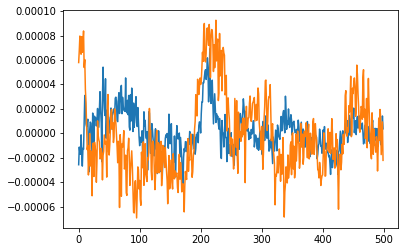

In [24]:
plt.plot(no_seizure[0][0])
plt.plot(seizure[0][0])

(250, 500)


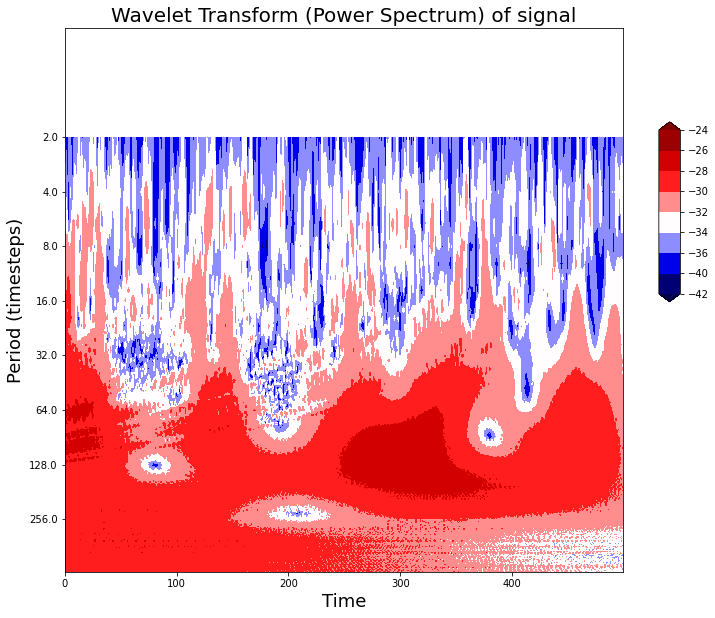

In [188]:
SECONDS = 2
sig = data[0][970*FREQ:970*FREQ + FREQ*SECONDS]
TIME = np.arange(0, FREQ*SECONDS)
plot_wavelet(TIME, sig, SCALES)